##### Copyright 2022 The TensorFlow Compression Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 可扩展的模型压缩

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/optimization/compression"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/optimization/compression.ipynb">     <img src="https://tensorflow.google.cn/images/colab_logo_32px.png">     在 Google Colab 中运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/optimization/compression.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/optimization/compression.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

## 概述

本笔记本展示了如何使用 [TensorFlow Compression](https://github.com/tensorflow/compression) 压缩模型。

在下面的示例中，我们将 MNIST 分类器的权重压缩到比其浮点表示小得多的大小，同时保持分类准确率。这是通过基于论文 [Scalable Model Compression by Entropy Penalized Reparameterization](https://arxiv.org/abs/1906.06624) 的两步过程完成的：

- 在训练期间使用显式**熵惩罚**来训练“可压缩”模型，这鼓励了模型参数的可压缩性。此惩罚的权重 $\lambda$，能够持续控制压缩模型大小和其准确率之间的权衡。

- 使用与惩罚相匹配的编码方案将可压缩模型编码为压缩模型，这意味着惩罚是对模型大小的良好预测指标。这确保了该方法不需要多次迭代训练、压缩和重新训练模型以进行微调。

这种方法会严格考虑压缩模型的大小，而不是计算复杂度。它可以与模型剪枝等技术相结合，以减少大小和复杂度。

各种模型的压缩结果示例：

模型（数据集） | 模型大小 | 压缩率 | Top-1 错误压缩（解压缩）
--- | --- | --- | ---
LeNet300-100 (MNIST) | 8.56 KB | 124x | 1.9%  (1.6%)
LeNet5-Caffe (MNIST) | 2.84 KB | 606x | 1.0%  (0.7%)
VGG-16 (CIFAR-10) | 101 KB | 590x | 10.0%  (6.6%)
ResNet-20-4 (CIFAR-10) | 128 KB | 134x | 8.8%  (5.0%)
ResNet-18 (ImageNet) | 1.97 MB | 24x | 30.0% (30.0%)
ResNet-50 (ImageNet) | 5.49 MB | 19x | 26.0% (25.0%)

应用包括：

- 大规模部署/广播模型到边缘设备，节省传输带宽。
- 在联合学习中向客户端传达全局模型状态。模型架构（隐藏单元的数量等）相较于初始模型没有变化，客户端可以在解压缩的模型上继续学习。
- 在内存极其有限的客户端上执行推断。在推断过程中，可以按顺序解压缩每一层的权重，并在计算激活后立即丢弃。

## 设置

通过 `pip` 安装 TensorFlow Compression。

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


  Using cached tensorflow_compression-2.14.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)


  Using cached tensorflow-2.14.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)


  Using cached tensorflow_probability-0.22.1-py2.py3-none-any.whl.metadata (13 kB)


  Using cached tensorboard-2.14.1-py3-none-any.whl.metadata (1.7 kB)


  Using cached tensorflow_estimator-2.14.0-py2.py3-none-any.whl.metadata (1.3 kB)


  Using cached keras-2.14.0-py3-none-any.whl.metadata (2.4 kB)


  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)


  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)


Using cached tensorflow_compression-2.14.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (257 kB)


Using cached tensorflow-2.14.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (489.8 MB)


Using cached tensorflow_probability-0.22.1-py2.py3-none-any.whl (6.9 MB)


Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)


Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)


Using cached tensorboard-2.14.1-py3-none-any.whl (5.5 MB)


Using cached tensorflow_estimator-2.14.0-py2.py3-none-any.whl (440 kB)


  Attempting uninstall: tensorflow-estimator


    Found existing installation: tensorflow-estimator 2.15.0


    Uninstalling tensorflow-estimator-2.15.0:


      Successfully uninstalled tensorflow-estimator-2.15.0


  Attempting uninstall: keras


    Found existing installation: keras 2.15.0


    Uninstalling keras-2.15.0:


      Successfully uninstalled keras-2.15.0


  Attempting uninstall: google-auth-oauthlib


    Found existing installation: google-auth-oauthlib 1.1.0


    Uninstalling google-auth-oauthlib-1.1.0:


      Successfully uninstalled google-auth-oauthlib-1.1.0


  Attempting uninstall: tensorboard


    Found existing installation: tensorboard 2.15.1


    Uninstalling tensorboard-2.15.1:


      Successfully uninstalled tensorboard-2.15.1


  Attempting uninstall: tensorflow


    Found existing installation: tensorflow 2.15.0rc1


    Uninstalling tensorflow-2.15.0rc1:


      Successfully uninstalled tensorflow-2.15.0rc1


导入库依赖项。

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


2023-11-07 22:10:27.535568: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 22:10:27.535626: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 22:10:27.535666: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 定义和训练一个基本的 MNIST 分类器

为了高效压缩密集层和卷积层，我们需要定义自定义层类。这些类似于 `tf.keras.layers` 下的层，但我们稍后将对它们进行子类化以高效实现熵惩罚重参数化 (EPR)。为此，我们还添加了一个复制构造函数。

首先，我们定义一个标准的密集层：

In [4]:
class CustomDense(tf.keras.layers.Layer):

  def __init__(self, filters, name="dense"):
    super().__init__(name=name)
    self.filters = filters

  @classmethod
  def copy(cls, other, **kwargs):
    """Returns an instantiated and built layer, initialized from `other`."""
    self = cls(filters=other.filters, name=other.name, **kwargs)
    self.build(None, other=other)
    return self

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    if other is None:
      kernel_shape = (input_shape[-1], self.filters)
      kernel = tf.keras.initializers.GlorotUniform()(shape=kernel_shape)
      bias = tf.keras.initializers.Zeros()(shape=(self.filters,))
    else:
      kernel, bias = other.kernel, other.bias
    self.kernel = tf.Variable(
        tf.cast(kernel, self.variable_dtype), name="kernel")
    self.bias = tf.Variable(
        tf.cast(bias, self.variable_dtype), name="bias")
    self.built = True

  def call(self, inputs):
    outputs = tf.linalg.matvec(self.kernel, inputs, transpose_a=True)
    outputs = tf.nn.bias_add(outputs, self.bias)
    return tf.nn.leaky_relu(outputs)


类似地，定义一个 2D 卷积层：

In [5]:
class CustomConv2D(tf.keras.layers.Layer):

  def __init__(self, filters, kernel_size,
               strides=1, padding="SAME", name="conv2d"):
    super().__init__(name=name)
    self.filters = filters
    self.kernel_size = kernel_size
    self.strides = strides
    self.padding = padding

  @classmethod
  def copy(cls, other, **kwargs):
    """Returns an instantiated and built layer, initialized from `other`."""
    self = cls(filters=other.filters, kernel_size=other.kernel_size,
               strides=other.strides, padding=other.padding, name=other.name,
               **kwargs)
    self.build(None, other=other)
    return self

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    if other is None:
      kernel_shape = 2 * (self.kernel_size,) + (input_shape[-1], self.filters)
      kernel = tf.keras.initializers.GlorotUniform()(shape=kernel_shape)
      bias = tf.keras.initializers.Zeros()(shape=(self.filters,))
    else:
      kernel, bias = other.kernel, other.bias
    self.kernel = tf.Variable(
        tf.cast(kernel, self.variable_dtype), name="kernel")
    self.bias = tf.Variable(
        tf.cast(bias, self.variable_dtype), name="bias")
    self.built = True

  def call(self, inputs):
    outputs = tf.nn.convolution(
        inputs, self.kernel, strides=self.strides, padding=self.padding)
    outputs = tf.nn.bias_add(outputs, self.bias)
    return tf.nn.leaky_relu(outputs)


在继续模型压缩之前，我们来检查一下是否可以成功地训练一个常规分类器。

定义模型架构：

In [6]:
classifier = tf.keras.Sequential([
    CustomConv2D(20, 5, strides=2, name="conv_1"),
    CustomConv2D(50, 5, strides=2, name="conv_2"),
    tf.keras.layers.Flatten(),
    CustomDense(500, name="fc_1"),
    CustomDense(10, name="fc_2"),
], name="classifier")


2023-11-07 22:10:31.096992: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


加载训练数据：

In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
training_dataset = training_dataset.map(normalize_img)
validation_dataset = validation_dataset.map(normalize_img)


最后，训练模型：

In [8]:
def train_model(model, training_data, validation_data, **kwargs):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
      # Uncomment this to ease debugging:
      # run_eagerly=True,
  )
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(
      training_data.batch(128).prefetch(8),
      validation_data=validation_data.batch(128).cache(),
      validation_freq=1,
      **kwargs,
  )
  return log.history["val_sparse_categorical_accuracy"][-1]

classifier_accuracy = train_model(
    classifier, training_dataset, validation_dataset)

print(f"Accuracy: {classifier_accuracy:0.4f}")


Epoch 1/5


  1/469 [..............................] - ETA: 12:37 - loss: 2.3042 - sparse_categorical_accuracy: 0.1328

  2/469 [..............................] - ETA: 56s - loss: 2.2822 - sparse_categorical_accuracy: 0.1641  

  3/469 [..............................] - ETA: 55s - loss: 2.2576 - sparse_categorical_accuracy: 0.2057

  4/469 [..............................] - ETA: 54s - loss: 2.2229 - sparse_categorical_accuracy: 0.2480

  5/469 [..............................] - ETA: 53s - loss: 2.1831 - sparse_categorical_accuracy: 0.2891

  6/469 [..............................] - ETA: 53s - loss: 2.1223 - sparse_categorical_accuracy: 0.3490

  7/469 [..............................] - ETA: 53s - loss: 2.0524 - sparse_categorical_accuracy: 0.3940

  8/469 [..............................] - ETA: 52s - loss: 1.9792 - sparse_categorical_accuracy: 0.4287

  9/469 [..............................] - ETA: 52s - loss: 1.8871 - sparse_categorical_accuracy: 0.4644

 10/469 [..............................] - ETA: 52s - loss: 1.8075 - sparse_categorical_accuracy: 0.4852

 11/469 [..............................] - ETA: 52s - loss: 1.7124 - sparse_categorical_accuracy: 0.5178

 12/469 [..............................] - ETA: 52s - loss: 1.6271 - sparse_categorical_accuracy: 0.5397

 13/469 [..............................] - ETA: 51s - loss: 1.5522 - sparse_categorical_accuracy: 0.5571

 14/469 [..............................] - ETA: 51s - loss: 1.4886 - sparse_categorical_accuracy: 0.5759

 15/469 [..............................] - ETA: 51s - loss: 1.4352 - sparse_categorical_accuracy: 0.5885

 16/469 [>.............................] - ETA: 51s - loss: 1.3863 - sparse_categorical_accuracy: 0.6006

 17/469 [>.............................] - ETA: 51s - loss: 1.3315 - sparse_categorical_accuracy: 0.6144

 18/469 [>.............................] - ETA: 50s - loss: 1.2833 - sparse_categorical_accuracy: 0.6285

 19/469 [>.............................] - ETA: 50s - loss: 1.2487 - sparse_categorical_accuracy: 0.6373

 20/469 [>.............................] - ETA: 50s - loss: 1.2118 - sparse_categorical_accuracy: 0.6465

 21/469 [>.............................] - ETA: 50s - loss: 1.1814 - sparse_categorical_accuracy: 0.6559

 22/469 [>.............................] - ETA: 50s - loss: 1.1567 - sparse_categorical_accuracy: 0.6634

 23/469 [>.............................] - ETA: 50s - loss: 1.1222 - sparse_categorical_accuracy: 0.6722

 24/469 [>.............................] - ETA: 49s - loss: 1.1043 - sparse_categorical_accuracy: 0.6797

 25/469 [>.............................] - ETA: 49s - loss: 1.0870 - sparse_categorical_accuracy: 0.6844

 26/469 [>.............................] - ETA: 49s - loss: 1.0674 - sparse_categorical_accuracy: 0.6902

 27/469 [>.............................] - ETA: 49s - loss: 1.0509 - sparse_categorical_accuracy: 0.6942

 28/469 [>.............................] - ETA: 49s - loss: 1.0271 - sparse_categorical_accuracy: 0.7023

 29/469 [>.............................] - ETA: 49s - loss: 1.0062 - sparse_categorical_accuracy: 0.7085

 30/469 [>.............................] - ETA: 48s - loss: 0.9827 - sparse_categorical_accuracy: 0.7159

 31/469 [>.............................] - ETA: 48s - loss: 0.9623 - sparse_categorical_accuracy: 0.7220

 32/469 [=>............................] - ETA: 48s - loss: 0.9436 - sparse_categorical_accuracy: 0.7280

 33/469 [=>............................] - ETA: 48s - loss: 0.9250 - sparse_categorical_accuracy: 0.7325

 34/469 [=>............................] - ETA: 48s - loss: 0.9069 - sparse_categorical_accuracy: 0.7371

 35/469 [=>............................] - ETA: 48s - loss: 0.8903 - sparse_categorical_accuracy: 0.7422

 36/469 [=>............................] - ETA: 48s - loss: 0.8729 - sparse_categorical_accuracy: 0.7470

 37/469 [=>............................] - ETA: 47s - loss: 0.8599 - sparse_categorical_accuracy: 0.7506

 38/469 [=>............................] - ETA: 47s - loss: 0.8508 - sparse_categorical_accuracy: 0.7523

 39/469 [=>............................] - ETA: 47s - loss: 0.8394 - sparse_categorical_accuracy: 0.7554

 40/469 [=>............................] - ETA: 47s - loss: 0.8298 - sparse_categorical_accuracy: 0.7578

 41/469 [=>............................] - ETA: 47s - loss: 0.8180 - sparse_categorical_accuracy: 0.7612

 42/469 [=>............................] - ETA: 47s - loss: 0.8056 - sparse_categorical_accuracy: 0.7651

 43/469 [=>............................] - ETA: 47s - loss: 0.7959 - sparse_categorical_accuracy: 0.7684

 44/469 [=>............................] - ETA: 46s - loss: 0.7869 - sparse_categorical_accuracy: 0.7713

 45/469 [=>............................] - ETA: 46s - loss: 0.7740 - sparse_categorical_accuracy: 0.7752

 46/469 [=>............................] - ETA: 46s - loss: 0.7638 - sparse_categorical_accuracy: 0.7787

 47/469 [==>...........................] - ETA: 46s - loss: 0.7541 - sparse_categorical_accuracy: 0.7816

 48/469 [==>...........................] - ETA: 46s - loss: 0.7457 - sparse_categorical_accuracy: 0.7839

 49/469 [==>...........................] - ETA: 46s - loss: 0.7395 - sparse_categorical_accuracy: 0.7867

 50/469 [==>...........................] - ETA: 46s - loss: 0.7318 - sparse_categorical_accuracy: 0.7887

 51/469 [==>...........................] - ETA: 45s - loss: 0.7244 - sparse_categorical_accuracy: 0.7907

 52/469 [==>...........................] - ETA: 45s - loss: 0.7187 - sparse_categorical_accuracy: 0.7924

 53/469 [==>...........................] - ETA: 45s - loss: 0.7100 - sparse_categorical_accuracy: 0.7950

 54/469 [==>...........................] - ETA: 45s - loss: 0.7031 - sparse_categorical_accuracy: 0.7962

 55/469 [==>...........................] - ETA: 45s - loss: 0.6954 - sparse_categorical_accuracy: 0.7982

 56/469 [==>...........................] - ETA: 45s - loss: 0.6860 - sparse_categorical_accuracy: 0.8009

 57/469 [==>...........................] - ETA: 45s - loss: 0.6795 - sparse_categorical_accuracy: 0.8030

 58/469 [==>...........................] - ETA: 45s - loss: 0.6737 - sparse_categorical_accuracy: 0.8044

 59/469 [==>...........................] - ETA: 45s - loss: 0.6666 - sparse_categorical_accuracy: 0.8065

 60/469 [==>...........................] - ETA: 44s - loss: 0.6600 - sparse_categorical_accuracy: 0.8078

 61/469 [==>...........................] - ETA: 44s - loss: 0.6566 - sparse_categorical_accuracy: 0.8092

 62/469 [==>...........................] - ETA: 44s - loss: 0.6514 - sparse_categorical_accuracy: 0.8107

 63/469 [===>..........................] - ETA: 44s - loss: 0.6462 - sparse_categorical_accuracy: 0.8121

 64/469 [===>..........................] - ETA: 44s - loss: 0.6405 - sparse_categorical_accuracy: 0.8132

 65/469 [===>..........................] - ETA: 44s - loss: 0.6331 - sparse_categorical_accuracy: 0.8153

 66/469 [===>..........................] - ETA: 44s - loss: 0.6266 - sparse_categorical_accuracy: 0.8172

 67/469 [===>..........................] - ETA: 44s - loss: 0.6205 - sparse_categorical_accuracy: 0.8190

 68/469 [===>..........................] - ETA: 44s - loss: 0.6159 - sparse_categorical_accuracy: 0.8200

 69/469 [===>..........................] - ETA: 43s - loss: 0.6112 - sparse_categorical_accuracy: 0.8214

 70/469 [===>..........................] - ETA: 43s - loss: 0.6062 - sparse_categorical_accuracy: 0.8232

 71/469 [===>..........................] - ETA: 43s - loss: 0.6015 - sparse_categorical_accuracy: 0.8247

 72/469 [===>..........................] - ETA: 43s - loss: 0.5973 - sparse_categorical_accuracy: 0.8261

 73/469 [===>..........................] - ETA: 43s - loss: 0.5915 - sparse_categorical_accuracy: 0.8278

 74/469 [===>..........................] - ETA: 43s - loss: 0.5874 - sparse_categorical_accuracy: 0.8288

 75/469 [===>..........................] - ETA: 43s - loss: 0.5827 - sparse_categorical_accuracy: 0.8303

 76/469 [===>..........................] - ETA: 43s - loss: 0.5781 - sparse_categorical_accuracy: 0.8316

 77/469 [===>..........................] - ETA: 43s - loss: 0.5758 - sparse_categorical_accuracy: 0.8326

 78/469 [===>..........................] - ETA: 42s - loss: 0.5703 - sparse_categorical_accuracy: 0.8343

 79/469 [====>.........................] - ETA: 42s - loss: 0.5662 - sparse_categorical_accuracy: 0.8354

 80/469 [====>.........................] - ETA: 42s - loss: 0.5631 - sparse_categorical_accuracy: 0.8363

 81/469 [====>.........................] - ETA: 42s - loss: 0.5582 - sparse_categorical_accuracy: 0.8376

 82/469 [====>.........................] - ETA: 42s - loss: 0.5554 - sparse_categorical_accuracy: 0.8382

 83/469 [====>.........................] - ETA: 42s - loss: 0.5530 - sparse_categorical_accuracy: 0.8390

 84/469 [====>.........................] - ETA: 42s - loss: 0.5487 - sparse_categorical_accuracy: 0.8403

 85/469 [====>.........................] - ETA: 42s - loss: 0.5459 - sparse_categorical_accuracy: 0.8411

 86/469 [====>.........................] - ETA: 42s - loss: 0.5428 - sparse_categorical_accuracy: 0.8421

 87/469 [====>.........................] - ETA: 41s - loss: 0.5396 - sparse_categorical_accuracy: 0.8430

 88/469 [====>.........................] - ETA: 41s - loss: 0.5358 - sparse_categorical_accuracy: 0.8440

 89/469 [====>.........................] - ETA: 41s - loss: 0.5328 - sparse_categorical_accuracy: 0.8449

 90/469 [====>.........................] - ETA: 41s - loss: 0.5283 - sparse_categorical_accuracy: 0.8464

 91/469 [====>.........................] - ETA: 41s - loss: 0.5253 - sparse_categorical_accuracy: 0.8472

 92/469 [====>.........................] - ETA: 41s - loss: 0.5223 - sparse_categorical_accuracy: 0.8479

 93/469 [====>.........................] - ETA: 41s - loss: 0.5206 - sparse_categorical_accuracy: 0.8486

 94/469 [=====>........................] - ETA: 41s - loss: 0.5173 - sparse_categorical_accuracy: 0.8495

 95/469 [=====>........................] - ETA: 41s - loss: 0.5163 - sparse_categorical_accuracy: 0.8498

 96/469 [=====>........................] - ETA: 40s - loss: 0.5140 - sparse_categorical_accuracy: 0.8503

 97/469 [=====>........................] - ETA: 40s - loss: 0.5112 - sparse_categorical_accuracy: 0.8512

 98/469 [=====>........................] - ETA: 40s - loss: 0.5072 - sparse_categorical_accuracy: 0.8523

 99/469 [=====>........................] - ETA: 40s - loss: 0.5036 - sparse_categorical_accuracy: 0.8535

100/469 [=====>........................] - ETA: 40s - loss: 0.5009 - sparse_categorical_accuracy: 0.8545

101/469 [=====>........................] - ETA: 40s - loss: 0.4977 - sparse_categorical_accuracy: 0.8552

102/469 [=====>........................] - ETA: 40s - loss: 0.4954 - sparse_categorical_accuracy: 0.8559

103/469 [=====>........................] - ETA: 40s - loss: 0.4932 - sparse_categorical_accuracy: 0.8563

104/469 [=====>........................] - ETA: 40s - loss: 0.4910 - sparse_categorical_accuracy: 0.8570

105/469 [=====>........................] - ETA: 40s - loss: 0.4881 - sparse_categorical_accuracy: 0.8579

106/469 [=====>........................] - ETA: 39s - loss: 0.4862 - sparse_categorical_accuracy: 0.8586

107/469 [=====>........................] - ETA: 39s - loss: 0.4834 - sparse_categorical_accuracy: 0.8595

108/469 [=====>........................] - ETA: 39s - loss: 0.4813 - sparse_categorical_accuracy: 0.8600

109/469 [=====>........................] - ETA: 39s - loss: 0.4791 - sparse_categorical_accuracy: 0.8607

110/469 [======>.......................] - ETA: 39s - loss: 0.4776 - sparse_categorical_accuracy: 0.8613

111/469 [======>.......................] - ETA: 39s - loss: 0.4755 - sparse_categorical_accuracy: 0.8619

112/469 [======>.......................] - ETA: 39s - loss: 0.4728 - sparse_categorical_accuracy: 0.8627

113/469 [======>.......................] - ETA: 39s - loss: 0.4706 - sparse_categorical_accuracy: 0.8634

114/469 [======>.......................] - ETA: 38s - loss: 0.4681 - sparse_categorical_accuracy: 0.8640

115/469 [======>.......................] - ETA: 38s - loss: 0.4664 - sparse_categorical_accuracy: 0.8645

116/469 [======>.......................] - ETA: 38s - loss: 0.4635 - sparse_categorical_accuracy: 0.8654

117/469 [======>.......................] - ETA: 38s - loss: 0.4614 - sparse_categorical_accuracy: 0.8660

118/469 [======>.......................] - ETA: 38s - loss: 0.4592 - sparse_categorical_accuracy: 0.8665

119/469 [======>.......................] - ETA: 38s - loss: 0.4570 - sparse_categorical_accuracy: 0.8671

120/469 [======>.......................] - ETA: 38s - loss: 0.4552 - sparse_categorical_accuracy: 0.8678

121/469 [======>.......................] - ETA: 38s - loss: 0.4530 - sparse_categorical_accuracy: 0.8685

122/469 [======>.......................] - ETA: 38s - loss: 0.4507 - sparse_categorical_accuracy: 0.8691

123/469 [======>.......................] - ETA: 37s - loss: 0.4485 - sparse_categorical_accuracy: 0.8697

124/469 [======>.......................] - ETA: 37s - loss: 0.4464 - sparse_categorical_accuracy: 0.8703

125/469 [======>.......................] - ETA: 37s - loss: 0.4435 - sparse_categorical_accuracy: 0.8712

126/469 [=======>......................] - ETA: 37s - loss: 0.4418 - sparse_categorical_accuracy: 0.8717

127/469 [=======>......................] - ETA: 37s - loss: 0.4397 - sparse_categorical_accuracy: 0.8722

128/469 [=======>......................] - ETA: 37s - loss: 0.4374 - sparse_categorical_accuracy: 0.8730

129/469 [=======>......................] - ETA: 37s - loss: 0.4368 - sparse_categorical_accuracy: 0.8731

130/469 [=======>......................] - ETA: 37s - loss: 0.4344 - sparse_categorical_accuracy: 0.8737

131/469 [=======>......................] - ETA: 37s - loss: 0.4320 - sparse_categorical_accuracy: 0.8745

132/469 [=======>......................] - ETA: 36s - loss: 0.4304 - sparse_categorical_accuracy: 0.8749

133/469 [=======>......................] - ETA: 36s - loss: 0.4296 - sparse_categorical_accuracy: 0.8752

134/469 [=======>......................] - ETA: 36s - loss: 0.4281 - sparse_categorical_accuracy: 0.8757

135/469 [=======>......................] - ETA: 36s - loss: 0.4266 - sparse_categorical_accuracy: 0.8760

136/469 [=======>......................] - ETA: 36s - loss: 0.4249 - sparse_categorical_accuracy: 0.8767

137/469 [=======>......................] - ETA: 36s - loss: 0.4238 - sparse_categorical_accuracy: 0.8769

138/469 [=======>......................] - ETA: 36s - loss: 0.4223 - sparse_categorical_accuracy: 0.8774

139/469 [=======>......................] - ETA: 36s - loss: 0.4206 - sparse_categorical_accuracy: 0.8778

140/469 [=======>......................] - ETA: 36s - loss: 0.4185 - sparse_categorical_accuracy: 0.8784

141/469 [========>.....................] - ETA: 35s - loss: 0.4166 - sparse_categorical_accuracy: 0.8789

142/469 [========>.....................] - ETA: 35s - loss: 0.4148 - sparse_categorical_accuracy: 0.8793

143/469 [========>.....................] - ETA: 35s - loss: 0.4130 - sparse_categorical_accuracy: 0.8799

144/469 [========>.....................] - ETA: 35s - loss: 0.4118 - sparse_categorical_accuracy: 0.8802

145/469 [========>.....................] - ETA: 35s - loss: 0.4104 - sparse_categorical_accuracy: 0.8806

146/469 [========>.....................] - ETA: 35s - loss: 0.4083 - sparse_categorical_accuracy: 0.8813

147/469 [========>.....................] - ETA: 35s - loss: 0.4059 - sparse_categorical_accuracy: 0.8820

148/469 [========>.....................] - ETA: 35s - loss: 0.4050 - sparse_categorical_accuracy: 0.8823

149/469 [========>.....................] - ETA: 35s - loss: 0.4032 - sparse_categorical_accuracy: 0.8828

150/469 [========>.....................] - ETA: 34s - loss: 0.4012 - sparse_categorical_accuracy: 0.8834

151/469 [========>.....................] - ETA: 34s - loss: 0.3997 - sparse_categorical_accuracy: 0.8838

152/469 [========>.....................] - ETA: 34s - loss: 0.3982 - sparse_categorical_accuracy: 0.8843

153/469 [========>.....................] - ETA: 34s - loss: 0.3965 - sparse_categorical_accuracy: 0.8849

154/469 [========>.....................] - ETA: 34s - loss: 0.3950 - sparse_categorical_accuracy: 0.8851

155/469 [========>.....................] - ETA: 34s - loss: 0.3932 - sparse_categorical_accuracy: 0.8857

156/469 [========>.....................] - ETA: 34s - loss: 0.3912 - sparse_categorical_accuracy: 0.8862

157/469 [=========>....................] - ETA: 34s - loss: 0.3897 - sparse_categorical_accuracy: 0.8866

158/469 [=========>....................] - ETA: 34s - loss: 0.3883 - sparse_categorical_accuracy: 0.8871

159/469 [=========>....................] - ETA: 33s - loss: 0.3868 - sparse_categorical_accuracy: 0.8874

160/469 [=========>....................] - ETA: 33s - loss: 0.3852 - sparse_categorical_accuracy: 0.8879

161/469 [=========>....................] - ETA: 33s - loss: 0.3838 - sparse_categorical_accuracy: 0.8882

162/469 [=========>....................] - ETA: 33s - loss: 0.3826 - sparse_categorical_accuracy: 0.8886

163/469 [=========>....................] - ETA: 33s - loss: 0.3815 - sparse_categorical_accuracy: 0.8889

164/469 [=========>....................] - ETA: 33s - loss: 0.3798 - sparse_categorical_accuracy: 0.8894

165/469 [=========>....................] - ETA: 33s - loss: 0.3791 - sparse_categorical_accuracy: 0.8895

166/469 [=========>....................] - ETA: 33s - loss: 0.3780 - sparse_categorical_accuracy: 0.8899

167/469 [=========>....................] - ETA: 33s - loss: 0.3760 - sparse_categorical_accuracy: 0.8904

168/469 [=========>....................] - ETA: 32s - loss: 0.3744 - sparse_categorical_accuracy: 0.8909

169/469 [=========>....................] - ETA: 32s - loss: 0.3728 - sparse_categorical_accuracy: 0.8913

170/469 [=========>....................] - ETA: 32s - loss: 0.3716 - sparse_categorical_accuracy: 0.8917

171/469 [=========>....................] - ETA: 32s - loss: 0.3704 - sparse_categorical_accuracy: 0.8921

172/469 [==========>...................] - ETA: 32s - loss: 0.3689 - sparse_categorical_accuracy: 0.8925

173/469 [==========>...................] - ETA: 32s - loss: 0.3677 - sparse_categorical_accuracy: 0.8928

174/469 [==========>...................] - ETA: 32s - loss: 0.3670 - sparse_categorical_accuracy: 0.8930

175/469 [==========>...................] - ETA: 32s - loss: 0.3657 - sparse_categorical_accuracy: 0.8934

176/469 [==========>...................] - ETA: 32s - loss: 0.3643 - sparse_categorical_accuracy: 0.8938

177/469 [==========>...................] - ETA: 31s - loss: 0.3633 - sparse_categorical_accuracy: 0.8942

178/469 [==========>...................] - ETA: 31s - loss: 0.3623 - sparse_categorical_accuracy: 0.8944

179/469 [==========>...................] - ETA: 31s - loss: 0.3615 - sparse_categorical_accuracy: 0.8946

180/469 [==========>...................] - ETA: 31s - loss: 0.3609 - sparse_categorical_accuracy: 0.8947

181/469 [==========>...................] - ETA: 31s - loss: 0.3600 - sparse_categorical_accuracy: 0.8949

182/469 [==========>...................] - ETA: 31s - loss: 0.3587 - sparse_categorical_accuracy: 0.8952

183/469 [==========>...................] - ETA: 31s - loss: 0.3575 - sparse_categorical_accuracy: 0.8957

184/469 [==========>...................] - ETA: 31s - loss: 0.3564 - sparse_categorical_accuracy: 0.8960

185/469 [==========>...................] - ETA: 31s - loss: 0.3555 - sparse_categorical_accuracy: 0.8962

186/469 [==========>...................] - ETA: 30s - loss: 0.3543 - sparse_categorical_accuracy: 0.8966

187/469 [==========>...................] - ETA: 30s - loss: 0.3535 - sparse_categorical_accuracy: 0.8968

188/469 [===========>..................] - ETA: 30s - loss: 0.3527 - sparse_categorical_accuracy: 0.8970

189/469 [===========>..................] - ETA: 30s - loss: 0.3515 - sparse_categorical_accuracy: 0.8973

190/469 [===========>..................] - ETA: 30s - loss: 0.3505 - sparse_categorical_accuracy: 0.8975

191/469 [===========>..................] - ETA: 30s - loss: 0.3497 - sparse_categorical_accuracy: 0.8979

192/469 [===========>..................] - ETA: 30s - loss: 0.3487 - sparse_categorical_accuracy: 0.8980

193/469 [===========>..................] - ETA: 30s - loss: 0.3475 - sparse_categorical_accuracy: 0.8984

194/469 [===========>..................] - ETA: 30s - loss: 0.3467 - sparse_categorical_accuracy: 0.8987

195/469 [===========>..................] - ETA: 29s - loss: 0.3458 - sparse_categorical_accuracy: 0.8989

196/469 [===========>..................] - ETA: 29s - loss: 0.3446 - sparse_categorical_accuracy: 0.8992

197/469 [===========>..................] - ETA: 29s - loss: 0.3436 - sparse_categorical_accuracy: 0.8995

198/469 [===========>..................] - ETA: 29s - loss: 0.3423 - sparse_categorical_accuracy: 0.8998

199/469 [===========>..................] - ETA: 29s - loss: 0.3416 - sparse_categorical_accuracy: 0.9000

200/469 [===========>..................] - ETA: 29s - loss: 0.3404 - sparse_categorical_accuracy: 0.9003

201/469 [===========>..................] - ETA: 29s - loss: 0.3396 - sparse_categorical_accuracy: 0.9005

202/469 [===========>..................] - ETA: 29s - loss: 0.3385 - sparse_categorical_accuracy: 0.9008

203/469 [===========>..................] - ETA: 29s - loss: 0.3374 - sparse_categorical_accuracy: 0.9012

204/469 [============>.................] - ETA: 28s - loss: 0.3362 - sparse_categorical_accuracy: 0.9015

205/469 [============>.................] - ETA: 28s - loss: 0.3350 - sparse_categorical_accuracy: 0.9019

206/469 [============>.................] - ETA: 28s - loss: 0.3336 - sparse_categorical_accuracy: 0.9023

207/469 [============>.................] - ETA: 28s - loss: 0.3329 - sparse_categorical_accuracy: 0.9025

208/469 [============>.................] - ETA: 28s - loss: 0.3319 - sparse_categorical_accuracy: 0.9028

209/469 [============>.................] - ETA: 28s - loss: 0.3308 - sparse_categorical_accuracy: 0.9032

210/469 [============>.................] - ETA: 28s - loss: 0.3301 - sparse_categorical_accuracy: 0.9033

211/469 [============>.................] - ETA: 28s - loss: 0.3297 - sparse_categorical_accuracy: 0.9034

212/469 [============>.................] - ETA: 28s - loss: 0.3287 - sparse_categorical_accuracy: 0.9037

213/469 [============>.................] - ETA: 27s - loss: 0.3280 - sparse_categorical_accuracy: 0.9038

214/469 [============>.................] - ETA: 27s - loss: 0.3274 - sparse_categorical_accuracy: 0.9039

215/469 [============>.................] - ETA: 27s - loss: 0.3267 - sparse_categorical_accuracy: 0.9042

216/469 [============>.................] - ETA: 27s - loss: 0.3261 - sparse_categorical_accuracy: 0.9044

217/469 [============>.................] - ETA: 27s - loss: 0.3252 - sparse_categorical_accuracy: 0.9046

218/469 [============>.................] - ETA: 27s - loss: 0.3241 - sparse_categorical_accuracy: 0.9050

219/469 [=============>................] - ETA: 27s - loss: 0.3233 - sparse_categorical_accuracy: 0.9052

220/469 [=============>................] - ETA: 27s - loss: 0.3220 - sparse_categorical_accuracy: 0.9056

221/469 [=============>................] - ETA: 27s - loss: 0.3214 - sparse_categorical_accuracy: 0.9058

222/469 [=============>................] - ETA: 26s - loss: 0.3203 - sparse_categorical_accuracy: 0.9061

223/469 [=============>................] - ETA: 26s - loss: 0.3196 - sparse_categorical_accuracy: 0.9063

224/469 [=============>................] - ETA: 26s - loss: 0.3185 - sparse_categorical_accuracy: 0.9066

225/469 [=============>................] - ETA: 26s - loss: 0.3177 - sparse_categorical_accuracy: 0.9067

226/469 [=============>................] - ETA: 26s - loss: 0.3169 - sparse_categorical_accuracy: 0.9070

227/469 [=============>................] - ETA: 26s - loss: 0.3163 - sparse_categorical_accuracy: 0.9071

228/469 [=============>................] - ETA: 26s - loss: 0.3159 - sparse_categorical_accuracy: 0.9072

229/469 [=============>................] - ETA: 26s - loss: 0.3151 - sparse_categorical_accuracy: 0.9074

230/469 [=============>................] - ETA: 26s - loss: 0.3142 - sparse_categorical_accuracy: 0.9076

231/469 [=============>................] - ETA: 25s - loss: 0.3132 - sparse_categorical_accuracy: 0.9079

232/469 [=============>................] - ETA: 25s - loss: 0.3121 - sparse_categorical_accuracy: 0.9082

233/469 [=============>................] - ETA: 25s - loss: 0.3112 - sparse_categorical_accuracy: 0.9085

234/469 [=============>................] - ETA: 25s - loss: 0.3105 - sparse_categorical_accuracy: 0.9087

235/469 [==============>...............] - ETA: 25s - loss: 0.3106 - sparse_categorical_accuracy: 0.9086

236/469 [==============>...............] - ETA: 25s - loss: 0.3100 - sparse_categorical_accuracy: 0.9088

237/469 [==============>...............] - ETA: 25s - loss: 0.3093 - sparse_categorical_accuracy: 0.9089

238/469 [==============>...............] - ETA: 25s - loss: 0.3083 - sparse_categorical_accuracy: 0.9092

239/469 [==============>...............] - ETA: 25s - loss: 0.3075 - sparse_categorical_accuracy: 0.9094

240/469 [==============>...............] - ETA: 24s - loss: 0.3065 - sparse_categorical_accuracy: 0.9096

241/469 [==============>...............] - ETA: 24s - loss: 0.3060 - sparse_categorical_accuracy: 0.9097

242/469 [==============>...............] - ETA: 24s - loss: 0.3053 - sparse_categorical_accuracy: 0.9099

243/469 [==============>...............] - ETA: 24s - loss: 0.3052 - sparse_categorical_accuracy: 0.9100

244/469 [==============>...............] - ETA: 24s - loss: 0.3047 - sparse_categorical_accuracy: 0.9101

245/469 [==============>...............] - ETA: 24s - loss: 0.3044 - sparse_categorical_accuracy: 0.9102

246/469 [==============>...............] - ETA: 24s - loss: 0.3033 - sparse_categorical_accuracy: 0.9104

247/469 [==============>...............] - ETA: 24s - loss: 0.3025 - sparse_categorical_accuracy: 0.9107

248/469 [==============>...............] - ETA: 24s - loss: 0.3015 - sparse_categorical_accuracy: 0.9110

249/469 [==============>...............] - ETA: 23s - loss: 0.3009 - sparse_categorical_accuracy: 0.9112

250/469 [==============>...............] - ETA: 23s - loss: 0.3000 - sparse_categorical_accuracy: 0.9115

251/469 [===============>..............] - ETA: 23s - loss: 0.2991 - sparse_categorical_accuracy: 0.9118

252/469 [===============>..............] - ETA: 23s - loss: 0.2986 - sparse_categorical_accuracy: 0.9120

253/469 [===============>..............] - ETA: 23s - loss: 0.2977 - sparse_categorical_accuracy: 0.9122

254/469 [===============>..............] - ETA: 23s - loss: 0.2968 - sparse_categorical_accuracy: 0.9125

255/469 [===============>..............] - ETA: 23s - loss: 0.2960 - sparse_categorical_accuracy: 0.9127

256/469 [===============>..............] - ETA: 23s - loss: 0.2950 - sparse_categorical_accuracy: 0.9131

257/469 [===============>..............] - ETA: 23s - loss: 0.2943 - sparse_categorical_accuracy: 0.9132

258/469 [===============>..............] - ETA: 22s - loss: 0.2936 - sparse_categorical_accuracy: 0.9135

259/469 [===============>..............] - ETA: 22s - loss: 0.2926 - sparse_categorical_accuracy: 0.9137

260/469 [===============>..............] - ETA: 22s - loss: 0.2919 - sparse_categorical_accuracy: 0.9138

261/469 [===============>..............] - ETA: 22s - loss: 0.2911 - sparse_categorical_accuracy: 0.9141

262/469 [===============>..............] - ETA: 22s - loss: 0.2911 - sparse_categorical_accuracy: 0.9142

263/469 [===============>..............] - ETA: 22s - loss: 0.2906 - sparse_categorical_accuracy: 0.9144

264/469 [===============>..............] - ETA: 22s - loss: 0.2901 - sparse_categorical_accuracy: 0.9145

265/469 [===============>..............] - ETA: 22s - loss: 0.2896 - sparse_categorical_accuracy: 0.9147

266/469 [================>.............] - ETA: 22s - loss: 0.2887 - sparse_categorical_accuracy: 0.9149

267/469 [================>.............] - ETA: 22s - loss: 0.2878 - sparse_categorical_accuracy: 0.9152

268/469 [================>.............] - ETA: 21s - loss: 0.2872 - sparse_categorical_accuracy: 0.9154

269/469 [================>.............] - ETA: 21s - loss: 0.2865 - sparse_categorical_accuracy: 0.9156

270/469 [================>.............] - ETA: 21s - loss: 0.2856 - sparse_categorical_accuracy: 0.9159

271/469 [================>.............] - ETA: 21s - loss: 0.2850 - sparse_categorical_accuracy: 0.9161

272/469 [================>.............] - ETA: 21s - loss: 0.2842 - sparse_categorical_accuracy: 0.9163

273/469 [================>.............] - ETA: 21s - loss: 0.2835 - sparse_categorical_accuracy: 0.9165

274/469 [================>.............] - ETA: 21s - loss: 0.2829 - sparse_categorical_accuracy: 0.9166

275/469 [================>.............] - ETA: 21s - loss: 0.2822 - sparse_categorical_accuracy: 0.9168

276/469 [================>.............] - ETA: 21s - loss: 0.2814 - sparse_categorical_accuracy: 0.9170

277/469 [================>.............] - ETA: 20s - loss: 0.2808 - sparse_categorical_accuracy: 0.9171

278/469 [================>.............] - ETA: 20s - loss: 0.2806 - sparse_categorical_accuracy: 0.9172

279/469 [================>.............] - ETA: 20s - loss: 0.2802 - sparse_categorical_accuracy: 0.9173

280/469 [================>.............] - ETA: 20s - loss: 0.2798 - sparse_categorical_accuracy: 0.9175

281/469 [================>.............] - ETA: 20s - loss: 0.2793 - sparse_categorical_accuracy: 0.9176

282/469 [=================>............] - ETA: 20s - loss: 0.2785 - sparse_categorical_accuracy: 0.9178

283/469 [=================>............] - ETA: 20s - loss: 0.2777 - sparse_categorical_accuracy: 0.9181

284/469 [=================>............] - ETA: 20s - loss: 0.2773 - sparse_categorical_accuracy: 0.9182

285/469 [=================>............] - ETA: 20s - loss: 0.2769 - sparse_categorical_accuracy: 0.9183

286/469 [=================>............] - ETA: 19s - loss: 0.2763 - sparse_categorical_accuracy: 0.9185

287/469 [=================>............] - ETA: 19s - loss: 0.2757 - sparse_categorical_accuracy: 0.9187

288/469 [=================>............] - ETA: 19s - loss: 0.2753 - sparse_categorical_accuracy: 0.9188

289/469 [=================>............] - ETA: 19s - loss: 0.2747 - sparse_categorical_accuracy: 0.9189

290/469 [=================>............] - ETA: 19s - loss: 0.2742 - sparse_categorical_accuracy: 0.9190

291/469 [=================>............] - ETA: 19s - loss: 0.2737 - sparse_categorical_accuracy: 0.9192

292/469 [=================>............] - ETA: 19s - loss: 0.2732 - sparse_categorical_accuracy: 0.9193

293/469 [=================>............] - ETA: 19s - loss: 0.2729 - sparse_categorical_accuracy: 0.9194

294/469 [=================>............] - ETA: 19s - loss: 0.2725 - sparse_categorical_accuracy: 0.9195

295/469 [=================>............] - ETA: 18s - loss: 0.2719 - sparse_categorical_accuracy: 0.9196

296/469 [=================>............] - ETA: 18s - loss: 0.2716 - sparse_categorical_accuracy: 0.9197

297/469 [=================>............] - ETA: 18s - loss: 0.2709 - sparse_categorical_accuracy: 0.9199

298/469 [==================>...........] - ETA: 18s - loss: 0.2703 - sparse_categorical_accuracy: 0.9201

299/469 [==================>...........] - ETA: 18s - loss: 0.2698 - sparse_categorical_accuracy: 0.9202

300/469 [==================>...........] - ETA: 18s - loss: 0.2692 - sparse_categorical_accuracy: 0.9204

301/469 [==================>...........] - ETA: 18s - loss: 0.2688 - sparse_categorical_accuracy: 0.9205

302/469 [==================>...........] - ETA: 18s - loss: 0.2681 - sparse_categorical_accuracy: 0.9207

303/469 [==================>...........] - ETA: 18s - loss: 0.2675 - sparse_categorical_accuracy: 0.9208

304/469 [==================>...........] - ETA: 17s - loss: 0.2670 - sparse_categorical_accuracy: 0.9209

305/469 [==================>...........] - ETA: 17s - loss: 0.2666 - sparse_categorical_accuracy: 0.9210

306/469 [==================>...........] - ETA: 17s - loss: 0.2660 - sparse_categorical_accuracy: 0.9212

307/469 [==================>...........] - ETA: 17s - loss: 0.2654 - sparse_categorical_accuracy: 0.9213

308/469 [==================>...........] - ETA: 17s - loss: 0.2653 - sparse_categorical_accuracy: 0.9214

309/469 [==================>...........] - ETA: 17s - loss: 0.2648 - sparse_categorical_accuracy: 0.9216

310/469 [==================>...........] - ETA: 17s - loss: 0.2643 - sparse_categorical_accuracy: 0.9217

311/469 [==================>...........] - ETA: 17s - loss: 0.2638 - sparse_categorical_accuracy: 0.9218

312/469 [==================>...........] - ETA: 17s - loss: 0.2633 - sparse_categorical_accuracy: 0.9220

313/469 [===================>..........] - ETA: 17s - loss: 0.2629 - sparse_categorical_accuracy: 0.9221

314/469 [===================>..........] - ETA: 16s - loss: 0.2626 - sparse_categorical_accuracy: 0.9221

315/469 [===================>..........] - ETA: 16s - loss: 0.2621 - sparse_categorical_accuracy: 0.9222

316/469 [===================>..........] - ETA: 16s - loss: 0.2617 - sparse_categorical_accuracy: 0.9223

317/469 [===================>..........] - ETA: 16s - loss: 0.2613 - sparse_categorical_accuracy: 0.9224

318/469 [===================>..........] - ETA: 16s - loss: 0.2607 - sparse_categorical_accuracy: 0.9226

319/469 [===================>..........] - ETA: 16s - loss: 0.2601 - sparse_categorical_accuracy: 0.9228

320/469 [===================>..........] - ETA: 16s - loss: 0.2595 - sparse_categorical_accuracy: 0.9230

321/469 [===================>..........] - ETA: 16s - loss: 0.2588 - sparse_categorical_accuracy: 0.9232

322/469 [===================>..........] - ETA: 16s - loss: 0.2588 - sparse_categorical_accuracy: 0.9232

323/469 [===================>..........] - ETA: 15s - loss: 0.2582 - sparse_categorical_accuracy: 0.9233

324/469 [===================>..........] - ETA: 15s - loss: 0.2581 - sparse_categorical_accuracy: 0.9234

325/469 [===================>..........] - ETA: 15s - loss: 0.2575 - sparse_categorical_accuracy: 0.9235

326/469 [===================>..........] - ETA: 15s - loss: 0.2571 - sparse_categorical_accuracy: 0.9236

327/469 [===================>..........] - ETA: 15s - loss: 0.2565 - sparse_categorical_accuracy: 0.9238

328/469 [===================>..........] - ETA: 15s - loss: 0.2559 - sparse_categorical_accuracy: 0.9239

329/469 [====================>.........] - ETA: 15s - loss: 0.2554 - sparse_categorical_accuracy: 0.9240

330/469 [====================>.........] - ETA: 15s - loss: 0.2549 - sparse_categorical_accuracy: 0.9242

331/469 [====================>.........] - ETA: 15s - loss: 0.2544 - sparse_categorical_accuracy: 0.9244

332/469 [====================>.........] - ETA: 14s - loss: 0.2540 - sparse_categorical_accuracy: 0.9245

333/469 [====================>.........] - ETA: 14s - loss: 0.2534 - sparse_categorical_accuracy: 0.9247

334/469 [====================>.........] - ETA: 14s - loss: 0.2531 - sparse_categorical_accuracy: 0.9248

335/469 [====================>.........] - ETA: 14s - loss: 0.2526 - sparse_categorical_accuracy: 0.9249

336/469 [====================>.........] - ETA: 14s - loss: 0.2521 - sparse_categorical_accuracy: 0.9250

337/469 [====================>.........] - ETA: 14s - loss: 0.2517 - sparse_categorical_accuracy: 0.9252

338/469 [====================>.........] - ETA: 14s - loss: 0.2513 - sparse_categorical_accuracy: 0.9253

339/469 [====================>.........] - ETA: 14s - loss: 0.2508 - sparse_categorical_accuracy: 0.9254

340/469 [====================>.........] - ETA: 14s - loss: 0.2502 - sparse_categorical_accuracy: 0.9256

341/469 [====================>.........] - ETA: 13s - loss: 0.2495 - sparse_categorical_accuracy: 0.9258

342/469 [====================>.........] - ETA: 13s - loss: 0.2490 - sparse_categorical_accuracy: 0.9260

343/469 [====================>.........] - ETA: 13s - loss: 0.2485 - sparse_categorical_accuracy: 0.9261

344/469 [=====================>........] - ETA: 13s - loss: 0.2479 - sparse_categorical_accuracy: 0.9263

345/469 [=====================>........] - ETA: 13s - loss: 0.2475 - sparse_categorical_accuracy: 0.9264

346/469 [=====================>........] - ETA: 13s - loss: 0.2471 - sparse_categorical_accuracy: 0.9265

347/469 [=====================>........] - ETA: 13s - loss: 0.2466 - sparse_categorical_accuracy: 0.9266

348/469 [=====================>........] - ETA: 13s - loss: 0.2460 - sparse_categorical_accuracy: 0.9268

349/469 [=====================>........] - ETA: 13s - loss: 0.2456 - sparse_categorical_accuracy: 0.9270

350/469 [=====================>........] - ETA: 12s - loss: 0.2452 - sparse_categorical_accuracy: 0.9271

351/469 [=====================>........] - ETA: 12s - loss: 0.2446 - sparse_categorical_accuracy: 0.9272

352/469 [=====================>........] - ETA: 12s - loss: 0.2443 - sparse_categorical_accuracy: 0.9273

353/469 [=====================>........] - ETA: 12s - loss: 0.2441 - sparse_categorical_accuracy: 0.9275

354/469 [=====================>........] - ETA: 12s - loss: 0.2439 - sparse_categorical_accuracy: 0.9275

355/469 [=====================>........] - ETA: 12s - loss: 0.2435 - sparse_categorical_accuracy: 0.9276

356/469 [=====================>........] - ETA: 12s - loss: 0.2430 - sparse_categorical_accuracy: 0.9278

357/469 [=====================>........] - ETA: 12s - loss: 0.2429 - sparse_categorical_accuracy: 0.9278

358/469 [=====================>........] - ETA: 12s - loss: 0.2426 - sparse_categorical_accuracy: 0.9279

359/469 [=====================>........] - ETA: 11s - loss: 0.2422 - sparse_categorical_accuracy: 0.9281

360/469 [======================>.......] - ETA: 11s - loss: 0.2416 - sparse_categorical_accuracy: 0.9282

361/469 [======================>.......] - ETA: 11s - loss: 0.2411 - sparse_categorical_accuracy: 0.9283

362/469 [======================>.......] - ETA: 11s - loss: 0.2411 - sparse_categorical_accuracy: 0.9284

363/469 [======================>.......] - ETA: 11s - loss: 0.2407 - sparse_categorical_accuracy: 0.9285

364/469 [======================>.......] - ETA: 11s - loss: 0.2403 - sparse_categorical_accuracy: 0.9286

365/469 [======================>.......] - ETA: 11s - loss: 0.2400 - sparse_categorical_accuracy: 0.9287

366/469 [======================>.......] - ETA: 11s - loss: 0.2395 - sparse_categorical_accuracy: 0.9289

367/469 [======================>.......] - ETA: 11s - loss: 0.2390 - sparse_categorical_accuracy: 0.9291

368/469 [======================>.......] - ETA: 11s - loss: 0.2386 - sparse_categorical_accuracy: 0.9292

369/469 [======================>.......] - ETA: 10s - loss: 0.2382 - sparse_categorical_accuracy: 0.9293

370/469 [======================>.......] - ETA: 10s - loss: 0.2380 - sparse_categorical_accuracy: 0.9295

371/469 [======================>.......] - ETA: 10s - loss: 0.2378 - sparse_categorical_accuracy: 0.9295

372/469 [======================>.......] - ETA: 10s - loss: 0.2372 - sparse_categorical_accuracy: 0.9297

373/469 [======================>.......] - ETA: 10s - loss: 0.2368 - sparse_categorical_accuracy: 0.9298

374/469 [======================>.......] - ETA: 10s - loss: 0.2366 - sparse_categorical_accuracy: 0.9298

375/469 [======================>.......] - ETA: 10s - loss: 0.2362 - sparse_categorical_accuracy: 0.9299

376/469 [=======================>......] - ETA: 10s - loss: 0.2357 - sparse_categorical_accuracy: 0.9300

377/469 [=======================>......] - ETA: 10s - loss: 0.2354 - sparse_categorical_accuracy: 0.9301

378/469 [=======================>......] - ETA: 9s - loss: 0.2350 - sparse_categorical_accuracy: 0.9302 

379/469 [=======================>......] - ETA: 9s - loss: 0.2345 - sparse_categorical_accuracy: 0.9303

380/469 [=======================>......] - ETA: 9s - loss: 0.2342 - sparse_categorical_accuracy: 0.9304

381/469 [=======================>......] - ETA: 9s - loss: 0.2337 - sparse_categorical_accuracy: 0.9305

382/469 [=======================>......] - ETA: 9s - loss: 0.2333 - sparse_categorical_accuracy: 0.9307

383/469 [=======================>......] - ETA: 9s - loss: 0.2328 - sparse_categorical_accuracy: 0.9308

384/469 [=======================>......] - ETA: 9s - loss: 0.2324 - sparse_categorical_accuracy: 0.9309

385/469 [=======================>......] - ETA: 9s - loss: 0.2319 - sparse_categorical_accuracy: 0.9311

386/469 [=======================>......] - ETA: 9s - loss: 0.2316 - sparse_categorical_accuracy: 0.9312

387/469 [=======================>......] - ETA: 8s - loss: 0.2313 - sparse_categorical_accuracy: 0.9312

388/469 [=======================>......] - ETA: 8s - loss: 0.2310 - sparse_categorical_accuracy: 0.9313

389/469 [=======================>......] - ETA: 8s - loss: 0.2307 - sparse_categorical_accuracy: 0.9315

390/469 [=======================>......] - ETA: 8s - loss: 0.2302 - sparse_categorical_accuracy: 0.9316

391/469 [========================>.....] - ETA: 8s - loss: 0.2298 - sparse_categorical_accuracy: 0.9317

392/469 [========================>.....] - ETA: 8s - loss: 0.2295 - sparse_categorical_accuracy: 0.9317

393/469 [========================>.....] - ETA: 8s - loss: 0.2290 - sparse_categorical_accuracy: 0.9319

394/469 [========================>.....] - ETA: 8s - loss: 0.2286 - sparse_categorical_accuracy: 0.9320

395/469 [========================>.....] - ETA: 8s - loss: 0.2282 - sparse_categorical_accuracy: 0.9321

396/469 [========================>.....] - ETA: 7s - loss: 0.2279 - sparse_categorical_accuracy: 0.9322

397/469 [========================>.....] - ETA: 7s - loss: 0.2276 - sparse_categorical_accuracy: 0.9323

398/469 [========================>.....] - ETA: 7s - loss: 0.2272 - sparse_categorical_accuracy: 0.9324

399/469 [========================>.....] - ETA: 7s - loss: 0.2269 - sparse_categorical_accuracy: 0.9325

400/469 [========================>.....] - ETA: 7s - loss: 0.2265 - sparse_categorical_accuracy: 0.9327

401/469 [========================>.....] - ETA: 7s - loss: 0.2263 - sparse_categorical_accuracy: 0.9327

402/469 [========================>.....] - ETA: 7s - loss: 0.2259 - sparse_categorical_accuracy: 0.9328

403/469 [========================>.....] - ETA: 7s - loss: 0.2256 - sparse_categorical_accuracy: 0.9329

404/469 [========================>.....] - ETA: 7s - loss: 0.2253 - sparse_categorical_accuracy: 0.9329

405/469 [========================>.....] - ETA: 6s - loss: 0.2250 - sparse_categorical_accuracy: 0.9331

406/469 [========================>.....] - ETA: 6s - loss: 0.2247 - sparse_categorical_accuracy: 0.9332

407/469 [=========================>....] - ETA: 6s - loss: 0.2242 - sparse_categorical_accuracy: 0.9333

408/469 [=========================>....] - ETA: 6s - loss: 0.2238 - sparse_categorical_accuracy: 0.9334

409/469 [=========================>....] - ETA: 6s - loss: 0.2234 - sparse_categorical_accuracy: 0.9335

410/469 [=========================>....] - ETA: 6s - loss: 0.2231 - sparse_categorical_accuracy: 0.9336

411/469 [=========================>....] - ETA: 6s - loss: 0.2228 - sparse_categorical_accuracy: 0.9337

412/469 [=========================>....] - ETA: 6s - loss: 0.2224 - sparse_categorical_accuracy: 0.9339

413/469 [=========================>....] - ETA: 6s - loss: 0.2225 - sparse_categorical_accuracy: 0.9339

414/469 [=========================>....] - ETA: 5s - loss: 0.2221 - sparse_categorical_accuracy: 0.9340

415/469 [=========================>....] - ETA: 5s - loss: 0.2220 - sparse_categorical_accuracy: 0.9341

416/469 [=========================>....] - ETA: 5s - loss: 0.2218 - sparse_categorical_accuracy: 0.9341

417/469 [=========================>....] - ETA: 5s - loss: 0.2215 - sparse_categorical_accuracy: 0.9342

418/469 [=========================>....] - ETA: 5s - loss: 0.2212 - sparse_categorical_accuracy: 0.9342

419/469 [=========================>....] - ETA: 5s - loss: 0.2208 - sparse_categorical_accuracy: 0.9343

420/469 [=========================>....] - ETA: 5s - loss: 0.2205 - sparse_categorical_accuracy: 0.9343

421/469 [=========================>....] - ETA: 5s - loss: 0.2203 - sparse_categorical_accuracy: 0.9344

422/469 [=========================>....] - ETA: 5s - loss: 0.2200 - sparse_categorical_accuracy: 0.9345

423/469 [==========================>...] - ETA: 5s - loss: 0.2196 - sparse_categorical_accuracy: 0.9347

424/469 [==========================>...] - ETA: 4s - loss: 0.2192 - sparse_categorical_accuracy: 0.9347

425/469 [==========================>...] - ETA: 4s - loss: 0.2188 - sparse_categorical_accuracy: 0.9349

426/469 [==========================>...] - ETA: 4s - loss: 0.2185 - sparse_categorical_accuracy: 0.9349

427/469 [==========================>...] - ETA: 4s - loss: 0.2183 - sparse_categorical_accuracy: 0.9350

428/469 [==========================>...] - ETA: 4s - loss: 0.2180 - sparse_categorical_accuracy: 0.9351

429/469 [==========================>...] - ETA: 4s - loss: 0.2178 - sparse_categorical_accuracy: 0.9352

430/469 [==========================>...] - ETA: 4s - loss: 0.2176 - sparse_categorical_accuracy: 0.9352

431/469 [==========================>...] - ETA: 4s - loss: 0.2173 - sparse_categorical_accuracy: 0.9353

432/469 [==========================>...] - ETA: 4s - loss: 0.2170 - sparse_categorical_accuracy: 0.9354

433/469 [==========================>...] - ETA: 3s - loss: 0.2165 - sparse_categorical_accuracy: 0.9356

434/469 [==========================>...] - ETA: 3s - loss: 0.2161 - sparse_categorical_accuracy: 0.9356

435/469 [==========================>...] - ETA: 3s - loss: 0.2157 - sparse_categorical_accuracy: 0.9357

436/469 [==========================>...] - ETA: 3s - loss: 0.2153 - sparse_categorical_accuracy: 0.9359

437/469 [==========================>...] - ETA: 3s - loss: 0.2150 - sparse_categorical_accuracy: 0.9359

438/469 [===========================>..] - ETA: 3s - loss: 0.2149 - sparse_categorical_accuracy: 0.9360

439/469 [===========================>..] - ETA: 3s - loss: 0.2146 - sparse_categorical_accuracy: 0.9360

440/469 [===========================>..] - ETA: 3s - loss: 0.2143 - sparse_categorical_accuracy: 0.9361

441/469 [===========================>..] - ETA: 3s - loss: 0.2139 - sparse_categorical_accuracy: 0.9362

442/469 [===========================>..] - ETA: 2s - loss: 0.2136 - sparse_categorical_accuracy: 0.9363

443/469 [===========================>..] - ETA: 2s - loss: 0.2133 - sparse_categorical_accuracy: 0.9364

444/469 [===========================>..] - ETA: 2s - loss: 0.2129 - sparse_categorical_accuracy: 0.9365

445/469 [===========================>..] - ETA: 2s - loss: 0.2126 - sparse_categorical_accuracy: 0.9366

446/469 [===========================>..] - ETA: 2s - loss: 0.2122 - sparse_categorical_accuracy: 0.9367

447/469 [===========================>..] - ETA: 2s - loss: 0.2118 - sparse_categorical_accuracy: 0.9368

448/469 [===========================>..] - ETA: 2s - loss: 0.2114 - sparse_categorical_accuracy: 0.9369

449/469 [===========================>..] - ETA: 2s - loss: 0.2114 - sparse_categorical_accuracy: 0.9369

450/469 [===========================>..] - ETA: 2s - loss: 0.2111 - sparse_categorical_accuracy: 0.9370

451/469 [===========================>..] - ETA: 1s - loss: 0.2107 - sparse_categorical_accuracy: 0.9371

452/469 [===========================>..] - ETA: 1s - loss: 0.2104 - sparse_categorical_accuracy: 0.9372

453/469 [===========================>..] - ETA: 1s - loss: 0.2103 - sparse_categorical_accuracy: 0.9373

454/469 [============================>.] - ETA: 1s - loss: 0.2102 - sparse_categorical_accuracy: 0.9373

455/469 [============================>.] - ETA: 1s - loss: 0.2099 - sparse_categorical_accuracy: 0.9374

456/469 [============================>.] - ETA: 1s - loss: 0.2097 - sparse_categorical_accuracy: 0.9374

457/469 [============================>.] - ETA: 1s - loss: 0.2093 - sparse_categorical_accuracy: 0.9375

458/469 [============================>.] - ETA: 1s - loss: 0.2091 - sparse_categorical_accuracy: 0.9376

459/469 [============================>.] - ETA: 1s - loss: 0.2091 - sparse_categorical_accuracy: 0.9376

460/469 [============================>.] - ETA: 0s - loss: 0.2088 - sparse_categorical_accuracy: 0.9377

461/469 [============================>.] - ETA: 0s - loss: 0.2085 - sparse_categorical_accuracy: 0.9378

462/469 [============================>.] - ETA: 0s - loss: 0.2082 - sparse_categorical_accuracy: 0.9379

463/469 [============================>.] - ETA: 0s - loss: 0.2079 - sparse_categorical_accuracy: 0.9380

464/469 [============================>.] - ETA: 0s - loss: 0.2077 - sparse_categorical_accuracy: 0.9380

465/469 [============================>.] - ETA: 0s - loss: 0.2074 - sparse_categorical_accuracy: 0.9381

466/469 [============================>.] - ETA: 0s - loss: 0.2072 - sparse_categorical_accuracy: 0.9381

467/469 [============================>.] - ETA: 0s - loss: 0.2072 - sparse_categorical_accuracy: 0.9381

468/469 [============================>.] - ETA: 0s - loss: 0.2070 - sparse_categorical_accuracy: 0.9382

469/469 [==============================] - ETA: 0s - loss: 0.2067 - sparse_categorical_accuracy: 0.9383

469/469 [==============================] - 53s 111ms/step - loss: 0.2067 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.0837 - val_sparse_categorical_accuracy: 0.9741


Epoch 2/5


  1/469 [..............................] - ETA: 52s - loss: 0.0610 - sparse_categorical_accuracy: 0.9844

  2/469 [..............................] - ETA: 51s - loss: 0.0777 - sparse_categorical_accuracy: 0.9688

  3/469 [..............................] - ETA: 51s - loss: 0.0686 - sparse_categorical_accuracy: 0.9766

  4/469 [..............................] - ETA: 51s - loss: 0.0738 - sparse_categorical_accuracy: 0.9766

  5/469 [..............................] - ETA: 50s - loss: 0.0769 - sparse_categorical_accuracy: 0.9719

  6/469 [..............................] - ETA: 50s - loss: 0.0872 - sparse_categorical_accuracy: 0.9701

  7/469 [..............................] - ETA: 50s - loss: 0.0816 - sparse_categorical_accuracy: 0.9710

  8/469 [..............................] - ETA: 49s - loss: 0.0822 - sparse_categorical_accuracy: 0.9727

  9/469 [..............................] - ETA: 49s - loss: 0.0793 - sparse_categorical_accuracy: 0.9731

 10/469 [..............................] - ETA: 49s - loss: 0.0784 - sparse_categorical_accuracy: 0.9742

 11/469 [..............................] - ETA: 49s - loss: 0.0749 - sparse_categorical_accuracy: 0.9751

 12/469 [..............................] - ETA: 49s - loss: 0.0732 - sparse_categorical_accuracy: 0.9753

 13/469 [..............................] - ETA: 49s - loss: 0.0778 - sparse_categorical_accuracy: 0.9742

 14/469 [..............................] - ETA: 49s - loss: 0.0835 - sparse_categorical_accuracy: 0.9732

 15/469 [..............................] - ETA: 49s - loss: 0.0851 - sparse_categorical_accuracy: 0.9729

 16/469 [>.............................] - ETA: 48s - loss: 0.0851 - sparse_categorical_accuracy: 0.9727

 17/469 [>.............................] - ETA: 48s - loss: 0.0821 - sparse_categorical_accuracy: 0.9738

 18/469 [>.............................] - ETA: 48s - loss: 0.0869 - sparse_categorical_accuracy: 0.9727

 19/469 [>.............................] - ETA: 48s - loss: 0.0863 - sparse_categorical_accuracy: 0.9725

 20/469 [>.............................] - ETA: 48s - loss: 0.0889 - sparse_categorical_accuracy: 0.9707

 21/469 [>.............................] - ETA: 48s - loss: 0.0909 - sparse_categorical_accuracy: 0.9706

 22/469 [>.............................] - ETA: 48s - loss: 0.0918 - sparse_categorical_accuracy: 0.9698

 23/469 [>.............................] - ETA: 48s - loss: 0.0910 - sparse_categorical_accuracy: 0.9698

 24/469 [>.............................] - ETA: 47s - loss: 0.0964 - sparse_categorical_accuracy: 0.9684

 25/469 [>.............................] - ETA: 47s - loss: 0.0957 - sparse_categorical_accuracy: 0.9684

 26/469 [>.............................] - ETA: 47s - loss: 0.0958 - sparse_categorical_accuracy: 0.9691

 27/469 [>.............................] - ETA: 47s - loss: 0.0970 - sparse_categorical_accuracy: 0.9685

 28/469 [>.............................] - ETA: 47s - loss: 0.0967 - sparse_categorical_accuracy: 0.9676

 29/469 [>.............................] - ETA: 47s - loss: 0.0947 - sparse_categorical_accuracy: 0.9682

 30/469 [>.............................] - ETA: 47s - loss: 0.0954 - sparse_categorical_accuracy: 0.9682

 31/469 [>.............................] - ETA: 47s - loss: 0.0941 - sparse_categorical_accuracy: 0.9688

 32/469 [=>............................] - ETA: 47s - loss: 0.0936 - sparse_categorical_accuracy: 0.9688

 33/469 [=>............................] - ETA: 47s - loss: 0.0938 - sparse_categorical_accuracy: 0.9688

 34/469 [=>............................] - ETA: 47s - loss: 0.0933 - sparse_categorical_accuracy: 0.9692

 35/469 [=>............................] - ETA: 47s - loss: 0.0937 - sparse_categorical_accuracy: 0.9690

 36/469 [=>............................] - ETA: 46s - loss: 0.0928 - sparse_categorical_accuracy: 0.9692

 37/469 [=>............................] - ETA: 46s - loss: 0.0921 - sparse_categorical_accuracy: 0.9698

 38/469 [=>............................] - ETA: 46s - loss: 0.0933 - sparse_categorical_accuracy: 0.9698

 39/469 [=>............................] - ETA: 46s - loss: 0.0928 - sparse_categorical_accuracy: 0.9702

 40/469 [=>............................] - ETA: 46s - loss: 0.0924 - sparse_categorical_accuracy: 0.9703

 41/469 [=>............................] - ETA: 46s - loss: 0.0916 - sparse_categorical_accuracy: 0.9703

 42/469 [=>............................] - ETA: 46s - loss: 0.0917 - sparse_categorical_accuracy: 0.9702

 43/469 [=>............................] - ETA: 46s - loss: 0.0933 - sparse_categorical_accuracy: 0.9702

 44/469 [=>............................] - ETA: 46s - loss: 0.0925 - sparse_categorical_accuracy: 0.9705

 45/469 [=>............................] - ETA: 45s - loss: 0.0920 - sparse_categorical_accuracy: 0.9707

 46/469 [=>............................] - ETA: 45s - loss: 0.0920 - sparse_categorical_accuracy: 0.9711

 47/469 [==>...........................] - ETA: 45s - loss: 0.0909 - sparse_categorical_accuracy: 0.9714

 48/469 [==>...........................] - ETA: 45s - loss: 0.0899 - sparse_categorical_accuracy: 0.9715

 49/469 [==>...........................] - ETA: 45s - loss: 0.0907 - sparse_categorical_accuracy: 0.9715

 50/469 [==>...........................] - ETA: 45s - loss: 0.0902 - sparse_categorical_accuracy: 0.9716

 51/469 [==>...........................] - ETA: 45s - loss: 0.0906 - sparse_categorical_accuracy: 0.9714

 52/469 [==>...........................] - ETA: 45s - loss: 0.0901 - sparse_categorical_accuracy: 0.9716

 53/469 [==>...........................] - ETA: 45s - loss: 0.0898 - sparse_categorical_accuracy: 0.9717

 54/469 [==>...........................] - ETA: 44s - loss: 0.0893 - sparse_categorical_accuracy: 0.9718

 55/469 [==>...........................] - ETA: 44s - loss: 0.0890 - sparse_categorical_accuracy: 0.9717

 56/469 [==>...........................] - ETA: 44s - loss: 0.0880 - sparse_categorical_accuracy: 0.9721

 57/469 [==>...........................] - ETA: 44s - loss: 0.0886 - sparse_categorical_accuracy: 0.9719

 58/469 [==>...........................] - ETA: 44s - loss: 0.0882 - sparse_categorical_accuracy: 0.9720

 59/469 [==>...........................] - ETA: 44s - loss: 0.0880 - sparse_categorical_accuracy: 0.9721

 60/469 [==>...........................] - ETA: 44s - loss: 0.0886 - sparse_categorical_accuracy: 0.9721

 61/469 [==>...........................] - ETA: 44s - loss: 0.0891 - sparse_categorical_accuracy: 0.9721

 62/469 [==>...........................] - ETA: 44s - loss: 0.0896 - sparse_categorical_accuracy: 0.9719

 63/469 [===>..........................] - ETA: 44s - loss: 0.0895 - sparse_categorical_accuracy: 0.9721

 64/469 [===>..........................] - ETA: 43s - loss: 0.0889 - sparse_categorical_accuracy: 0.9724

 65/469 [===>..........................] - ETA: 43s - loss: 0.0887 - sparse_categorical_accuracy: 0.9725

 66/469 [===>..........................] - ETA: 43s - loss: 0.0885 - sparse_categorical_accuracy: 0.9725

 67/469 [===>..........................] - ETA: 43s - loss: 0.0884 - sparse_categorical_accuracy: 0.9725

 68/469 [===>..........................] - ETA: 43s - loss: 0.0877 - sparse_categorical_accuracy: 0.9728

 69/469 [===>..........................] - ETA: 43s - loss: 0.0869 - sparse_categorical_accuracy: 0.9731

 70/469 [===>..........................] - ETA: 43s - loss: 0.0861 - sparse_categorical_accuracy: 0.9733

 71/469 [===>..........................] - ETA: 43s - loss: 0.0857 - sparse_categorical_accuracy: 0.9735

 72/469 [===>..........................] - ETA: 43s - loss: 0.0856 - sparse_categorical_accuracy: 0.9735

 73/469 [===>..........................] - ETA: 42s - loss: 0.0851 - sparse_categorical_accuracy: 0.9736

 74/469 [===>..........................] - ETA: 42s - loss: 0.0845 - sparse_categorical_accuracy: 0.9738

 75/469 [===>..........................] - ETA: 42s - loss: 0.0850 - sparse_categorical_accuracy: 0.9736

 76/469 [===>..........................] - ETA: 42s - loss: 0.0845 - sparse_categorical_accuracy: 0.9738

 77/469 [===>..........................] - ETA: 42s - loss: 0.0854 - sparse_categorical_accuracy: 0.9737

 78/469 [===>..........................] - ETA: 42s - loss: 0.0848 - sparse_categorical_accuracy: 0.9740

 79/469 [====>.........................] - ETA: 42s - loss: 0.0844 - sparse_categorical_accuracy: 0.9741

 80/469 [====>.........................] - ETA: 42s - loss: 0.0845 - sparse_categorical_accuracy: 0.9742

 81/469 [====>.........................] - ETA: 42s - loss: 0.0841 - sparse_categorical_accuracy: 0.9742

 82/469 [====>.........................] - ETA: 42s - loss: 0.0842 - sparse_categorical_accuracy: 0.9743

 83/469 [====>.........................] - ETA: 41s - loss: 0.0839 - sparse_categorical_accuracy: 0.9743

 84/469 [====>.........................] - ETA: 41s - loss: 0.0840 - sparse_categorical_accuracy: 0.9742

 85/469 [====>.........................] - ETA: 41s - loss: 0.0835 - sparse_categorical_accuracy: 0.9744

 86/469 [====>.........................] - ETA: 41s - loss: 0.0831 - sparse_categorical_accuracy: 0.9746

 87/469 [====>.........................] - ETA: 41s - loss: 0.0829 - sparse_categorical_accuracy: 0.9746

 88/469 [====>.........................] - ETA: 41s - loss: 0.0833 - sparse_categorical_accuracy: 0.9745

 89/469 [====>.........................] - ETA: 41s - loss: 0.0832 - sparse_categorical_accuracy: 0.9745

 90/469 [====>.........................] - ETA: 41s - loss: 0.0825 - sparse_categorical_accuracy: 0.9747

 91/469 [====>.........................] - ETA: 41s - loss: 0.0824 - sparse_categorical_accuracy: 0.9749

 92/469 [====>.........................] - ETA: 40s - loss: 0.0818 - sparse_categorical_accuracy: 0.9751

 93/469 [====>.........................] - ETA: 40s - loss: 0.0828 - sparse_categorical_accuracy: 0.9749

 94/469 [=====>........................] - ETA: 40s - loss: 0.0828 - sparse_categorical_accuracy: 0.9748

 95/469 [=====>........................] - ETA: 40s - loss: 0.0828 - sparse_categorical_accuracy: 0.9748

 96/469 [=====>........................] - ETA: 40s - loss: 0.0833 - sparse_categorical_accuracy: 0.9749

 97/469 [=====>........................] - ETA: 40s - loss: 0.0827 - sparse_categorical_accuracy: 0.9750

 98/469 [=====>........................] - ETA: 40s - loss: 0.0824 - sparse_categorical_accuracy: 0.9752

 99/469 [=====>........................] - ETA: 40s - loss: 0.0818 - sparse_categorical_accuracy: 0.9754

100/469 [=====>........................] - ETA: 40s - loss: 0.0816 - sparse_categorical_accuracy: 0.9755

101/469 [=====>........................] - ETA: 39s - loss: 0.0810 - sparse_categorical_accuracy: 0.9756

102/469 [=====>........................] - ETA: 39s - loss: 0.0811 - sparse_categorical_accuracy: 0.9757

103/469 [=====>........................] - ETA: 39s - loss: 0.0812 - sparse_categorical_accuracy: 0.9757

104/469 [=====>........................] - ETA: 39s - loss: 0.0809 - sparse_categorical_accuracy: 0.9757

105/469 [=====>........................] - ETA: 39s - loss: 0.0804 - sparse_categorical_accuracy: 0.9759

106/469 [=====>........................] - ETA: 39s - loss: 0.0809 - sparse_categorical_accuracy: 0.9758

107/469 [=====>........................] - ETA: 39s - loss: 0.0804 - sparse_categorical_accuracy: 0.9761

108/469 [=====>........................] - ETA: 39s - loss: 0.0806 - sparse_categorical_accuracy: 0.9759

109/469 [=====>........................] - ETA: 39s - loss: 0.0808 - sparse_categorical_accuracy: 0.9758

110/469 [======>.......................] - ETA: 38s - loss: 0.0808 - sparse_categorical_accuracy: 0.9758

111/469 [======>.......................] - ETA: 38s - loss: 0.0803 - sparse_categorical_accuracy: 0.9760

112/469 [======>.......................] - ETA: 38s - loss: 0.0808 - sparse_categorical_accuracy: 0.9759

113/469 [======>.......................] - ETA: 38s - loss: 0.0809 - sparse_categorical_accuracy: 0.9759

114/469 [======>.......................] - ETA: 38s - loss: 0.0805 - sparse_categorical_accuracy: 0.9760

115/469 [======>.......................] - ETA: 38s - loss: 0.0807 - sparse_categorical_accuracy: 0.9760

116/469 [======>.......................] - ETA: 38s - loss: 0.0802 - sparse_categorical_accuracy: 0.9762

117/469 [======>.......................] - ETA: 38s - loss: 0.0800 - sparse_categorical_accuracy: 0.9762

118/469 [======>.......................] - ETA: 38s - loss: 0.0799 - sparse_categorical_accuracy: 0.9762

119/469 [======>.......................] - ETA: 37s - loss: 0.0794 - sparse_categorical_accuracy: 0.9763

120/469 [======>.......................] - ETA: 37s - loss: 0.0794 - sparse_categorical_accuracy: 0.9764

121/469 [======>.......................] - ETA: 37s - loss: 0.0798 - sparse_categorical_accuracy: 0.9764

122/469 [======>.......................] - ETA: 37s - loss: 0.0797 - sparse_categorical_accuracy: 0.9764

123/469 [======>.......................] - ETA: 37s - loss: 0.0795 - sparse_categorical_accuracy: 0.9765

124/469 [======>.......................] - ETA: 37s - loss: 0.0792 - sparse_categorical_accuracy: 0.9766

125/469 [======>.......................] - ETA: 37s - loss: 0.0789 - sparse_categorical_accuracy: 0.9767

126/469 [=======>......................] - ETA: 37s - loss: 0.0789 - sparse_categorical_accuracy: 0.9767

127/469 [=======>......................] - ETA: 37s - loss: 0.0786 - sparse_categorical_accuracy: 0.9767

128/469 [=======>......................] - ETA: 37s - loss: 0.0782 - sparse_categorical_accuracy: 0.9769

129/469 [=======>......................] - ETA: 36s - loss: 0.0785 - sparse_categorical_accuracy: 0.9769

130/469 [=======>......................] - ETA: 36s - loss: 0.0784 - sparse_categorical_accuracy: 0.9769

131/469 [=======>......................] - ETA: 36s - loss: 0.0780 - sparse_categorical_accuracy: 0.9770

132/469 [=======>......................] - ETA: 36s - loss: 0.0780 - sparse_categorical_accuracy: 0.9769

133/469 [=======>......................] - ETA: 36s - loss: 0.0781 - sparse_categorical_accuracy: 0.9767

134/469 [=======>......................] - ETA: 36s - loss: 0.0785 - sparse_categorical_accuracy: 0.9766

135/469 [=======>......................] - ETA: 36s - loss: 0.0783 - sparse_categorical_accuracy: 0.9766

136/469 [=======>......................] - ETA: 36s - loss: 0.0784 - sparse_categorical_accuracy: 0.9766

137/469 [=======>......................] - ETA: 36s - loss: 0.0788 - sparse_categorical_accuracy: 0.9766

138/469 [=======>......................] - ETA: 35s - loss: 0.0786 - sparse_categorical_accuracy: 0.9767

139/469 [=======>......................] - ETA: 35s - loss: 0.0783 - sparse_categorical_accuracy: 0.9768

140/469 [=======>......................] - ETA: 35s - loss: 0.0780 - sparse_categorical_accuracy: 0.9769

141/469 [========>.....................] - ETA: 35s - loss: 0.0776 - sparse_categorical_accuracy: 0.9771

142/469 [========>.....................] - ETA: 35s - loss: 0.0775 - sparse_categorical_accuracy: 0.9771

143/469 [========>.....................] - ETA: 35s - loss: 0.0773 - sparse_categorical_accuracy: 0.9772

144/469 [========>.....................] - ETA: 35s - loss: 0.0774 - sparse_categorical_accuracy: 0.9772

145/469 [========>.....................] - ETA: 35s - loss: 0.0773 - sparse_categorical_accuracy: 0.9771

146/469 [========>.....................] - ETA: 35s - loss: 0.0768 - sparse_categorical_accuracy: 0.9773

147/469 [========>.....................] - ETA: 35s - loss: 0.0763 - sparse_categorical_accuracy: 0.9774

148/469 [========>.....................] - ETA: 34s - loss: 0.0768 - sparse_categorical_accuracy: 0.9772

149/469 [========>.....................] - ETA: 34s - loss: 0.0765 - sparse_categorical_accuracy: 0.9773

150/469 [========>.....................] - ETA: 34s - loss: 0.0762 - sparse_categorical_accuracy: 0.9774

151/469 [========>.....................] - ETA: 34s - loss: 0.0761 - sparse_categorical_accuracy: 0.9774

152/469 [========>.....................] - ETA: 34s - loss: 0.0761 - sparse_categorical_accuracy: 0.9775

153/469 [========>.....................] - ETA: 34s - loss: 0.0756 - sparse_categorical_accuracy: 0.9776

154/469 [========>.....................] - ETA: 34s - loss: 0.0757 - sparse_categorical_accuracy: 0.9774

155/469 [========>.....................] - ETA: 34s - loss: 0.0754 - sparse_categorical_accuracy: 0.9776

156/469 [========>.....................] - ETA: 34s - loss: 0.0752 - sparse_categorical_accuracy: 0.9777

157/469 [=========>....................] - ETA: 33s - loss: 0.0751 - sparse_categorical_accuracy: 0.9777

158/469 [=========>....................] - ETA: 33s - loss: 0.0749 - sparse_categorical_accuracy: 0.9777

159/469 [=========>....................] - ETA: 33s - loss: 0.0746 - sparse_categorical_accuracy: 0.9778

160/469 [=========>....................] - ETA: 33s - loss: 0.0745 - sparse_categorical_accuracy: 0.9778

161/469 [=========>....................] - ETA: 33s - loss: 0.0745 - sparse_categorical_accuracy: 0.9779

162/469 [=========>....................] - ETA: 33s - loss: 0.0747 - sparse_categorical_accuracy: 0.9778

163/469 [=========>....................] - ETA: 33s - loss: 0.0747 - sparse_categorical_accuracy: 0.9778

164/469 [=========>....................] - ETA: 33s - loss: 0.0749 - sparse_categorical_accuracy: 0.9778

165/469 [=========>....................] - ETA: 33s - loss: 0.0748 - sparse_categorical_accuracy: 0.9777

166/469 [=========>....................] - ETA: 32s - loss: 0.0755 - sparse_categorical_accuracy: 0.9776

167/469 [=========>....................] - ETA: 32s - loss: 0.0752 - sparse_categorical_accuracy: 0.9777

168/469 [=========>....................] - ETA: 32s - loss: 0.0751 - sparse_categorical_accuracy: 0.9778

169/469 [=========>....................] - ETA: 32s - loss: 0.0748 - sparse_categorical_accuracy: 0.9779

170/469 [=========>....................] - ETA: 32s - loss: 0.0748 - sparse_categorical_accuracy: 0.9779

171/469 [=========>....................] - ETA: 32s - loss: 0.0749 - sparse_categorical_accuracy: 0.9779

172/469 [==========>...................] - ETA: 32s - loss: 0.0746 - sparse_categorical_accuracy: 0.9779

173/469 [==========>...................] - ETA: 32s - loss: 0.0743 - sparse_categorical_accuracy: 0.9780

174/469 [==========>...................] - ETA: 32s - loss: 0.0746 - sparse_categorical_accuracy: 0.9779

175/469 [==========>...................] - ETA: 31s - loss: 0.0747 - sparse_categorical_accuracy: 0.9779

176/469 [==========>...................] - ETA: 31s - loss: 0.0746 - sparse_categorical_accuracy: 0.9779

177/469 [==========>...................] - ETA: 31s - loss: 0.0748 - sparse_categorical_accuracy: 0.9780

178/469 [==========>...................] - ETA: 31s - loss: 0.0750 - sparse_categorical_accuracy: 0.9780

179/469 [==========>...................] - ETA: 31s - loss: 0.0751 - sparse_categorical_accuracy: 0.9779

180/469 [==========>...................] - ETA: 31s - loss: 0.0753 - sparse_categorical_accuracy: 0.9778

181/469 [==========>...................] - ETA: 31s - loss: 0.0750 - sparse_categorical_accuracy: 0.9778

182/469 [==========>...................] - ETA: 31s - loss: 0.0750 - sparse_categorical_accuracy: 0.9779

183/469 [==========>...................] - ETA: 31s - loss: 0.0747 - sparse_categorical_accuracy: 0.9779

184/469 [==========>...................] - ETA: 31s - loss: 0.0745 - sparse_categorical_accuracy: 0.9780

185/469 [==========>...................] - ETA: 30s - loss: 0.0747 - sparse_categorical_accuracy: 0.9779

186/469 [==========>...................] - ETA: 30s - loss: 0.0745 - sparse_categorical_accuracy: 0.9780

187/469 [==========>...................] - ETA: 30s - loss: 0.0746 - sparse_categorical_accuracy: 0.9778

188/469 [===========>..................] - ETA: 30s - loss: 0.0748 - sparse_categorical_accuracy: 0.9778

189/469 [===========>..................] - ETA: 30s - loss: 0.0746 - sparse_categorical_accuracy: 0.9778

190/469 [===========>..................] - ETA: 30s - loss: 0.0746 - sparse_categorical_accuracy: 0.9778

191/469 [===========>..................] - ETA: 30s - loss: 0.0746 - sparse_categorical_accuracy: 0.9778

192/469 [===========>..................] - ETA: 30s - loss: 0.0744 - sparse_categorical_accuracy: 0.9779

193/469 [===========>..................] - ETA: 30s - loss: 0.0742 - sparse_categorical_accuracy: 0.9779

194/469 [===========>..................] - ETA: 29s - loss: 0.0745 - sparse_categorical_accuracy: 0.9780

195/469 [===========>..................] - ETA: 29s - loss: 0.0743 - sparse_categorical_accuracy: 0.9780

196/469 [===========>..................] - ETA: 29s - loss: 0.0741 - sparse_categorical_accuracy: 0.9781

197/469 [===========>..................] - ETA: 29s - loss: 0.0743 - sparse_categorical_accuracy: 0.9780

198/469 [===========>..................] - ETA: 29s - loss: 0.0742 - sparse_categorical_accuracy: 0.9780

199/469 [===========>..................] - ETA: 29s - loss: 0.0742 - sparse_categorical_accuracy: 0.9780

200/469 [===========>..................] - ETA: 29s - loss: 0.0740 - sparse_categorical_accuracy: 0.9780

201/469 [===========>..................] - ETA: 29s - loss: 0.0740 - sparse_categorical_accuracy: 0.9781

202/469 [===========>..................] - ETA: 29s - loss: 0.0738 - sparse_categorical_accuracy: 0.9781

203/469 [===========>..................] - ETA: 28s - loss: 0.0738 - sparse_categorical_accuracy: 0.9781

204/469 [============>.................] - ETA: 28s - loss: 0.0735 - sparse_categorical_accuracy: 0.9782

205/469 [============>.................] - ETA: 28s - loss: 0.0734 - sparse_categorical_accuracy: 0.9783

206/469 [============>.................] - ETA: 28s - loss: 0.0731 - sparse_categorical_accuracy: 0.9783

207/469 [============>.................] - ETA: 28s - loss: 0.0734 - sparse_categorical_accuracy: 0.9783

208/469 [============>.................] - ETA: 28s - loss: 0.0733 - sparse_categorical_accuracy: 0.9783

209/469 [============>.................] - ETA: 28s - loss: 0.0731 - sparse_categorical_accuracy: 0.9782

210/469 [============>.................] - ETA: 28s - loss: 0.0732 - sparse_categorical_accuracy: 0.9782

211/469 [============>.................] - ETA: 28s - loss: 0.0731 - sparse_categorical_accuracy: 0.9782

212/469 [============>.................] - ETA: 27s - loss: 0.0730 - sparse_categorical_accuracy: 0.9782

213/469 [============>.................] - ETA: 27s - loss: 0.0731 - sparse_categorical_accuracy: 0.9781

214/469 [============>.................] - ETA: 27s - loss: 0.0733 - sparse_categorical_accuracy: 0.9781

215/469 [============>.................] - ETA: 27s - loss: 0.0734 - sparse_categorical_accuracy: 0.9781

216/469 [============>.................] - ETA: 27s - loss: 0.0734 - sparse_categorical_accuracy: 0.9781

217/469 [============>.................] - ETA: 27s - loss: 0.0734 - sparse_categorical_accuracy: 0.9781

218/469 [============>.................] - ETA: 27s - loss: 0.0733 - sparse_categorical_accuracy: 0.9781

219/469 [=============>................] - ETA: 27s - loss: 0.0734 - sparse_categorical_accuracy: 0.9781

220/469 [=============>................] - ETA: 27s - loss: 0.0732 - sparse_categorical_accuracy: 0.9781

221/469 [=============>................] - ETA: 27s - loss: 0.0731 - sparse_categorical_accuracy: 0.9781

222/469 [=============>................] - ETA: 26s - loss: 0.0729 - sparse_categorical_accuracy: 0.9782

223/469 [=============>................] - ETA: 26s - loss: 0.0728 - sparse_categorical_accuracy: 0.9782

224/469 [=============>................] - ETA: 26s - loss: 0.0727 - sparse_categorical_accuracy: 0.9782

225/469 [=============>................] - ETA: 26s - loss: 0.0725 - sparse_categorical_accuracy: 0.9783

226/469 [=============>................] - ETA: 26s - loss: 0.0723 - sparse_categorical_accuracy: 0.9783

227/469 [=============>................] - ETA: 26s - loss: 0.0723 - sparse_categorical_accuracy: 0.9783

228/469 [=============>................] - ETA: 26s - loss: 0.0726 - sparse_categorical_accuracy: 0.9782

229/469 [=============>................] - ETA: 26s - loss: 0.0727 - sparse_categorical_accuracy: 0.9782

230/469 [=============>................] - ETA: 26s - loss: 0.0727 - sparse_categorical_accuracy: 0.9782

231/469 [=============>................] - ETA: 25s - loss: 0.0724 - sparse_categorical_accuracy: 0.9783

232/469 [=============>................] - ETA: 25s - loss: 0.0722 - sparse_categorical_accuracy: 0.9783

233/469 [=============>................] - ETA: 25s - loss: 0.0720 - sparse_categorical_accuracy: 0.9784

234/469 [=============>................] - ETA: 25s - loss: 0.0719 - sparse_categorical_accuracy: 0.9784

235/469 [==============>...............] - ETA: 25s - loss: 0.0726 - sparse_categorical_accuracy: 0.9782

236/469 [==============>...............] - ETA: 25s - loss: 0.0726 - sparse_categorical_accuracy: 0.9782

237/469 [==============>...............] - ETA: 25s - loss: 0.0727 - sparse_categorical_accuracy: 0.9781

238/469 [==============>...............] - ETA: 25s - loss: 0.0725 - sparse_categorical_accuracy: 0.9782

239/469 [==============>...............] - ETA: 25s - loss: 0.0723 - sparse_categorical_accuracy: 0.9783

240/469 [==============>...............] - ETA: 24s - loss: 0.0720 - sparse_categorical_accuracy: 0.9784

241/469 [==============>...............] - ETA: 24s - loss: 0.0720 - sparse_categorical_accuracy: 0.9784

242/469 [==============>...............] - ETA: 24s - loss: 0.0720 - sparse_categorical_accuracy: 0.9784

243/469 [==============>...............] - ETA: 24s - loss: 0.0724 - sparse_categorical_accuracy: 0.9783

244/469 [==============>...............] - ETA: 24s - loss: 0.0724 - sparse_categorical_accuracy: 0.9783

245/469 [==============>...............] - ETA: 24s - loss: 0.0724 - sparse_categorical_accuracy: 0.9783

246/469 [==============>...............] - ETA: 24s - loss: 0.0722 - sparse_categorical_accuracy: 0.9784

247/469 [==============>...............] - ETA: 24s - loss: 0.0720 - sparse_categorical_accuracy: 0.9784

248/469 [==============>...............] - ETA: 24s - loss: 0.0718 - sparse_categorical_accuracy: 0.9785

249/469 [==============>...............] - ETA: 23s - loss: 0.0719 - sparse_categorical_accuracy: 0.9785

250/469 [==============>...............] - ETA: 23s - loss: 0.0718 - sparse_categorical_accuracy: 0.9786

251/469 [===============>..............] - ETA: 23s - loss: 0.0716 - sparse_categorical_accuracy: 0.9786

252/469 [===============>..............] - ETA: 23s - loss: 0.0715 - sparse_categorical_accuracy: 0.9787

253/469 [===============>..............] - ETA: 23s - loss: 0.0713 - sparse_categorical_accuracy: 0.9787

254/469 [===============>..............] - ETA: 23s - loss: 0.0712 - sparse_categorical_accuracy: 0.9788

255/469 [===============>..............] - ETA: 23s - loss: 0.0711 - sparse_categorical_accuracy: 0.9788

256/469 [===============>..............] - ETA: 23s - loss: 0.0709 - sparse_categorical_accuracy: 0.9789

257/469 [===============>..............] - ETA: 23s - loss: 0.0708 - sparse_categorical_accuracy: 0.9788

258/469 [===============>..............] - ETA: 22s - loss: 0.0706 - sparse_categorical_accuracy: 0.9789

259/469 [===============>..............] - ETA: 22s - loss: 0.0705 - sparse_categorical_accuracy: 0.9789

260/469 [===============>..............] - ETA: 22s - loss: 0.0704 - sparse_categorical_accuracy: 0.9789

261/469 [===============>..............] - ETA: 22s - loss: 0.0705 - sparse_categorical_accuracy: 0.9790

262/469 [===============>..............] - ETA: 22s - loss: 0.0707 - sparse_categorical_accuracy: 0.9789

263/469 [===============>..............] - ETA: 22s - loss: 0.0708 - sparse_categorical_accuracy: 0.9788

264/469 [===============>..............] - ETA: 22s - loss: 0.0711 - sparse_categorical_accuracy: 0.9788

265/469 [===============>..............] - ETA: 22s - loss: 0.0712 - sparse_categorical_accuracy: 0.9788

266/469 [================>.............] - ETA: 22s - loss: 0.0709 - sparse_categorical_accuracy: 0.9789

267/469 [================>.............] - ETA: 22s - loss: 0.0708 - sparse_categorical_accuracy: 0.9789

268/469 [================>.............] - ETA: 21s - loss: 0.0707 - sparse_categorical_accuracy: 0.9790

269/469 [================>.............] - ETA: 21s - loss: 0.0707 - sparse_categorical_accuracy: 0.9789

270/469 [================>.............] - ETA: 21s - loss: 0.0705 - sparse_categorical_accuracy: 0.9790

271/469 [================>.............] - ETA: 21s - loss: 0.0706 - sparse_categorical_accuracy: 0.9790

272/469 [================>.............] - ETA: 21s - loss: 0.0705 - sparse_categorical_accuracy: 0.9791

273/469 [================>.............] - ETA: 21s - loss: 0.0703 - sparse_categorical_accuracy: 0.9791

274/469 [================>.............] - ETA: 21s - loss: 0.0703 - sparse_categorical_accuracy: 0.9791

275/469 [================>.............] - ETA: 21s - loss: 0.0702 - sparse_categorical_accuracy: 0.9791

276/469 [================>.............] - ETA: 21s - loss: 0.0700 - sparse_categorical_accuracy: 0.9792

277/469 [================>.............] - ETA: 20s - loss: 0.0699 - sparse_categorical_accuracy: 0.9793

278/469 [================>.............] - ETA: 20s - loss: 0.0700 - sparse_categorical_accuracy: 0.9792

279/469 [================>.............] - ETA: 20s - loss: 0.0700 - sparse_categorical_accuracy: 0.9792

280/469 [================>.............] - ETA: 20s - loss: 0.0700 - sparse_categorical_accuracy: 0.9792

281/469 [================>.............] - ETA: 20s - loss: 0.0701 - sparse_categorical_accuracy: 0.9792

282/469 [=================>............] - ETA: 20s - loss: 0.0699 - sparse_categorical_accuracy: 0.9792

283/469 [=================>............] - ETA: 20s - loss: 0.0697 - sparse_categorical_accuracy: 0.9793

284/469 [=================>............] - ETA: 20s - loss: 0.0699 - sparse_categorical_accuracy: 0.9793

285/469 [=================>............] - ETA: 20s - loss: 0.0699 - sparse_categorical_accuracy: 0.9792

286/469 [=================>............] - ETA: 19s - loss: 0.0698 - sparse_categorical_accuracy: 0.9793

287/469 [=================>............] - ETA: 19s - loss: 0.0697 - sparse_categorical_accuracy: 0.9793

288/469 [=================>............] - ETA: 19s - loss: 0.0697 - sparse_categorical_accuracy: 0.9793

289/469 [=================>............] - ETA: 19s - loss: 0.0696 - sparse_categorical_accuracy: 0.9794

290/469 [=================>............] - ETA: 19s - loss: 0.0696 - sparse_categorical_accuracy: 0.9794

291/469 [=================>............] - ETA: 19s - loss: 0.0696 - sparse_categorical_accuracy: 0.9794

292/469 [=================>............] - ETA: 19s - loss: 0.0695 - sparse_categorical_accuracy: 0.9795

293/469 [=================>............] - ETA: 19s - loss: 0.0697 - sparse_categorical_accuracy: 0.9794

294/469 [=================>............] - ETA: 19s - loss: 0.0697 - sparse_categorical_accuracy: 0.9794

295/469 [=================>............] - ETA: 18s - loss: 0.0696 - sparse_categorical_accuracy: 0.9793

296/469 [=================>............] - ETA: 18s - loss: 0.0696 - sparse_categorical_accuracy: 0.9794

297/469 [=================>............] - ETA: 18s - loss: 0.0695 - sparse_categorical_accuracy: 0.9794

298/469 [==================>...........] - ETA: 18s - loss: 0.0695 - sparse_categorical_accuracy: 0.9794

299/469 [==================>...........] - ETA: 18s - loss: 0.0695 - sparse_categorical_accuracy: 0.9794

300/469 [==================>...........] - ETA: 18s - loss: 0.0693 - sparse_categorical_accuracy: 0.9795

301/469 [==================>...........] - ETA: 18s - loss: 0.0693 - sparse_categorical_accuracy: 0.9795

302/469 [==================>...........] - ETA: 18s - loss: 0.0692 - sparse_categorical_accuracy: 0.9796

303/469 [==================>...........] - ETA: 18s - loss: 0.0690 - sparse_categorical_accuracy: 0.9796

304/469 [==================>...........] - ETA: 17s - loss: 0.0690 - sparse_categorical_accuracy: 0.9795

305/469 [==================>...........] - ETA: 17s - loss: 0.0690 - sparse_categorical_accuracy: 0.9795

306/469 [==================>...........] - ETA: 17s - loss: 0.0689 - sparse_categorical_accuracy: 0.9795

307/469 [==================>...........] - ETA: 17s - loss: 0.0688 - sparse_categorical_accuracy: 0.9795

308/469 [==================>...........] - ETA: 17s - loss: 0.0691 - sparse_categorical_accuracy: 0.9795

309/469 [==================>...........] - ETA: 17s - loss: 0.0691 - sparse_categorical_accuracy: 0.9794

310/469 [==================>...........] - ETA: 17s - loss: 0.0691 - sparse_categorical_accuracy: 0.9794

311/469 [==================>...........] - ETA: 17s - loss: 0.0691 - sparse_categorical_accuracy: 0.9794

312/469 [==================>...........] - ETA: 17s - loss: 0.0691 - sparse_categorical_accuracy: 0.9795

313/469 [===================>..........] - ETA: 17s - loss: 0.0691 - sparse_categorical_accuracy: 0.9795

314/469 [===================>..........] - ETA: 16s - loss: 0.0692 - sparse_categorical_accuracy: 0.9794

315/469 [===================>..........] - ETA: 16s - loss: 0.0691 - sparse_categorical_accuracy: 0.9794

316/469 [===================>..........] - ETA: 16s - loss: 0.0690 - sparse_categorical_accuracy: 0.9795

317/469 [===================>..........] - ETA: 16s - loss: 0.0690 - sparse_categorical_accuracy: 0.9795

318/469 [===================>..........] - ETA: 16s - loss: 0.0689 - sparse_categorical_accuracy: 0.9795

319/469 [===================>..........] - ETA: 16s - loss: 0.0688 - sparse_categorical_accuracy: 0.9796

320/469 [===================>..........] - ETA: 16s - loss: 0.0687 - sparse_categorical_accuracy: 0.9796

321/469 [===================>..........] - ETA: 16s - loss: 0.0686 - sparse_categorical_accuracy: 0.9797

322/469 [===================>..........] - ETA: 16s - loss: 0.0687 - sparse_categorical_accuracy: 0.9796

323/469 [===================>..........] - ETA: 15s - loss: 0.0686 - sparse_categorical_accuracy: 0.9797

324/469 [===================>..........] - ETA: 15s - loss: 0.0686 - sparse_categorical_accuracy: 0.9796

325/469 [===================>..........] - ETA: 15s - loss: 0.0685 - sparse_categorical_accuracy: 0.9797

326/469 [===================>..........] - ETA: 15s - loss: 0.0685 - sparse_categorical_accuracy: 0.9797

327/469 [===================>..........] - ETA: 15s - loss: 0.0684 - sparse_categorical_accuracy: 0.9797

328/469 [===================>..........] - ETA: 15s - loss: 0.0683 - sparse_categorical_accuracy: 0.9797

329/469 [====================>.........] - ETA: 15s - loss: 0.0682 - sparse_categorical_accuracy: 0.9797

330/469 [====================>.........] - ETA: 15s - loss: 0.0682 - sparse_categorical_accuracy: 0.9797

331/469 [====================>.........] - ETA: 15s - loss: 0.0681 - sparse_categorical_accuracy: 0.9798

332/469 [====================>.........] - ETA: 14s - loss: 0.0681 - sparse_categorical_accuracy: 0.9798

333/469 [====================>.........] - ETA: 14s - loss: 0.0680 - sparse_categorical_accuracy: 0.9798

334/469 [====================>.........] - ETA: 14s - loss: 0.0680 - sparse_categorical_accuracy: 0.9798

335/469 [====================>.........] - ETA: 14s - loss: 0.0679 - sparse_categorical_accuracy: 0.9798

336/469 [====================>.........] - ETA: 14s - loss: 0.0680 - sparse_categorical_accuracy: 0.9798

337/469 [====================>.........] - ETA: 14s - loss: 0.0679 - sparse_categorical_accuracy: 0.9798

338/469 [====================>.........] - ETA: 14s - loss: 0.0679 - sparse_categorical_accuracy: 0.9798

339/469 [====================>.........] - ETA: 14s - loss: 0.0678 - sparse_categorical_accuracy: 0.9798

340/469 [====================>.........] - ETA: 14s - loss: 0.0677 - sparse_categorical_accuracy: 0.9798

341/469 [====================>.........] - ETA: 13s - loss: 0.0675 - sparse_categorical_accuracy: 0.9799

342/469 [====================>.........] - ETA: 13s - loss: 0.0674 - sparse_categorical_accuracy: 0.9799

343/469 [====================>.........] - ETA: 13s - loss: 0.0673 - sparse_categorical_accuracy: 0.9799

344/469 [=====================>........] - ETA: 13s - loss: 0.0671 - sparse_categorical_accuracy: 0.9800

345/469 [=====================>........] - ETA: 13s - loss: 0.0672 - sparse_categorical_accuracy: 0.9800

346/469 [=====================>........] - ETA: 13s - loss: 0.0671 - sparse_categorical_accuracy: 0.9800

347/469 [=====================>........] - ETA: 13s - loss: 0.0670 - sparse_categorical_accuracy: 0.9800

348/469 [=====================>........] - ETA: 13s - loss: 0.0669 - sparse_categorical_accuracy: 0.9800

349/469 [=====================>........] - ETA: 13s - loss: 0.0669 - sparse_categorical_accuracy: 0.9800

350/469 [=====================>........] - ETA: 12s - loss: 0.0668 - sparse_categorical_accuracy: 0.9800

351/469 [=====================>........] - ETA: 12s - loss: 0.0667 - sparse_categorical_accuracy: 0.9801

352/469 [=====================>........] - ETA: 12s - loss: 0.0667 - sparse_categorical_accuracy: 0.9800

353/469 [=====================>........] - ETA: 12s - loss: 0.0669 - sparse_categorical_accuracy: 0.9800

354/469 [=====================>........] - ETA: 12s - loss: 0.0670 - sparse_categorical_accuracy: 0.9800

355/469 [=====================>........] - ETA: 12s - loss: 0.0669 - sparse_categorical_accuracy: 0.9800

356/469 [=====================>........] - ETA: 12s - loss: 0.0668 - sparse_categorical_accuracy: 0.9801

357/469 [=====================>........] - ETA: 12s - loss: 0.0671 - sparse_categorical_accuracy: 0.9800

358/469 [=====================>........] - ETA: 12s - loss: 0.0671 - sparse_categorical_accuracy: 0.9800

359/469 [=====================>........] - ETA: 12s - loss: 0.0670 - sparse_categorical_accuracy: 0.9800

360/469 [======================>.......] - ETA: 11s - loss: 0.0669 - sparse_categorical_accuracy: 0.9801

361/469 [======================>.......] - ETA: 11s - loss: 0.0668 - sparse_categorical_accuracy: 0.9801

362/469 [======================>.......] - ETA: 11s - loss: 0.0670 - sparse_categorical_accuracy: 0.9801

363/469 [======================>.......] - ETA: 11s - loss: 0.0670 - sparse_categorical_accuracy: 0.9801

364/469 [======================>.......] - ETA: 11s - loss: 0.0669 - sparse_categorical_accuracy: 0.9801

365/469 [======================>.......] - ETA: 11s - loss: 0.0669 - sparse_categorical_accuracy: 0.9801

366/469 [======================>.......] - ETA: 11s - loss: 0.0669 - sparse_categorical_accuracy: 0.9801

367/469 [======================>.......] - ETA: 11s - loss: 0.0668 - sparse_categorical_accuracy: 0.9801

368/469 [======================>.......] - ETA: 11s - loss: 0.0667 - sparse_categorical_accuracy: 0.9801

369/469 [======================>.......] - ETA: 10s - loss: 0.0667 - sparse_categorical_accuracy: 0.9801

370/469 [======================>.......] - ETA: 10s - loss: 0.0669 - sparse_categorical_accuracy: 0.9801

371/469 [======================>.......] - ETA: 10s - loss: 0.0669 - sparse_categorical_accuracy: 0.9801

372/469 [======================>.......] - ETA: 10s - loss: 0.0668 - sparse_categorical_accuracy: 0.9801

373/469 [======================>.......] - ETA: 10s - loss: 0.0667 - sparse_categorical_accuracy: 0.9801

374/469 [======================>.......] - ETA: 10s - loss: 0.0668 - sparse_categorical_accuracy: 0.9801

375/469 [======================>.......] - ETA: 10s - loss: 0.0667 - sparse_categorical_accuracy: 0.9802

376/469 [=======================>......] - ETA: 10s - loss: 0.0667 - sparse_categorical_accuracy: 0.9802

377/469 [=======================>......] - ETA: 10s - loss: 0.0666 - sparse_categorical_accuracy: 0.9801

378/469 [=======================>......] - ETA: 9s - loss: 0.0666 - sparse_categorical_accuracy: 0.9802 

379/469 [=======================>......] - ETA: 9s - loss: 0.0665 - sparse_categorical_accuracy: 0.9802

380/469 [=======================>......] - ETA: 9s - loss: 0.0665 - sparse_categorical_accuracy: 0.9802

381/469 [=======================>......] - ETA: 9s - loss: 0.0665 - sparse_categorical_accuracy: 0.9803

382/469 [=======================>......] - ETA: 9s - loss: 0.0664 - sparse_categorical_accuracy: 0.9803

383/469 [=======================>......] - ETA: 9s - loss: 0.0663 - sparse_categorical_accuracy: 0.9803

384/469 [=======================>......] - ETA: 9s - loss: 0.0662 - sparse_categorical_accuracy: 0.9803

385/469 [=======================>......] - ETA: 9s - loss: 0.0661 - sparse_categorical_accuracy: 0.9803

386/469 [=======================>......] - ETA: 9s - loss: 0.0661 - sparse_categorical_accuracy: 0.9803

387/469 [=======================>......] - ETA: 8s - loss: 0.0660 - sparse_categorical_accuracy: 0.9804

388/469 [=======================>......] - ETA: 8s - loss: 0.0660 - sparse_categorical_accuracy: 0.9804

389/469 [=======================>......] - ETA: 8s - loss: 0.0659 - sparse_categorical_accuracy: 0.9804

390/469 [=======================>......] - ETA: 8s - loss: 0.0658 - sparse_categorical_accuracy: 0.9804

391/469 [========================>.....] - ETA: 8s - loss: 0.0658 - sparse_categorical_accuracy: 0.9804

392/469 [========================>.....] - ETA: 8s - loss: 0.0657 - sparse_categorical_accuracy: 0.9804

393/469 [========================>.....] - ETA: 8s - loss: 0.0656 - sparse_categorical_accuracy: 0.9805

394/469 [========================>.....] - ETA: 8s - loss: 0.0656 - sparse_categorical_accuracy: 0.9805

395/469 [========================>.....] - ETA: 8s - loss: 0.0655 - sparse_categorical_accuracy: 0.9805

396/469 [========================>.....] - ETA: 7s - loss: 0.0655 - sparse_categorical_accuracy: 0.9805

397/469 [========================>.....] - ETA: 7s - loss: 0.0654 - sparse_categorical_accuracy: 0.9805

398/469 [========================>.....] - ETA: 7s - loss: 0.0654 - sparse_categorical_accuracy: 0.9805

399/469 [========================>.....] - ETA: 7s - loss: 0.0654 - sparse_categorical_accuracy: 0.9805

400/469 [========================>.....] - ETA: 7s - loss: 0.0654 - sparse_categorical_accuracy: 0.9805

401/469 [========================>.....] - ETA: 7s - loss: 0.0654 - sparse_categorical_accuracy: 0.9805

402/469 [========================>.....] - ETA: 7s - loss: 0.0653 - sparse_categorical_accuracy: 0.9805

403/469 [========================>.....] - ETA: 7s - loss: 0.0653 - sparse_categorical_accuracy: 0.9805

404/469 [========================>.....] - ETA: 7s - loss: 0.0653 - sparse_categorical_accuracy: 0.9805

405/469 [========================>.....] - ETA: 6s - loss: 0.0653 - sparse_categorical_accuracy: 0.9805

406/469 [========================>.....] - ETA: 6s - loss: 0.0652 - sparse_categorical_accuracy: 0.9805

407/469 [=========================>....] - ETA: 6s - loss: 0.0651 - sparse_categorical_accuracy: 0.9805

408/469 [=========================>....] - ETA: 6s - loss: 0.0650 - sparse_categorical_accuracy: 0.9805

409/469 [=========================>....] - ETA: 6s - loss: 0.0650 - sparse_categorical_accuracy: 0.9806

410/469 [=========================>....] - ETA: 6s - loss: 0.0650 - sparse_categorical_accuracy: 0.9806

411/469 [=========================>....] - ETA: 6s - loss: 0.0650 - sparse_categorical_accuracy: 0.9806

412/469 [=========================>....] - ETA: 6s - loss: 0.0650 - sparse_categorical_accuracy: 0.9806

413/469 [=========================>....] - ETA: 6s - loss: 0.0652 - sparse_categorical_accuracy: 0.9806

414/469 [=========================>....] - ETA: 6s - loss: 0.0651 - sparse_categorical_accuracy: 0.9806

415/469 [=========================>....] - ETA: 5s - loss: 0.0652 - sparse_categorical_accuracy: 0.9805

416/469 [=========================>....] - ETA: 5s - loss: 0.0653 - sparse_categorical_accuracy: 0.9804

417/469 [=========================>....] - ETA: 5s - loss: 0.0653 - sparse_categorical_accuracy: 0.9804

418/469 [=========================>....] - ETA: 5s - loss: 0.0653 - sparse_categorical_accuracy: 0.9804

419/469 [=========================>....] - ETA: 5s - loss: 0.0652 - sparse_categorical_accuracy: 0.9804

420/469 [=========================>....] - ETA: 5s - loss: 0.0651 - sparse_categorical_accuracy: 0.9804

421/469 [=========================>....] - ETA: 5s - loss: 0.0651 - sparse_categorical_accuracy: 0.9805

422/469 [=========================>....] - ETA: 5s - loss: 0.0651 - sparse_categorical_accuracy: 0.9805

423/469 [==========================>...] - ETA: 5s - loss: 0.0650 - sparse_categorical_accuracy: 0.9805

424/469 [==========================>...] - ETA: 4s - loss: 0.0650 - sparse_categorical_accuracy: 0.9805

425/469 [==========================>...] - ETA: 4s - loss: 0.0649 - sparse_categorical_accuracy: 0.9805

426/469 [==========================>...] - ETA: 4s - loss: 0.0649 - sparse_categorical_accuracy: 0.9805

427/469 [==========================>...] - ETA: 4s - loss: 0.0650 - sparse_categorical_accuracy: 0.9805

428/469 [==========================>...] - ETA: 4s - loss: 0.0650 - sparse_categorical_accuracy: 0.9805

429/469 [==========================>...] - ETA: 4s - loss: 0.0650 - sparse_categorical_accuracy: 0.9805

430/469 [==========================>...] - ETA: 4s - loss: 0.0649 - sparse_categorical_accuracy: 0.9805

431/469 [==========================>...] - ETA: 4s - loss: 0.0650 - sparse_categorical_accuracy: 0.9805

432/469 [==========================>...] - ETA: 4s - loss: 0.0649 - sparse_categorical_accuracy: 0.9805

433/469 [==========================>...] - ETA: 3s - loss: 0.0648 - sparse_categorical_accuracy: 0.9806

434/469 [==========================>...] - ETA: 3s - loss: 0.0647 - sparse_categorical_accuracy: 0.9806

435/469 [==========================>...] - ETA: 3s - loss: 0.0646 - sparse_categorical_accuracy: 0.9806

436/469 [==========================>...] - ETA: 3s - loss: 0.0645 - sparse_categorical_accuracy: 0.9806

437/469 [==========================>...] - ETA: 3s - loss: 0.0644 - sparse_categorical_accuracy: 0.9807

438/469 [===========================>..] - ETA: 3s - loss: 0.0645 - sparse_categorical_accuracy: 0.9806

439/469 [===========================>..] - ETA: 3s - loss: 0.0644 - sparse_categorical_accuracy: 0.9806

440/469 [===========================>..] - ETA: 3s - loss: 0.0643 - sparse_categorical_accuracy: 0.9806

441/469 [===========================>..] - ETA: 3s - loss: 0.0642 - sparse_categorical_accuracy: 0.9807

442/469 [===========================>..] - ETA: 2s - loss: 0.0642 - sparse_categorical_accuracy: 0.9807

443/469 [===========================>..] - ETA: 2s - loss: 0.0641 - sparse_categorical_accuracy: 0.9807

444/469 [===========================>..] - ETA: 2s - loss: 0.0640 - sparse_categorical_accuracy: 0.9807

445/469 [===========================>..] - ETA: 2s - loss: 0.0640 - sparse_categorical_accuracy: 0.9807

446/469 [===========================>..] - ETA: 2s - loss: 0.0638 - sparse_categorical_accuracy: 0.9808

447/469 [===========================>..] - ETA: 2s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

448/469 [===========================>..] - ETA: 2s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

449/469 [===========================>..] - ETA: 2s - loss: 0.0638 - sparse_categorical_accuracy: 0.9808

450/469 [===========================>..] - ETA: 2s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

451/469 [===========================>..] - ETA: 1s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

452/469 [===========================>..] - ETA: 1s - loss: 0.0636 - sparse_categorical_accuracy: 0.9808

453/469 [===========================>..] - ETA: 1s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

454/469 [============================>.] - ETA: 1s - loss: 0.0638 - sparse_categorical_accuracy: 0.9807

455/469 [============================>.] - ETA: 1s - loss: 0.0638 - sparse_categorical_accuracy: 0.9808

456/469 [============================>.] - ETA: 1s - loss: 0.0638 - sparse_categorical_accuracy: 0.9807

457/469 [============================>.] - ETA: 1s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

458/469 [============================>.] - ETA: 1s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

459/469 [============================>.] - ETA: 1s - loss: 0.0637 - sparse_categorical_accuracy: 0.9807

460/469 [============================>.] - ETA: 0s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

461/469 [============================>.] - ETA: 0s - loss: 0.0637 - sparse_categorical_accuracy: 0.9808

462/469 [============================>.] - ETA: 0s - loss: 0.0636 - sparse_categorical_accuracy: 0.9808

463/469 [============================>.] - ETA: 0s - loss: 0.0636 - sparse_categorical_accuracy: 0.9808

464/469 [============================>.] - ETA: 0s - loss: 0.0636 - sparse_categorical_accuracy: 0.9808

465/469 [============================>.] - ETA: 0s - loss: 0.0636 - sparse_categorical_accuracy: 0.9808

466/469 [============================>.] - ETA: 0s - loss: 0.0635 - sparse_categorical_accuracy: 0.9808

467/469 [============================>.] - ETA: 0s - loss: 0.0636 - sparse_categorical_accuracy: 0.9807

468/469 [============================>.] - ETA: 0s - loss: 0.0636 - sparse_categorical_accuracy: 0.9807

469/469 [==============================] - ETA: 0s - loss: 0.0635 - sparse_categorical_accuracy: 0.9807

469/469 [==============================] - 52s 110ms/step - loss: 0.0635 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0649 - val_sparse_categorical_accuracy: 0.9782


Epoch 3/5


  1/469 [..............................] - ETA: 51s - loss: 0.0244 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 50s - loss: 0.0444 - sparse_categorical_accuracy: 0.9844

  3/469 [..............................] - ETA: 50s - loss: 0.0378 - sparse_categorical_accuracy: 0.9870

  4/469 [..............................] - ETA: 50s - loss: 0.0385 - sparse_categorical_accuracy: 0.9863

  5/469 [..............................] - ETA: 49s - loss: 0.0440 - sparse_categorical_accuracy: 0.9859

  6/469 [..............................] - ETA: 50s - loss: 0.0520 - sparse_categorical_accuracy: 0.9857

  7/469 [..............................] - ETA: 49s - loss: 0.0470 - sparse_categorical_accuracy: 0.9877

  8/469 [..............................] - ETA: 49s - loss: 0.0473 - sparse_categorical_accuracy: 0.9863

  9/469 [..............................] - ETA: 50s - loss: 0.0453 - sparse_categorical_accuracy: 0.9870

 10/469 [..............................] - ETA: 49s - loss: 0.0441 - sparse_categorical_accuracy: 0.9867

 11/469 [..............................] - ETA: 49s - loss: 0.0444 - sparse_categorical_accuracy: 0.9865

 12/469 [..............................] - ETA: 49s - loss: 0.0431 - sparse_categorical_accuracy: 0.9870

 13/469 [..............................] - ETA: 49s - loss: 0.0481 - sparse_categorical_accuracy: 0.9850

 14/469 [..............................] - ETA: 49s - loss: 0.0524 - sparse_categorical_accuracy: 0.9833

 15/469 [..............................] - ETA: 49s - loss: 0.0554 - sparse_categorical_accuracy: 0.9818

 16/469 [>.............................] - ETA: 49s - loss: 0.0555 - sparse_categorical_accuracy: 0.9810

 17/469 [>.............................] - ETA: 49s - loss: 0.0533 - sparse_categorical_accuracy: 0.9816

 18/469 [>.............................] - ETA: 49s - loss: 0.0574 - sparse_categorical_accuracy: 0.9809

 19/469 [>.............................] - ETA: 49s - loss: 0.0566 - sparse_categorical_accuracy: 0.9811

 20/469 [>.............................] - ETA: 49s - loss: 0.0567 - sparse_categorical_accuracy: 0.9809

 21/469 [>.............................] - ETA: 49s - loss: 0.0594 - sparse_categorical_accuracy: 0.9803

 22/469 [>.............................] - ETA: 48s - loss: 0.0626 - sparse_categorical_accuracy: 0.9787

 23/469 [>.............................] - ETA: 48s - loss: 0.0625 - sparse_categorical_accuracy: 0.9786

 24/469 [>.............................] - ETA: 48s - loss: 0.0666 - sparse_categorical_accuracy: 0.9782

 25/469 [>.............................] - ETA: 48s - loss: 0.0660 - sparse_categorical_accuracy: 0.9781

 26/469 [>.............................] - ETA: 48s - loss: 0.0655 - sparse_categorical_accuracy: 0.9781

 27/469 [>.............................] - ETA: 48s - loss: 0.0653 - sparse_categorical_accuracy: 0.9780

 28/469 [>.............................] - ETA: 48s - loss: 0.0640 - sparse_categorical_accuracy: 0.9785

 29/469 [>.............................] - ETA: 48s - loss: 0.0631 - sparse_categorical_accuracy: 0.9790

 30/469 [>.............................] - ETA: 48s - loss: 0.0632 - sparse_categorical_accuracy: 0.9786

 31/469 [>.............................] - ETA: 47s - loss: 0.0620 - sparse_categorical_accuracy: 0.9793

 32/469 [=>............................] - ETA: 47s - loss: 0.0620 - sparse_categorical_accuracy: 0.9792

 33/469 [=>............................] - ETA: 47s - loss: 0.0624 - sparse_categorical_accuracy: 0.9789

 34/469 [=>............................] - ETA: 47s - loss: 0.0621 - sparse_categorical_accuracy: 0.9793

 35/469 [=>............................] - ETA: 47s - loss: 0.0623 - sparse_categorical_accuracy: 0.9792

 36/469 [=>............................] - ETA: 47s - loss: 0.0627 - sparse_categorical_accuracy: 0.9792

 37/469 [=>............................] - ETA: 47s - loss: 0.0617 - sparse_categorical_accuracy: 0.9795

 38/469 [=>............................] - ETA: 47s - loss: 0.0621 - sparse_categorical_accuracy: 0.9790

 39/469 [=>............................] - ETA: 47s - loss: 0.0619 - sparse_categorical_accuracy: 0.9792

 40/469 [=>............................] - ETA: 46s - loss: 0.0609 - sparse_categorical_accuracy: 0.9795

 41/469 [=>............................] - ETA: 46s - loss: 0.0608 - sparse_categorical_accuracy: 0.9794

 42/469 [=>............................] - ETA: 46s - loss: 0.0610 - sparse_categorical_accuracy: 0.9797

 43/469 [=>............................] - ETA: 46s - loss: 0.0634 - sparse_categorical_accuracy: 0.9797

 44/469 [=>............................] - ETA: 46s - loss: 0.0629 - sparse_categorical_accuracy: 0.9798

 45/469 [=>............................] - ETA: 46s - loss: 0.0622 - sparse_categorical_accuracy: 0.9800

 46/469 [=>............................] - ETA: 46s - loss: 0.0622 - sparse_categorical_accuracy: 0.9803

 47/469 [==>...........................] - ETA: 46s - loss: 0.0612 - sparse_categorical_accuracy: 0.9807

 48/469 [==>...........................] - ETA: 46s - loss: 0.0606 - sparse_categorical_accuracy: 0.9811

 49/469 [==>...........................] - ETA: 46s - loss: 0.0613 - sparse_categorical_accuracy: 0.9812

 50/469 [==>...........................] - ETA: 46s - loss: 0.0611 - sparse_categorical_accuracy: 0.9809

 51/469 [==>...........................] - ETA: 45s - loss: 0.0619 - sparse_categorical_accuracy: 0.9810

 52/469 [==>...........................] - ETA: 45s - loss: 0.0614 - sparse_categorical_accuracy: 0.9812

 53/469 [==>...........................] - ETA: 45s - loss: 0.0610 - sparse_categorical_accuracy: 0.9814

 54/469 [==>...........................] - ETA: 45s - loss: 0.0606 - sparse_categorical_accuracy: 0.9815

 55/469 [==>...........................] - ETA: 45s - loss: 0.0604 - sparse_categorical_accuracy: 0.9814

 56/469 [==>...........................] - ETA: 45s - loss: 0.0597 - sparse_categorical_accuracy: 0.9816

 57/469 [==>...........................] - ETA: 45s - loss: 0.0603 - sparse_categorical_accuracy: 0.9814

 58/469 [==>...........................] - ETA: 45s - loss: 0.0601 - sparse_categorical_accuracy: 0.9814

 59/469 [==>...........................] - ETA: 45s - loss: 0.0599 - sparse_categorical_accuracy: 0.9816

 60/469 [==>...........................] - ETA: 44s - loss: 0.0608 - sparse_categorical_accuracy: 0.9815

 61/469 [==>...........................] - ETA: 44s - loss: 0.0607 - sparse_categorical_accuracy: 0.9814

 62/469 [==>...........................] - ETA: 44s - loss: 0.0609 - sparse_categorical_accuracy: 0.9814

 63/469 [===>..........................] - ETA: 44s - loss: 0.0609 - sparse_categorical_accuracy: 0.9813

 64/469 [===>..........................] - ETA: 44s - loss: 0.0604 - sparse_categorical_accuracy: 0.9814

 65/469 [===>..........................] - ETA: 44s - loss: 0.0603 - sparse_categorical_accuracy: 0.9814

 66/469 [===>..........................] - ETA: 44s - loss: 0.0599 - sparse_categorical_accuracy: 0.9815

 67/469 [===>..........................] - ETA: 44s - loss: 0.0596 - sparse_categorical_accuracy: 0.9815

 68/469 [===>..........................] - ETA: 44s - loss: 0.0594 - sparse_categorical_accuracy: 0.9815

 69/469 [===>..........................] - ETA: 44s - loss: 0.0588 - sparse_categorical_accuracy: 0.9818

 70/469 [===>..........................] - ETA: 43s - loss: 0.0582 - sparse_categorical_accuracy: 0.9820

 71/469 [===>..........................] - ETA: 43s - loss: 0.0577 - sparse_categorical_accuracy: 0.9822

 72/469 [===>..........................] - ETA: 43s - loss: 0.0576 - sparse_categorical_accuracy: 0.9821

 73/469 [===>..........................] - ETA: 43s - loss: 0.0570 - sparse_categorical_accuracy: 0.9823

 74/469 [===>..........................] - ETA: 43s - loss: 0.0566 - sparse_categorical_accuracy: 0.9825

 75/469 [===>..........................] - ETA: 43s - loss: 0.0568 - sparse_categorical_accuracy: 0.9823

 76/469 [===>..........................] - ETA: 43s - loss: 0.0565 - sparse_categorical_accuracy: 0.9824

 77/469 [===>..........................] - ETA: 43s - loss: 0.0569 - sparse_categorical_accuracy: 0.9822

 78/469 [===>..........................] - ETA: 42s - loss: 0.0566 - sparse_categorical_accuracy: 0.9824

 79/469 [====>.........................] - ETA: 42s - loss: 0.0562 - sparse_categorical_accuracy: 0.9825

 80/469 [====>.........................] - ETA: 42s - loss: 0.0560 - sparse_categorical_accuracy: 0.9826

 81/469 [====>.........................] - ETA: 42s - loss: 0.0556 - sparse_categorical_accuracy: 0.9826

 82/469 [====>.........................] - ETA: 42s - loss: 0.0557 - sparse_categorical_accuracy: 0.9825

 83/469 [====>.........................] - ETA: 42s - loss: 0.0554 - sparse_categorical_accuracy: 0.9826

 84/469 [====>.........................] - ETA: 42s - loss: 0.0558 - sparse_categorical_accuracy: 0.9825

 85/469 [====>.........................] - ETA: 42s - loss: 0.0553 - sparse_categorical_accuracy: 0.9826

 86/469 [====>.........................] - ETA: 42s - loss: 0.0552 - sparse_categorical_accuracy: 0.9826

 87/469 [====>.........................] - ETA: 42s - loss: 0.0548 - sparse_categorical_accuracy: 0.9828

 88/469 [====>.........................] - ETA: 41s - loss: 0.0549 - sparse_categorical_accuracy: 0.9828

 89/469 [====>.........................] - ETA: 41s - loss: 0.0549 - sparse_categorical_accuracy: 0.9827

 90/469 [====>.........................] - ETA: 41s - loss: 0.0543 - sparse_categorical_accuracy: 0.9829

 91/469 [====>.........................] - ETA: 41s - loss: 0.0545 - sparse_categorical_accuracy: 0.9829

 92/469 [====>.........................] - ETA: 41s - loss: 0.0540 - sparse_categorical_accuracy: 0.9830

 93/469 [====>.........................] - ETA: 41s - loss: 0.0550 - sparse_categorical_accuracy: 0.9829

 94/469 [=====>........................] - ETA: 41s - loss: 0.0549 - sparse_categorical_accuracy: 0.9830

 95/469 [=====>........................] - ETA: 41s - loss: 0.0549 - sparse_categorical_accuracy: 0.9830

 96/469 [=====>........................] - ETA: 41s - loss: 0.0554 - sparse_categorical_accuracy: 0.9828

 97/469 [=====>........................] - ETA: 40s - loss: 0.0550 - sparse_categorical_accuracy: 0.9830

 98/469 [=====>........................] - ETA: 40s - loss: 0.0547 - sparse_categorical_accuracy: 0.9831

 99/469 [=====>........................] - ETA: 40s - loss: 0.0543 - sparse_categorical_accuracy: 0.9832

100/469 [=====>........................] - ETA: 40s - loss: 0.0541 - sparse_categorical_accuracy: 0.9833

101/469 [=====>........................] - ETA: 40s - loss: 0.0537 - sparse_categorical_accuracy: 0.9834

102/469 [=====>........................] - ETA: 40s - loss: 0.0539 - sparse_categorical_accuracy: 0.9835

103/469 [=====>........................] - ETA: 40s - loss: 0.0537 - sparse_categorical_accuracy: 0.9835

104/469 [=====>........................] - ETA: 40s - loss: 0.0535 - sparse_categorical_accuracy: 0.9835

105/469 [=====>........................] - ETA: 39s - loss: 0.0532 - sparse_categorical_accuracy: 0.9836

106/469 [=====>........................] - ETA: 39s - loss: 0.0536 - sparse_categorical_accuracy: 0.9835

107/469 [=====>........................] - ETA: 39s - loss: 0.0533 - sparse_categorical_accuracy: 0.9836

108/469 [=====>........................] - ETA: 39s - loss: 0.0535 - sparse_categorical_accuracy: 0.9835

109/469 [=====>........................] - ETA: 39s - loss: 0.0536 - sparse_categorical_accuracy: 0.9834

110/469 [======>.......................] - ETA: 39s - loss: 0.0533 - sparse_categorical_accuracy: 0.9836

111/469 [======>.......................] - ETA: 39s - loss: 0.0529 - sparse_categorical_accuracy: 0.9837

112/469 [======>.......................] - ETA: 39s - loss: 0.0534 - sparse_categorical_accuracy: 0.9836

113/469 [======>.......................] - ETA: 39s - loss: 0.0536 - sparse_categorical_accuracy: 0.9836

114/469 [======>.......................] - ETA: 38s - loss: 0.0533 - sparse_categorical_accuracy: 0.9838

115/469 [======>.......................] - ETA: 38s - loss: 0.0534 - sparse_categorical_accuracy: 0.9836

116/469 [======>.......................] - ETA: 38s - loss: 0.0530 - sparse_categorical_accuracy: 0.9837

117/469 [======>.......................] - ETA: 38s - loss: 0.0529 - sparse_categorical_accuracy: 0.9837

118/469 [======>.......................] - ETA: 38s - loss: 0.0528 - sparse_categorical_accuracy: 0.9838

119/469 [======>.......................] - ETA: 38s - loss: 0.0524 - sparse_categorical_accuracy: 0.9839

120/469 [======>.......................] - ETA: 38s - loss: 0.0524 - sparse_categorical_accuracy: 0.9839

121/469 [======>.......................] - ETA: 38s - loss: 0.0527 - sparse_categorical_accuracy: 0.9839

122/469 [======>.......................] - ETA: 38s - loss: 0.0527 - sparse_categorical_accuracy: 0.9839

123/469 [======>.......................] - ETA: 37s - loss: 0.0527 - sparse_categorical_accuracy: 0.9839

124/469 [======>.......................] - ETA: 37s - loss: 0.0525 - sparse_categorical_accuracy: 0.9840

125/469 [======>.......................] - ETA: 37s - loss: 0.0523 - sparse_categorical_accuracy: 0.9841

126/469 [=======>......................] - ETA: 37s - loss: 0.0526 - sparse_categorical_accuracy: 0.9841

127/469 [=======>......................] - ETA: 37s - loss: 0.0525 - sparse_categorical_accuracy: 0.9841

128/469 [=======>......................] - ETA: 37s - loss: 0.0523 - sparse_categorical_accuracy: 0.9843

129/469 [=======>......................] - ETA: 37s - loss: 0.0525 - sparse_categorical_accuracy: 0.9842

130/469 [=======>......................] - ETA: 37s - loss: 0.0525 - sparse_categorical_accuracy: 0.9841

131/469 [=======>......................] - ETA: 37s - loss: 0.0523 - sparse_categorical_accuracy: 0.9841

132/469 [=======>......................] - ETA: 37s - loss: 0.0522 - sparse_categorical_accuracy: 0.9841

133/469 [=======>......................] - ETA: 36s - loss: 0.0523 - sparse_categorical_accuracy: 0.9839

134/469 [=======>......................] - ETA: 36s - loss: 0.0526 - sparse_categorical_accuracy: 0.9838

135/469 [=======>......................] - ETA: 36s - loss: 0.0524 - sparse_categorical_accuracy: 0.9838

136/469 [=======>......................] - ETA: 36s - loss: 0.0525 - sparse_categorical_accuracy: 0.9837

137/469 [=======>......................] - ETA: 36s - loss: 0.0530 - sparse_categorical_accuracy: 0.9837

138/469 [=======>......................] - ETA: 36s - loss: 0.0528 - sparse_categorical_accuracy: 0.9838

139/469 [=======>......................] - ETA: 36s - loss: 0.0527 - sparse_categorical_accuracy: 0.9838

140/469 [=======>......................] - ETA: 36s - loss: 0.0526 - sparse_categorical_accuracy: 0.9838

141/469 [========>.....................] - ETA: 36s - loss: 0.0525 - sparse_categorical_accuracy: 0.9838

142/469 [========>.....................] - ETA: 35s - loss: 0.0524 - sparse_categorical_accuracy: 0.9839

143/469 [========>.....................] - ETA: 35s - loss: 0.0522 - sparse_categorical_accuracy: 0.9839

144/469 [========>.....................] - ETA: 35s - loss: 0.0523 - sparse_categorical_accuracy: 0.9840

145/469 [========>.....................] - ETA: 35s - loss: 0.0521 - sparse_categorical_accuracy: 0.9841

146/469 [========>.....................] - ETA: 35s - loss: 0.0518 - sparse_categorical_accuracy: 0.9842

147/469 [========>.....................] - ETA: 35s - loss: 0.0515 - sparse_categorical_accuracy: 0.9843

148/469 [========>.....................] - ETA: 35s - loss: 0.0520 - sparse_categorical_accuracy: 0.9840

149/469 [========>.....................] - ETA: 35s - loss: 0.0519 - sparse_categorical_accuracy: 0.9840

150/469 [========>.....................] - ETA: 35s - loss: 0.0517 - sparse_categorical_accuracy: 0.9841

151/469 [========>.....................] - ETA: 34s - loss: 0.0516 - sparse_categorical_accuracy: 0.9841

152/469 [========>.....................] - ETA: 34s - loss: 0.0515 - sparse_categorical_accuracy: 0.9841

153/469 [========>.....................] - ETA: 34s - loss: 0.0512 - sparse_categorical_accuracy: 0.9842

154/469 [========>.....................] - ETA: 34s - loss: 0.0511 - sparse_categorical_accuracy: 0.9843

155/469 [========>.....................] - ETA: 34s - loss: 0.0508 - sparse_categorical_accuracy: 0.9844

156/469 [========>.....................] - ETA: 34s - loss: 0.0507 - sparse_categorical_accuracy: 0.9844

157/469 [=========>....................] - ETA: 34s - loss: 0.0506 - sparse_categorical_accuracy: 0.9845

158/469 [=========>....................] - ETA: 34s - loss: 0.0506 - sparse_categorical_accuracy: 0.9845

159/469 [=========>....................] - ETA: 34s - loss: 0.0503 - sparse_categorical_accuracy: 0.9846

160/469 [=========>....................] - ETA: 33s - loss: 0.0504 - sparse_categorical_accuracy: 0.9846

161/469 [=========>....................] - ETA: 33s - loss: 0.0504 - sparse_categorical_accuracy: 0.9845

162/469 [=========>....................] - ETA: 33s - loss: 0.0508 - sparse_categorical_accuracy: 0.9844

163/469 [=========>....................] - ETA: 33s - loss: 0.0507 - sparse_categorical_accuracy: 0.9844

164/469 [=========>....................] - ETA: 33s - loss: 0.0510 - sparse_categorical_accuracy: 0.9845

165/469 [=========>....................] - ETA: 33s - loss: 0.0510 - sparse_categorical_accuracy: 0.9844

166/469 [=========>....................] - ETA: 33s - loss: 0.0515 - sparse_categorical_accuracy: 0.9842

167/469 [=========>....................] - ETA: 33s - loss: 0.0513 - sparse_categorical_accuracy: 0.9843

168/469 [=========>....................] - ETA: 33s - loss: 0.0513 - sparse_categorical_accuracy: 0.9843

169/469 [=========>....................] - ETA: 32s - loss: 0.0511 - sparse_categorical_accuracy: 0.9844

170/469 [=========>....................] - ETA: 32s - loss: 0.0510 - sparse_categorical_accuracy: 0.9844

171/469 [=========>....................] - ETA: 32s - loss: 0.0510 - sparse_categorical_accuracy: 0.9844

172/469 [==========>...................] - ETA: 32s - loss: 0.0508 - sparse_categorical_accuracy: 0.9845

173/469 [==========>...................] - ETA: 32s - loss: 0.0506 - sparse_categorical_accuracy: 0.9845

174/469 [==========>...................] - ETA: 32s - loss: 0.0509 - sparse_categorical_accuracy: 0.9844

175/469 [==========>...................] - ETA: 32s - loss: 0.0510 - sparse_categorical_accuracy: 0.9844

176/469 [==========>...................] - ETA: 32s - loss: 0.0510 - sparse_categorical_accuracy: 0.9844

177/469 [==========>...................] - ETA: 32s - loss: 0.0512 - sparse_categorical_accuracy: 0.9845

178/469 [==========>...................] - ETA: 31s - loss: 0.0513 - sparse_categorical_accuracy: 0.9844

179/469 [==========>...................] - ETA: 31s - loss: 0.0515 - sparse_categorical_accuracy: 0.9844

180/469 [==========>...................] - ETA: 31s - loss: 0.0515 - sparse_categorical_accuracy: 0.9844

181/469 [==========>...................] - ETA: 31s - loss: 0.0513 - sparse_categorical_accuracy: 0.9844

182/469 [==========>...................] - ETA: 31s - loss: 0.0513 - sparse_categorical_accuracy: 0.9844

183/469 [==========>...................] - ETA: 31s - loss: 0.0511 - sparse_categorical_accuracy: 0.9845

184/469 [==========>...................] - ETA: 31s - loss: 0.0509 - sparse_categorical_accuracy: 0.9845

185/469 [==========>...................] - ETA: 31s - loss: 0.0508 - sparse_categorical_accuracy: 0.9846

186/469 [==========>...................] - ETA: 31s - loss: 0.0507 - sparse_categorical_accuracy: 0.9846

187/469 [==========>...................] - ETA: 31s - loss: 0.0507 - sparse_categorical_accuracy: 0.9845

188/469 [===========>..................] - ETA: 30s - loss: 0.0508 - sparse_categorical_accuracy: 0.9845

189/469 [===========>..................] - ETA: 30s - loss: 0.0507 - sparse_categorical_accuracy: 0.9845

190/469 [===========>..................] - ETA: 30s - loss: 0.0506 - sparse_categorical_accuracy: 0.9846

191/469 [===========>..................] - ETA: 30s - loss: 0.0506 - sparse_categorical_accuracy: 0.9846

192/469 [===========>..................] - ETA: 30s - loss: 0.0504 - sparse_categorical_accuracy: 0.9847

193/469 [===========>..................] - ETA: 30s - loss: 0.0505 - sparse_categorical_accuracy: 0.9847

194/469 [===========>..................] - ETA: 30s - loss: 0.0507 - sparse_categorical_accuracy: 0.9846

195/469 [===========>..................] - ETA: 30s - loss: 0.0505 - sparse_categorical_accuracy: 0.9847

196/469 [===========>..................] - ETA: 30s - loss: 0.0504 - sparse_categorical_accuracy: 0.9847

197/469 [===========>..................] - ETA: 29s - loss: 0.0505 - sparse_categorical_accuracy: 0.9846

198/469 [===========>..................] - ETA: 29s - loss: 0.0504 - sparse_categorical_accuracy: 0.9846

199/469 [===========>..................] - ETA: 29s - loss: 0.0505 - sparse_categorical_accuracy: 0.9846

200/469 [===========>..................] - ETA: 29s - loss: 0.0503 - sparse_categorical_accuracy: 0.9846

201/469 [===========>..................] - ETA: 29s - loss: 0.0503 - sparse_categorical_accuracy: 0.9846

202/469 [===========>..................] - ETA: 29s - loss: 0.0502 - sparse_categorical_accuracy: 0.9847

203/469 [===========>..................] - ETA: 29s - loss: 0.0502 - sparse_categorical_accuracy: 0.9847

204/469 [============>.................] - ETA: 29s - loss: 0.0500 - sparse_categorical_accuracy: 0.9848

205/469 [============>.................] - ETA: 29s - loss: 0.0498 - sparse_categorical_accuracy: 0.9848

206/469 [============>.................] - ETA: 28s - loss: 0.0496 - sparse_categorical_accuracy: 0.9849

207/469 [============>.................] - ETA: 28s - loss: 0.0497 - sparse_categorical_accuracy: 0.9848

208/469 [============>.................] - ETA: 28s - loss: 0.0495 - sparse_categorical_accuracy: 0.9849

209/469 [============>.................] - ETA: 28s - loss: 0.0494 - sparse_categorical_accuracy: 0.9849

210/469 [============>.................] - ETA: 28s - loss: 0.0494 - sparse_categorical_accuracy: 0.9849

211/469 [============>.................] - ETA: 28s - loss: 0.0493 - sparse_categorical_accuracy: 0.9849

212/469 [============>.................] - ETA: 28s - loss: 0.0493 - sparse_categorical_accuracy: 0.9850

213/469 [============>.................] - ETA: 28s - loss: 0.0493 - sparse_categorical_accuracy: 0.9850

214/469 [============>.................] - ETA: 28s - loss: 0.0493 - sparse_categorical_accuracy: 0.9849

215/469 [============>.................] - ETA: 27s - loss: 0.0495 - sparse_categorical_accuracy: 0.9849

216/469 [============>.................] - ETA: 27s - loss: 0.0494 - sparse_categorical_accuracy: 0.9849

217/469 [============>.................] - ETA: 27s - loss: 0.0493 - sparse_categorical_accuracy: 0.9850

218/469 [============>.................] - ETA: 27s - loss: 0.0492 - sparse_categorical_accuracy: 0.9850

219/469 [=============>................] - ETA: 27s - loss: 0.0492 - sparse_categorical_accuracy: 0.9850

220/469 [=============>................] - ETA: 27s - loss: 0.0490 - sparse_categorical_accuracy: 0.9850

221/469 [=============>................] - ETA: 27s - loss: 0.0490 - sparse_categorical_accuracy: 0.9849

222/469 [=============>................] - ETA: 27s - loss: 0.0488 - sparse_categorical_accuracy: 0.9850

223/469 [=============>................] - ETA: 27s - loss: 0.0489 - sparse_categorical_accuracy: 0.9849

224/469 [=============>................] - ETA: 26s - loss: 0.0488 - sparse_categorical_accuracy: 0.9850

225/469 [=============>................] - ETA: 26s - loss: 0.0486 - sparse_categorical_accuracy: 0.9850

226/469 [=============>................] - ETA: 26s - loss: 0.0485 - sparse_categorical_accuracy: 0.9850

227/469 [=============>................] - ETA: 26s - loss: 0.0485 - sparse_categorical_accuracy: 0.9849

228/469 [=============>................] - ETA: 26s - loss: 0.0486 - sparse_categorical_accuracy: 0.9848

229/469 [=============>................] - ETA: 26s - loss: 0.0486 - sparse_categorical_accuracy: 0.9848

230/469 [=============>................] - ETA: 26s - loss: 0.0486 - sparse_categorical_accuracy: 0.9849

231/469 [=============>................] - ETA: 26s - loss: 0.0485 - sparse_categorical_accuracy: 0.9849

232/469 [=============>................] - ETA: 26s - loss: 0.0483 - sparse_categorical_accuracy: 0.9850

233/469 [=============>................] - ETA: 25s - loss: 0.0482 - sparse_categorical_accuracy: 0.9850

234/469 [=============>................] - ETA: 25s - loss: 0.0481 - sparse_categorical_accuracy: 0.9850

235/469 [==============>...............] - ETA: 25s - loss: 0.0486 - sparse_categorical_accuracy: 0.9849

236/469 [==============>...............] - ETA: 25s - loss: 0.0486 - sparse_categorical_accuracy: 0.9849

237/469 [==============>...............] - ETA: 25s - loss: 0.0486 - sparse_categorical_accuracy: 0.9848

238/469 [==============>...............] - ETA: 25s - loss: 0.0484 - sparse_categorical_accuracy: 0.9849

239/469 [==============>...............] - ETA: 25s - loss: 0.0483 - sparse_categorical_accuracy: 0.9849

240/469 [==============>...............] - ETA: 25s - loss: 0.0482 - sparse_categorical_accuracy: 0.9850

241/469 [==============>...............] - ETA: 25s - loss: 0.0481 - sparse_categorical_accuracy: 0.9850

242/469 [==============>...............] - ETA: 24s - loss: 0.0481 - sparse_categorical_accuracy: 0.9850

243/469 [==============>...............] - ETA: 24s - loss: 0.0483 - sparse_categorical_accuracy: 0.9849

244/469 [==============>...............] - ETA: 24s - loss: 0.0483 - sparse_categorical_accuracy: 0.9849

245/469 [==============>...............] - ETA: 24s - loss: 0.0483 - sparse_categorical_accuracy: 0.9848

246/469 [==============>...............] - ETA: 24s - loss: 0.0481 - sparse_categorical_accuracy: 0.9849

247/469 [==============>...............] - ETA: 24s - loss: 0.0480 - sparse_categorical_accuracy: 0.9849

248/469 [==============>...............] - ETA: 24s - loss: 0.0479 - sparse_categorical_accuracy: 0.9849

249/469 [==============>...............] - ETA: 24s - loss: 0.0481 - sparse_categorical_accuracy: 0.9849

250/469 [==============>...............] - ETA: 24s - loss: 0.0480 - sparse_categorical_accuracy: 0.9849

251/469 [===============>..............] - ETA: 23s - loss: 0.0479 - sparse_categorical_accuracy: 0.9850

252/469 [===============>..............] - ETA: 23s - loss: 0.0479 - sparse_categorical_accuracy: 0.9850

253/469 [===============>..............] - ETA: 23s - loss: 0.0477 - sparse_categorical_accuracy: 0.9851

254/469 [===============>..............] - ETA: 23s - loss: 0.0476 - sparse_categorical_accuracy: 0.9851

255/469 [===============>..............] - ETA: 23s - loss: 0.0476 - sparse_categorical_accuracy: 0.9850

256/469 [===============>..............] - ETA: 23s - loss: 0.0475 - sparse_categorical_accuracy: 0.9850

257/469 [===============>..............] - ETA: 23s - loss: 0.0476 - sparse_categorical_accuracy: 0.9850

258/469 [===============>..............] - ETA: 23s - loss: 0.0474 - sparse_categorical_accuracy: 0.9850

259/469 [===============>..............] - ETA: 23s - loss: 0.0474 - sparse_categorical_accuracy: 0.9850

260/469 [===============>..............] - ETA: 22s - loss: 0.0473 - sparse_categorical_accuracy: 0.9851

261/469 [===============>..............] - ETA: 22s - loss: 0.0473 - sparse_categorical_accuracy: 0.9851

262/469 [===============>..............] - ETA: 22s - loss: 0.0474 - sparse_categorical_accuracy: 0.9851

263/469 [===============>..............] - ETA: 22s - loss: 0.0475 - sparse_categorical_accuracy: 0.9850

264/469 [===============>..............] - ETA: 22s - loss: 0.0477 - sparse_categorical_accuracy: 0.9850

265/469 [===============>..............] - ETA: 22s - loss: 0.0478 - sparse_categorical_accuracy: 0.9850

266/469 [================>.............] - ETA: 22s - loss: 0.0477 - sparse_categorical_accuracy: 0.9850

267/469 [================>.............] - ETA: 22s - loss: 0.0476 - sparse_categorical_accuracy: 0.9851

268/469 [================>.............] - ETA: 22s - loss: 0.0475 - sparse_categorical_accuracy: 0.9851

269/469 [================>.............] - ETA: 22s - loss: 0.0475 - sparse_categorical_accuracy: 0.9851

270/469 [================>.............] - ETA: 21s - loss: 0.0474 - sparse_categorical_accuracy: 0.9852

271/469 [================>.............] - ETA: 21s - loss: 0.0476 - sparse_categorical_accuracy: 0.9851

272/469 [================>.............] - ETA: 21s - loss: 0.0475 - sparse_categorical_accuracy: 0.9852

273/469 [================>.............] - ETA: 21s - loss: 0.0473 - sparse_categorical_accuracy: 0.9852

274/469 [================>.............] - ETA: 21s - loss: 0.0474 - sparse_categorical_accuracy: 0.9852

275/469 [================>.............] - ETA: 21s - loss: 0.0472 - sparse_categorical_accuracy: 0.9852

276/469 [================>.............] - ETA: 21s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

277/469 [================>.............] - ETA: 21s - loss: 0.0470 - sparse_categorical_accuracy: 0.9853

278/469 [================>.............] - ETA: 21s - loss: 0.0472 - sparse_categorical_accuracy: 0.9853

279/469 [================>.............] - ETA: 20s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

280/469 [================>.............] - ETA: 20s - loss: 0.0470 - sparse_categorical_accuracy: 0.9853

281/469 [================>.............] - ETA: 20s - loss: 0.0472 - sparse_categorical_accuracy: 0.9853

282/469 [=================>............] - ETA: 20s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

283/469 [=================>............] - ETA: 20s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

284/469 [=================>............] - ETA: 20s - loss: 0.0472 - sparse_categorical_accuracy: 0.9853

285/469 [=================>............] - ETA: 20s - loss: 0.0472 - sparse_categorical_accuracy: 0.9853

286/469 [=================>............] - ETA: 20s - loss: 0.0472 - sparse_categorical_accuracy: 0.9853

287/469 [=================>............] - ETA: 20s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

288/469 [=================>............] - ETA: 19s - loss: 0.0472 - sparse_categorical_accuracy: 0.9853

289/469 [=================>............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

290/469 [=================>............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

291/469 [=================>............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

292/469 [=================>............] - ETA: 19s - loss: 0.0470 - sparse_categorical_accuracy: 0.9854

293/469 [=================>............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9853

294/469 [=================>............] - ETA: 19s - loss: 0.0470 - sparse_categorical_accuracy: 0.9853

295/469 [=================>............] - ETA: 19s - loss: 0.0470 - sparse_categorical_accuracy: 0.9853

296/469 [=================>............] - ETA: 19s - loss: 0.0471 - sparse_categorical_accuracy: 0.9852

297/469 [=================>............] - ETA: 18s - loss: 0.0471 - sparse_categorical_accuracy: 0.9852

298/469 [==================>...........] - ETA: 18s - loss: 0.0471 - sparse_categorical_accuracy: 0.9852

299/469 [==================>...........] - ETA: 18s - loss: 0.0471 - sparse_categorical_accuracy: 0.9852

300/469 [==================>...........] - ETA: 18s - loss: 0.0469 - sparse_categorical_accuracy: 0.9853

301/469 [==================>...........] - ETA: 18s - loss: 0.0470 - sparse_categorical_accuracy: 0.9853

302/469 [==================>...........] - ETA: 18s - loss: 0.0469 - sparse_categorical_accuracy: 0.9853

303/469 [==================>...........] - ETA: 18s - loss: 0.0468 - sparse_categorical_accuracy: 0.9853

304/469 [==================>...........] - ETA: 18s - loss: 0.0467 - sparse_categorical_accuracy: 0.9853

305/469 [==================>...........] - ETA: 18s - loss: 0.0467 - sparse_categorical_accuracy: 0.9852

306/469 [==================>...........] - ETA: 17s - loss: 0.0466 - sparse_categorical_accuracy: 0.9853

307/469 [==================>...........] - ETA: 17s - loss: 0.0465 - sparse_categorical_accuracy: 0.9853

308/469 [==================>...........] - ETA: 17s - loss: 0.0467 - sparse_categorical_accuracy: 0.9852

309/469 [==================>...........] - ETA: 17s - loss: 0.0467 - sparse_categorical_accuracy: 0.9852

310/469 [==================>...........] - ETA: 17s - loss: 0.0467 - sparse_categorical_accuracy: 0.9852

311/469 [==================>...........] - ETA: 17s - loss: 0.0466 - sparse_categorical_accuracy: 0.9853

312/469 [==================>...........] - ETA: 17s - loss: 0.0466 - sparse_categorical_accuracy: 0.9853

313/469 [===================>..........] - ETA: 17s - loss: 0.0467 - sparse_categorical_accuracy: 0.9852

314/469 [===================>..........] - ETA: 17s - loss: 0.0467 - sparse_categorical_accuracy: 0.9852

315/469 [===================>..........] - ETA: 16s - loss: 0.0467 - sparse_categorical_accuracy: 0.9852

316/469 [===================>..........] - ETA: 16s - loss: 0.0466 - sparse_categorical_accuracy: 0.9852

317/469 [===================>..........] - ETA: 16s - loss: 0.0466 - sparse_categorical_accuracy: 0.9852

318/469 [===================>..........] - ETA: 16s - loss: 0.0465 - sparse_categorical_accuracy: 0.9853

319/469 [===================>..........] - ETA: 16s - loss: 0.0464 - sparse_categorical_accuracy: 0.9853

320/469 [===================>..........] - ETA: 16s - loss: 0.0463 - sparse_categorical_accuracy: 0.9853

321/469 [===================>..........] - ETA: 16s - loss: 0.0463 - sparse_categorical_accuracy: 0.9853

322/469 [===================>..........] - ETA: 16s - loss: 0.0463 - sparse_categorical_accuracy: 0.9853

323/469 [===================>..........] - ETA: 16s - loss: 0.0463 - sparse_categorical_accuracy: 0.9853

324/469 [===================>..........] - ETA: 15s - loss: 0.0463 - sparse_categorical_accuracy: 0.9853

325/469 [===================>..........] - ETA: 15s - loss: 0.0462 - sparse_categorical_accuracy: 0.9853

326/469 [===================>..........] - ETA: 15s - loss: 0.0462 - sparse_categorical_accuracy: 0.9853

327/469 [===================>..........] - ETA: 15s - loss: 0.0462 - sparse_categorical_accuracy: 0.9854

328/469 [===================>..........] - ETA: 15s - loss: 0.0461 - sparse_categorical_accuracy: 0.9854

329/469 [====================>.........] - ETA: 15s - loss: 0.0461 - sparse_categorical_accuracy: 0.9854

330/469 [====================>.........] - ETA: 15s - loss: 0.0461 - sparse_categorical_accuracy: 0.9854

331/469 [====================>.........] - ETA: 15s - loss: 0.0460 - sparse_categorical_accuracy: 0.9854

332/469 [====================>.........] - ETA: 15s - loss: 0.0461 - sparse_categorical_accuracy: 0.9855

333/469 [====================>.........] - ETA: 14s - loss: 0.0460 - sparse_categorical_accuracy: 0.9855

334/469 [====================>.........] - ETA: 14s - loss: 0.0460 - sparse_categorical_accuracy: 0.9855

335/469 [====================>.........] - ETA: 14s - loss: 0.0459 - sparse_categorical_accuracy: 0.9855

336/469 [====================>.........] - ETA: 14s - loss: 0.0461 - sparse_categorical_accuracy: 0.9855

337/469 [====================>.........] - ETA: 14s - loss: 0.0460 - sparse_categorical_accuracy: 0.9855

338/469 [====================>.........] - ETA: 14s - loss: 0.0461 - sparse_categorical_accuracy: 0.9854

339/469 [====================>.........] - ETA: 14s - loss: 0.0460 - sparse_categorical_accuracy: 0.9855

340/469 [====================>.........] - ETA: 14s - loss: 0.0459 - sparse_categorical_accuracy: 0.9855

341/469 [====================>.........] - ETA: 14s - loss: 0.0458 - sparse_categorical_accuracy: 0.9855

342/469 [====================>.........] - ETA: 13s - loss: 0.0457 - sparse_categorical_accuracy: 0.9856

343/469 [====================>.........] - ETA: 13s - loss: 0.0456 - sparse_categorical_accuracy: 0.9856

344/469 [=====================>........] - ETA: 13s - loss: 0.0455 - sparse_categorical_accuracy: 0.9856

345/469 [=====================>........] - ETA: 13s - loss: 0.0455 - sparse_categorical_accuracy: 0.9856

346/469 [=====================>........] - ETA: 13s - loss: 0.0456 - sparse_categorical_accuracy: 0.9856

347/469 [=====================>........] - ETA: 13s - loss: 0.0455 - sparse_categorical_accuracy: 0.9856

348/469 [=====================>........] - ETA: 13s - loss: 0.0454 - sparse_categorical_accuracy: 0.9857

349/469 [=====================>........] - ETA: 13s - loss: 0.0454 - sparse_categorical_accuracy: 0.9857

350/469 [=====================>........] - ETA: 13s - loss: 0.0453 - sparse_categorical_accuracy: 0.9857

351/469 [=====================>........] - ETA: 12s - loss: 0.0453 - sparse_categorical_accuracy: 0.9857

352/469 [=====================>........] - ETA: 12s - loss: 0.0452 - sparse_categorical_accuracy: 0.9857

353/469 [=====================>........] - ETA: 12s - loss: 0.0454 - sparse_categorical_accuracy: 0.9857

354/469 [=====================>........] - ETA: 12s - loss: 0.0455 - sparse_categorical_accuracy: 0.9857

355/469 [=====================>........] - ETA: 12s - loss: 0.0454 - sparse_categorical_accuracy: 0.9857

356/469 [=====================>........] - ETA: 12s - loss: 0.0453 - sparse_categorical_accuracy: 0.9858

357/469 [=====================>........] - ETA: 12s - loss: 0.0457 - sparse_categorical_accuracy: 0.9857

358/469 [=====================>........] - ETA: 12s - loss: 0.0457 - sparse_categorical_accuracy: 0.9857

359/469 [=====================>........] - ETA: 12s - loss: 0.0457 - sparse_categorical_accuracy: 0.9857

360/469 [======================>.......] - ETA: 11s - loss: 0.0456 - sparse_categorical_accuracy: 0.9857

361/469 [======================>.......] - ETA: 11s - loss: 0.0456 - sparse_categorical_accuracy: 0.9857

362/469 [======================>.......] - ETA: 11s - loss: 0.0457 - sparse_categorical_accuracy: 0.9857

363/469 [======================>.......] - ETA: 11s - loss: 0.0457 - sparse_categorical_accuracy: 0.9857

364/469 [======================>.......] - ETA: 11s - loss: 0.0457 - sparse_categorical_accuracy: 0.9857

365/469 [======================>.......] - ETA: 11s - loss: 0.0457 - sparse_categorical_accuracy: 0.9857

366/469 [======================>.......] - ETA: 11s - loss: 0.0457 - sparse_categorical_accuracy: 0.9857

367/469 [======================>.......] - ETA: 11s - loss: 0.0456 - sparse_categorical_accuracy: 0.9858

368/469 [======================>.......] - ETA: 11s - loss: 0.0455 - sparse_categorical_accuracy: 0.9858

369/469 [======================>.......] - ETA: 11s - loss: 0.0455 - sparse_categorical_accuracy: 0.9858

370/469 [======================>.......] - ETA: 10s - loss: 0.0457 - sparse_categorical_accuracy: 0.9858

371/469 [======================>.......] - ETA: 10s - loss: 0.0456 - sparse_categorical_accuracy: 0.9858

372/469 [======================>.......] - ETA: 10s - loss: 0.0455 - sparse_categorical_accuracy: 0.9858

373/469 [======================>.......] - ETA: 10s - loss: 0.0455 - sparse_categorical_accuracy: 0.9858

374/469 [======================>.......] - ETA: 10s - loss: 0.0456 - sparse_categorical_accuracy: 0.9858

375/469 [======================>.......] - ETA: 10s - loss: 0.0455 - sparse_categorical_accuracy: 0.9859

376/469 [=======================>......] - ETA: 10s - loss: 0.0455 - sparse_categorical_accuracy: 0.9859

377/469 [=======================>......] - ETA: 10s - loss: 0.0455 - sparse_categorical_accuracy: 0.9859

378/469 [=======================>......] - ETA: 10s - loss: 0.0454 - sparse_categorical_accuracy: 0.9859

379/469 [=======================>......] - ETA: 9s - loss: 0.0454 - sparse_categorical_accuracy: 0.9859 

380/469 [=======================>......] - ETA: 9s - loss: 0.0455 - sparse_categorical_accuracy: 0.9859

381/469 [=======================>......] - ETA: 9s - loss: 0.0455 - sparse_categorical_accuracy: 0.9860

382/469 [=======================>......] - ETA: 9s - loss: 0.0455 - sparse_categorical_accuracy: 0.9859

383/469 [=======================>......] - ETA: 9s - loss: 0.0454 - sparse_categorical_accuracy: 0.9860

384/469 [=======================>......] - ETA: 9s - loss: 0.0454 - sparse_categorical_accuracy: 0.9860

385/469 [=======================>......] - ETA: 9s - loss: 0.0453 - sparse_categorical_accuracy: 0.9860

386/469 [=======================>......] - ETA: 9s - loss: 0.0453 - sparse_categorical_accuracy: 0.9860

387/469 [=======================>......] - ETA: 9s - loss: 0.0452 - sparse_categorical_accuracy: 0.9861

388/469 [=======================>......] - ETA: 8s - loss: 0.0452 - sparse_categorical_accuracy: 0.9861

389/469 [=======================>......] - ETA: 8s - loss: 0.0451 - sparse_categorical_accuracy: 0.9861

390/469 [=======================>......] - ETA: 8s - loss: 0.0451 - sparse_categorical_accuracy: 0.9861

391/469 [========================>.....] - ETA: 8s - loss: 0.0451 - sparse_categorical_accuracy: 0.9861

392/469 [========================>.....] - ETA: 8s - loss: 0.0450 - sparse_categorical_accuracy: 0.9861

393/469 [========================>.....] - ETA: 8s - loss: 0.0450 - sparse_categorical_accuracy: 0.9861

394/469 [========================>.....] - ETA: 8s - loss: 0.0449 - sparse_categorical_accuracy: 0.9861

395/469 [========================>.....] - ETA: 8s - loss: 0.0449 - sparse_categorical_accuracy: 0.9861

396/469 [========================>.....] - ETA: 8s - loss: 0.0449 - sparse_categorical_accuracy: 0.9862

397/469 [========================>.....] - ETA: 7s - loss: 0.0448 - sparse_categorical_accuracy: 0.9862

398/469 [========================>.....] - ETA: 7s - loss: 0.0448 - sparse_categorical_accuracy: 0.9862

399/469 [========================>.....] - ETA: 7s - loss: 0.0448 - sparse_categorical_accuracy: 0.9862

400/469 [========================>.....] - ETA: 7s - loss: 0.0449 - sparse_categorical_accuracy: 0.9861

401/469 [========================>.....] - ETA: 7s - loss: 0.0449 - sparse_categorical_accuracy: 0.9861

402/469 [========================>.....] - ETA: 7s - loss: 0.0448 - sparse_categorical_accuracy: 0.9861

403/469 [========================>.....] - ETA: 7s - loss: 0.0448 - sparse_categorical_accuracy: 0.9862

404/469 [========================>.....] - ETA: 7s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

405/469 [========================>.....] - ETA: 7s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

406/469 [========================>.....] - ETA: 6s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

407/469 [=========================>....] - ETA: 6s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

408/469 [=========================>....] - ETA: 6s - loss: 0.0445 - sparse_categorical_accuracy: 0.9862

409/469 [=========================>....] - ETA: 6s - loss: 0.0445 - sparse_categorical_accuracy: 0.9862

410/469 [=========================>....] - ETA: 6s - loss: 0.0445 - sparse_categorical_accuracy: 0.9863

411/469 [=========================>....] - ETA: 6s - loss: 0.0445 - sparse_categorical_accuracy: 0.9863

412/469 [=========================>....] - ETA: 6s - loss: 0.0446 - sparse_categorical_accuracy: 0.9863

413/469 [=========================>....] - ETA: 6s - loss: 0.0448 - sparse_categorical_accuracy: 0.9862

414/469 [=========================>....] - ETA: 6s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

415/469 [=========================>....] - ETA: 5s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

416/469 [=========================>....] - ETA: 5s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

417/469 [=========================>....] - ETA: 5s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

418/469 [=========================>....] - ETA: 5s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

419/469 [=========================>....] - ETA: 5s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

420/469 [=========================>....] - ETA: 5s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

421/469 [=========================>....] - ETA: 5s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

422/469 [=========================>....] - ETA: 5s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

423/469 [==========================>...] - ETA: 5s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

424/469 [==========================>...] - ETA: 4s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

425/469 [==========================>...] - ETA: 4s - loss: 0.0445 - sparse_categorical_accuracy: 0.9862

426/469 [==========================>...] - ETA: 4s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

427/469 [==========================>...] - ETA: 4s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

428/469 [==========================>...] - ETA: 4s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

429/469 [==========================>...] - ETA: 4s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

430/469 [==========================>...] - ETA: 4s - loss: 0.0445 - sparse_categorical_accuracy: 0.9862

431/469 [==========================>...] - ETA: 4s - loss: 0.0446 - sparse_categorical_accuracy: 0.9862

432/469 [==========================>...] - ETA: 4s - loss: 0.0445 - sparse_categorical_accuracy: 0.9862

433/469 [==========================>...] - ETA: 3s - loss: 0.0444 - sparse_categorical_accuracy: 0.9863

434/469 [==========================>...] - ETA: 3s - loss: 0.0444 - sparse_categorical_accuracy: 0.9863

435/469 [==========================>...] - ETA: 3s - loss: 0.0443 - sparse_categorical_accuracy: 0.9863

436/469 [==========================>...] - ETA: 3s - loss: 0.0443 - sparse_categorical_accuracy: 0.9863

437/469 [==========================>...] - ETA: 3s - loss: 0.0442 - sparse_categorical_accuracy: 0.9863

438/469 [===========================>..] - ETA: 3s - loss: 0.0442 - sparse_categorical_accuracy: 0.9863

439/469 [===========================>..] - ETA: 3s - loss: 0.0441 - sparse_categorical_accuracy: 0.9864

440/469 [===========================>..] - ETA: 3s - loss: 0.0441 - sparse_categorical_accuracy: 0.9864

441/469 [===========================>..] - ETA: 3s - loss: 0.0440 - sparse_categorical_accuracy: 0.9864

442/469 [===========================>..] - ETA: 2s - loss: 0.0440 - sparse_categorical_accuracy: 0.9864

443/469 [===========================>..] - ETA: 2s - loss: 0.0439 - sparse_categorical_accuracy: 0.9864

444/469 [===========================>..] - ETA: 2s - loss: 0.0439 - sparse_categorical_accuracy: 0.9864

445/469 [===========================>..] - ETA: 2s - loss: 0.0438 - sparse_categorical_accuracy: 0.9864

446/469 [===========================>..] - ETA: 2s - loss: 0.0437 - sparse_categorical_accuracy: 0.9865

447/469 [===========================>..] - ETA: 2s - loss: 0.0437 - sparse_categorical_accuracy: 0.9865

448/469 [===========================>..] - ETA: 2s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

449/469 [===========================>..] - ETA: 2s - loss: 0.0437 - sparse_categorical_accuracy: 0.9865

450/469 [===========================>..] - ETA: 2s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

451/469 [===========================>..] - ETA: 1s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

452/469 [===========================>..] - ETA: 1s - loss: 0.0435 - sparse_categorical_accuracy: 0.9865

453/469 [===========================>..] - ETA: 1s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

454/469 [============================>.] - ETA: 1s - loss: 0.0437 - sparse_categorical_accuracy: 0.9865

455/469 [============================>.] - ETA: 1s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

456/469 [============================>.] - ETA: 1s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

457/469 [============================>.] - ETA: 1s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

458/469 [============================>.] - ETA: 1s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

459/469 [============================>.] - ETA: 1s - loss: 0.0437 - sparse_categorical_accuracy: 0.9865

460/469 [============================>.] - ETA: 0s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

461/469 [============================>.] - ETA: 0s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

462/469 [============================>.] - ETA: 0s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

463/469 [============================>.] - ETA: 0s - loss: 0.0436 - sparse_categorical_accuracy: 0.9865

464/469 [============================>.] - ETA: 0s - loss: 0.0435 - sparse_categorical_accuracy: 0.9865

465/469 [============================>.] - ETA: 0s - loss: 0.0435 - sparse_categorical_accuracy: 0.9865

466/469 [============================>.] - ETA: 0s - loss: 0.0435 - sparse_categorical_accuracy: 0.9865

467/469 [============================>.] - ETA: 0s - loss: 0.0437 - sparse_categorical_accuracy: 0.9864

468/469 [============================>.] - ETA: 0s - loss: 0.0437 - sparse_categorical_accuracy: 0.9864

469/469 [==============================] - ETA: 0s - loss: 0.0436 - sparse_categorical_accuracy: 0.9864

469/469 [==============================] - 52s 111ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0563 - val_sparse_categorical_accuracy: 0.9820


Epoch 4/5


  1/469 [..............................] - ETA: 55s - loss: 0.0160 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 52s - loss: 0.0531 - sparse_categorical_accuracy: 0.9883

  3/469 [..............................] - ETA: 51s - loss: 0.0391 - sparse_categorical_accuracy: 0.9922

  4/469 [..............................] - ETA: 51s - loss: 0.0394 - sparse_categorical_accuracy: 0.9902

  5/469 [..............................] - ETA: 51s - loss: 0.0401 - sparse_categorical_accuracy: 0.9906

  6/469 [..............................] - ETA: 51s - loss: 0.0481 - sparse_categorical_accuracy: 0.9883

  7/469 [..............................] - ETA: 51s - loss: 0.0425 - sparse_categorical_accuracy: 0.9900

  8/469 [..............................] - ETA: 51s - loss: 0.0403 - sparse_categorical_accuracy: 0.9902

  9/469 [..............................] - ETA: 51s - loss: 0.0385 - sparse_categorical_accuracy: 0.9896

 10/469 [..............................] - ETA: 51s - loss: 0.0362 - sparse_categorical_accuracy: 0.9898

 11/469 [..............................] - ETA: 50s - loss: 0.0377 - sparse_categorical_accuracy: 0.9893

 12/469 [..............................] - ETA: 50s - loss: 0.0355 - sparse_categorical_accuracy: 0.9902

 13/469 [..............................] - ETA: 50s - loss: 0.0383 - sparse_categorical_accuracy: 0.9892

 14/469 [..............................] - ETA: 50s - loss: 0.0409 - sparse_categorical_accuracy: 0.9883

 15/469 [..............................] - ETA: 50s - loss: 0.0420 - sparse_categorical_accuracy: 0.9865

 16/469 [>.............................] - ETA: 50s - loss: 0.0424 - sparse_categorical_accuracy: 0.9858

 17/469 [>.............................] - ETA: 50s - loss: 0.0413 - sparse_categorical_accuracy: 0.9862

 18/469 [>.............................] - ETA: 50s - loss: 0.0457 - sparse_categorical_accuracy: 0.9848

 19/469 [>.............................] - ETA: 50s - loss: 0.0462 - sparse_categorical_accuracy: 0.9844

 20/469 [>.............................] - ETA: 50s - loss: 0.0453 - sparse_categorical_accuracy: 0.9844

 21/469 [>.............................] - ETA: 49s - loss: 0.0473 - sparse_categorical_accuracy: 0.9840

 22/469 [>.............................] - ETA: 49s - loss: 0.0483 - sparse_categorical_accuracy: 0.9830

 23/469 [>.............................] - ETA: 49s - loss: 0.0472 - sparse_categorical_accuracy: 0.9834

 24/469 [>.............................] - ETA: 49s - loss: 0.0487 - sparse_categorical_accuracy: 0.9831

 25/469 [>.............................] - ETA: 49s - loss: 0.0483 - sparse_categorical_accuracy: 0.9828

 26/469 [>.............................] - ETA: 49s - loss: 0.0476 - sparse_categorical_accuracy: 0.9832

 27/469 [>.............................] - ETA: 48s - loss: 0.0478 - sparse_categorical_accuracy: 0.9832

 28/469 [>.............................] - ETA: 48s - loss: 0.0468 - sparse_categorical_accuracy: 0.9835

 29/469 [>.............................] - ETA: 48s - loss: 0.0468 - sparse_categorical_accuracy: 0.9836

 30/469 [>.............................] - ETA: 48s - loss: 0.0463 - sparse_categorical_accuracy: 0.9836

 31/469 [>.............................] - ETA: 48s - loss: 0.0457 - sparse_categorical_accuracy: 0.9836

 32/469 [=>............................] - ETA: 48s - loss: 0.0464 - sparse_categorical_accuracy: 0.9836

 33/469 [=>............................] - ETA: 48s - loss: 0.0470 - sparse_categorical_accuracy: 0.9837

 34/469 [=>............................] - ETA: 48s - loss: 0.0474 - sparse_categorical_accuracy: 0.9837

 35/469 [=>............................] - ETA: 48s - loss: 0.0465 - sparse_categorical_accuracy: 0.9842

 36/469 [=>............................] - ETA: 47s - loss: 0.0459 - sparse_categorical_accuracy: 0.9842

 37/469 [=>............................] - ETA: 47s - loss: 0.0449 - sparse_categorical_accuracy: 0.9846

 38/469 [=>............................] - ETA: 47s - loss: 0.0450 - sparse_categorical_accuracy: 0.9844

 39/469 [=>............................] - ETA: 47s - loss: 0.0448 - sparse_categorical_accuracy: 0.9844

 40/469 [=>............................] - ETA: 47s - loss: 0.0441 - sparse_categorical_accuracy: 0.9848

 41/469 [=>............................] - ETA: 47s - loss: 0.0442 - sparse_categorical_accuracy: 0.9848

 42/469 [=>............................] - ETA: 47s - loss: 0.0447 - sparse_categorical_accuracy: 0.9849

 43/469 [=>............................] - ETA: 47s - loss: 0.0473 - sparse_categorical_accuracy: 0.9849

 44/469 [=>............................] - ETA: 47s - loss: 0.0466 - sparse_categorical_accuracy: 0.9851

 45/469 [=>............................] - ETA: 46s - loss: 0.0457 - sparse_categorical_accuracy: 0.9854

 46/469 [=>............................] - ETA: 46s - loss: 0.0457 - sparse_categorical_accuracy: 0.9856

 47/469 [==>...........................] - ETA: 46s - loss: 0.0449 - sparse_categorical_accuracy: 0.9859

 48/469 [==>...........................] - ETA: 46s - loss: 0.0446 - sparse_categorical_accuracy: 0.9858

 49/469 [==>...........................] - ETA: 46s - loss: 0.0454 - sparse_categorical_accuracy: 0.9858

 50/469 [==>...........................] - ETA: 46s - loss: 0.0447 - sparse_categorical_accuracy: 0.9861

 51/469 [==>...........................] - ETA: 46s - loss: 0.0458 - sparse_categorical_accuracy: 0.9861

 52/469 [==>...........................] - ETA: 46s - loss: 0.0456 - sparse_categorical_accuracy: 0.9862

 53/469 [==>...........................] - ETA: 46s - loss: 0.0452 - sparse_categorical_accuracy: 0.9863

 54/469 [==>...........................] - ETA: 45s - loss: 0.0449 - sparse_categorical_accuracy: 0.9863

 55/469 [==>...........................] - ETA: 45s - loss: 0.0444 - sparse_categorical_accuracy: 0.9865

 56/469 [==>...........................] - ETA: 45s - loss: 0.0438 - sparse_categorical_accuracy: 0.9866

 57/469 [==>...........................] - ETA: 45s - loss: 0.0442 - sparse_categorical_accuracy: 0.9863

 58/469 [==>...........................] - ETA: 45s - loss: 0.0439 - sparse_categorical_accuracy: 0.9864

 59/469 [==>...........................] - ETA: 45s - loss: 0.0438 - sparse_categorical_accuracy: 0.9864

 60/469 [==>...........................] - ETA: 45s - loss: 0.0448 - sparse_categorical_accuracy: 0.9862

 61/469 [==>...........................] - ETA: 45s - loss: 0.0447 - sparse_categorical_accuracy: 0.9862

 62/469 [==>...........................] - ETA: 45s - loss: 0.0451 - sparse_categorical_accuracy: 0.9859

 63/469 [===>..........................] - ETA: 45s - loss: 0.0449 - sparse_categorical_accuracy: 0.9860

 64/469 [===>..........................] - ETA: 44s - loss: 0.0444 - sparse_categorical_accuracy: 0.9862

 65/469 [===>..........................] - ETA: 44s - loss: 0.0446 - sparse_categorical_accuracy: 0.9861

 66/469 [===>..........................] - ETA: 44s - loss: 0.0444 - sparse_categorical_accuracy: 0.9862

 67/469 [===>..........................] - ETA: 44s - loss: 0.0440 - sparse_categorical_accuracy: 0.9862

 68/469 [===>..........................] - ETA: 44s - loss: 0.0437 - sparse_categorical_accuracy: 0.9863

 69/469 [===>..........................] - ETA: 44s - loss: 0.0433 - sparse_categorical_accuracy: 0.9865

 70/469 [===>..........................] - ETA: 44s - loss: 0.0428 - sparse_categorical_accuracy: 0.9867

 71/469 [===>..........................] - ETA: 44s - loss: 0.0426 - sparse_categorical_accuracy: 0.9868

 72/469 [===>..........................] - ETA: 44s - loss: 0.0425 - sparse_categorical_accuracy: 0.9868

 73/469 [===>..........................] - ETA: 43s - loss: 0.0422 - sparse_categorical_accuracy: 0.9868

 74/469 [===>..........................] - ETA: 43s - loss: 0.0419 - sparse_categorical_accuracy: 0.9868

 75/469 [===>..........................] - ETA: 43s - loss: 0.0420 - sparse_categorical_accuracy: 0.9868

 76/469 [===>..........................] - ETA: 43s - loss: 0.0417 - sparse_categorical_accuracy: 0.9868

 77/469 [===>..........................] - ETA: 43s - loss: 0.0417 - sparse_categorical_accuracy: 0.9869

 78/469 [===>..........................] - ETA: 43s - loss: 0.0415 - sparse_categorical_accuracy: 0.9870

 79/469 [====>.........................] - ETA: 43s - loss: 0.0412 - sparse_categorical_accuracy: 0.9870

 80/469 [====>.........................] - ETA: 43s - loss: 0.0409 - sparse_categorical_accuracy: 0.9872

 81/469 [====>.........................] - ETA: 43s - loss: 0.0407 - sparse_categorical_accuracy: 0.9872

 82/469 [====>.........................] - ETA: 42s - loss: 0.0406 - sparse_categorical_accuracy: 0.9871

 83/469 [====>.........................] - ETA: 42s - loss: 0.0404 - sparse_categorical_accuracy: 0.9873

 84/469 [====>.........................] - ETA: 42s - loss: 0.0406 - sparse_categorical_accuracy: 0.9874

 85/469 [====>.........................] - ETA: 42s - loss: 0.0403 - sparse_categorical_accuracy: 0.9874

 86/469 [====>.........................] - ETA: 42s - loss: 0.0400 - sparse_categorical_accuracy: 0.9875

 87/469 [====>.........................] - ETA: 42s - loss: 0.0397 - sparse_categorical_accuracy: 0.9875

 88/469 [====>.........................] - ETA: 42s - loss: 0.0396 - sparse_categorical_accuracy: 0.9875

 89/469 [====>.........................] - ETA: 42s - loss: 0.0395 - sparse_categorical_accuracy: 0.9874

 90/469 [====>.........................] - ETA: 42s - loss: 0.0391 - sparse_categorical_accuracy: 0.9876

 91/469 [====>.........................] - ETA: 41s - loss: 0.0392 - sparse_categorical_accuracy: 0.9876

 92/469 [====>.........................] - ETA: 41s - loss: 0.0388 - sparse_categorical_accuracy: 0.9878

 93/469 [====>.........................] - ETA: 41s - loss: 0.0399 - sparse_categorical_accuracy: 0.9875

 94/469 [=====>........................] - ETA: 41s - loss: 0.0397 - sparse_categorical_accuracy: 0.9876

 95/469 [=====>........................] - ETA: 41s - loss: 0.0396 - sparse_categorical_accuracy: 0.9877

 96/469 [=====>........................] - ETA: 41s - loss: 0.0401 - sparse_categorical_accuracy: 0.9876

 97/469 [=====>........................] - ETA: 41s - loss: 0.0398 - sparse_categorical_accuracy: 0.9877

 98/469 [=====>........................] - ETA: 41s - loss: 0.0396 - sparse_categorical_accuracy: 0.9877

 99/469 [=====>........................] - ETA: 41s - loss: 0.0393 - sparse_categorical_accuracy: 0.9878

100/469 [=====>........................] - ETA: 41s - loss: 0.0391 - sparse_categorical_accuracy: 0.9878

101/469 [=====>........................] - ETA: 40s - loss: 0.0387 - sparse_categorical_accuracy: 0.9879

102/469 [=====>........................] - ETA: 40s - loss: 0.0389 - sparse_categorical_accuracy: 0.9879

103/469 [=====>........................] - ETA: 40s - loss: 0.0387 - sparse_categorical_accuracy: 0.9880

104/469 [=====>........................] - ETA: 40s - loss: 0.0385 - sparse_categorical_accuracy: 0.9880

105/469 [=====>........................] - ETA: 40s - loss: 0.0382 - sparse_categorical_accuracy: 0.9881

106/469 [=====>........................] - ETA: 40s - loss: 0.0385 - sparse_categorical_accuracy: 0.9880

107/469 [=====>........................] - ETA: 40s - loss: 0.0383 - sparse_categorical_accuracy: 0.9880

108/469 [=====>........................] - ETA: 40s - loss: 0.0384 - sparse_categorical_accuracy: 0.9879

109/469 [=====>........................] - ETA: 39s - loss: 0.0385 - sparse_categorical_accuracy: 0.9879

110/469 [======>.......................] - ETA: 39s - loss: 0.0383 - sparse_categorical_accuracy: 0.9880

111/469 [======>.......................] - ETA: 39s - loss: 0.0380 - sparse_categorical_accuracy: 0.9881

112/469 [======>.......................] - ETA: 39s - loss: 0.0385 - sparse_categorical_accuracy: 0.9880

113/469 [======>.......................] - ETA: 39s - loss: 0.0388 - sparse_categorical_accuracy: 0.9880

114/469 [======>.......................] - ETA: 39s - loss: 0.0385 - sparse_categorical_accuracy: 0.9881

115/469 [======>.......................] - ETA: 39s - loss: 0.0386 - sparse_categorical_accuracy: 0.9880

116/469 [======>.......................] - ETA: 39s - loss: 0.0384 - sparse_categorical_accuracy: 0.9881

117/469 [======>.......................] - ETA: 39s - loss: 0.0385 - sparse_categorical_accuracy: 0.9880

118/469 [======>.......................] - ETA: 38s - loss: 0.0383 - sparse_categorical_accuracy: 0.9881

119/469 [======>.......................] - ETA: 38s - loss: 0.0380 - sparse_categorical_accuracy: 0.9882

120/469 [======>.......................] - ETA: 38s - loss: 0.0382 - sparse_categorical_accuracy: 0.9882

121/469 [======>.......................] - ETA: 38s - loss: 0.0386 - sparse_categorical_accuracy: 0.9882

122/469 [======>.......................] - ETA: 38s - loss: 0.0385 - sparse_categorical_accuracy: 0.9882

123/469 [======>.......................] - ETA: 38s - loss: 0.0386 - sparse_categorical_accuracy: 0.9882

124/469 [======>.......................] - ETA: 38s - loss: 0.0384 - sparse_categorical_accuracy: 0.9883

125/469 [======>.......................] - ETA: 38s - loss: 0.0382 - sparse_categorical_accuracy: 0.9884

126/469 [=======>......................] - ETA: 38s - loss: 0.0388 - sparse_categorical_accuracy: 0.9883

127/469 [=======>......................] - ETA: 37s - loss: 0.0390 - sparse_categorical_accuracy: 0.9884

128/469 [=======>......................] - ETA: 37s - loss: 0.0387 - sparse_categorical_accuracy: 0.9885

129/469 [=======>......................] - ETA: 37s - loss: 0.0390 - sparse_categorical_accuracy: 0.9884

130/469 [=======>......................] - ETA: 37s - loss: 0.0390 - sparse_categorical_accuracy: 0.9882

131/469 [=======>......................] - ETA: 37s - loss: 0.0388 - sparse_categorical_accuracy: 0.9883

132/469 [=======>......................] - ETA: 37s - loss: 0.0387 - sparse_categorical_accuracy: 0.9884

133/469 [=======>......................] - ETA: 37s - loss: 0.0387 - sparse_categorical_accuracy: 0.9884

134/469 [=======>......................] - ETA: 37s - loss: 0.0388 - sparse_categorical_accuracy: 0.9883

135/469 [=======>......................] - ETA: 37s - loss: 0.0387 - sparse_categorical_accuracy: 0.9883

136/469 [=======>......................] - ETA: 36s - loss: 0.0387 - sparse_categorical_accuracy: 0.9883

137/469 [=======>......................] - ETA: 36s - loss: 0.0392 - sparse_categorical_accuracy: 0.9883

138/469 [=======>......................] - ETA: 36s - loss: 0.0391 - sparse_categorical_accuracy: 0.9882

139/469 [=======>......................] - ETA: 36s - loss: 0.0390 - sparse_categorical_accuracy: 0.9883

140/469 [=======>......................] - ETA: 36s - loss: 0.0389 - sparse_categorical_accuracy: 0.9883

141/469 [========>.....................] - ETA: 36s - loss: 0.0390 - sparse_categorical_accuracy: 0.9882

142/469 [========>.....................] - ETA: 36s - loss: 0.0390 - sparse_categorical_accuracy: 0.9882

143/469 [========>.....................] - ETA: 36s - loss: 0.0388 - sparse_categorical_accuracy: 0.9883

144/469 [========>.....................] - ETA: 36s - loss: 0.0387 - sparse_categorical_accuracy: 0.9883

145/469 [========>.....................] - ETA: 35s - loss: 0.0385 - sparse_categorical_accuracy: 0.9884

146/469 [========>.....................] - ETA: 35s - loss: 0.0384 - sparse_categorical_accuracy: 0.9885

147/469 [========>.....................] - ETA: 35s - loss: 0.0382 - sparse_categorical_accuracy: 0.9885

148/469 [========>.....................] - ETA: 35s - loss: 0.0385 - sparse_categorical_accuracy: 0.9883

149/469 [========>.....................] - ETA: 35s - loss: 0.0383 - sparse_categorical_accuracy: 0.9884

150/469 [========>.....................] - ETA: 35s - loss: 0.0382 - sparse_categorical_accuracy: 0.9884

151/469 [========>.....................] - ETA: 35s - loss: 0.0381 - sparse_categorical_accuracy: 0.9885

152/469 [========>.....................] - ETA: 35s - loss: 0.0380 - sparse_categorical_accuracy: 0.9885

153/469 [========>.....................] - ETA: 35s - loss: 0.0378 - sparse_categorical_accuracy: 0.9886

154/469 [========>.....................] - ETA: 34s - loss: 0.0376 - sparse_categorical_accuracy: 0.9886

155/469 [========>.....................] - ETA: 34s - loss: 0.0374 - sparse_categorical_accuracy: 0.9887

156/469 [========>.....................] - ETA: 34s - loss: 0.0373 - sparse_categorical_accuracy: 0.9887

157/469 [=========>....................] - ETA: 34s - loss: 0.0372 - sparse_categorical_accuracy: 0.9888

158/469 [=========>....................] - ETA: 34s - loss: 0.0372 - sparse_categorical_accuracy: 0.9888

159/469 [=========>....................] - ETA: 34s - loss: 0.0371 - sparse_categorical_accuracy: 0.9888

160/469 [=========>....................] - ETA: 34s - loss: 0.0372 - sparse_categorical_accuracy: 0.9888

161/469 [=========>....................] - ETA: 34s - loss: 0.0374 - sparse_categorical_accuracy: 0.9887

162/469 [=========>....................] - ETA: 34s - loss: 0.0376 - sparse_categorical_accuracy: 0.9887

163/469 [=========>....................] - ETA: 33s - loss: 0.0376 - sparse_categorical_accuracy: 0.9886

164/469 [=========>....................] - ETA: 33s - loss: 0.0380 - sparse_categorical_accuracy: 0.9887

165/469 [=========>....................] - ETA: 33s - loss: 0.0379 - sparse_categorical_accuracy: 0.9886

166/469 [=========>....................] - ETA: 33s - loss: 0.0384 - sparse_categorical_accuracy: 0.9885

167/469 [=========>....................] - ETA: 33s - loss: 0.0382 - sparse_categorical_accuracy: 0.9886

168/469 [=========>....................] - ETA: 33s - loss: 0.0381 - sparse_categorical_accuracy: 0.9886

169/469 [=========>....................] - ETA: 33s - loss: 0.0379 - sparse_categorical_accuracy: 0.9887

170/469 [=========>....................] - ETA: 33s - loss: 0.0379 - sparse_categorical_accuracy: 0.9887

171/469 [=========>....................] - ETA: 33s - loss: 0.0379 - sparse_categorical_accuracy: 0.9887

172/469 [==========>...................] - ETA: 32s - loss: 0.0377 - sparse_categorical_accuracy: 0.9887

173/469 [==========>...................] - ETA: 32s - loss: 0.0376 - sparse_categorical_accuracy: 0.9888

174/469 [==========>...................] - ETA: 32s - loss: 0.0379 - sparse_categorical_accuracy: 0.9886

175/469 [==========>...................] - ETA: 32s - loss: 0.0378 - sparse_categorical_accuracy: 0.9887

176/469 [==========>...................] - ETA: 32s - loss: 0.0378 - sparse_categorical_accuracy: 0.9887

177/469 [==========>...................] - ETA: 32s - loss: 0.0380 - sparse_categorical_accuracy: 0.9887

178/469 [==========>...................] - ETA: 32s - loss: 0.0380 - sparse_categorical_accuracy: 0.9887

179/469 [==========>...................] - ETA: 32s - loss: 0.0383 - sparse_categorical_accuracy: 0.9887

180/469 [==========>...................] - ETA: 32s - loss: 0.0383 - sparse_categorical_accuracy: 0.9886

181/469 [==========>...................] - ETA: 31s - loss: 0.0382 - sparse_categorical_accuracy: 0.9886

182/469 [==========>...................] - ETA: 31s - loss: 0.0382 - sparse_categorical_accuracy: 0.9886

183/469 [==========>...................] - ETA: 31s - loss: 0.0380 - sparse_categorical_accuracy: 0.9886

184/469 [==========>...................] - ETA: 31s - loss: 0.0378 - sparse_categorical_accuracy: 0.9887

185/469 [==========>...................] - ETA: 31s - loss: 0.0377 - sparse_categorical_accuracy: 0.9887

186/469 [==========>...................] - ETA: 31s - loss: 0.0377 - sparse_categorical_accuracy: 0.9887

187/469 [==========>...................] - ETA: 31s - loss: 0.0376 - sparse_categorical_accuracy: 0.9888

188/469 [===========>..................] - ETA: 31s - loss: 0.0376 - sparse_categorical_accuracy: 0.9887

189/469 [===========>..................] - ETA: 30s - loss: 0.0375 - sparse_categorical_accuracy: 0.9888

190/469 [===========>..................] - ETA: 30s - loss: 0.0374 - sparse_categorical_accuracy: 0.9888

191/469 [===========>..................] - ETA: 30s - loss: 0.0375 - sparse_categorical_accuracy: 0.9888

192/469 [===========>..................] - ETA: 30s - loss: 0.0374 - sparse_categorical_accuracy: 0.9888

193/469 [===========>..................] - ETA: 30s - loss: 0.0376 - sparse_categorical_accuracy: 0.9887

194/469 [===========>..................] - ETA: 30s - loss: 0.0379 - sparse_categorical_accuracy: 0.9887

195/469 [===========>..................] - ETA: 30s - loss: 0.0378 - sparse_categorical_accuracy: 0.9887

196/469 [===========>..................] - ETA: 30s - loss: 0.0377 - sparse_categorical_accuracy: 0.9887

197/469 [===========>..................] - ETA: 30s - loss: 0.0376 - sparse_categorical_accuracy: 0.9887

198/469 [===========>..................] - ETA: 29s - loss: 0.0376 - sparse_categorical_accuracy: 0.9887

199/469 [===========>..................] - ETA: 29s - loss: 0.0376 - sparse_categorical_accuracy: 0.9887

200/469 [===========>..................] - ETA: 29s - loss: 0.0375 - sparse_categorical_accuracy: 0.9887

201/469 [===========>..................] - ETA: 29s - loss: 0.0375 - sparse_categorical_accuracy: 0.9887

202/469 [===========>..................] - ETA: 29s - loss: 0.0375 - sparse_categorical_accuracy: 0.9887

203/469 [===========>..................] - ETA: 29s - loss: 0.0374 - sparse_categorical_accuracy: 0.9887

204/469 [============>.................] - ETA: 29s - loss: 0.0373 - sparse_categorical_accuracy: 0.9888

205/469 [============>.................] - ETA: 29s - loss: 0.0371 - sparse_categorical_accuracy: 0.9888

206/469 [============>.................] - ETA: 29s - loss: 0.0370 - sparse_categorical_accuracy: 0.9889

207/469 [============>.................] - ETA: 29s - loss: 0.0370 - sparse_categorical_accuracy: 0.9889

208/469 [============>.................] - ETA: 28s - loss: 0.0368 - sparse_categorical_accuracy: 0.9890

209/469 [============>.................] - ETA: 28s - loss: 0.0368 - sparse_categorical_accuracy: 0.9890

210/469 [============>.................] - ETA: 28s - loss: 0.0368 - sparse_categorical_accuracy: 0.9890

211/469 [============>.................] - ETA: 28s - loss: 0.0367 - sparse_categorical_accuracy: 0.9890

212/469 [============>.................] - ETA: 28s - loss: 0.0367 - sparse_categorical_accuracy: 0.9891

213/469 [============>.................] - ETA: 28s - loss: 0.0367 - sparse_categorical_accuracy: 0.9890

214/469 [============>.................] - ETA: 28s - loss: 0.0367 - sparse_categorical_accuracy: 0.9890

215/469 [============>.................] - ETA: 28s - loss: 0.0369 - sparse_categorical_accuracy: 0.9890

216/469 [============>.................] - ETA: 28s - loss: 0.0369 - sparse_categorical_accuracy: 0.9889

217/469 [============>.................] - ETA: 27s - loss: 0.0367 - sparse_categorical_accuracy: 0.9890

218/469 [============>.................] - ETA: 27s - loss: 0.0367 - sparse_categorical_accuracy: 0.9889

219/469 [=============>................] - ETA: 27s - loss: 0.0367 - sparse_categorical_accuracy: 0.9889

220/469 [=============>................] - ETA: 27s - loss: 0.0366 - sparse_categorical_accuracy: 0.9889

221/469 [=============>................] - ETA: 27s - loss: 0.0366 - sparse_categorical_accuracy: 0.9888

222/469 [=============>................] - ETA: 27s - loss: 0.0364 - sparse_categorical_accuracy: 0.9889

223/469 [=============>................] - ETA: 27s - loss: 0.0365 - sparse_categorical_accuracy: 0.9889

224/469 [=============>................] - ETA: 27s - loss: 0.0364 - sparse_categorical_accuracy: 0.9889

225/469 [=============>................] - ETA: 27s - loss: 0.0363 - sparse_categorical_accuracy: 0.9889

226/469 [=============>................] - ETA: 26s - loss: 0.0362 - sparse_categorical_accuracy: 0.9889

227/469 [=============>................] - ETA: 26s - loss: 0.0362 - sparse_categorical_accuracy: 0.9890

228/469 [=============>................] - ETA: 26s - loss: 0.0362 - sparse_categorical_accuracy: 0.9890

229/469 [=============>................] - ETA: 26s - loss: 0.0363 - sparse_categorical_accuracy: 0.9889

230/469 [=============>................] - ETA: 26s - loss: 0.0363 - sparse_categorical_accuracy: 0.9890

231/469 [=============>................] - ETA: 26s - loss: 0.0362 - sparse_categorical_accuracy: 0.9890

232/469 [=============>................] - ETA: 26s - loss: 0.0360 - sparse_categorical_accuracy: 0.9891

233/469 [=============>................] - ETA: 26s - loss: 0.0360 - sparse_categorical_accuracy: 0.9891

234/469 [=============>................] - ETA: 26s - loss: 0.0359 - sparse_categorical_accuracy: 0.9890

235/469 [==============>...............] - ETA: 25s - loss: 0.0363 - sparse_categorical_accuracy: 0.9890

236/469 [==============>...............] - ETA: 25s - loss: 0.0363 - sparse_categorical_accuracy: 0.9890

237/469 [==============>...............] - ETA: 25s - loss: 0.0363 - sparse_categorical_accuracy: 0.9890

238/469 [==============>...............] - ETA: 25s - loss: 0.0362 - sparse_categorical_accuracy: 0.9890

239/469 [==============>...............] - ETA: 25s - loss: 0.0362 - sparse_categorical_accuracy: 0.9890

240/469 [==============>...............] - ETA: 25s - loss: 0.0360 - sparse_categorical_accuracy: 0.9891

241/469 [==============>...............] - ETA: 25s - loss: 0.0360 - sparse_categorical_accuracy: 0.9890

242/469 [==============>...............] - ETA: 25s - loss: 0.0359 - sparse_categorical_accuracy: 0.9890

243/469 [==============>...............] - ETA: 24s - loss: 0.0361 - sparse_categorical_accuracy: 0.9890

244/469 [==============>...............] - ETA: 24s - loss: 0.0360 - sparse_categorical_accuracy: 0.9890

245/469 [==============>...............] - ETA: 24s - loss: 0.0360 - sparse_categorical_accuracy: 0.9890

246/469 [==============>...............] - ETA: 24s - loss: 0.0359 - sparse_categorical_accuracy: 0.9890

247/469 [==============>...............] - ETA: 24s - loss: 0.0358 - sparse_categorical_accuracy: 0.9891

248/469 [==============>...............] - ETA: 24s - loss: 0.0358 - sparse_categorical_accuracy: 0.9891

249/469 [==============>...............] - ETA: 24s - loss: 0.0360 - sparse_categorical_accuracy: 0.9891

250/469 [==============>...............] - ETA: 24s - loss: 0.0359 - sparse_categorical_accuracy: 0.9891

251/469 [===============>..............] - ETA: 24s - loss: 0.0358 - sparse_categorical_accuracy: 0.9892

252/469 [===============>..............] - ETA: 24s - loss: 0.0358 - sparse_categorical_accuracy: 0.9891

253/469 [===============>..............] - ETA: 23s - loss: 0.0357 - sparse_categorical_accuracy: 0.9892

254/469 [===============>..............] - ETA: 23s - loss: 0.0356 - sparse_categorical_accuracy: 0.9892

255/469 [===============>..............] - ETA: 23s - loss: 0.0356 - sparse_categorical_accuracy: 0.9891

256/469 [===============>..............] - ETA: 23s - loss: 0.0355 - sparse_categorical_accuracy: 0.9892

257/469 [===============>..............] - ETA: 23s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

258/469 [===============>..............] - ETA: 23s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

259/469 [===============>..............] - ETA: 23s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

260/469 [===============>..............] - ETA: 23s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

261/469 [===============>..............] - ETA: 22s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

262/469 [===============>..............] - ETA: 22s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

263/469 [===============>..............] - ETA: 22s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

264/469 [===============>..............] - ETA: 22s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

265/469 [===============>..............] - ETA: 22s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

266/469 [================>.............] - ETA: 22s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

267/469 [================>.............] - ETA: 22s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

268/469 [================>.............] - ETA: 22s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

269/469 [================>.............] - ETA: 22s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

270/469 [================>.............] - ETA: 21s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

271/469 [================>.............] - ETA: 21s - loss: 0.0356 - sparse_categorical_accuracy: 0.9891

272/469 [================>.............] - ETA: 21s - loss: 0.0355 - sparse_categorical_accuracy: 0.9891

273/469 [================>.............] - ETA: 21s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

274/469 [================>.............] - ETA: 21s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

275/469 [================>.............] - ETA: 21s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

276/469 [================>.............] - ETA: 21s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

277/469 [================>.............] - ETA: 21s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

278/469 [================>.............] - ETA: 21s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

279/469 [================>.............] - ETA: 21s - loss: 0.0351 - sparse_categorical_accuracy: 0.9892

280/469 [================>.............] - ETA: 20s - loss: 0.0351 - sparse_categorical_accuracy: 0.9892

281/469 [================>.............] - ETA: 20s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

282/469 [=================>............] - ETA: 20s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

283/469 [=================>............] - ETA: 20s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

284/469 [=================>............] - ETA: 20s - loss: 0.0355 - sparse_categorical_accuracy: 0.9892

285/469 [=================>............] - ETA: 20s - loss: 0.0355 - sparse_categorical_accuracy: 0.9892

286/469 [=================>............] - ETA: 20s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

287/469 [=================>............] - ETA: 20s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

288/469 [=================>............] - ETA: 19s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

289/469 [=================>............] - ETA: 19s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

290/469 [=================>............] - ETA: 19s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

291/469 [=================>............] - ETA: 19s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

292/469 [=================>............] - ETA: 19s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

293/469 [=================>............] - ETA: 19s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

294/469 [=================>............] - ETA: 19s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

295/469 [=================>............] - ETA: 19s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

296/469 [=================>............] - ETA: 19s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

297/469 [=================>............] - ETA: 19s - loss: 0.0354 - sparse_categorical_accuracy: 0.9892

298/469 [==================>...........] - ETA: 18s - loss: 0.0353 - sparse_categorical_accuracy: 0.9891

299/469 [==================>...........] - ETA: 18s - loss: 0.0354 - sparse_categorical_accuracy: 0.9891

300/469 [==================>...........] - ETA: 18s - loss: 0.0353 - sparse_categorical_accuracy: 0.9891

301/469 [==================>...........] - ETA: 18s - loss: 0.0353 - sparse_categorical_accuracy: 0.9892

302/469 [==================>...........] - ETA: 18s - loss: 0.0352 - sparse_categorical_accuracy: 0.9892

303/469 [==================>...........] - ETA: 18s - loss: 0.0351 - sparse_categorical_accuracy: 0.9892

304/469 [==================>...........] - ETA: 18s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

305/469 [==================>...........] - ETA: 18s - loss: 0.0350 - sparse_categorical_accuracy: 0.9892

306/469 [==================>...........] - ETA: 18s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

307/469 [==================>...........] - ETA: 17s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

308/469 [==================>...........] - ETA: 17s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

309/469 [==================>...........] - ETA: 17s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

310/469 [==================>...........] - ETA: 17s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

311/469 [==================>...........] - ETA: 17s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

312/469 [==================>...........] - ETA: 17s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

313/469 [===================>..........] - ETA: 17s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

314/469 [===================>..........] - ETA: 17s - loss: 0.0350 - sparse_categorical_accuracy: 0.9893

315/469 [===================>..........] - ETA: 17s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

316/469 [===================>..........] - ETA: 16s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

317/469 [===================>..........] - ETA: 16s - loss: 0.0349 - sparse_categorical_accuracy: 0.9893

318/469 [===================>..........] - ETA: 16s - loss: 0.0348 - sparse_categorical_accuracy: 0.9894

319/469 [===================>..........] - ETA: 16s - loss: 0.0347 - sparse_categorical_accuracy: 0.9894

320/469 [===================>..........] - ETA: 16s - loss: 0.0346 - sparse_categorical_accuracy: 0.9894

321/469 [===================>..........] - ETA: 16s - loss: 0.0346 - sparse_categorical_accuracy: 0.9894

322/469 [===================>..........] - ETA: 16s - loss: 0.0346 - sparse_categorical_accuracy: 0.9894

323/469 [===================>..........] - ETA: 16s - loss: 0.0346 - sparse_categorical_accuracy: 0.9894

324/469 [===================>..........] - ETA: 16s - loss: 0.0346 - sparse_categorical_accuracy: 0.9894

325/469 [===================>..........] - ETA: 15s - loss: 0.0345 - sparse_categorical_accuracy: 0.9895

326/469 [===================>..........] - ETA: 15s - loss: 0.0345 - sparse_categorical_accuracy: 0.9895

327/469 [===================>..........] - ETA: 15s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

328/469 [===================>..........] - ETA: 15s - loss: 0.0343 - sparse_categorical_accuracy: 0.9895

329/469 [====================>.........] - ETA: 15s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

330/469 [====================>.........] - ETA: 15s - loss: 0.0345 - sparse_categorical_accuracy: 0.9895

331/469 [====================>.........] - ETA: 15s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

332/469 [====================>.........] - ETA: 15s - loss: 0.0345 - sparse_categorical_accuracy: 0.9895

333/469 [====================>.........] - ETA: 15s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

334/469 [====================>.........] - ETA: 14s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

335/469 [====================>.........] - ETA: 14s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

336/469 [====================>.........] - ETA: 14s - loss: 0.0345 - sparse_categorical_accuracy: 0.9895

337/469 [====================>.........] - ETA: 14s - loss: 0.0345 - sparse_categorical_accuracy: 0.9895

338/469 [====================>.........] - ETA: 14s - loss: 0.0345 - sparse_categorical_accuracy: 0.9894

339/469 [====================>.........] - ETA: 14s - loss: 0.0345 - sparse_categorical_accuracy: 0.9894

340/469 [====================>.........] - ETA: 14s - loss: 0.0344 - sparse_categorical_accuracy: 0.9895

341/469 [====================>.........] - ETA: 14s - loss: 0.0343 - sparse_categorical_accuracy: 0.9895

342/469 [====================>.........] - ETA: 14s - loss: 0.0342 - sparse_categorical_accuracy: 0.9895

343/469 [====================>.........] - ETA: 13s - loss: 0.0342 - sparse_categorical_accuracy: 0.9896

344/469 [=====================>........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

345/469 [=====================>........] - ETA: 13s - loss: 0.0340 - sparse_categorical_accuracy: 0.9896

346/469 [=====================>........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9895

347/469 [=====================>........] - ETA: 13s - loss: 0.0341 - sparse_categorical_accuracy: 0.9895

348/469 [=====================>........] - ETA: 13s - loss: 0.0340 - sparse_categorical_accuracy: 0.9896

349/469 [=====================>........] - ETA: 13s - loss: 0.0340 - sparse_categorical_accuracy: 0.9895

350/469 [=====================>........] - ETA: 13s - loss: 0.0339 - sparse_categorical_accuracy: 0.9896

351/469 [=====================>........] - ETA: 13s - loss: 0.0339 - sparse_categorical_accuracy: 0.9895

352/469 [=====================>........] - ETA: 12s - loss: 0.0338 - sparse_categorical_accuracy: 0.9895

353/469 [=====================>........] - ETA: 12s - loss: 0.0340 - sparse_categorical_accuracy: 0.9895

354/469 [=====================>........] - ETA: 12s - loss: 0.0340 - sparse_categorical_accuracy: 0.9895

355/469 [=====================>........] - ETA: 12s - loss: 0.0340 - sparse_categorical_accuracy: 0.9895

356/469 [=====================>........] - ETA: 12s - loss: 0.0339 - sparse_categorical_accuracy: 0.9895

357/469 [=====================>........] - ETA: 12s - loss: 0.0342 - sparse_categorical_accuracy: 0.9895

358/469 [=====================>........] - ETA: 12s - loss: 0.0341 - sparse_categorical_accuracy: 0.9895

359/469 [=====================>........] - ETA: 12s - loss: 0.0341 - sparse_categorical_accuracy: 0.9895

360/469 [======================>.......] - ETA: 12s - loss: 0.0340 - sparse_categorical_accuracy: 0.9895

361/469 [======================>.......] - ETA: 11s - loss: 0.0340 - sparse_categorical_accuracy: 0.9895

362/469 [======================>.......] - ETA: 11s - loss: 0.0341 - sparse_categorical_accuracy: 0.9895

363/469 [======================>.......] - ETA: 11s - loss: 0.0341 - sparse_categorical_accuracy: 0.9895

364/469 [======================>.......] - ETA: 11s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

365/469 [======================>.......] - ETA: 11s - loss: 0.0341 - sparse_categorical_accuracy: 0.9896

366/469 [======================>.......] - ETA: 11s - loss: 0.0340 - sparse_categorical_accuracy: 0.9896

367/469 [======================>.......] - ETA: 11s - loss: 0.0340 - sparse_categorical_accuracy: 0.9896

368/469 [======================>.......] - ETA: 11s - loss: 0.0339 - sparse_categorical_accuracy: 0.9896

369/469 [======================>.......] - ETA: 11s - loss: 0.0339 - sparse_categorical_accuracy: 0.9896

370/469 [======================>.......] - ETA: 10s - loss: 0.0340 - sparse_categorical_accuracy: 0.9896

371/469 [======================>.......] - ETA: 10s - loss: 0.0339 - sparse_categorical_accuracy: 0.9896

372/469 [======================>.......] - ETA: 10s - loss: 0.0339 - sparse_categorical_accuracy: 0.9896

373/469 [======================>.......] - ETA: 10s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

374/469 [======================>.......] - ETA: 10s - loss: 0.0339 - sparse_categorical_accuracy: 0.9897

375/469 [======================>.......] - ETA: 10s - loss: 0.0339 - sparse_categorical_accuracy: 0.9897

376/469 [=======================>......] - ETA: 10s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

377/469 [=======================>......] - ETA: 10s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

378/469 [=======================>......] - ETA: 10s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

379/469 [=======================>......] - ETA: 9s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897 

380/469 [=======================>......] - ETA: 9s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

381/469 [=======================>......] - ETA: 9s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

382/469 [=======================>......] - ETA: 9s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

383/469 [=======================>......] - ETA: 9s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

384/469 [=======================>......] - ETA: 9s - loss: 0.0338 - sparse_categorical_accuracy: 0.9897

385/469 [=======================>......] - ETA: 9s - loss: 0.0337 - sparse_categorical_accuracy: 0.9897

386/469 [=======================>......] - ETA: 9s - loss: 0.0336 - sparse_categorical_accuracy: 0.9898

387/469 [=======================>......] - ETA: 9s - loss: 0.0336 - sparse_categorical_accuracy: 0.9898

388/469 [=======================>......] - ETA: 8s - loss: 0.0336 - sparse_categorical_accuracy: 0.9898

389/469 [=======================>......] - ETA: 8s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

390/469 [=======================>......] - ETA: 8s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

391/469 [========================>.....] - ETA: 8s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

392/469 [========================>.....] - ETA: 8s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

393/469 [========================>.....] - ETA: 8s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

394/469 [========================>.....] - ETA: 8s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

395/469 [========================>.....] - ETA: 8s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

396/469 [========================>.....] - ETA: 8s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

397/469 [========================>.....] - ETA: 7s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

398/469 [========================>.....] - ETA: 7s - loss: 0.0333 - sparse_categorical_accuracy: 0.9898

399/469 [========================>.....] - ETA: 7s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

400/469 [========================>.....] - ETA: 7s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

401/469 [========================>.....] - ETA: 7s - loss: 0.0335 - sparse_categorical_accuracy: 0.9898

402/469 [========================>.....] - ETA: 7s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

403/469 [========================>.....] - ETA: 7s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

404/469 [========================>.....] - ETA: 7s - loss: 0.0334 - sparse_categorical_accuracy: 0.9898

405/469 [========================>.....] - ETA: 7s - loss: 0.0333 - sparse_categorical_accuracy: 0.9898

406/469 [========================>.....] - ETA: 6s - loss: 0.0333 - sparse_categorical_accuracy: 0.9898

407/469 [=========================>....] - ETA: 6s - loss: 0.0332 - sparse_categorical_accuracy: 0.9899

408/469 [=========================>....] - ETA: 6s - loss: 0.0332 - sparse_categorical_accuracy: 0.9899

409/469 [=========================>....] - ETA: 6s - loss: 0.0331 - sparse_categorical_accuracy: 0.9899

410/469 [=========================>....] - ETA: 6s - loss: 0.0331 - sparse_categorical_accuracy: 0.9899

411/469 [=========================>....] - ETA: 6s - loss: 0.0332 - sparse_categorical_accuracy: 0.9899

412/469 [=========================>....] - ETA: 6s - loss: 0.0333 - sparse_categorical_accuracy: 0.9899

413/469 [=========================>....] - ETA: 6s - loss: 0.0334 - sparse_categorical_accuracy: 0.9899

414/469 [=========================>....] - ETA: 6s - loss: 0.0334 - sparse_categorical_accuracy: 0.9899

415/469 [=========================>....] - ETA: 5s - loss: 0.0334 - sparse_categorical_accuracy: 0.9899

416/469 [=========================>....] - ETA: 5s - loss: 0.0334 - sparse_categorical_accuracy: 0.9899

417/469 [=========================>....] - ETA: 5s - loss: 0.0333 - sparse_categorical_accuracy: 0.9899

418/469 [=========================>....] - ETA: 5s - loss: 0.0333 - sparse_categorical_accuracy: 0.9900

419/469 [=========================>....] - ETA: 5s - loss: 0.0332 - sparse_categorical_accuracy: 0.9900

420/469 [=========================>....] - ETA: 5s - loss: 0.0332 - sparse_categorical_accuracy: 0.9900

421/469 [=========================>....] - ETA: 5s - loss: 0.0332 - sparse_categorical_accuracy: 0.9900

422/469 [=========================>....] - ETA: 5s - loss: 0.0333 - sparse_categorical_accuracy: 0.9899

423/469 [==========================>...] - ETA: 5s - loss: 0.0332 - sparse_categorical_accuracy: 0.9900

424/469 [==========================>...] - ETA: 4s - loss: 0.0332 - sparse_categorical_accuracy: 0.9899

425/469 [==========================>...] - ETA: 4s - loss: 0.0332 - sparse_categorical_accuracy: 0.9899

426/469 [==========================>...] - ETA: 4s - loss: 0.0333 - sparse_categorical_accuracy: 0.9899

427/469 [==========================>...] - ETA: 4s - loss: 0.0333 - sparse_categorical_accuracy: 0.9899

428/469 [==========================>...] - ETA: 4s - loss: 0.0333 - sparse_categorical_accuracy: 0.9899

429/469 [==========================>...] - ETA: 4s - loss: 0.0332 - sparse_categorical_accuracy: 0.9899

430/469 [==========================>...] - ETA: 4s - loss: 0.0332 - sparse_categorical_accuracy: 0.9899

431/469 [==========================>...] - ETA: 4s - loss: 0.0332 - sparse_categorical_accuracy: 0.9899

432/469 [==========================>...] - ETA: 4s - loss: 0.0331 - sparse_categorical_accuracy: 0.9899

433/469 [==========================>...] - ETA: 3s - loss: 0.0331 - sparse_categorical_accuracy: 0.9899

434/469 [==========================>...] - ETA: 3s - loss: 0.0331 - sparse_categorical_accuracy: 0.9900

435/469 [==========================>...] - ETA: 3s - loss: 0.0330 - sparse_categorical_accuracy: 0.9900

436/469 [==========================>...] - ETA: 3s - loss: 0.0330 - sparse_categorical_accuracy: 0.9900

437/469 [==========================>...] - ETA: 3s - loss: 0.0329 - sparse_categorical_accuracy: 0.9900

438/469 [===========================>..] - ETA: 3s - loss: 0.0329 - sparse_categorical_accuracy: 0.9900

439/469 [===========================>..] - ETA: 3s - loss: 0.0329 - sparse_categorical_accuracy: 0.9900

440/469 [===========================>..] - ETA: 3s - loss: 0.0328 - sparse_categorical_accuracy: 0.9900

441/469 [===========================>..] - ETA: 3s - loss: 0.0328 - sparse_categorical_accuracy: 0.9900

442/469 [===========================>..] - ETA: 2s - loss: 0.0329 - sparse_categorical_accuracy: 0.9900

443/469 [===========================>..] - ETA: 2s - loss: 0.0328 - sparse_categorical_accuracy: 0.9900

444/469 [===========================>..] - ETA: 2s - loss: 0.0327 - sparse_categorical_accuracy: 0.9900

445/469 [===========================>..] - ETA: 2s - loss: 0.0327 - sparse_categorical_accuracy: 0.9901

446/469 [===========================>..] - ETA: 2s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

447/469 [===========================>..] - ETA: 2s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

448/469 [===========================>..] - ETA: 2s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

449/469 [===========================>..] - ETA: 2s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

450/469 [===========================>..] - ETA: 2s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

451/469 [===========================>..] - ETA: 1s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

452/469 [===========================>..] - ETA: 1s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

453/469 [===========================>..] - ETA: 1s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

454/469 [============================>.] - ETA: 1s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

455/469 [============================>.] - ETA: 1s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

456/469 [============================>.] - ETA: 1s - loss: 0.0326 - sparse_categorical_accuracy: 0.9900

457/469 [============================>.] - ETA: 1s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

458/469 [============================>.] - ETA: 1s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

459/469 [============================>.] - ETA: 1s - loss: 0.0326 - sparse_categorical_accuracy: 0.9901

460/469 [============================>.] - ETA: 0s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

461/469 [============================>.] - ETA: 0s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

462/469 [============================>.] - ETA: 0s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

463/469 [============================>.] - ETA: 0s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

464/469 [============================>.] - ETA: 0s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

465/469 [============================>.] - ETA: 0s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

466/469 [============================>.] - ETA: 0s - loss: 0.0324 - sparse_categorical_accuracy: 0.9901

467/469 [============================>.] - ETA: 0s - loss: 0.0325 - sparse_categorical_accuracy: 0.9901

468/469 [============================>.] - ETA: 0s - loss: 0.0324 - sparse_categorical_accuracy: 0.9901

469/469 [==============================] - ETA: 0s - loss: 0.0324 - sparse_categorical_accuracy: 0.9901

469/469 [==============================] - 52s 111ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.0568 - val_sparse_categorical_accuracy: 0.9828


Epoch 5/5


  1/469 [..............................] - ETA: 53s - loss: 0.0090 - sparse_categorical_accuracy: 1.0000

  2/469 [..............................] - ETA: 51s - loss: 0.0414 - sparse_categorical_accuracy: 0.9883

  3/469 [..............................] - ETA: 51s - loss: 0.0298 - sparse_categorical_accuracy: 0.9922

  4/469 [..............................] - ETA: 50s - loss: 0.0314 - sparse_categorical_accuracy: 0.9922

  5/469 [..............................] - ETA: 50s - loss: 0.0343 - sparse_categorical_accuracy: 0.9922

  6/469 [..............................] - ETA: 50s - loss: 0.0319 - sparse_categorical_accuracy: 0.9922

  7/469 [..............................] - ETA: 50s - loss: 0.0287 - sparse_categorical_accuracy: 0.9922

  8/469 [..............................] - ETA: 50s - loss: 0.0292 - sparse_categorical_accuracy: 0.9912

  9/469 [..............................] - ETA: 50s - loss: 0.0276 - sparse_categorical_accuracy: 0.9913

 10/469 [..............................] - ETA: 50s - loss: 0.0250 - sparse_categorical_accuracy: 0.9922

 11/469 [..............................] - ETA: 50s - loss: 0.0272 - sparse_categorical_accuracy: 0.9915

 12/469 [..............................] - ETA: 50s - loss: 0.0259 - sparse_categorical_accuracy: 0.9915

 13/469 [..............................] - ETA: 49s - loss: 0.0260 - sparse_categorical_accuracy: 0.9916

 14/469 [..............................] - ETA: 49s - loss: 0.0280 - sparse_categorical_accuracy: 0.9905

 15/469 [..............................] - ETA: 49s - loss: 0.0281 - sparse_categorical_accuracy: 0.9906

 16/469 [>.............................] - ETA: 49s - loss: 0.0279 - sparse_categorical_accuracy: 0.9907

 17/469 [>.............................] - ETA: 49s - loss: 0.0271 - sparse_categorical_accuracy: 0.9913

 18/469 [>.............................] - ETA: 49s - loss: 0.0301 - sparse_categorical_accuracy: 0.9900

 19/469 [>.............................] - ETA: 49s - loss: 0.0328 - sparse_categorical_accuracy: 0.9889

 20/469 [>.............................] - ETA: 49s - loss: 0.0316 - sparse_categorical_accuracy: 0.9895

 21/469 [>.............................] - ETA: 49s - loss: 0.0324 - sparse_categorical_accuracy: 0.9892

 22/469 [>.............................] - ETA: 49s - loss: 0.0337 - sparse_categorical_accuracy: 0.9883

 23/469 [>.............................] - ETA: 49s - loss: 0.0328 - sparse_categorical_accuracy: 0.9885

 24/469 [>.............................] - ETA: 49s - loss: 0.0337 - sparse_categorical_accuracy: 0.9880

 25/469 [>.............................] - ETA: 49s - loss: 0.0333 - sparse_categorical_accuracy: 0.9884

 26/469 [>.............................] - ETA: 49s - loss: 0.0331 - sparse_categorical_accuracy: 0.9883

 27/469 [>.............................] - ETA: 49s - loss: 0.0329 - sparse_categorical_accuracy: 0.9884

 28/469 [>.............................] - ETA: 49s - loss: 0.0324 - sparse_categorical_accuracy: 0.9886

 29/469 [>.............................] - ETA: 49s - loss: 0.0325 - sparse_categorical_accuracy: 0.9887

 30/469 [>.............................] - ETA: 49s - loss: 0.0327 - sparse_categorical_accuracy: 0.9880

 31/469 [>.............................] - ETA: 48s - loss: 0.0319 - sparse_categorical_accuracy: 0.9884

 32/469 [=>............................] - ETA: 48s - loss: 0.0326 - sparse_categorical_accuracy: 0.9885

 33/469 [=>............................] - ETA: 48s - loss: 0.0327 - sparse_categorical_accuracy: 0.9886

 34/469 [=>............................] - ETA: 48s - loss: 0.0330 - sparse_categorical_accuracy: 0.9887

 35/469 [=>............................] - ETA: 48s - loss: 0.0324 - sparse_categorical_accuracy: 0.9891

 36/469 [=>............................] - ETA: 48s - loss: 0.0322 - sparse_categorical_accuracy: 0.9891

 37/469 [=>............................] - ETA: 48s - loss: 0.0314 - sparse_categorical_accuracy: 0.9894

 38/469 [=>............................] - ETA: 48s - loss: 0.0316 - sparse_categorical_accuracy: 0.9891

 39/469 [=>............................] - ETA: 48s - loss: 0.0316 - sparse_categorical_accuracy: 0.9892

 40/469 [=>............................] - ETA: 48s - loss: 0.0310 - sparse_categorical_accuracy: 0.9895

 41/469 [=>............................] - ETA: 47s - loss: 0.0313 - sparse_categorical_accuracy: 0.9893

 42/469 [=>............................] - ETA: 47s - loss: 0.0317 - sparse_categorical_accuracy: 0.9892

 43/469 [=>............................] - ETA: 47s - loss: 0.0345 - sparse_categorical_accuracy: 0.9893

 44/469 [=>............................] - ETA: 47s - loss: 0.0339 - sparse_categorical_accuracy: 0.9895

 45/469 [=>............................] - ETA: 47s - loss: 0.0332 - sparse_categorical_accuracy: 0.9898

 46/469 [=>............................] - ETA: 47s - loss: 0.0333 - sparse_categorical_accuracy: 0.9898

 47/469 [==>...........................] - ETA: 47s - loss: 0.0327 - sparse_categorical_accuracy: 0.9900

 48/469 [==>...........................] - ETA: 46s - loss: 0.0325 - sparse_categorical_accuracy: 0.9902

 49/469 [==>...........................] - ETA: 46s - loss: 0.0335 - sparse_categorical_accuracy: 0.9903

 50/469 [==>...........................] - ETA: 46s - loss: 0.0332 - sparse_categorical_accuracy: 0.9902

 51/469 [==>...........................] - ETA: 46s - loss: 0.0344 - sparse_categorical_accuracy: 0.9900

 52/469 [==>...........................] - ETA: 46s - loss: 0.0343 - sparse_categorical_accuracy: 0.9901

 53/469 [==>...........................] - ETA: 46s - loss: 0.0340 - sparse_categorical_accuracy: 0.9900

 54/469 [==>...........................] - ETA: 46s - loss: 0.0339 - sparse_categorical_accuracy: 0.9899

 55/469 [==>...........................] - ETA: 46s - loss: 0.0337 - sparse_categorical_accuracy: 0.9899

 56/469 [==>...........................] - ETA: 46s - loss: 0.0335 - sparse_categorical_accuracy: 0.9900

 57/469 [==>...........................] - ETA: 45s - loss: 0.0335 - sparse_categorical_accuracy: 0.9899

 58/469 [==>...........................] - ETA: 45s - loss: 0.0331 - sparse_categorical_accuracy: 0.9900

 59/469 [==>...........................] - ETA: 45s - loss: 0.0332 - sparse_categorical_accuracy: 0.9898

 60/469 [==>...........................] - ETA: 45s - loss: 0.0331 - sparse_categorical_accuracy: 0.9898

 61/469 [==>...........................] - ETA: 45s - loss: 0.0330 - sparse_categorical_accuracy: 0.9899

 62/469 [==>...........................] - ETA: 45s - loss: 0.0330 - sparse_categorical_accuracy: 0.9898

 63/469 [===>..........................] - ETA: 45s - loss: 0.0327 - sparse_categorical_accuracy: 0.9898

 64/469 [===>..........................] - ETA: 45s - loss: 0.0324 - sparse_categorical_accuracy: 0.9900

 65/469 [===>..........................] - ETA: 45s - loss: 0.0329 - sparse_categorical_accuracy: 0.9897

 66/469 [===>..........................] - ETA: 44s - loss: 0.0327 - sparse_categorical_accuracy: 0.9898

 67/469 [===>..........................] - ETA: 44s - loss: 0.0323 - sparse_categorical_accuracy: 0.9900

 68/469 [===>..........................] - ETA: 44s - loss: 0.0321 - sparse_categorical_accuracy: 0.9900

 69/469 [===>..........................] - ETA: 44s - loss: 0.0318 - sparse_categorical_accuracy: 0.9901

 70/469 [===>..........................] - ETA: 44s - loss: 0.0314 - sparse_categorical_accuracy: 0.9903

 71/469 [===>..........................] - ETA: 44s - loss: 0.0314 - sparse_categorical_accuracy: 0.9903

 72/469 [===>..........................] - ETA: 44s - loss: 0.0313 - sparse_categorical_accuracy: 0.9902

 73/469 [===>..........................] - ETA: 43s - loss: 0.0311 - sparse_categorical_accuracy: 0.9903

 74/469 [===>..........................] - ETA: 43s - loss: 0.0311 - sparse_categorical_accuracy: 0.9902

 75/469 [===>..........................] - ETA: 43s - loss: 0.0312 - sparse_categorical_accuracy: 0.9902

 76/469 [===>..........................] - ETA: 43s - loss: 0.0308 - sparse_categorical_accuracy: 0.9903

 77/469 [===>..........................] - ETA: 43s - loss: 0.0308 - sparse_categorical_accuracy: 0.9902

 78/469 [===>..........................] - ETA: 43s - loss: 0.0308 - sparse_categorical_accuracy: 0.9902

 79/469 [====>.........................] - ETA: 43s - loss: 0.0306 - sparse_categorical_accuracy: 0.9901

 80/469 [====>.........................] - ETA: 43s - loss: 0.0306 - sparse_categorical_accuracy: 0.9902

 81/469 [====>.........................] - ETA: 42s - loss: 0.0304 - sparse_categorical_accuracy: 0.9903

 82/469 [====>.........................] - ETA: 42s - loss: 0.0305 - sparse_categorical_accuracy: 0.9902

 83/469 [====>.........................] - ETA: 42s - loss: 0.0303 - sparse_categorical_accuracy: 0.9903

 84/469 [====>.........................] - ETA: 42s - loss: 0.0306 - sparse_categorical_accuracy: 0.9902

 85/469 [====>.........................] - ETA: 42s - loss: 0.0304 - sparse_categorical_accuracy: 0.9903

 86/469 [====>.........................] - ETA: 42s - loss: 0.0303 - sparse_categorical_accuracy: 0.9903

 87/469 [====>.........................] - ETA: 42s - loss: 0.0300 - sparse_categorical_accuracy: 0.9904

 88/469 [====>.........................] - ETA: 42s - loss: 0.0299 - sparse_categorical_accuracy: 0.9903

 89/469 [====>.........................] - ETA: 42s - loss: 0.0300 - sparse_categorical_accuracy: 0.9902

 90/469 [====>.........................] - ETA: 41s - loss: 0.0297 - sparse_categorical_accuracy: 0.9903

 91/469 [====>.........................] - ETA: 41s - loss: 0.0299 - sparse_categorical_accuracy: 0.9903

 92/469 [====>.........................] - ETA: 41s - loss: 0.0296 - sparse_categorical_accuracy: 0.9904

 93/469 [====>.........................] - ETA: 41s - loss: 0.0302 - sparse_categorical_accuracy: 0.9902

 94/469 [=====>........................] - ETA: 41s - loss: 0.0301 - sparse_categorical_accuracy: 0.9902

 95/469 [=====>........................] - ETA: 41s - loss: 0.0303 - sparse_categorical_accuracy: 0.9901

 96/469 [=====>........................] - ETA: 41s - loss: 0.0306 - sparse_categorical_accuracy: 0.9901

 97/469 [=====>........................] - ETA: 41s - loss: 0.0304 - sparse_categorical_accuracy: 0.9902

 98/469 [=====>........................] - ETA: 40s - loss: 0.0303 - sparse_categorical_accuracy: 0.9901

 99/469 [=====>........................] - ETA: 40s - loss: 0.0301 - sparse_categorical_accuracy: 0.9901

100/469 [=====>........................] - ETA: 40s - loss: 0.0299 - sparse_categorical_accuracy: 0.9902

101/469 [=====>........................] - ETA: 40s - loss: 0.0296 - sparse_categorical_accuracy: 0.9903

102/469 [=====>........................] - ETA: 40s - loss: 0.0299 - sparse_categorical_accuracy: 0.9901

103/469 [=====>........................] - ETA: 40s - loss: 0.0298 - sparse_categorical_accuracy: 0.9902

104/469 [=====>........................] - ETA: 40s - loss: 0.0296 - sparse_categorical_accuracy: 0.9902

105/469 [=====>........................] - ETA: 40s - loss: 0.0294 - sparse_categorical_accuracy: 0.9903

106/469 [=====>........................] - ETA: 40s - loss: 0.0295 - sparse_categorical_accuracy: 0.9902

107/469 [=====>........................] - ETA: 39s - loss: 0.0294 - sparse_categorical_accuracy: 0.9901

108/469 [=====>........................] - ETA: 39s - loss: 0.0296 - sparse_categorical_accuracy: 0.9900

109/469 [=====>........................] - ETA: 39s - loss: 0.0298 - sparse_categorical_accuracy: 0.9900

110/469 [======>.......................] - ETA: 39s - loss: 0.0295 - sparse_categorical_accuracy: 0.9901

111/469 [======>.......................] - ETA: 39s - loss: 0.0293 - sparse_categorical_accuracy: 0.9902

112/469 [======>.......................] - ETA: 39s - loss: 0.0298 - sparse_categorical_accuracy: 0.9902

113/469 [======>.......................] - ETA: 39s - loss: 0.0302 - sparse_categorical_accuracy: 0.9900

114/469 [======>.......................] - ETA: 39s - loss: 0.0300 - sparse_categorical_accuracy: 0.9901

115/469 [======>.......................] - ETA: 39s - loss: 0.0299 - sparse_categorical_accuracy: 0.9901

116/469 [======>.......................] - ETA: 38s - loss: 0.0298 - sparse_categorical_accuracy: 0.9902

117/469 [======>.......................] - ETA: 38s - loss: 0.0299 - sparse_categorical_accuracy: 0.9901

118/469 [======>.......................] - ETA: 38s - loss: 0.0297 - sparse_categorical_accuracy: 0.9901

119/469 [======>.......................] - ETA: 38s - loss: 0.0296 - sparse_categorical_accuracy: 0.9902

120/469 [======>.......................] - ETA: 38s - loss: 0.0298 - sparse_categorical_accuracy: 0.9902

121/469 [======>.......................] - ETA: 38s - loss: 0.0301 - sparse_categorical_accuracy: 0.9902

122/469 [======>.......................] - ETA: 38s - loss: 0.0300 - sparse_categorical_accuracy: 0.9903

123/469 [======>.......................] - ETA: 38s - loss: 0.0300 - sparse_categorical_accuracy: 0.9902

124/469 [======>.......................] - ETA: 38s - loss: 0.0299 - sparse_categorical_accuracy: 0.9902

125/469 [======>.......................] - ETA: 37s - loss: 0.0298 - sparse_categorical_accuracy: 0.9902

126/469 [=======>......................] - ETA: 37s - loss: 0.0302 - sparse_categorical_accuracy: 0.9901

127/469 [=======>......................] - ETA: 37s - loss: 0.0304 - sparse_categorical_accuracy: 0.9902

128/469 [=======>......................] - ETA: 37s - loss: 0.0301 - sparse_categorical_accuracy: 0.9902

129/469 [=======>......................] - ETA: 37s - loss: 0.0305 - sparse_categorical_accuracy: 0.9902

130/469 [=======>......................] - ETA: 37s - loss: 0.0305 - sparse_categorical_accuracy: 0.9901

131/469 [=======>......................] - ETA: 37s - loss: 0.0303 - sparse_categorical_accuracy: 0.9902

132/469 [=======>......................] - ETA: 37s - loss: 0.0302 - sparse_categorical_accuracy: 0.9902

133/469 [=======>......................] - ETA: 37s - loss: 0.0305 - sparse_categorical_accuracy: 0.9900

134/469 [=======>......................] - ETA: 36s - loss: 0.0305 - sparse_categorical_accuracy: 0.9900

135/469 [=======>......................] - ETA: 36s - loss: 0.0304 - sparse_categorical_accuracy: 0.9900

136/469 [=======>......................] - ETA: 36s - loss: 0.0304 - sparse_categorical_accuracy: 0.9900

137/469 [=======>......................] - ETA: 36s - loss: 0.0310 - sparse_categorical_accuracy: 0.9900

138/469 [=======>......................] - ETA: 36s - loss: 0.0309 - sparse_categorical_accuracy: 0.9900

139/469 [=======>......................] - ETA: 36s - loss: 0.0308 - sparse_categorical_accuracy: 0.9900

140/469 [=======>......................] - ETA: 36s - loss: 0.0307 - sparse_categorical_accuracy: 0.9900

141/469 [========>.....................] - ETA: 36s - loss: 0.0307 - sparse_categorical_accuracy: 0.9900

142/469 [========>.....................] - ETA: 35s - loss: 0.0306 - sparse_categorical_accuracy: 0.9900

143/469 [========>.....................] - ETA: 35s - loss: 0.0305 - sparse_categorical_accuracy: 0.9901

144/469 [========>.....................] - ETA: 35s - loss: 0.0305 - sparse_categorical_accuracy: 0.9900

145/469 [========>.....................] - ETA: 35s - loss: 0.0304 - sparse_categorical_accuracy: 0.9901

146/469 [========>.....................] - ETA: 35s - loss: 0.0303 - sparse_categorical_accuracy: 0.9902

147/469 [========>.....................] - ETA: 35s - loss: 0.0301 - sparse_categorical_accuracy: 0.9902

148/469 [========>.....................] - ETA: 35s - loss: 0.0301 - sparse_categorical_accuracy: 0.9901

149/469 [========>.....................] - ETA: 35s - loss: 0.0301 - sparse_categorical_accuracy: 0.9900

150/469 [========>.....................] - ETA: 35s - loss: 0.0300 - sparse_categorical_accuracy: 0.9901

151/469 [========>.....................] - ETA: 34s - loss: 0.0299 - sparse_categorical_accuracy: 0.9901

152/469 [========>.....................] - ETA: 34s - loss: 0.0299 - sparse_categorical_accuracy: 0.9901

153/469 [========>.....................] - ETA: 34s - loss: 0.0297 - sparse_categorical_accuracy: 0.9902

154/469 [========>.....................] - ETA: 34s - loss: 0.0296 - sparse_categorical_accuracy: 0.9903

155/469 [========>.....................] - ETA: 34s - loss: 0.0294 - sparse_categorical_accuracy: 0.9903

156/469 [========>.....................] - ETA: 34s - loss: 0.0293 - sparse_categorical_accuracy: 0.9904

157/469 [=========>....................] - ETA: 34s - loss: 0.0292 - sparse_categorical_accuracy: 0.9904

158/469 [=========>....................] - ETA: 34s - loss: 0.0293 - sparse_categorical_accuracy: 0.9904

159/469 [=========>....................] - ETA: 34s - loss: 0.0292 - sparse_categorical_accuracy: 0.9904

160/469 [=========>....................] - ETA: 34s - loss: 0.0293 - sparse_categorical_accuracy: 0.9904

161/469 [=========>....................] - ETA: 33s - loss: 0.0294 - sparse_categorical_accuracy: 0.9904

162/469 [=========>....................] - ETA: 33s - loss: 0.0296 - sparse_categorical_accuracy: 0.9904

163/469 [=========>....................] - ETA: 33s - loss: 0.0296 - sparse_categorical_accuracy: 0.9903

164/469 [=========>....................] - ETA: 33s - loss: 0.0302 - sparse_categorical_accuracy: 0.9903

165/469 [=========>....................] - ETA: 33s - loss: 0.0302 - sparse_categorical_accuracy: 0.9903

166/469 [=========>....................] - ETA: 33s - loss: 0.0303 - sparse_categorical_accuracy: 0.9902

167/469 [=========>....................] - ETA: 33s - loss: 0.0302 - sparse_categorical_accuracy: 0.9903

168/469 [=========>....................] - ETA: 33s - loss: 0.0301 - sparse_categorical_accuracy: 0.9903

169/469 [=========>....................] - ETA: 33s - loss: 0.0300 - sparse_categorical_accuracy: 0.9903

170/469 [=========>....................] - ETA: 32s - loss: 0.0299 - sparse_categorical_accuracy: 0.9903

171/469 [=========>....................] - ETA: 32s - loss: 0.0299 - sparse_categorical_accuracy: 0.9904

172/469 [==========>...................] - ETA: 32s - loss: 0.0298 - sparse_categorical_accuracy: 0.9904

173/469 [==========>...................] - ETA: 32s - loss: 0.0297 - sparse_categorical_accuracy: 0.9904

174/469 [==========>...................] - ETA: 32s - loss: 0.0301 - sparse_categorical_accuracy: 0.9903

175/469 [==========>...................] - ETA: 32s - loss: 0.0299 - sparse_categorical_accuracy: 0.9904

176/469 [==========>...................] - ETA: 32s - loss: 0.0300 - sparse_categorical_accuracy: 0.9903

177/469 [==========>...................] - ETA: 32s - loss: 0.0302 - sparse_categorical_accuracy: 0.9903

178/469 [==========>...................] - ETA: 32s - loss: 0.0302 - sparse_categorical_accuracy: 0.9903

179/469 [==========>...................] - ETA: 31s - loss: 0.0305 - sparse_categorical_accuracy: 0.9903

180/469 [==========>...................] - ETA: 31s - loss: 0.0305 - sparse_categorical_accuracy: 0.9903

181/469 [==========>...................] - ETA: 31s - loss: 0.0304 - sparse_categorical_accuracy: 0.9903

182/469 [==========>...................] - ETA: 31s - loss: 0.0304 - sparse_categorical_accuracy: 0.9903

183/469 [==========>...................] - ETA: 31s - loss: 0.0303 - sparse_categorical_accuracy: 0.9904

184/469 [==========>...................] - ETA: 31s - loss: 0.0301 - sparse_categorical_accuracy: 0.9904

185/469 [==========>...................] - ETA: 31s - loss: 0.0300 - sparse_categorical_accuracy: 0.9904

186/469 [==========>...................] - ETA: 31s - loss: 0.0299 - sparse_categorical_accuracy: 0.9905

187/469 [==========>...................] - ETA: 31s - loss: 0.0298 - sparse_categorical_accuracy: 0.9905

188/469 [===========>..................] - ETA: 31s - loss: 0.0298 - sparse_categorical_accuracy: 0.9905

189/469 [===========>..................] - ETA: 30s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

190/469 [===========>..................] - ETA: 30s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

191/469 [===========>..................] - ETA: 30s - loss: 0.0298 - sparse_categorical_accuracy: 0.9906

192/469 [===========>..................] - ETA: 30s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

193/469 [===========>..................] - ETA: 30s - loss: 0.0302 - sparse_categorical_accuracy: 0.9906

194/469 [===========>..................] - ETA: 30s - loss: 0.0303 - sparse_categorical_accuracy: 0.9905

195/469 [===========>..................] - ETA: 30s - loss: 0.0302 - sparse_categorical_accuracy: 0.9905

196/469 [===========>..................] - ETA: 30s - loss: 0.0302 - sparse_categorical_accuracy: 0.9906

197/469 [===========>..................] - ETA: 30s - loss: 0.0302 - sparse_categorical_accuracy: 0.9905

198/469 [===========>..................] - ETA: 29s - loss: 0.0301 - sparse_categorical_accuracy: 0.9905

199/469 [===========>..................] - ETA: 29s - loss: 0.0302 - sparse_categorical_accuracy: 0.9905

200/469 [===========>..................] - ETA: 29s - loss: 0.0301 - sparse_categorical_accuracy: 0.9905

201/469 [===========>..................] - ETA: 29s - loss: 0.0300 - sparse_categorical_accuracy: 0.9905

202/469 [===========>..................] - ETA: 29s - loss: 0.0302 - sparse_categorical_accuracy: 0.9905

203/469 [===========>..................] - ETA: 29s - loss: 0.0302 - sparse_categorical_accuracy: 0.9905

204/469 [============>.................] - ETA: 29s - loss: 0.0301 - sparse_categorical_accuracy: 0.9905

205/469 [============>.................] - ETA: 29s - loss: 0.0300 - sparse_categorical_accuracy: 0.9905

206/469 [============>.................] - ETA: 29s - loss: 0.0299 - sparse_categorical_accuracy: 0.9906

207/469 [============>.................] - ETA: 29s - loss: 0.0299 - sparse_categorical_accuracy: 0.9906

208/469 [============>.................] - ETA: 28s - loss: 0.0298 - sparse_categorical_accuracy: 0.9906

209/469 [============>.................] - ETA: 28s - loss: 0.0298 - sparse_categorical_accuracy: 0.9906

210/469 [============>.................] - ETA: 28s - loss: 0.0298 - sparse_categorical_accuracy: 0.9906

211/469 [============>.................] - ETA: 28s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

212/469 [============>.................] - ETA: 28s - loss: 0.0298 - sparse_categorical_accuracy: 0.9906

213/469 [============>.................] - ETA: 28s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

214/469 [============>.................] - ETA: 28s - loss: 0.0298 - sparse_categorical_accuracy: 0.9906

215/469 [============>.................] - ETA: 28s - loss: 0.0300 - sparse_categorical_accuracy: 0.9906

216/469 [============>.................] - ETA: 28s - loss: 0.0299 - sparse_categorical_accuracy: 0.9906

217/469 [============>.................] - ETA: 27s - loss: 0.0299 - sparse_categorical_accuracy: 0.9905

218/469 [============>.................] - ETA: 27s - loss: 0.0298 - sparse_categorical_accuracy: 0.9905

219/469 [=============>................] - ETA: 27s - loss: 0.0298 - sparse_categorical_accuracy: 0.9905

220/469 [=============>................] - ETA: 27s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

221/469 [=============>................] - ETA: 27s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

222/469 [=============>................] - ETA: 27s - loss: 0.0295 - sparse_categorical_accuracy: 0.9906

223/469 [=============>................] - ETA: 27s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

224/469 [=============>................] - ETA: 27s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

225/469 [=============>................] - ETA: 27s - loss: 0.0297 - sparse_categorical_accuracy: 0.9906

226/469 [=============>................] - ETA: 26s - loss: 0.0296 - sparse_categorical_accuracy: 0.9907

227/469 [=============>................] - ETA: 26s - loss: 0.0296 - sparse_categorical_accuracy: 0.9906

228/469 [=============>................] - ETA: 26s - loss: 0.0296 - sparse_categorical_accuracy: 0.9906

229/469 [=============>................] - ETA: 26s - loss: 0.0296 - sparse_categorical_accuracy: 0.9907

230/469 [=============>................] - ETA: 26s - loss: 0.0296 - sparse_categorical_accuracy: 0.9907

231/469 [=============>................] - ETA: 26s - loss: 0.0296 - sparse_categorical_accuracy: 0.9907

232/469 [=============>................] - ETA: 26s - loss: 0.0295 - sparse_categorical_accuracy: 0.9907

233/469 [=============>................] - ETA: 26s - loss: 0.0295 - sparse_categorical_accuracy: 0.9907

234/469 [=============>................] - ETA: 26s - loss: 0.0294 - sparse_categorical_accuracy: 0.9907

235/469 [==============>...............] - ETA: 25s - loss: 0.0299 - sparse_categorical_accuracy: 0.9906

236/469 [==============>...............] - ETA: 25s - loss: 0.0300 - sparse_categorical_accuracy: 0.9906

237/469 [==============>...............] - ETA: 25s - loss: 0.0299 - sparse_categorical_accuracy: 0.9906

238/469 [==============>...............] - ETA: 25s - loss: 0.0298 - sparse_categorical_accuracy: 0.9907

239/469 [==============>...............] - ETA: 25s - loss: 0.0297 - sparse_categorical_accuracy: 0.9907

240/469 [==============>...............] - ETA: 25s - loss: 0.0296 - sparse_categorical_accuracy: 0.9908

241/469 [==============>...............] - ETA: 25s - loss: 0.0296 - sparse_categorical_accuracy: 0.9908

242/469 [==============>...............] - ETA: 25s - loss: 0.0295 - sparse_categorical_accuracy: 0.9907

243/469 [==============>...............] - ETA: 25s - loss: 0.0295 - sparse_categorical_accuracy: 0.9907

244/469 [==============>...............] - ETA: 24s - loss: 0.0295 - sparse_categorical_accuracy: 0.9908

245/469 [==============>...............] - ETA: 24s - loss: 0.0294 - sparse_categorical_accuracy: 0.9908

246/469 [==============>...............] - ETA: 24s - loss: 0.0293 - sparse_categorical_accuracy: 0.9909

247/469 [==============>...............] - ETA: 24s - loss: 0.0293 - sparse_categorical_accuracy: 0.9909

248/469 [==============>...............] - ETA: 24s - loss: 0.0293 - sparse_categorical_accuracy: 0.9908

249/469 [==============>...............] - ETA: 24s - loss: 0.0295 - sparse_categorical_accuracy: 0.9908

250/469 [==============>...............] - ETA: 24s - loss: 0.0294 - sparse_categorical_accuracy: 0.9909

251/469 [===============>..............] - ETA: 24s - loss: 0.0294 - sparse_categorical_accuracy: 0.9909

252/469 [===============>..............] - ETA: 24s - loss: 0.0293 - sparse_categorical_accuracy: 0.9909

253/469 [===============>..............] - ETA: 23s - loss: 0.0292 - sparse_categorical_accuracy: 0.9909

254/469 [===============>..............] - ETA: 23s - loss: 0.0291 - sparse_categorical_accuracy: 0.9909

255/469 [===============>..............] - ETA: 23s - loss: 0.0291 - sparse_categorical_accuracy: 0.9909

256/469 [===============>..............] - ETA: 23s - loss: 0.0290 - sparse_categorical_accuracy: 0.9909

257/469 [===============>..............] - ETA: 23s - loss: 0.0290 - sparse_categorical_accuracy: 0.9909

258/469 [===============>..............] - ETA: 23s - loss: 0.0289 - sparse_categorical_accuracy: 0.9909

259/469 [===============>..............] - ETA: 23s - loss: 0.0289 - sparse_categorical_accuracy: 0.9909

260/469 [===============>..............] - ETA: 23s - loss: 0.0288 - sparse_categorical_accuracy: 0.9910

261/469 [===============>..............] - ETA: 23s - loss: 0.0288 - sparse_categorical_accuracy: 0.9910

262/469 [===============>..............] - ETA: 22s - loss: 0.0288 - sparse_categorical_accuracy: 0.9909

263/469 [===============>..............] - ETA: 22s - loss: 0.0289 - sparse_categorical_accuracy: 0.9909

264/469 [===============>..............] - ETA: 22s - loss: 0.0289 - sparse_categorical_accuracy: 0.9909

265/469 [===============>..............] - ETA: 22s - loss: 0.0289 - sparse_categorical_accuracy: 0.9909

266/469 [================>.............] - ETA: 22s - loss: 0.0288 - sparse_categorical_accuracy: 0.9909

267/469 [================>.............] - ETA: 22s - loss: 0.0288 - sparse_categorical_accuracy: 0.9910

268/469 [================>.............] - ETA: 22s - loss: 0.0287 - sparse_categorical_accuracy: 0.9910

269/469 [================>.............] - ETA: 22s - loss: 0.0288 - sparse_categorical_accuracy: 0.9910

270/469 [================>.............] - ETA: 22s - loss: 0.0287 - sparse_categorical_accuracy: 0.9910

271/469 [================>.............] - ETA: 21s - loss: 0.0291 - sparse_categorical_accuracy: 0.9910

272/469 [================>.............] - ETA: 21s - loss: 0.0290 - sparse_categorical_accuracy: 0.9910

273/469 [================>.............] - ETA: 21s - loss: 0.0290 - sparse_categorical_accuracy: 0.9910

274/469 [================>.............] - ETA: 21s - loss: 0.0290 - sparse_categorical_accuracy: 0.9910

275/469 [================>.............] - ETA: 21s - loss: 0.0290 - sparse_categorical_accuracy: 0.9911

276/469 [================>.............] - ETA: 21s - loss: 0.0289 - sparse_categorical_accuracy: 0.9911

277/469 [================>.............] - ETA: 21s - loss: 0.0288 - sparse_categorical_accuracy: 0.9911

278/469 [================>.............] - ETA: 21s - loss: 0.0288 - sparse_categorical_accuracy: 0.9911

279/469 [================>.............] - ETA: 21s - loss: 0.0288 - sparse_categorical_accuracy: 0.9911

280/469 [================>.............] - ETA: 20s - loss: 0.0287 - sparse_categorical_accuracy: 0.9912

281/469 [================>.............] - ETA: 20s - loss: 0.0288 - sparse_categorical_accuracy: 0.9911

282/469 [=================>............] - ETA: 20s - loss: 0.0287 - sparse_categorical_accuracy: 0.9911

283/469 [=================>............] - ETA: 20s - loss: 0.0287 - sparse_categorical_accuracy: 0.9911

284/469 [=================>............] - ETA: 20s - loss: 0.0288 - sparse_categorical_accuracy: 0.9911

285/469 [=================>............] - ETA: 20s - loss: 0.0289 - sparse_categorical_accuracy: 0.9911

286/469 [=================>............] - ETA: 20s - loss: 0.0289 - sparse_categorical_accuracy: 0.9912

287/469 [=================>............] - ETA: 20s - loss: 0.0289 - sparse_categorical_accuracy: 0.9912

288/469 [=================>............] - ETA: 20s - loss: 0.0289 - sparse_categorical_accuracy: 0.9912

289/469 [=================>............] - ETA: 19s - loss: 0.0288 - sparse_categorical_accuracy: 0.9912

290/469 [=================>............] - ETA: 19s - loss: 0.0288 - sparse_categorical_accuracy: 0.9912

291/469 [=================>............] - ETA: 19s - loss: 0.0288 - sparse_categorical_accuracy: 0.9912

292/469 [=================>............] - ETA: 19s - loss: 0.0287 - sparse_categorical_accuracy: 0.9913

293/469 [=================>............] - ETA: 19s - loss: 0.0287 - sparse_categorical_accuracy: 0.9913

294/469 [=================>............] - ETA: 19s - loss: 0.0287 - sparse_categorical_accuracy: 0.9913

295/469 [=================>............] - ETA: 19s - loss: 0.0287 - sparse_categorical_accuracy: 0.9913

296/469 [=================>............] - ETA: 19s - loss: 0.0287 - sparse_categorical_accuracy: 0.9913

297/469 [=================>............] - ETA: 19s - loss: 0.0287 - sparse_categorical_accuracy: 0.9912

298/469 [==================>...........] - ETA: 18s - loss: 0.0287 - sparse_categorical_accuracy: 0.9912

299/469 [==================>...........] - ETA: 18s - loss: 0.0287 - sparse_categorical_accuracy: 0.9912

300/469 [==================>...........] - ETA: 18s - loss: 0.0286 - sparse_categorical_accuracy: 0.9912

301/469 [==================>...........] - ETA: 18s - loss: 0.0285 - sparse_categorical_accuracy: 0.9913

302/469 [==================>...........] - ETA: 18s - loss: 0.0285 - sparse_categorical_accuracy: 0.9913

303/469 [==================>...........] - ETA: 18s - loss: 0.0284 - sparse_categorical_accuracy: 0.9913

304/469 [==================>...........] - ETA: 18s - loss: 0.0283 - sparse_categorical_accuracy: 0.9913

305/469 [==================>...........] - ETA: 18s - loss: 0.0283 - sparse_categorical_accuracy: 0.9913

306/469 [==================>...........] - ETA: 18s - loss: 0.0283 - sparse_categorical_accuracy: 0.9913

307/469 [==================>...........] - ETA: 17s - loss: 0.0282 - sparse_categorical_accuracy: 0.9914

308/469 [==================>...........] - ETA: 17s - loss: 0.0283 - sparse_categorical_accuracy: 0.9914

309/469 [==================>...........] - ETA: 17s - loss: 0.0284 - sparse_categorical_accuracy: 0.9914

310/469 [==================>...........] - ETA: 17s - loss: 0.0284 - sparse_categorical_accuracy: 0.9914

311/469 [==================>...........] - ETA: 17s - loss: 0.0283 - sparse_categorical_accuracy: 0.9914

312/469 [==================>...........] - ETA: 17s - loss: 0.0282 - sparse_categorical_accuracy: 0.9914

313/469 [===================>..........] - ETA: 17s - loss: 0.0283 - sparse_categorical_accuracy: 0.9914

314/469 [===================>..........] - ETA: 17s - loss: 0.0283 - sparse_categorical_accuracy: 0.9914

315/469 [===================>..........] - ETA: 17s - loss: 0.0283 - sparse_categorical_accuracy: 0.9914

316/469 [===================>..........] - ETA: 16s - loss: 0.0282 - sparse_categorical_accuracy: 0.9914

317/469 [===================>..........] - ETA: 16s - loss: 0.0282 - sparse_categorical_accuracy: 0.9914

318/469 [===================>..........] - ETA: 16s - loss: 0.0282 - sparse_categorical_accuracy: 0.9914

319/469 [===================>..........] - ETA: 16s - loss: 0.0281 - sparse_categorical_accuracy: 0.9915

320/469 [===================>..........] - ETA: 16s - loss: 0.0280 - sparse_categorical_accuracy: 0.9915

321/469 [===================>..........] - ETA: 16s - loss: 0.0279 - sparse_categorical_accuracy: 0.9915

322/469 [===================>..........] - ETA: 16s - loss: 0.0279 - sparse_categorical_accuracy: 0.9915

323/469 [===================>..........] - ETA: 16s - loss: 0.0279 - sparse_categorical_accuracy: 0.9915

324/469 [===================>..........] - ETA: 16s - loss: 0.0279 - sparse_categorical_accuracy: 0.9914

325/469 [===================>..........] - ETA: 15s - loss: 0.0279 - sparse_categorical_accuracy: 0.9914

326/469 [===================>..........] - ETA: 15s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

327/469 [===================>..........] - ETA: 15s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

328/469 [===================>..........] - ETA: 15s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

329/469 [====================>.........] - ETA: 15s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

330/469 [====================>.........] - ETA: 15s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

331/469 [====================>.........] - ETA: 15s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

332/469 [====================>.........] - ETA: 15s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

333/469 [====================>.........] - ETA: 15s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

334/469 [====================>.........] - ETA: 14s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

335/469 [====================>.........] - ETA: 14s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

336/469 [====================>.........] - ETA: 14s - loss: 0.0278 - sparse_categorical_accuracy: 0.9915

337/469 [====================>.........] - ETA: 14s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

338/469 [====================>.........] - ETA: 14s - loss: 0.0278 - sparse_categorical_accuracy: 0.9914

339/469 [====================>.........] - ETA: 14s - loss: 0.0278 - sparse_categorical_accuracy: 0.9914

340/469 [====================>.........] - ETA: 14s - loss: 0.0277 - sparse_categorical_accuracy: 0.9915

341/469 [====================>.........] - ETA: 14s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

342/469 [====================>.........] - ETA: 14s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

343/469 [====================>.........] - ETA: 13s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

344/469 [=====================>........] - ETA: 13s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

345/469 [=====================>........] - ETA: 13s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

346/469 [=====================>........] - ETA: 13s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

347/469 [=====================>........] - ETA: 13s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

348/469 [=====================>........] - ETA: 13s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

349/469 [=====================>........] - ETA: 13s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

350/469 [=====================>........] - ETA: 13s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

351/469 [=====================>........] - ETA: 13s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

352/469 [=====================>........] - ETA: 12s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

353/469 [=====================>........] - ETA: 12s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

354/469 [=====================>........] - ETA: 12s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

355/469 [=====================>........] - ETA: 12s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

356/469 [=====================>........] - ETA: 12s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

357/469 [=====================>........] - ETA: 12s - loss: 0.0277 - sparse_categorical_accuracy: 0.9914

358/469 [=====================>........] - ETA: 12s - loss: 0.0276 - sparse_categorical_accuracy: 0.9914

359/469 [=====================>........] - ETA: 12s - loss: 0.0276 - sparse_categorical_accuracy: 0.9914

360/469 [======================>.......] - ETA: 12s - loss: 0.0276 - sparse_categorical_accuracy: 0.9915

361/469 [======================>.......] - ETA: 11s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

362/469 [======================>.......] - ETA: 11s - loss: 0.0276 - sparse_categorical_accuracy: 0.9914

363/469 [======================>.......] - ETA: 11s - loss: 0.0275 - sparse_categorical_accuracy: 0.9914

364/469 [======================>.......] - ETA: 11s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

365/469 [======================>.......] - ETA: 11s - loss: 0.0275 - sparse_categorical_accuracy: 0.9915

366/469 [======================>.......] - ETA: 11s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

367/469 [======================>.......] - ETA: 11s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

368/469 [======================>.......] - ETA: 11s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

369/469 [======================>.......] - ETA: 11s - loss: 0.0274 - sparse_categorical_accuracy: 0.9914

370/469 [======================>.......] - ETA: 10s - loss: 0.0274 - sparse_categorical_accuracy: 0.9914

371/469 [======================>.......] - ETA: 10s - loss: 0.0274 - sparse_categorical_accuracy: 0.9914

372/469 [======================>.......] - ETA: 10s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

373/469 [======================>.......] - ETA: 10s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

374/469 [======================>.......] - ETA: 10s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

375/469 [======================>.......] - ETA: 10s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

376/469 [=======================>......] - ETA: 10s - loss: 0.0274 - sparse_categorical_accuracy: 0.9915

377/469 [=======================>......] - ETA: 10s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

378/469 [=======================>......] - ETA: 10s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

379/469 [=======================>......] - ETA: 9s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915 

380/469 [=======================>......] - ETA: 9s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

381/469 [=======================>......] - ETA: 9s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

382/469 [=======================>......] - ETA: 9s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

383/469 [=======================>......] - ETA: 9s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

384/469 [=======================>......] - ETA: 9s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

385/469 [=======================>......] - ETA: 9s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

386/469 [=======================>......] - ETA: 9s - loss: 0.0273 - sparse_categorical_accuracy: 0.9915

387/469 [=======================>......] - ETA: 9s - loss: 0.0272 - sparse_categorical_accuracy: 0.9915

388/469 [=======================>......] - ETA: 8s - loss: 0.0272 - sparse_categorical_accuracy: 0.9915

389/469 [=======================>......] - ETA: 8s - loss: 0.0271 - sparse_categorical_accuracy: 0.9916

390/469 [=======================>......] - ETA: 8s - loss: 0.0271 - sparse_categorical_accuracy: 0.9916

391/469 [========================>.....] - ETA: 8s - loss: 0.0271 - sparse_categorical_accuracy: 0.9916

392/469 [========================>.....] - ETA: 8s - loss: 0.0271 - sparse_categorical_accuracy: 0.9916

393/469 [========================>.....] - ETA: 8s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

394/469 [========================>.....] - ETA: 8s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

395/469 [========================>.....] - ETA: 8s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

396/469 [========================>.....] - ETA: 8s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

397/469 [========================>.....] - ETA: 7s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

398/469 [========================>.....] - ETA: 7s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

399/469 [========================>.....] - ETA: 7s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

400/469 [========================>.....] - ETA: 7s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

401/469 [========================>.....] - ETA: 7s - loss: 0.0270 - sparse_categorical_accuracy: 0.9916

402/469 [========================>.....] - ETA: 7s - loss: 0.0269 - sparse_categorical_accuracy: 0.9916

403/469 [========================>.....] - ETA: 7s - loss: 0.0269 - sparse_categorical_accuracy: 0.9916

404/469 [========================>.....] - ETA: 7s - loss: 0.0269 - sparse_categorical_accuracy: 0.9916

405/469 [========================>.....] - ETA: 7s - loss: 0.0269 - sparse_categorical_accuracy: 0.9916

406/469 [========================>.....] - ETA: 6s - loss: 0.0269 - sparse_categorical_accuracy: 0.9916

407/469 [=========================>....] - ETA: 6s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

408/469 [=========================>....] - ETA: 6s - loss: 0.0268 - sparse_categorical_accuracy: 0.9917

409/469 [=========================>....] - ETA: 6s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

410/469 [=========================>....] - ETA: 6s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

411/469 [=========================>....] - ETA: 6s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

412/469 [=========================>....] - ETA: 6s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

413/469 [=========================>....] - ETA: 6s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

414/469 [=========================>....] - ETA: 6s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

415/469 [=========================>....] - ETA: 5s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

416/469 [=========================>....] - ETA: 5s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

417/469 [=========================>....] - ETA: 5s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

418/469 [=========================>....] - ETA: 5s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

419/469 [=========================>....] - ETA: 5s - loss: 0.0267 - sparse_categorical_accuracy: 0.9916

420/469 [=========================>....] - ETA: 5s - loss: 0.0267 - sparse_categorical_accuracy: 0.9916

421/469 [=========================>....] - ETA: 5s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

422/469 [=========================>....] - ETA: 5s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

423/469 [==========================>...] - ETA: 5s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

424/469 [==========================>...] - ETA: 4s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

425/469 [==========================>...] - ETA: 4s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

426/469 [==========================>...] - ETA: 4s - loss: 0.0268 - sparse_categorical_accuracy: 0.9917

427/469 [==========================>...] - ETA: 4s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

428/469 [==========================>...] - ETA: 4s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

429/469 [==========================>...] - ETA: 4s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

430/469 [==========================>...] - ETA: 4s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

431/469 [==========================>...] - ETA: 4s - loss: 0.0268 - sparse_categorical_accuracy: 0.9916

432/469 [==========================>...] - ETA: 4s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

433/469 [==========================>...] - ETA: 3s - loss: 0.0267 - sparse_categorical_accuracy: 0.9917

434/469 [==========================>...] - ETA: 3s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

435/469 [==========================>...] - ETA: 3s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

436/469 [==========================>...] - ETA: 3s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

437/469 [==========================>...] - ETA: 3s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

438/469 [===========================>..] - ETA: 3s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

439/469 [===========================>..] - ETA: 3s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

440/469 [===========================>..] - ETA: 3s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

441/469 [===========================>..] - ETA: 3s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

442/469 [===========================>..] - ETA: 2s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

443/469 [===========================>..] - ETA: 2s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

444/469 [===========================>..] - ETA: 2s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

445/469 [===========================>..] - ETA: 2s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

446/469 [===========================>..] - ETA: 2s - loss: 0.0266 - sparse_categorical_accuracy: 0.9917

447/469 [===========================>..] - ETA: 2s - loss: 0.0265 - sparse_categorical_accuracy: 0.9917

448/469 [===========================>..] - ETA: 2s - loss: 0.0265 - sparse_categorical_accuracy: 0.9917

449/469 [===========================>..] - ETA: 2s - loss: 0.0265 - sparse_categorical_accuracy: 0.9916

450/469 [===========================>..] - ETA: 2s - loss: 0.0265 - sparse_categorical_accuracy: 0.9916

451/469 [===========================>..] - ETA: 1s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

452/469 [===========================>..] - ETA: 1s - loss: 0.0265 - sparse_categorical_accuracy: 0.9916

453/469 [===========================>..] - ETA: 1s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

454/469 [============================>.] - ETA: 1s - loss: 0.0265 - sparse_categorical_accuracy: 0.9916

455/469 [============================>.] - ETA: 1s - loss: 0.0265 - sparse_categorical_accuracy: 0.9916

456/469 [============================>.] - ETA: 1s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

457/469 [============================>.] - ETA: 1s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

458/469 [============================>.] - ETA: 1s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

459/469 [============================>.] - ETA: 1s - loss: 0.0267 - sparse_categorical_accuracy: 0.9916

460/469 [============================>.] - ETA: 0s - loss: 0.0267 - sparse_categorical_accuracy: 0.9916

461/469 [============================>.] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

462/469 [============================>.] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

463/469 [============================>.] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

464/469 [============================>.] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

465/469 [============================>.] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

466/469 [============================>.] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

467/469 [============================>.] - ETA: 0s - loss: 0.0267 - sparse_categorical_accuracy: 0.9916

468/469 [============================>.] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

469/469 [==============================] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9916

469/469 [==============================] - 52s 111ms/step - loss: 0.0266 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.0600 - val_sparse_categorical_accuracy: 0.9836


Accuracy: 0.9836


成功！该模型训练良好，在 5 个周期内的验证集上的准确率达到了 98% 以上。

## 训练可压缩分类器

熵惩罚重参数化（EPR）有两个主要组成部分：

- 在训练期间对模型权重施加**惩罚**，该惩罚对应于概率模型下的熵，并与权重的编码方案相匹配。下面，我们定义一个实现此惩罚的 Keras `Regularizer`。

- **重新参数化**权重，即将它们带入更具可压缩性的潜在表示中（在可压缩性和模型性能之间达成更好的权衡）。对于卷积核，[已经证明](https://arxiv.org/abs/1906.06624)傅里叶域是一个很好的表示。对于其他参数，以下示例仅使用具有不同量化步长的标量量化（舍入）。

首先，定义惩罚。

下面的示例使用在 `tfc.PowerLawEntropyModel` 类中实现的代码/概率模型，灵感来自论文 [Optimizing the Communication-Accuracy Trade-off in Federated Learning with Rate-Distortion Theory](https://arxiv.org/abs/2201.02664)。惩罚定义为：$$ \log \Bigl(\frac {|x| + \alpha} \alpha\Bigr)，$$ 其中 $x$ 是模型参数或其潜在表示的一个元素，$\alpha$ 是一个数值稳定性在 0 附近小常量。

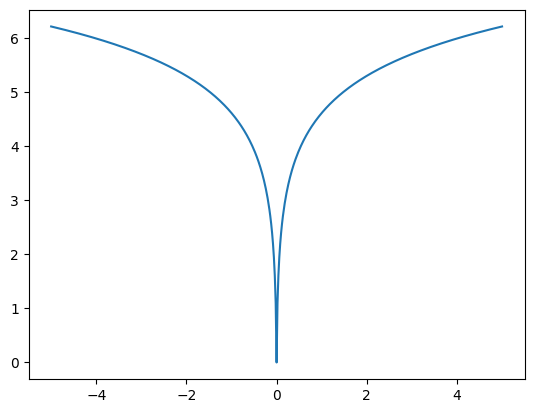

In [9]:
_ = tf.linspace(-5., 5., 501)
plt.plot(_, tfc.PowerLawEntropyModel(0).penalty(_));


这种惩罚实际上是一种正则化损失（有时称为“权重损失”）。它是凹形的，顶点为零，这一事实鼓励权重稀疏。用于压缩权重的编码方案是 [Elias gamma 码](https://en.wikipedia.org/wiki/Elias_gamma_coding)，它为元素大小产生长度为 $ 1 + \lfloor \log_2 |x| \rfloor $ 比特的编码。也就是说，它与惩罚相匹配，并应用惩罚从而最小化预期的代码长度。

In [10]:
class PowerLawRegularizer(tf.keras.regularizers.Regularizer):

  def __init__(self, lmbda):
    super().__init__()
    self.lmbda = lmbda

  def __call__(self, variable):
    em = tfc.PowerLawEntropyModel(coding_rank=variable.shape.rank)
    return self.lmbda * em.penalty(variable)

# Normalizing the weight of the penalty by the number of model parameters is a
# good rule of thumb to produce comparable results across models.
regularizer = PowerLawRegularizer(lmbda=2./classifier.count_params())


其次，定义 `CustomDense` 和 `CustomConv2D` 的子类，它们具有以下附加功能：

- 它们接受上述 Regularizer 的一个实例，并将其应用于训练期间的内核和偏差。
- 它们将内核和偏差定义为 `@property`，每当访问变量时，它们都会使用直通梯度执行量化。这准确地反映了稍后在压缩模型中执行的计算。
- 它们定义了额外的 `log_step` 变量，代表量化步长的对数。量化越粗，模型越小，但准确率越低。每个模型参数的量化步长都可训练，因此对惩罚损失函数执行优化将确定最佳量化步长。

量化步长定义如下：

In [11]:
def quantize(latent, log_step):
  step = tf.exp(log_step)
  return tfc.round_st(latent / step) * step


有了它，我们可以定义密集层：

In [12]:
class CompressibleDense(CustomDense):

  def __init__(self, regularizer, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.regularizer = regularizer

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    super().build(input_shape, other=other)
    if other is not None and hasattr(other, "kernel_log_step"):
      kernel_log_step = other.kernel_log_step
      bias_log_step = other.bias_log_step
    else:
      kernel_log_step = bias_log_step = -4.
    self.kernel_log_step = tf.Variable(
        tf.cast(kernel_log_step, self.variable_dtype), name="kernel_log_step")
    self.bias_log_step = tf.Variable(
        tf.cast(bias_log_step, self.variable_dtype), name="bias_log_step")
    self.add_loss(lambda: self.regularizer(
        self.kernel_latent / tf.exp(self.kernel_log_step)))
    self.add_loss(lambda: self.regularizer(
        self.bias_latent / tf.exp(self.bias_log_step)))

  @property
  def kernel(self):
    return quantize(self.kernel_latent, self.kernel_log_step)

  @kernel.setter
  def kernel(self, kernel):
    self.kernel_latent = tf.Variable(kernel, name="kernel_latent")

  @property
  def bias(self):
    return quantize(self.bias_latent, self.bias_log_step)

  @bias.setter
  def bias(self, bias):
    self.bias_latent = tf.Variable(bias, name="bias_latent")


卷积层类似。此外，只要设置了卷积核，就会将卷积核作为其实值离散傅里叶变换 (RDFT) 存储，并且每当使用该核时，变换都会被反转。由于内核的不同频率分量往往或多或少是可压缩的，因此其中的每个分量都被分配了自己的量化步长。

按如下方式定义傅里叶变换及其逆变换：

In [13]:
def to_rdft(kernel, kernel_size):
  # The kernel has shape (H, W, I, O) -> transpose to take DFT over last two
  # dimensions.
  kernel = tf.transpose(kernel, (2, 3, 0, 1))
  # The RDFT has type complex64 and shape (I, O, FH, FW).
  kernel_rdft = tf.signal.rfft2d(kernel)
  # Map real and imaginary parts into regular floats. The result is float32
  # and has shape (I, O, FH, FW, 2).
  kernel_rdft = tf.stack(
      [tf.math.real(kernel_rdft), tf.math.imag(kernel_rdft)], axis=-1)
  # Divide by kernel size to make the DFT orthonormal (length-preserving).
  return kernel_rdft / kernel_size

def from_rdft(kernel_rdft, kernel_size):
  # Undoes the transformations in to_rdft.
  kernel_rdft *= kernel_size
  kernel_rdft = tf.dtypes.complex(*tf.unstack(kernel_rdft, axis=-1))
  kernel = tf.signal.irfft2d(kernel_rdft, fft_length=2 * (kernel_size,))
  return tf.transpose(kernel, (2, 3, 0, 1))


这样，将卷积层定义为：

In [14]:
class CompressibleConv2D(CustomConv2D):

  def __init__(self, regularizer, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.regularizer = regularizer

  def build(self, input_shape, other=None):
    """Instantiates weights, optionally initializing them from `other`."""
    super().build(input_shape, other=other)
    if other is not None and hasattr(other, "kernel_log_step"):
      kernel_log_step = other.kernel_log_step
      bias_log_step = other.bias_log_step
    else:
      kernel_log_step = tf.fill(self.kernel_latent.shape[2:], -4.)
      bias_log_step = -4.
    self.kernel_log_step = tf.Variable(
        tf.cast(kernel_log_step, self.variable_dtype), name="kernel_log_step")
    self.bias_log_step = tf.Variable(
        tf.cast(bias_log_step, self.variable_dtype), name="bias_log_step")
    self.add_loss(lambda: self.regularizer(
        self.kernel_latent / tf.exp(self.kernel_log_step)))
    self.add_loss(lambda: self.regularizer(
        self.bias_latent / tf.exp(self.bias_log_step)))

  @property
  def kernel(self):
    kernel_rdft = quantize(self.kernel_latent, self.kernel_log_step)
    return from_rdft(kernel_rdft, self.kernel_size)

  @kernel.setter
  def kernel(self, kernel):
    kernel_rdft = to_rdft(kernel, self.kernel_size)
    self.kernel_latent = tf.Variable(kernel_rdft, name="kernel_latent")

  @property
  def bias(self):
    return quantize(self.bias_latent, self.bias_log_step)

  @bias.setter
  def bias(self, bias):
    self.bias_latent = tf.Variable(bias, name="bias_latent")


使用与上面相同的架构定义分类器模型，但使用以下修改后的层：

In [15]:
def make_mnist_classifier(regularizer):
  return tf.keras.Sequential([
      CompressibleConv2D(regularizer, 20, 5, strides=2, name="conv_1"),
      CompressibleConv2D(regularizer, 50, 5, strides=2, name="conv_2"),
      tf.keras.layers.Flatten(),
      CompressibleDense(regularizer, 500, name="fc_1"),
      CompressibleDense(regularizer, 10, name="fc_2"),
  ], name="classifier")

compressible_classifier = make_mnist_classifier(regularizer)


并训练模型：

In [16]:
penalized_accuracy = train_model(
    compressible_classifier, training_dataset, validation_dataset)

print(f"Accuracy: {penalized_accuracy:0.4f}")


Epoch 1/5


  1/469 [..............................] - ETA: 21:08 - loss: 11.3940 - sparse_categorical_accuracy: 0.0469

  2/469 [..............................] - ETA: 53s - loss: 11.2935 - sparse_categorical_accuracy: 0.1367  

  3/469 [..............................] - ETA: 53s - loss: 11.1894 - sparse_categorical_accuracy: 0.1667

  4/469 [..............................] - ETA: 53s - loss: 11.0900 - sparse_categorical_accuracy: 0.2246

  5/469 [..............................] - ETA: 53s - loss: 10.9856 - sparse_categorical_accuracy: 0.2688

  6/469 [..............................] - ETA: 53s - loss: 10.8821 - sparse_categorical_accuracy: 0.3073

  7/469 [..............................] - ETA: 53s - loss: 10.7655 - sparse_categorical_accuracy: 0.3460

  8/469 [..............................] - ETA: 53s - loss: 10.6453 - sparse_categorical_accuracy: 0.3848

  9/469 [..............................] - ETA: 53s - loss: 10.5160 - sparse_categorical_accuracy: 0.4210

 10/469 [..............................] - ETA: 53s - loss: 10.3889 - sparse_categorical_accuracy: 0.4484

 11/469 [..............................] - ETA: 53s - loss: 10.2497 - sparse_categorical_accuracy: 0.4773

 12/469 [..............................] - ETA: 52s - loss: 10.1139 - sparse_categorical_accuracy: 0.5013

 13/469 [..............................] - ETA: 52s - loss: 9.9896 - sparse_categorical_accuracy: 0.5198 

 14/469 [..............................] - ETA: 52s - loss: 9.8668 - sparse_categorical_accuracy: 0.5363

 15/469 [..............................] - ETA: 52s - loss: 9.7492 - sparse_categorical_accuracy: 0.5505

 16/469 [>.............................] - ETA: 52s - loss: 9.6353 - sparse_categorical_accuracy: 0.5635

 17/469 [>.............................] - ETA: 52s - loss: 9.5170 - sparse_categorical_accuracy: 0.5809

 18/469 [>.............................] - ETA: 52s - loss: 9.4100 - sparse_categorical_accuracy: 0.5946

 19/469 [>.............................] - ETA: 52s - loss: 9.3162 - sparse_categorical_accuracy: 0.6061

 20/469 [>.............................] - ETA: 52s - loss: 9.2260 - sparse_categorical_accuracy: 0.6137

 21/469 [>.............................] - ETA: 51s - loss: 9.1402 - sparse_categorical_accuracy: 0.6231

 22/469 [>.............................] - ETA: 51s - loss: 9.0588 - sparse_categorical_accuracy: 0.6307

 23/469 [>.............................] - ETA: 51s - loss: 8.9732 - sparse_categorical_accuracy: 0.6403

 24/469 [>.............................] - ETA: 51s - loss: 8.9011 - sparse_categorical_accuracy: 0.6488

 25/469 [>.............................] - ETA: 51s - loss: 8.8342 - sparse_categorical_accuracy: 0.6538

 26/469 [>.............................] - ETA: 51s - loss: 8.7635 - sparse_categorical_accuracy: 0.6608

 27/469 [>.............................] - ETA: 51s - loss: 8.7004 - sparse_categorical_accuracy: 0.6658

 28/469 [>.............................] - ETA: 50s - loss: 8.6341 - sparse_categorical_accuracy: 0.6724

 29/469 [>.............................] - ETA: 50s - loss: 8.5691 - sparse_categorical_accuracy: 0.6791

 30/469 [>.............................] - ETA: 50s - loss: 8.5024 - sparse_categorical_accuracy: 0.6857

 31/469 [>.............................] - ETA: 50s - loss: 8.4404 - sparse_categorical_accuracy: 0.6920

 32/469 [=>............................] - ETA: 50s - loss: 8.3794 - sparse_categorical_accuracy: 0.6985

 33/469 [=>............................] - ETA: 50s - loss: 8.3201 - sparse_categorical_accuracy: 0.7045

 34/469 [=>............................] - ETA: 50s - loss: 8.2610 - sparse_categorical_accuracy: 0.7102

 35/469 [=>............................] - ETA: 50s - loss: 8.2042 - sparse_categorical_accuracy: 0.7161

 36/469 [=>............................] - ETA: 49s - loss: 8.1489 - sparse_categorical_accuracy: 0.7216

 37/469 [=>............................] - ETA: 49s - loss: 8.0999 - sparse_categorical_accuracy: 0.7251

 38/469 [=>............................] - ETA: 49s - loss: 8.0547 - sparse_categorical_accuracy: 0.7274

 39/469 [=>............................] - ETA: 49s - loss: 8.0092 - sparse_categorical_accuracy: 0.7306

 40/469 [=>............................] - ETA: 49s - loss: 7.9670 - sparse_categorical_accuracy: 0.7334

 41/469 [=>............................] - ETA: 49s - loss: 7.9198 - sparse_categorical_accuracy: 0.7372

 42/469 [=>............................] - ETA: 49s - loss: 7.8727 - sparse_categorical_accuracy: 0.7409

 43/469 [=>............................] - ETA: 49s - loss: 7.8289 - sparse_categorical_accuracy: 0.7445

 44/469 [=>............................] - ETA: 48s - loss: 7.7885 - sparse_categorical_accuracy: 0.7475

 45/469 [=>............................] - ETA: 48s - loss: 7.7434 - sparse_categorical_accuracy: 0.7519

 46/469 [=>............................] - ETA: 48s - loss: 7.7024 - sparse_categorical_accuracy: 0.7553

 47/469 [==>...........................] - ETA: 48s - loss: 7.6616 - sparse_categorical_accuracy: 0.7581

 48/469 [==>...........................] - ETA: 48s - loss: 7.6226 - sparse_categorical_accuracy: 0.7609

 49/469 [==>...........................] - ETA: 48s - loss: 7.5870 - sparse_categorical_accuracy: 0.7636

 50/469 [==>...........................] - ETA: 48s - loss: 7.5501 - sparse_categorical_accuracy: 0.7659

 51/469 [==>...........................] - ETA: 48s - loss: 7.5143 - sparse_categorical_accuracy: 0.7687

 52/469 [==>...........................] - ETA: 48s - loss: 7.4812 - sparse_categorical_accuracy: 0.7706

 53/469 [==>...........................] - ETA: 47s - loss: 7.4450 - sparse_categorical_accuracy: 0.7733

 54/469 [==>...........................] - ETA: 47s - loss: 7.4121 - sparse_categorical_accuracy: 0.7749

 55/469 [==>...........................] - ETA: 47s - loss: 7.3786 - sparse_categorical_accuracy: 0.7771

 56/469 [==>...........................] - ETA: 47s - loss: 7.3435 - sparse_categorical_accuracy: 0.7797

 57/469 [==>...........................] - ETA: 47s - loss: 7.3125 - sparse_categorical_accuracy: 0.7819

 58/469 [==>...........................] - ETA: 47s - loss: 7.2816 - sparse_categorical_accuracy: 0.7839

 59/469 [==>...........................] - ETA: 47s - loss: 7.2496 - sparse_categorical_accuracy: 0.7864

 60/469 [==>...........................] - ETA: 47s - loss: 7.2185 - sparse_categorical_accuracy: 0.7885

 61/469 [==>...........................] - ETA: 47s - loss: 7.1917 - sparse_categorical_accuracy: 0.7898

 62/469 [==>...........................] - ETA: 47s - loss: 7.1628 - sparse_categorical_accuracy: 0.7916

 63/469 [===>..........................] - ETA: 46s - loss: 7.1354 - sparse_categorical_accuracy: 0.7935

 64/469 [===>..........................] - ETA: 46s - loss: 7.1063 - sparse_categorical_accuracy: 0.7954

 65/469 [===>..........................] - ETA: 46s - loss: 7.0772 - sparse_categorical_accuracy: 0.7976

 66/469 [===>..........................] - ETA: 46s - loss: 7.0487 - sparse_categorical_accuracy: 0.7996

 67/469 [===>..........................] - ETA: 46s - loss: 7.0211 - sparse_categorical_accuracy: 0.8017

 68/469 [===>..........................] - ETA: 46s - loss: 6.9956 - sparse_categorical_accuracy: 0.8025

 69/469 [===>..........................] - ETA: 46s - loss: 6.9700 - sparse_categorical_accuracy: 0.8042

 70/469 [===>..........................] - ETA: 46s - loss: 6.9445 - sparse_categorical_accuracy: 0.8060

 71/469 [===>..........................] - ETA: 45s - loss: 6.9197 - sparse_categorical_accuracy: 0.8079

 72/469 [===>..........................] - ETA: 45s - loss: 6.8958 - sparse_categorical_accuracy: 0.8095

 73/469 [===>..........................] - ETA: 45s - loss: 6.8702 - sparse_categorical_accuracy: 0.8112

 74/469 [===>..........................] - ETA: 45s - loss: 6.8463 - sparse_categorical_accuracy: 0.8122

 75/469 [===>..........................] - ETA: 45s - loss: 6.8222 - sparse_categorical_accuracy: 0.8135

 76/469 [===>..........................] - ETA: 45s - loss: 6.7988 - sparse_categorical_accuracy: 0.8151

 77/469 [===>..........................] - ETA: 45s - loss: 6.7772 - sparse_categorical_accuracy: 0.8162

 78/469 [===>..........................] - ETA: 45s - loss: 6.7535 - sparse_categorical_accuracy: 0.8178

 79/469 [====>.........................] - ETA: 45s - loss: 6.7311 - sparse_categorical_accuracy: 0.8188

 80/469 [====>.........................] - ETA: 44s - loss: 6.7098 - sparse_categorical_accuracy: 0.8197

 81/469 [====>.........................] - ETA: 44s - loss: 6.6871 - sparse_categorical_accuracy: 0.8213

 82/469 [====>.........................] - ETA: 44s - loss: 6.6664 - sparse_categorical_accuracy: 0.8222

 83/469 [====>.........................] - ETA: 44s - loss: 6.6465 - sparse_categorical_accuracy: 0.8230

 84/469 [====>.........................] - ETA: 44s - loss: 6.6250 - sparse_categorical_accuracy: 0.8243

 85/469 [====>.........................] - ETA: 44s - loss: 6.6049 - sparse_categorical_accuracy: 0.8255

 86/469 [====>.........................] - ETA: 44s - loss: 6.5856 - sparse_categorical_accuracy: 0.8264

 87/469 [====>.........................] - ETA: 44s - loss: 6.5653 - sparse_categorical_accuracy: 0.8274

 88/469 [====>.........................] - ETA: 44s - loss: 6.5450 - sparse_categorical_accuracy: 0.8286

 89/469 [====>.........................] - ETA: 43s - loss: 6.5260 - sparse_categorical_accuracy: 0.8294

 90/469 [====>.........................] - ETA: 43s - loss: 6.5060 - sparse_categorical_accuracy: 0.8306

 91/469 [====>.........................] - ETA: 43s - loss: 6.4873 - sparse_categorical_accuracy: 0.8314

 92/469 [====>.........................] - ETA: 43s - loss: 6.4685 - sparse_categorical_accuracy: 0.8324

 93/469 [====>.........................] - ETA: 43s - loss: 6.4507 - sparse_categorical_accuracy: 0.8334

 94/469 [=====>........................] - ETA: 43s - loss: 6.4322 - sparse_categorical_accuracy: 0.8343

 95/469 [=====>........................] - ETA: 43s - loss: 6.4161 - sparse_categorical_accuracy: 0.8350

 96/469 [=====>........................] - ETA: 43s - loss: 6.3988 - sparse_categorical_accuracy: 0.8357

 97/469 [=====>........................] - ETA: 43s - loss: 6.3815 - sparse_categorical_accuracy: 0.8365

 98/469 [=====>........................] - ETA: 42s - loss: 6.3629 - sparse_categorical_accuracy: 0.8377

 99/469 [=====>........................] - ETA: 42s - loss: 6.3451 - sparse_categorical_accuracy: 0.8388

100/469 [=====>........................] - ETA: 42s - loss: 6.3281 - sparse_categorical_accuracy: 0.8398

101/469 [=====>........................] - ETA: 42s - loss: 6.3107 - sparse_categorical_accuracy: 0.8406

102/469 [=====>........................] - ETA: 42s - loss: 6.2942 - sparse_categorical_accuracy: 0.8411

103/469 [=====>........................] - ETA: 42s - loss: 6.2780 - sparse_categorical_accuracy: 0.8416

104/469 [=====>........................] - ETA: 42s - loss: 6.2619 - sparse_categorical_accuracy: 0.8423

105/469 [=====>........................] - ETA: 42s - loss: 6.2452 - sparse_categorical_accuracy: 0.8432

106/469 [=====>........................] - ETA: 41s - loss: 6.2298 - sparse_categorical_accuracy: 0.8440

107/469 [=====>........................] - ETA: 41s - loss: 6.2140 - sparse_categorical_accuracy: 0.8450

108/469 [=====>........................] - ETA: 41s - loss: 6.1986 - sparse_categorical_accuracy: 0.8456

109/469 [=====>........................] - ETA: 41s - loss: 6.1833 - sparse_categorical_accuracy: 0.8460

110/469 [======>.......................] - ETA: 41s - loss: 6.1690 - sparse_categorical_accuracy: 0.8466

111/469 [======>.......................] - ETA: 41s - loss: 6.1544 - sparse_categorical_accuracy: 0.8471

112/469 [======>.......................] - ETA: 41s - loss: 6.1391 - sparse_categorical_accuracy: 0.8479

113/469 [======>.......................] - ETA: 41s - loss: 6.1245 - sparse_categorical_accuracy: 0.8486

114/469 [======>.......................] - ETA: 41s - loss: 6.1099 - sparse_categorical_accuracy: 0.8491

115/469 [======>.......................] - ETA: 40s - loss: 6.0964 - sparse_categorical_accuracy: 0.8495

116/469 [======>.......................] - ETA: 40s - loss: 6.0811 - sparse_categorical_accuracy: 0.8504

117/469 [======>.......................] - ETA: 40s - loss: 6.0667 - sparse_categorical_accuracy: 0.8511

118/469 [======>.......................] - ETA: 40s - loss: 6.0523 - sparse_categorical_accuracy: 0.8516

119/469 [======>.......................] - ETA: 40s - loss: 6.0386 - sparse_categorical_accuracy: 0.8523

120/469 [======>.......................] - ETA: 40s - loss: 6.0249 - sparse_categorical_accuracy: 0.8529

121/469 [======>.......................] - ETA: 40s - loss: 6.0107 - sparse_categorical_accuracy: 0.8537

122/469 [======>.......................] - ETA: 40s - loss: 5.9969 - sparse_categorical_accuracy: 0.8543

123/469 [======>.......................] - ETA: 40s - loss: 5.9831 - sparse_categorical_accuracy: 0.8549

124/469 [======>.......................] - ETA: 39s - loss: 5.9703 - sparse_categorical_accuracy: 0.8554

125/469 [======>.......................] - ETA: 39s - loss: 5.9562 - sparse_categorical_accuracy: 0.8562

126/469 [=======>......................] - ETA: 39s - loss: 5.9433 - sparse_categorical_accuracy: 0.8565

127/469 [=======>......................] - ETA: 39s - loss: 5.9298 - sparse_categorical_accuracy: 0.8570

128/469 [=======>......................] - ETA: 39s - loss: 5.9165 - sparse_categorical_accuracy: 0.8578

129/469 [=======>......................] - ETA: 39s - loss: 5.9049 - sparse_categorical_accuracy: 0.8582

130/469 [=======>......................] - ETA: 39s - loss: 5.8914 - sparse_categorical_accuracy: 0.8590

131/469 [=======>......................] - ETA: 39s - loss: 5.8779 - sparse_categorical_accuracy: 0.8599

132/469 [=======>......................] - ETA: 38s - loss: 5.8651 - sparse_categorical_accuracy: 0.8603

133/469 [=======>......................] - ETA: 38s - loss: 5.8536 - sparse_categorical_accuracy: 0.8607

134/469 [=======>......................] - ETA: 38s - loss: 5.8416 - sparse_categorical_accuracy: 0.8609

135/469 [=======>......................] - ETA: 38s - loss: 5.8295 - sparse_categorical_accuracy: 0.8612

136/469 [=======>......................] - ETA: 38s - loss: 5.8172 - sparse_categorical_accuracy: 0.8619

137/469 [=======>......................] - ETA: 38s - loss: 5.8052 - sparse_categorical_accuracy: 0.8623

138/469 [=======>......................] - ETA: 38s - loss: 5.7934 - sparse_categorical_accuracy: 0.8627

139/469 [=======>......................] - ETA: 38s - loss: 5.7819 - sparse_categorical_accuracy: 0.8630

140/469 [=======>......................] - ETA: 38s - loss: 5.7695 - sparse_categorical_accuracy: 0.8636

141/469 [========>.....................] - ETA: 37s - loss: 5.7579 - sparse_categorical_accuracy: 0.8638

142/469 [========>.....................] - ETA: 37s - loss: 5.7462 - sparse_categorical_accuracy: 0.8643

143/469 [========>.....................] - ETA: 37s - loss: 5.7345 - sparse_categorical_accuracy: 0.8646

144/469 [========>.....................] - ETA: 37s - loss: 5.7236 - sparse_categorical_accuracy: 0.8647

145/469 [========>.....................] - ETA: 37s - loss: 5.7125 - sparse_categorical_accuracy: 0.8649

146/469 [========>.....................] - ETA: 37s - loss: 5.7006 - sparse_categorical_accuracy: 0.8655

147/469 [========>.....................] - ETA: 37s - loss: 5.6884 - sparse_categorical_accuracy: 0.8663

148/469 [========>.....................] - ETA: 37s - loss: 5.6777 - sparse_categorical_accuracy: 0.8666

149/469 [========>.....................] - ETA: 37s - loss: 5.6660 - sparse_categorical_accuracy: 0.8672

150/469 [========>.....................] - ETA: 36s - loss: 5.6545 - sparse_categorical_accuracy: 0.8676

151/469 [========>.....................] - ETA: 36s - loss: 5.6433 - sparse_categorical_accuracy: 0.8682

152/469 [========>.....................] - ETA: 36s - loss: 5.6323 - sparse_categorical_accuracy: 0.8687

153/469 [========>.....................] - ETA: 36s - loss: 5.6214 - sparse_categorical_accuracy: 0.8692

154/469 [========>.....................] - ETA: 36s - loss: 5.6107 - sparse_categorical_accuracy: 0.8694

155/469 [========>.....................] - ETA: 36s - loss: 5.5995 - sparse_categorical_accuracy: 0.8699

156/469 [========>.....................] - ETA: 36s - loss: 5.5883 - sparse_categorical_accuracy: 0.8705

157/469 [=========>....................] - ETA: 36s - loss: 5.5775 - sparse_categorical_accuracy: 0.8711

158/469 [=========>....................] - ETA: 35s - loss: 5.5670 - sparse_categorical_accuracy: 0.8717

159/469 [=========>....................] - ETA: 35s - loss: 5.5563 - sparse_categorical_accuracy: 0.8722

160/469 [=========>....................] - ETA: 35s - loss: 5.5455 - sparse_categorical_accuracy: 0.8728

161/469 [=========>....................] - ETA: 35s - loss: 5.5351 - sparse_categorical_accuracy: 0.8732

162/469 [=========>....................] - ETA: 35s - loss: 5.5251 - sparse_categorical_accuracy: 0.8736

163/469 [=========>....................] - ETA: 35s - loss: 5.5154 - sparse_categorical_accuracy: 0.8738

164/469 [=========>....................] - ETA: 35s - loss: 5.5049 - sparse_categorical_accuracy: 0.8744

165/469 [=========>....................] - ETA: 35s - loss: 5.4956 - sparse_categorical_accuracy: 0.8747

166/469 [=========>....................] - ETA: 35s - loss: 5.4860 - sparse_categorical_accuracy: 0.8750

167/469 [=========>....................] - ETA: 34s - loss: 5.4757 - sparse_categorical_accuracy: 0.8756

168/469 [=========>....................] - ETA: 34s - loss: 5.4656 - sparse_categorical_accuracy: 0.8759

169/469 [=========>....................] - ETA: 34s - loss: 5.4556 - sparse_categorical_accuracy: 0.8764

170/469 [=========>....................] - ETA: 34s - loss: 5.4456 - sparse_categorical_accuracy: 0.8770

171/469 [=========>....................] - ETA: 34s - loss: 5.4358 - sparse_categorical_accuracy: 0.8774

172/469 [==========>...................] - ETA: 34s - loss: 5.4257 - sparse_categorical_accuracy: 0.8780

173/469 [==========>...................] - ETA: 34s - loss: 5.4160 - sparse_categorical_accuracy: 0.8784

174/469 [==========>...................] - ETA: 34s - loss: 5.4072 - sparse_categorical_accuracy: 0.8785

175/469 [==========>...................] - ETA: 33s - loss: 5.3979 - sparse_categorical_accuracy: 0.8788

176/469 [==========>...................] - ETA: 33s - loss: 5.3882 - sparse_categorical_accuracy: 0.8793

177/469 [==========>...................] - ETA: 33s - loss: 5.3789 - sparse_categorical_accuracy: 0.8797

178/469 [==========>...................] - ETA: 33s - loss: 5.3698 - sparse_categorical_accuracy: 0.8799

179/469 [==========>...................] - ETA: 33s - loss: 5.3609 - sparse_categorical_accuracy: 0.8802

180/469 [==========>...................] - ETA: 33s - loss: 5.3522 - sparse_categorical_accuracy: 0.8805

181/469 [==========>...................] - ETA: 33s - loss: 5.3435 - sparse_categorical_accuracy: 0.8806

182/469 [==========>...................] - ETA: 33s - loss: 5.3341 - sparse_categorical_accuracy: 0.8811

183/469 [==========>...................] - ETA: 33s - loss: 5.3251 - sparse_categorical_accuracy: 0.8814

184/469 [==========>...................] - ETA: 32s - loss: 5.3160 - sparse_categorical_accuracy: 0.8818

185/469 [==========>...................] - ETA: 32s - loss: 5.3070 - sparse_categorical_accuracy: 0.8822

186/469 [==========>...................] - ETA: 32s - loss: 5.2981 - sparse_categorical_accuracy: 0.8825

187/469 [==========>...................] - ETA: 32s - loss: 5.2895 - sparse_categorical_accuracy: 0.8827

188/469 [===========>..................] - ETA: 32s - loss: 5.2809 - sparse_categorical_accuracy: 0.8830

189/469 [===========>..................] - ETA: 32s - loss: 5.2721 - sparse_categorical_accuracy: 0.8834

190/469 [===========>..................] - ETA: 32s - loss: 5.2634 - sparse_categorical_accuracy: 0.8837

191/469 [===========>..................] - ETA: 32s - loss: 5.2549 - sparse_categorical_accuracy: 0.8840

192/469 [===========>..................] - ETA: 32s - loss: 5.2465 - sparse_categorical_accuracy: 0.8842

193/469 [===========>..................] - ETA: 31s - loss: 5.2378 - sparse_categorical_accuracy: 0.8846

194/469 [===========>..................] - ETA: 31s - loss: 5.2297 - sparse_categorical_accuracy: 0.8849

195/469 [===========>..................] - ETA: 31s - loss: 5.2215 - sparse_categorical_accuracy: 0.8850

196/469 [===========>..................] - ETA: 31s - loss: 5.2129 - sparse_categorical_accuracy: 0.8854

197/469 [===========>..................] - ETA: 31s - loss: 5.2044 - sparse_categorical_accuracy: 0.8857

198/469 [===========>..................] - ETA: 31s - loss: 5.1959 - sparse_categorical_accuracy: 0.8860

199/469 [===========>..................] - ETA: 31s - loss: 5.1880 - sparse_categorical_accuracy: 0.8862

200/469 [===========>..................] - ETA: 31s - loss: 5.1796 - sparse_categorical_accuracy: 0.8865

201/469 [===========>..................] - ETA: 30s - loss: 5.1715 - sparse_categorical_accuracy: 0.8867

202/469 [===========>..................] - ETA: 30s - loss: 5.1633 - sparse_categorical_accuracy: 0.8870

203/469 [===========>..................] - ETA: 30s - loss: 5.1551 - sparse_categorical_accuracy: 0.8873

204/469 [============>.................] - ETA: 30s - loss: 5.1469 - sparse_categorical_accuracy: 0.8876

205/469 [============>.................] - ETA: 30s - loss: 5.1387 - sparse_categorical_accuracy: 0.8879

206/469 [============>.................] - ETA: 30s - loss: 5.1304 - sparse_categorical_accuracy: 0.8882

207/469 [============>.................] - ETA: 30s - loss: 5.1228 - sparse_categorical_accuracy: 0.8884

208/469 [============>.................] - ETA: 30s - loss: 5.1148 - sparse_categorical_accuracy: 0.8887

209/469 [============>.................] - ETA: 30s - loss: 5.1067 - sparse_categorical_accuracy: 0.8891

210/469 [============>.................] - ETA: 29s - loss: 5.0991 - sparse_categorical_accuracy: 0.8893

211/469 [============>.................] - ETA: 29s - loss: 5.0918 - sparse_categorical_accuracy: 0.8894

212/469 [============>.................] - ETA: 29s - loss: 5.0840 - sparse_categorical_accuracy: 0.8897

213/469 [============>.................] - ETA: 29s - loss: 5.0765 - sparse_categorical_accuracy: 0.8899

214/469 [============>.................] - ETA: 29s - loss: 5.0692 - sparse_categorical_accuracy: 0.8902

215/469 [============>.................] - ETA: 29s - loss: 5.0615 - sparse_categorical_accuracy: 0.8906

216/469 [============>.................] - ETA: 29s - loss: 5.0546 - sparse_categorical_accuracy: 0.8908

217/469 [============>.................] - ETA: 29s - loss: 5.0470 - sparse_categorical_accuracy: 0.8910

218/469 [============>.................] - ETA: 28s - loss: 5.0393 - sparse_categorical_accuracy: 0.8913

219/469 [=============>................] - ETA: 28s - loss: 5.0317 - sparse_categorical_accuracy: 0.8917

220/469 [=============>................] - ETA: 28s - loss: 5.0239 - sparse_categorical_accuracy: 0.8921

221/469 [=============>................] - ETA: 28s - loss: 5.0168 - sparse_categorical_accuracy: 0.8923

222/469 [=============>................] - ETA: 28s - loss: 5.0092 - sparse_categorical_accuracy: 0.8926

223/469 [=============>................] - ETA: 28s - loss: 5.0022 - sparse_categorical_accuracy: 0.8926

224/469 [=============>................] - ETA: 28s - loss: 4.9947 - sparse_categorical_accuracy: 0.8929

225/469 [=============>................] - ETA: 28s - loss: 4.9872 - sparse_categorical_accuracy: 0.8931

226/469 [=============>................] - ETA: 28s - loss: 4.9800 - sparse_categorical_accuracy: 0.8934

227/469 [=============>................] - ETA: 27s - loss: 4.9728 - sparse_categorical_accuracy: 0.8936

228/469 [=============>................] - ETA: 27s - loss: 4.9661 - sparse_categorical_accuracy: 0.8934

229/469 [=============>................] - ETA: 27s - loss: 4.9588 - sparse_categorical_accuracy: 0.8937

230/469 [=============>................] - ETA: 27s - loss: 4.9516 - sparse_categorical_accuracy: 0.8940

231/469 [=============>................] - ETA: 27s - loss: 4.9443 - sparse_categorical_accuracy: 0.8942

232/469 [=============>................] - ETA: 27s - loss: 4.9371 - sparse_categorical_accuracy: 0.8944

233/469 [=============>................] - ETA: 27s - loss: 4.9299 - sparse_categorical_accuracy: 0.8948

234/469 [=============>................] - ETA: 27s - loss: 4.9232 - sparse_categorical_accuracy: 0.8949

235/469 [==============>...............] - ETA: 27s - loss: 4.9169 - sparse_categorical_accuracy: 0.8949

236/469 [==============>...............] - ETA: 26s - loss: 4.9102 - sparse_categorical_accuracy: 0.8949

237/469 [==============>...............] - ETA: 26s - loss: 4.9036 - sparse_categorical_accuracy: 0.8950

238/469 [==============>...............] - ETA: 26s - loss: 4.8965 - sparse_categorical_accuracy: 0.8953

239/469 [==============>...............] - ETA: 26s - loss: 4.8897 - sparse_categorical_accuracy: 0.8955

240/469 [==============>...............] - ETA: 26s - loss: 4.8828 - sparse_categorical_accuracy: 0.8957

241/469 [==============>...............] - ETA: 26s - loss: 4.8764 - sparse_categorical_accuracy: 0.8958

242/469 [==============>...............] - ETA: 26s - loss: 4.8695 - sparse_categorical_accuracy: 0.8960

243/469 [==============>...............] - ETA: 26s - loss: 4.8633 - sparse_categorical_accuracy: 0.8961

244/469 [==============>...............] - ETA: 25s - loss: 4.8568 - sparse_categorical_accuracy: 0.8962

245/469 [==============>...............] - ETA: 25s - loss: 4.8508 - sparse_categorical_accuracy: 0.8962

246/469 [==============>...............] - ETA: 25s - loss: 4.8439 - sparse_categorical_accuracy: 0.8965

247/469 [==============>...............] - ETA: 25s - loss: 4.8372 - sparse_categorical_accuracy: 0.8968

248/469 [==============>...............] - ETA: 25s - loss: 4.8304 - sparse_categorical_accuracy: 0.8971

249/469 [==============>...............] - ETA: 25s - loss: 4.8239 - sparse_categorical_accuracy: 0.8973

250/469 [==============>...............] - ETA: 25s - loss: 4.8172 - sparse_categorical_accuracy: 0.8976

251/469 [===============>..............] - ETA: 25s - loss: 4.8105 - sparse_categorical_accuracy: 0.8978

252/469 [===============>..............] - ETA: 25s - loss: 4.8042 - sparse_categorical_accuracy: 0.8979

253/469 [===============>..............] - ETA: 24s - loss: 4.7976 - sparse_categorical_accuracy: 0.8982

254/469 [===============>..............] - ETA: 24s - loss: 4.7909 - sparse_categorical_accuracy: 0.8985

255/469 [===============>..............] - ETA: 24s - loss: 4.7843 - sparse_categorical_accuracy: 0.8988

256/469 [===============>..............] - ETA: 24s - loss: 4.7775 - sparse_categorical_accuracy: 0.8991

257/469 [===============>..............] - ETA: 24s - loss: 4.7710 - sparse_categorical_accuracy: 0.8993

258/469 [===============>..............] - ETA: 24s - loss: 4.7646 - sparse_categorical_accuracy: 0.8996

259/469 [===============>..............] - ETA: 24s - loss: 4.7581 - sparse_categorical_accuracy: 0.8999

260/469 [===============>..............] - ETA: 24s - loss: 4.7517 - sparse_categorical_accuracy: 0.9000

261/469 [===============>..............] - ETA: 24s - loss: 4.7453 - sparse_categorical_accuracy: 0.9002

262/469 [===============>..............] - ETA: 23s - loss: 4.7397 - sparse_categorical_accuracy: 0.9003

263/469 [===============>..............] - ETA: 23s - loss: 4.7335 - sparse_categorical_accuracy: 0.9006

264/469 [===============>..............] - ETA: 23s - loss: 4.7273 - sparse_categorical_accuracy: 0.9007

265/469 [===============>..............] - ETA: 23s - loss: 4.7210 - sparse_categorical_accuracy: 0.9010

266/469 [================>.............] - ETA: 23s - loss: 4.7146 - sparse_categorical_accuracy: 0.9013

267/469 [================>.............] - ETA: 23s - loss: 4.7082 - sparse_categorical_accuracy: 0.9015

268/469 [================>.............] - ETA: 23s - loss: 4.7020 - sparse_categorical_accuracy: 0.9017

269/469 [================>.............] - ETA: 23s - loss: 4.6959 - sparse_categorical_accuracy: 0.9018

270/469 [================>.............] - ETA: 22s - loss: 4.6895 - sparse_categorical_accuracy: 0.9022

271/469 [================>.............] - ETA: 22s - loss: 4.6834 - sparse_categorical_accuracy: 0.9023

272/469 [================>.............] - ETA: 22s - loss: 4.6773 - sparse_categorical_accuracy: 0.9025

273/469 [================>.............] - ETA: 22s - loss: 4.6713 - sparse_categorical_accuracy: 0.9027

274/469 [================>.............] - ETA: 22s - loss: 4.6651 - sparse_categorical_accuracy: 0.9028

275/469 [================>.............] - ETA: 22s - loss: 4.6591 - sparse_categorical_accuracy: 0.9030

276/469 [================>.............] - ETA: 22s - loss: 4.6530 - sparse_categorical_accuracy: 0.9032

277/469 [================>.............] - ETA: 22s - loss: 4.6470 - sparse_categorical_accuracy: 0.9034

278/469 [================>.............] - ETA: 22s - loss: 4.6413 - sparse_categorical_accuracy: 0.9036

279/469 [================>.............] - ETA: 21s - loss: 4.6356 - sparse_categorical_accuracy: 0.9037

280/469 [================>.............] - ETA: 21s - loss: 4.6298 - sparse_categorical_accuracy: 0.9039

281/469 [================>.............] - ETA: 21s - loss: 4.6241 - sparse_categorical_accuracy: 0.9040

282/469 [=================>............] - ETA: 21s - loss: 4.6180 - sparse_categorical_accuracy: 0.9042

283/469 [=================>............] - ETA: 21s - loss: 4.6119 - sparse_categorical_accuracy: 0.9045

284/469 [=================>............] - ETA: 21s - loss: 4.6064 - sparse_categorical_accuracy: 0.9047

285/469 [=================>............] - ETA: 21s - loss: 4.6007 - sparse_categorical_accuracy: 0.9048

286/469 [=================>............] - ETA: 21s - loss: 4.5948 - sparse_categorical_accuracy: 0.9050

287/469 [=================>............] - ETA: 21s - loss: 4.5889 - sparse_categorical_accuracy: 0.9052

288/469 [=================>............] - ETA: 20s - loss: 4.5833 - sparse_categorical_accuracy: 0.9053

289/469 [=================>............] - ETA: 20s - loss: 4.5775 - sparse_categorical_accuracy: 0.9054

290/469 [=================>............] - ETA: 20s - loss: 4.5721 - sparse_categorical_accuracy: 0.9055

291/469 [=================>............] - ETA: 20s - loss: 4.5663 - sparse_categorical_accuracy: 0.9057

292/469 [=================>............] - ETA: 20s - loss: 4.5608 - sparse_categorical_accuracy: 0.9058

293/469 [=================>............] - ETA: 20s - loss: 4.5554 - sparse_categorical_accuracy: 0.9060

294/469 [=================>............] - ETA: 20s - loss: 4.5498 - sparse_categorical_accuracy: 0.9061

295/469 [=================>............] - ETA: 20s - loss: 4.5442 - sparse_categorical_accuracy: 0.9063

296/469 [=================>............] - ETA: 19s - loss: 4.5389 - sparse_categorical_accuracy: 0.9064

297/469 [=================>............] - ETA: 19s - loss: 4.5333 - sparse_categorical_accuracy: 0.9066

298/469 [==================>...........] - ETA: 19s - loss: 4.5278 - sparse_categorical_accuracy: 0.9067

299/469 [==================>...........] - ETA: 19s - loss: 4.5223 - sparse_categorical_accuracy: 0.9069

300/469 [==================>...........] - ETA: 19s - loss: 4.5167 - sparse_categorical_accuracy: 0.9071

301/469 [==================>...........] - ETA: 19s - loss: 4.5113 - sparse_categorical_accuracy: 0.9073

302/469 [==================>...........] - ETA: 19s - loss: 4.5057 - sparse_categorical_accuracy: 0.9075

303/469 [==================>...........] - ETA: 19s - loss: 4.5002 - sparse_categorical_accuracy: 0.9077

304/469 [==================>...........] - ETA: 19s - loss: 4.4949 - sparse_categorical_accuracy: 0.9078

305/469 [==================>...........] - ETA: 18s - loss: 4.4896 - sparse_categorical_accuracy: 0.9080

306/469 [==================>...........] - ETA: 18s - loss: 4.4840 - sparse_categorical_accuracy: 0.9083

307/469 [==================>...........] - ETA: 18s - loss: 4.4787 - sparse_categorical_accuracy: 0.9084

308/469 [==================>...........] - ETA: 18s - loss: 4.4737 - sparse_categorical_accuracy: 0.9086

309/469 [==================>...........] - ETA: 18s - loss: 4.4683 - sparse_categorical_accuracy: 0.9088

310/469 [==================>...........] - ETA: 18s - loss: 4.4629 - sparse_categorical_accuracy: 0.9090

311/469 [==================>...........] - ETA: 18s - loss: 4.4577 - sparse_categorical_accuracy: 0.9091

312/469 [==================>...........] - ETA: 18s - loss: 4.4523 - sparse_categorical_accuracy: 0.9092

313/469 [===================>..........] - ETA: 18s - loss: 4.4471 - sparse_categorical_accuracy: 0.9094

314/469 [===================>..........] - ETA: 17s - loss: 4.4420 - sparse_categorical_accuracy: 0.9095

315/469 [===================>..........] - ETA: 17s - loss: 4.4367 - sparse_categorical_accuracy: 0.9097

316/469 [===================>..........] - ETA: 17s - loss: 4.4318 - sparse_categorical_accuracy: 0.9097

317/469 [===================>..........] - ETA: 17s - loss: 4.4266 - sparse_categorical_accuracy: 0.9099

318/469 [===================>..........] - ETA: 17s - loss: 4.4213 - sparse_categorical_accuracy: 0.9101

319/469 [===================>..........] - ETA: 17s - loss: 4.4161 - sparse_categorical_accuracy: 0.9103

320/469 [===================>..........] - ETA: 17s - loss: 4.4108 - sparse_categorical_accuracy: 0.9105

321/469 [===================>..........] - ETA: 17s - loss: 4.4055 - sparse_categorical_accuracy: 0.9107

322/469 [===================>..........] - ETA: 16s - loss: 4.4010 - sparse_categorical_accuracy: 0.9107

323/469 [===================>..........] - ETA: 16s - loss: 4.3957 - sparse_categorical_accuracy: 0.9109

324/469 [===================>..........] - ETA: 16s - loss: 4.3910 - sparse_categorical_accuracy: 0.9110

325/469 [===================>..........] - ETA: 16s - loss: 4.3858 - sparse_categorical_accuracy: 0.9112

326/469 [===================>..........] - ETA: 16s - loss: 4.3809 - sparse_categorical_accuracy: 0.9113

327/469 [===================>..........] - ETA: 16s - loss: 4.3757 - sparse_categorical_accuracy: 0.9115

328/469 [===================>..........] - ETA: 16s - loss: 4.3706 - sparse_categorical_accuracy: 0.9116

329/469 [====================>.........] - ETA: 16s - loss: 4.3656 - sparse_categorical_accuracy: 0.9117

330/469 [====================>.........] - ETA: 16s - loss: 4.3606 - sparse_categorical_accuracy: 0.9119

331/469 [====================>.........] - ETA: 15s - loss: 4.3554 - sparse_categorical_accuracy: 0.9122

332/469 [====================>.........] - ETA: 15s - loss: 4.3505 - sparse_categorical_accuracy: 0.9123

333/469 [====================>.........] - ETA: 15s - loss: 4.3455 - sparse_categorical_accuracy: 0.9124

334/469 [====================>.........] - ETA: 15s - loss: 4.3408 - sparse_categorical_accuracy: 0.9125

335/469 [====================>.........] - ETA: 15s - loss: 4.3357 - sparse_categorical_accuracy: 0.9127

336/469 [====================>.........] - ETA: 15s - loss: 4.3307 - sparse_categorical_accuracy: 0.9129

337/469 [====================>.........] - ETA: 15s - loss: 4.3259 - sparse_categorical_accuracy: 0.9130

338/469 [====================>.........] - ETA: 15s - loss: 4.3210 - sparse_categorical_accuracy: 0.9131

339/469 [====================>.........] - ETA: 14s - loss: 4.3160 - sparse_categorical_accuracy: 0.9133

340/469 [====================>.........] - ETA: 14s - loss: 4.3110 - sparse_categorical_accuracy: 0.9136

341/469 [====================>.........] - ETA: 14s - loss: 4.3060 - sparse_categorical_accuracy: 0.9138

342/469 [====================>.........] - ETA: 14s - loss: 4.3012 - sparse_categorical_accuracy: 0.9139

343/469 [====================>.........] - ETA: 14s - loss: 4.2963 - sparse_categorical_accuracy: 0.9140

344/469 [=====================>........] - ETA: 14s - loss: 4.2913 - sparse_categorical_accuracy: 0.9142

345/469 [=====================>........] - ETA: 14s - loss: 4.2866 - sparse_categorical_accuracy: 0.9143

346/469 [=====================>........] - ETA: 14s - loss: 4.2820 - sparse_categorical_accuracy: 0.9144

347/469 [=====================>........] - ETA: 14s - loss: 4.2771 - sparse_categorical_accuracy: 0.9146

348/469 [=====================>........] - ETA: 13s - loss: 4.2722 - sparse_categorical_accuracy: 0.9148

349/469 [=====================>........] - ETA: 13s - loss: 4.2674 - sparse_categorical_accuracy: 0.9149

350/469 [=====================>........] - ETA: 13s - loss: 4.2627 - sparse_categorical_accuracy: 0.9150

351/469 [=====================>........] - ETA: 13s - loss: 4.2578 - sparse_categorical_accuracy: 0.9152

352/469 [=====================>........] - ETA: 13s - loss: 4.2532 - sparse_categorical_accuracy: 0.9153

353/469 [=====================>........] - ETA: 13s - loss: 4.2487 - sparse_categorical_accuracy: 0.9155

354/469 [=====================>........] - ETA: 13s - loss: 4.2444 - sparse_categorical_accuracy: 0.9155

355/469 [=====================>........] - ETA: 13s - loss: 4.2398 - sparse_categorical_accuracy: 0.9156

356/469 [=====================>........] - ETA: 13s - loss: 4.2351 - sparse_categorical_accuracy: 0.9157

357/469 [=====================>........] - ETA: 12s - loss: 4.2308 - sparse_categorical_accuracy: 0.9158

358/469 [=====================>........] - ETA: 12s - loss: 4.2263 - sparse_categorical_accuracy: 0.9159

359/469 [=====================>........] - ETA: 12s - loss: 4.2218 - sparse_categorical_accuracy: 0.9160

360/469 [======================>.......] - ETA: 12s - loss: 4.2171 - sparse_categorical_accuracy: 0.9161

361/469 [======================>.......] - ETA: 12s - loss: 4.2125 - sparse_categorical_accuracy: 0.9163

362/469 [======================>.......] - ETA: 12s - loss: 4.2083 - sparse_categorical_accuracy: 0.9163

363/469 [======================>.......] - ETA: 12s - loss: 4.2037 - sparse_categorical_accuracy: 0.9165

364/469 [======================>.......] - ETA: 12s - loss: 4.1992 - sparse_categorical_accuracy: 0.9166

365/469 [======================>.......] - ETA: 11s - loss: 4.1947 - sparse_categorical_accuracy: 0.9168

366/469 [======================>.......] - ETA: 11s - loss: 4.1902 - sparse_categorical_accuracy: 0.9169

367/469 [======================>.......] - ETA: 11s - loss: 4.1856 - sparse_categorical_accuracy: 0.9171

368/469 [======================>.......] - ETA: 11s - loss: 4.1811 - sparse_categorical_accuracy: 0.9172

369/469 [======================>.......] - ETA: 11s - loss: 4.1768 - sparse_categorical_accuracy: 0.9173

370/469 [======================>.......] - ETA: 11s - loss: 4.1725 - sparse_categorical_accuracy: 0.9174

371/469 [======================>.......] - ETA: 11s - loss: 4.1685 - sparse_categorical_accuracy: 0.9174

372/469 [======================>.......] - ETA: 11s - loss: 4.1640 - sparse_categorical_accuracy: 0.9176

373/469 [======================>.......] - ETA: 11s - loss: 4.1596 - sparse_categorical_accuracy: 0.9178

374/469 [======================>.......] - ETA: 10s - loss: 4.1554 - sparse_categorical_accuracy: 0.9178

375/469 [======================>.......] - ETA: 10s - loss: 4.1510 - sparse_categorical_accuracy: 0.9180

376/469 [=======================>......] - ETA: 10s - loss: 4.1466 - sparse_categorical_accuracy: 0.9181

377/469 [=======================>......] - ETA: 10s - loss: 4.1422 - sparse_categorical_accuracy: 0.9182

378/469 [=======================>......] - ETA: 10s - loss: 4.1379 - sparse_categorical_accuracy: 0.9183

379/469 [=======================>......] - ETA: 10s - loss: 4.1335 - sparse_categorical_accuracy: 0.9184

380/469 [=======================>......] - ETA: 10s - loss: 4.1292 - sparse_categorical_accuracy: 0.9186

381/469 [=======================>......] - ETA: 10s - loss: 4.1248 - sparse_categorical_accuracy: 0.9187

382/469 [=======================>......] - ETA: 10s - loss: 4.1203 - sparse_categorical_accuracy: 0.9189

383/469 [=======================>......] - ETA: 9s - loss: 4.1160 - sparse_categorical_accuracy: 0.9190 

384/469 [=======================>......] - ETA: 9s - loss: 4.1117 - sparse_categorical_accuracy: 0.9191

385/469 [=======================>......] - ETA: 9s - loss: 4.1073 - sparse_categorical_accuracy: 0.9193

386/469 [=======================>......] - ETA: 9s - loss: 4.1031 - sparse_categorical_accuracy: 0.9194

387/469 [=======================>......] - ETA: 9s - loss: 4.0990 - sparse_categorical_accuracy: 0.9195

388/469 [=======================>......] - ETA: 9s - loss: 4.0948 - sparse_categorical_accuracy: 0.9196

389/469 [=======================>......] - ETA: 9s - loss: 4.0906 - sparse_categorical_accuracy: 0.9197

390/469 [=======================>......] - ETA: 9s - loss: 4.0863 - sparse_categorical_accuracy: 0.9199

391/469 [========================>.....] - ETA: 8s - loss: 4.0819 - sparse_categorical_accuracy: 0.9201

392/469 [========================>.....] - ETA: 8s - loss: 4.0778 - sparse_categorical_accuracy: 0.9201

393/469 [========================>.....] - ETA: 8s - loss: 4.0735 - sparse_categorical_accuracy: 0.9203

394/469 [========================>.....] - ETA: 8s - loss: 4.0693 - sparse_categorical_accuracy: 0.9204

395/469 [========================>.....] - ETA: 8s - loss: 4.0651 - sparse_categorical_accuracy: 0.9205

396/469 [========================>.....] - ETA: 8s - loss: 4.0611 - sparse_categorical_accuracy: 0.9206

397/469 [========================>.....] - ETA: 8s - loss: 4.0569 - sparse_categorical_accuracy: 0.9208

398/469 [========================>.....] - ETA: 8s - loss: 4.0527 - sparse_categorical_accuracy: 0.9209

399/469 [========================>.....] - ETA: 8s - loss: 4.0486 - sparse_categorical_accuracy: 0.9210

400/469 [========================>.....] - ETA: 7s - loss: 4.0445 - sparse_categorical_accuracy: 0.9211

401/469 [========================>.....] - ETA: 7s - loss: 4.0406 - sparse_categorical_accuracy: 0.9212

402/469 [========================>.....] - ETA: 7s - loss: 4.0364 - sparse_categorical_accuracy: 0.9214

403/469 [========================>.....] - ETA: 7s - loss: 4.0324 - sparse_categorical_accuracy: 0.9214

404/469 [========================>.....] - ETA: 7s - loss: 4.0283 - sparse_categorical_accuracy: 0.9216

405/469 [========================>.....] - ETA: 7s - loss: 4.0243 - sparse_categorical_accuracy: 0.9217

406/469 [========================>.....] - ETA: 7s - loss: 4.0202 - sparse_categorical_accuracy: 0.9219

407/469 [=========================>....] - ETA: 7s - loss: 4.0161 - sparse_categorical_accuracy: 0.9220

408/469 [=========================>....] - ETA: 7s - loss: 4.0120 - sparse_categorical_accuracy: 0.9221

409/469 [=========================>....] - ETA: 6s - loss: 4.0080 - sparse_categorical_accuracy: 0.9223

410/469 [=========================>....] - ETA: 6s - loss: 4.0041 - sparse_categorical_accuracy: 0.9224

411/469 [=========================>....] - ETA: 6s - loss: 4.0002 - sparse_categorical_accuracy: 0.9225

412/469 [=========================>....] - ETA: 6s - loss: 3.9963 - sparse_categorical_accuracy: 0.9226

413/469 [=========================>....] - ETA: 6s - loss: 3.9927 - sparse_categorical_accuracy: 0.9226

414/469 [=========================>....] - ETA: 6s - loss: 3.9887 - sparse_categorical_accuracy: 0.9227

415/469 [=========================>....] - ETA: 6s - loss: 3.9848 - sparse_categorical_accuracy: 0.9228

416/469 [=========================>....] - ETA: 6s - loss: 3.9810 - sparse_categorical_accuracy: 0.9229

417/469 [=========================>....] - ETA: 5s - loss: 3.9772 - sparse_categorical_accuracy: 0.9229

418/469 [=========================>....] - ETA: 5s - loss: 3.9733 - sparse_categorical_accuracy: 0.9230

419/469 [=========================>....] - ETA: 5s - loss: 3.9694 - sparse_categorical_accuracy: 0.9231

420/469 [=========================>....] - ETA: 5s - loss: 3.9656 - sparse_categorical_accuracy: 0.9232

421/469 [=========================>....] - ETA: 5s - loss: 3.9617 - sparse_categorical_accuracy: 0.9233

422/469 [=========================>....] - ETA: 5s - loss: 3.9579 - sparse_categorical_accuracy: 0.9234

423/469 [==========================>...] - ETA: 5s - loss: 3.9540 - sparse_categorical_accuracy: 0.9235

424/469 [==========================>...] - ETA: 5s - loss: 3.9502 - sparse_categorical_accuracy: 0.9236

425/469 [==========================>...] - ETA: 5s - loss: 3.9464 - sparse_categorical_accuracy: 0.9237

426/469 [==========================>...] - ETA: 4s - loss: 3.9425 - sparse_categorical_accuracy: 0.9238

427/469 [==========================>...] - ETA: 4s - loss: 3.9389 - sparse_categorical_accuracy: 0.9239

428/469 [==========================>...] - ETA: 4s - loss: 3.9352 - sparse_categorical_accuracy: 0.9240

429/469 [==========================>...] - ETA: 4s - loss: 3.9316 - sparse_categorical_accuracy: 0.9240

430/469 [==========================>...] - ETA: 4s - loss: 3.9279 - sparse_categorical_accuracy: 0.9241

431/469 [==========================>...] - ETA: 4s - loss: 3.9243 - sparse_categorical_accuracy: 0.9242

432/469 [==========================>...] - ETA: 4s - loss: 3.9205 - sparse_categorical_accuracy: 0.9243

433/469 [==========================>...] - ETA: 4s - loss: 3.9166 - sparse_categorical_accuracy: 0.9245

434/469 [==========================>...] - ETA: 4s - loss: 3.9127 - sparse_categorical_accuracy: 0.9246

435/469 [==========================>...] - ETA: 3s - loss: 3.9090 - sparse_categorical_accuracy: 0.9247

436/469 [==========================>...] - ETA: 3s - loss: 3.9053 - sparse_categorical_accuracy: 0.9248

437/469 [==========================>...] - ETA: 3s - loss: 3.9016 - sparse_categorical_accuracy: 0.9249

438/469 [===========================>..] - ETA: 3s - loss: 3.8980 - sparse_categorical_accuracy: 0.9249

439/469 [===========================>..] - ETA: 3s - loss: 3.8943 - sparse_categorical_accuracy: 0.9250

440/469 [===========================>..] - ETA: 3s - loss: 3.8905 - sparse_categorical_accuracy: 0.9251

441/469 [===========================>..] - ETA: 3s - loss: 3.8868 - sparse_categorical_accuracy: 0.9252

442/469 [===========================>..] - ETA: 3s - loss: 3.8831 - sparse_categorical_accuracy: 0.9253

443/469 [===========================>..] - ETA: 2s - loss: 3.8794 - sparse_categorical_accuracy: 0.9254

444/469 [===========================>..] - ETA: 2s - loss: 3.8758 - sparse_categorical_accuracy: 0.9254

445/469 [===========================>..] - ETA: 2s - loss: 3.8721 - sparse_categorical_accuracy: 0.9256

446/469 [===========================>..] - ETA: 2s - loss: 3.8683 - sparse_categorical_accuracy: 0.9257

447/469 [===========================>..] - ETA: 2s - loss: 3.8647 - sparse_categorical_accuracy: 0.9258

448/469 [===========================>..] - ETA: 2s - loss: 3.8610 - sparse_categorical_accuracy: 0.9260

449/469 [===========================>..] - ETA: 2s - loss: 3.8574 - sparse_categorical_accuracy: 0.9261

450/469 [===========================>..] - ETA: 2s - loss: 3.8538 - sparse_categorical_accuracy: 0.9261

451/469 [===========================>..] - ETA: 2s - loss: 3.8502 - sparse_categorical_accuracy: 0.9262

452/469 [===========================>..] - ETA: 1s - loss: 3.8465 - sparse_categorical_accuracy: 0.9263

453/469 [===========================>..] - ETA: 1s - loss: 3.8430 - sparse_categorical_accuracy: 0.9264

454/469 [============================>.] - ETA: 1s - loss: 3.8396 - sparse_categorical_accuracy: 0.9265

455/469 [============================>.] - ETA: 1s - loss: 3.8360 - sparse_categorical_accuracy: 0.9266

456/469 [============================>.] - ETA: 1s - loss: 3.8327 - sparse_categorical_accuracy: 0.9267

457/469 [============================>.] - ETA: 1s - loss: 3.8290 - sparse_categorical_accuracy: 0.9268

458/469 [============================>.] - ETA: 1s - loss: 3.8255 - sparse_categorical_accuracy: 0.9269

459/469 [============================>.] - ETA: 1s - loss: 3.8223 - sparse_categorical_accuracy: 0.9269

460/469 [============================>.] - ETA: 1s - loss: 3.8187 - sparse_categorical_accuracy: 0.9271

461/469 [============================>.] - ETA: 0s - loss: 3.8152 - sparse_categorical_accuracy: 0.9271

462/469 [============================>.] - ETA: 0s - loss: 3.8116 - sparse_categorical_accuracy: 0.9272

463/469 [============================>.] - ETA: 0s - loss: 3.8081 - sparse_categorical_accuracy: 0.9273

464/469 [============================>.] - ETA: 0s - loss: 3.8046 - sparse_categorical_accuracy: 0.9274

465/469 [============================>.] - ETA: 0s - loss: 3.8012 - sparse_categorical_accuracy: 0.9275

466/469 [============================>.] - ETA: 0s - loss: 3.7977 - sparse_categorical_accuracy: 0.9276

467/469 [============================>.] - ETA: 0s - loss: 3.7945 - sparse_categorical_accuracy: 0.9276

468/469 [============================>.] - ETA: 0s - loss: 3.7911 - sparse_categorical_accuracy: 0.9277

469/469 [==============================] - ETA: 0s - loss: 3.7884 - sparse_categorical_accuracy: 0.9278

469/469 [==============================] - 58s 118ms/step - loss: 3.7884 - sparse_categorical_accuracy: 0.9278 - val_loss: 2.1724 - val_sparse_categorical_accuracy: 0.9730


Epoch 2/5


  1/469 [..............................] - ETA: 55s - loss: 2.1289 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 53s - loss: 2.1521 - sparse_categorical_accuracy: 0.9805

  3/469 [..............................] - ETA: 54s - loss: 2.1494 - sparse_categorical_accuracy: 0.9792

  4/469 [..............................] - ETA: 54s - loss: 2.1480 - sparse_categorical_accuracy: 0.9785

  5/469 [..............................] - ETA: 53s - loss: 2.1518 - sparse_categorical_accuracy: 0.9781

  6/469 [..............................] - ETA: 53s - loss: 2.1600 - sparse_categorical_accuracy: 0.9753

  7/469 [..............................] - ETA: 53s - loss: 2.1560 - sparse_categorical_accuracy: 0.9766

  8/469 [..............................] - ETA: 53s - loss: 2.1579 - sparse_categorical_accuracy: 0.9766

  9/469 [..............................] - ETA: 53s - loss: 2.1556 - sparse_categorical_accuracy: 0.9757

 10/469 [..............................] - ETA: 53s - loss: 2.1529 - sparse_categorical_accuracy: 0.9758

 11/469 [..............................] - ETA: 52s - loss: 2.1474 - sparse_categorical_accuracy: 0.9759

 12/469 [..............................] - ETA: 52s - loss: 2.1470 - sparse_categorical_accuracy: 0.9759

 13/469 [..............................] - ETA: 52s - loss: 2.1473 - sparse_categorical_accuracy: 0.9754

 14/469 [..............................] - ETA: 52s - loss: 2.1524 - sparse_categorical_accuracy: 0.9743

 15/469 [..............................] - ETA: 52s - loss: 2.1551 - sparse_categorical_accuracy: 0.9740

 16/469 [>.............................] - ETA: 52s - loss: 2.1560 - sparse_categorical_accuracy: 0.9736

 17/469 [>.............................] - ETA: 52s - loss: 2.1525 - sparse_categorical_accuracy: 0.9743

 18/469 [>.............................] - ETA: 52s - loss: 2.1558 - sparse_categorical_accuracy: 0.9731

 19/469 [>.............................] - ETA: 52s - loss: 2.1560 - sparse_categorical_accuracy: 0.9729

 20/469 [>.............................] - ETA: 52s - loss: 2.1551 - sparse_categorical_accuracy: 0.9730

 21/469 [>.............................] - ETA: 51s - loss: 2.1567 - sparse_categorical_accuracy: 0.9728

 22/469 [>.............................] - ETA: 51s - loss: 2.1586 - sparse_categorical_accuracy: 0.9719

 23/469 [>.............................] - ETA: 51s - loss: 2.1563 - sparse_categorical_accuracy: 0.9721

 24/469 [>.............................] - ETA: 51s - loss: 2.1606 - sparse_categorical_accuracy: 0.9707

 25/469 [>.............................] - ETA: 51s - loss: 2.1612 - sparse_categorical_accuracy: 0.9697

 26/469 [>.............................] - ETA: 51s - loss: 2.1596 - sparse_categorical_accuracy: 0.9703

 27/469 [>.............................] - ETA: 51s - loss: 2.1617 - sparse_categorical_accuracy: 0.9688

 28/469 [>.............................] - ETA: 51s - loss: 2.1597 - sparse_categorical_accuracy: 0.9685

 29/469 [>.............................] - ETA: 50s - loss: 2.1574 - sparse_categorical_accuracy: 0.9685

 30/469 [>.............................] - ETA: 50s - loss: 2.1565 - sparse_categorical_accuracy: 0.9688

 31/469 [>.............................] - ETA: 50s - loss: 2.1548 - sparse_categorical_accuracy: 0.9688

 32/469 [=>............................] - ETA: 50s - loss: 2.1539 - sparse_categorical_accuracy: 0.9680

 33/469 [=>............................] - ETA: 50s - loss: 2.1529 - sparse_categorical_accuracy: 0.9680

 34/469 [=>............................] - ETA: 50s - loss: 2.1518 - sparse_categorical_accuracy: 0.9683

 35/469 [=>............................] - ETA: 50s - loss: 2.1505 - sparse_categorical_accuracy: 0.9681

 36/469 [=>............................] - ETA: 50s - loss: 2.1486 - sparse_categorical_accuracy: 0.9681

 37/469 [=>............................] - ETA: 49s - loss: 2.1469 - sparse_categorical_accuracy: 0.9685

 38/469 [=>............................] - ETA: 49s - loss: 2.1466 - sparse_categorical_accuracy: 0.9683

 39/469 [=>............................] - ETA: 49s - loss: 2.1454 - sparse_categorical_accuracy: 0.9683

 40/469 [=>............................] - ETA: 49s - loss: 2.1440 - sparse_categorical_accuracy: 0.9686

 41/469 [=>............................] - ETA: 49s - loss: 2.1423 - sparse_categorical_accuracy: 0.9688

 42/469 [=>............................] - ETA: 49s - loss: 2.1408 - sparse_categorical_accuracy: 0.9684

 43/469 [=>............................] - ETA: 49s - loss: 2.1408 - sparse_categorical_accuracy: 0.9684

 44/469 [=>............................] - ETA: 49s - loss: 2.1395 - sparse_categorical_accuracy: 0.9680

 45/469 [=>............................] - ETA: 49s - loss: 2.1373 - sparse_categorical_accuracy: 0.9684

 46/469 [=>............................] - ETA: 48s - loss: 2.1361 - sparse_categorical_accuracy: 0.9686

 47/469 [==>...........................] - ETA: 48s - loss: 2.1333 - sparse_categorical_accuracy: 0.9689

 48/469 [==>...........................] - ETA: 48s - loss: 2.1307 - sparse_categorical_accuracy: 0.9696

 49/469 [==>...........................] - ETA: 48s - loss: 2.1304 - sparse_categorical_accuracy: 0.9691

 50/469 [==>...........................] - ETA: 48s - loss: 2.1288 - sparse_categorical_accuracy: 0.9691

 51/469 [==>...........................] - ETA: 48s - loss: 2.1275 - sparse_categorical_accuracy: 0.9689

 52/469 [==>...........................] - ETA: 48s - loss: 2.1262 - sparse_categorical_accuracy: 0.9689

 53/469 [==>...........................] - ETA: 48s - loss: 2.1243 - sparse_categorical_accuracy: 0.9693

 54/469 [==>...........................] - ETA: 47s - loss: 2.1222 - sparse_categorical_accuracy: 0.9695

 55/469 [==>...........................] - ETA: 47s - loss: 2.1203 - sparse_categorical_accuracy: 0.9696

 56/469 [==>...........................] - ETA: 47s - loss: 2.1179 - sparse_categorical_accuracy: 0.9697

 57/469 [==>...........................] - ETA: 47s - loss: 2.1172 - sparse_categorical_accuracy: 0.9697

 58/469 [==>...........................] - ETA: 47s - loss: 2.1153 - sparse_categorical_accuracy: 0.9698

 59/469 [==>...........................] - ETA: 47s - loss: 2.1135 - sparse_categorical_accuracy: 0.9699

 60/469 [==>...........................] - ETA: 47s - loss: 2.1118 - sparse_categorical_accuracy: 0.9701

 61/469 [==>...........................] - ETA: 47s - loss: 2.1105 - sparse_categorical_accuracy: 0.9698

 62/469 [==>...........................] - ETA: 47s - loss: 2.1098 - sparse_categorical_accuracy: 0.9696

 63/469 [===>..........................] - ETA: 46s - loss: 2.1085 - sparse_categorical_accuracy: 0.9695

 64/469 [===>..........................] - ETA: 46s - loss: 2.1066 - sparse_categorical_accuracy: 0.9696

 65/469 [===>..........................] - ETA: 46s - loss: 2.1047 - sparse_categorical_accuracy: 0.9697

 66/469 [===>..........................] - ETA: 46s - loss: 2.1031 - sparse_categorical_accuracy: 0.9698

 67/469 [===>..........................] - ETA: 46s - loss: 2.1015 - sparse_categorical_accuracy: 0.9698

 68/469 [===>..........................] - ETA: 46s - loss: 2.0997 - sparse_categorical_accuracy: 0.9697

 69/469 [===>..........................] - ETA: 46s - loss: 2.0978 - sparse_categorical_accuracy: 0.9699

 70/469 [===>..........................] - ETA: 46s - loss: 2.0959 - sparse_categorical_accuracy: 0.9699

 71/469 [===>..........................] - ETA: 46s - loss: 2.0944 - sparse_categorical_accuracy: 0.9701

 72/469 [===>..........................] - ETA: 45s - loss: 2.0929 - sparse_categorical_accuracy: 0.9702

 73/469 [===>..........................] - ETA: 45s - loss: 2.0909 - sparse_categorical_accuracy: 0.9702

 74/469 [===>..........................] - ETA: 45s - loss: 2.0888 - sparse_categorical_accuracy: 0.9704

 75/469 [===>..........................] - ETA: 45s - loss: 2.0879 - sparse_categorical_accuracy: 0.9703

 76/469 [===>..........................] - ETA: 45s - loss: 2.0860 - sparse_categorical_accuracy: 0.9704

 77/469 [===>..........................] - ETA: 45s - loss: 2.0853 - sparse_categorical_accuracy: 0.9703

 78/469 [===>..........................] - ETA: 45s - loss: 2.0832 - sparse_categorical_accuracy: 0.9706

 79/469 [====>.........................] - ETA: 45s - loss: 2.0814 - sparse_categorical_accuracy: 0.9706

 80/469 [====>.........................] - ETA: 45s - loss: 2.0801 - sparse_categorical_accuracy: 0.9705

 81/469 [====>.........................] - ETA: 44s - loss: 2.0785 - sparse_categorical_accuracy: 0.9704

 82/469 [====>.........................] - ETA: 44s - loss: 2.0769 - sparse_categorical_accuracy: 0.9706

 83/469 [====>.........................] - ETA: 44s - loss: 2.0755 - sparse_categorical_accuracy: 0.9706

 84/469 [====>.........................] - ETA: 44s - loss: 2.0741 - sparse_categorical_accuracy: 0.9706

 85/469 [====>.........................] - ETA: 44s - loss: 2.0725 - sparse_categorical_accuracy: 0.9706

 86/469 [====>.........................] - ETA: 44s - loss: 2.0709 - sparse_categorical_accuracy: 0.9707

 87/469 [====>.........................] - ETA: 44s - loss: 2.0693 - sparse_categorical_accuracy: 0.9705

 88/469 [====>.........................] - ETA: 44s - loss: 2.0678 - sparse_categorical_accuracy: 0.9706

 89/469 [====>.........................] - ETA: 43s - loss: 2.0666 - sparse_categorical_accuracy: 0.9705

 90/469 [====>.........................] - ETA: 43s - loss: 2.0645 - sparse_categorical_accuracy: 0.9707

 91/469 [====>.........................] - ETA: 43s - loss: 2.0631 - sparse_categorical_accuracy: 0.9709

 92/469 [====>.........................] - ETA: 43s - loss: 2.0611 - sparse_categorical_accuracy: 0.9711

 93/469 [====>.........................] - ETA: 43s - loss: 2.0609 - sparse_categorical_accuracy: 0.9709

 94/469 [=====>........................] - ETA: 43s - loss: 2.0593 - sparse_categorical_accuracy: 0.9709

 95/469 [=====>........................] - ETA: 43s - loss: 2.0581 - sparse_categorical_accuracy: 0.9709

 96/469 [=====>........................] - ETA: 43s - loss: 2.0573 - sparse_categorical_accuracy: 0.9707

 97/469 [=====>........................] - ETA: 43s - loss: 2.0559 - sparse_categorical_accuracy: 0.9706

 98/469 [=====>........................] - ETA: 42s - loss: 2.0541 - sparse_categorical_accuracy: 0.9707

 99/469 [=====>........................] - ETA: 42s - loss: 2.0523 - sparse_categorical_accuracy: 0.9710

100/469 [=====>........................] - ETA: 42s - loss: 2.0507 - sparse_categorical_accuracy: 0.9711

101/469 [=====>........................] - ETA: 42s - loss: 2.0487 - sparse_categorical_accuracy: 0.9713

102/469 [=====>........................] - ETA: 42s - loss: 2.0476 - sparse_categorical_accuracy: 0.9710

103/469 [=====>........................] - ETA: 42s - loss: 2.0460 - sparse_categorical_accuracy: 0.9710

104/469 [=====>........................] - ETA: 42s - loss: 2.0443 - sparse_categorical_accuracy: 0.9712

105/469 [=====>........................] - ETA: 42s - loss: 2.0424 - sparse_categorical_accuracy: 0.9713

106/469 [=====>........................] - ETA: 42s - loss: 2.0415 - sparse_categorical_accuracy: 0.9713

107/469 [=====>........................] - ETA: 41s - loss: 2.0397 - sparse_categorical_accuracy: 0.9715

108/469 [=====>........................] - ETA: 41s - loss: 2.0384 - sparse_categorical_accuracy: 0.9714

109/469 [=====>........................] - ETA: 41s - loss: 2.0372 - sparse_categorical_accuracy: 0.9712

110/469 [======>.......................] - ETA: 41s - loss: 2.0361 - sparse_categorical_accuracy: 0.9712

111/469 [======>.......................] - ETA: 41s - loss: 2.0343 - sparse_categorical_accuracy: 0.9714

112/469 [======>.......................] - ETA: 41s - loss: 2.0332 - sparse_categorical_accuracy: 0.9713

113/469 [======>.......................] - ETA: 41s - loss: 2.0321 - sparse_categorical_accuracy: 0.9714

114/469 [======>.......................] - ETA: 41s - loss: 2.0303 - sparse_categorical_accuracy: 0.9716

115/469 [======>.......................] - ETA: 41s - loss: 2.0293 - sparse_categorical_accuracy: 0.9715

116/469 [======>.......................] - ETA: 40s - loss: 2.0274 - sparse_categorical_accuracy: 0.9718

117/469 [======>.......................] - ETA: 40s - loss: 2.0259 - sparse_categorical_accuracy: 0.9718

118/469 [======>.......................] - ETA: 40s - loss: 2.0245 - sparse_categorical_accuracy: 0.9718

119/469 [======>.......................] - ETA: 40s - loss: 2.0227 - sparse_categorical_accuracy: 0.9719

120/469 [======>.......................] - ETA: 40s - loss: 2.0213 - sparse_categorical_accuracy: 0.9720

121/469 [======>.......................] - ETA: 40s - loss: 2.0202 - sparse_categorical_accuracy: 0.9720

122/469 [======>.......................] - ETA: 40s - loss: 2.0190 - sparse_categorical_accuracy: 0.9720

123/469 [======>.......................] - ETA: 40s - loss: 2.0174 - sparse_categorical_accuracy: 0.9721

124/469 [======>.......................] - ETA: 39s - loss: 2.0161 - sparse_categorical_accuracy: 0.9720

125/469 [======>.......................] - ETA: 39s - loss: 2.0144 - sparse_categorical_accuracy: 0.9721

126/469 [=======>......................] - ETA: 39s - loss: 2.0132 - sparse_categorical_accuracy: 0.9720

127/469 [=======>......................] - ETA: 39s - loss: 2.0116 - sparse_categorical_accuracy: 0.9721

128/469 [=======>......................] - ETA: 39s - loss: 2.0099 - sparse_categorical_accuracy: 0.9723

129/469 [=======>......................] - ETA: 39s - loss: 2.0091 - sparse_categorical_accuracy: 0.9723

130/469 [=======>......................] - ETA: 39s - loss: 2.0075 - sparse_categorical_accuracy: 0.9723

131/469 [=======>......................] - ETA: 39s - loss: 2.0058 - sparse_categorical_accuracy: 0.9724

132/469 [=======>......................] - ETA: 39s - loss: 2.0043 - sparse_categorical_accuracy: 0.9724

133/469 [=======>......................] - ETA: 38s - loss: 2.0035 - sparse_categorical_accuracy: 0.9722

134/469 [=======>......................] - ETA: 38s - loss: 2.0030 - sparse_categorical_accuracy: 0.9719

135/469 [=======>......................] - ETA: 38s - loss: 2.0016 - sparse_categorical_accuracy: 0.9718

136/469 [=======>......................] - ETA: 38s - loss: 2.0006 - sparse_categorical_accuracy: 0.9717

137/469 [=======>......................] - ETA: 38s - loss: 1.9997 - sparse_categorical_accuracy: 0.9718

138/469 [=======>......................] - ETA: 38s - loss: 1.9983 - sparse_categorical_accuracy: 0.9719

139/469 [=======>......................] - ETA: 38s - loss: 1.9970 - sparse_categorical_accuracy: 0.9719

140/469 [=======>......................] - ETA: 38s - loss: 1.9956 - sparse_categorical_accuracy: 0.9720

141/469 [========>.....................] - ETA: 37s - loss: 1.9942 - sparse_categorical_accuracy: 0.9721

142/469 [========>.....................] - ETA: 37s - loss: 1.9930 - sparse_categorical_accuracy: 0.9722

143/469 [========>.....................] - ETA: 37s - loss: 1.9915 - sparse_categorical_accuracy: 0.9723

144/469 [========>.....................] - ETA: 37s - loss: 1.9904 - sparse_categorical_accuracy: 0.9723

145/469 [========>.....................] - ETA: 37s - loss: 1.9892 - sparse_categorical_accuracy: 0.9723

146/469 [========>.....................] - ETA: 37s - loss: 1.9876 - sparse_categorical_accuracy: 0.9724

147/469 [========>.....................] - ETA: 37s - loss: 1.9860 - sparse_categorical_accuracy: 0.9726

148/469 [========>.....................] - ETA: 37s - loss: 1.9854 - sparse_categorical_accuracy: 0.9723

149/469 [========>.....................] - ETA: 37s - loss: 1.9839 - sparse_categorical_accuracy: 0.9724

150/469 [========>.....................] - ETA: 36s - loss: 1.9823 - sparse_categorical_accuracy: 0.9726

151/469 [========>.....................] - ETA: 36s - loss: 1.9810 - sparse_categorical_accuracy: 0.9726

152/469 [========>.....................] - ETA: 36s - loss: 1.9797 - sparse_categorical_accuracy: 0.9727

153/469 [========>.....................] - ETA: 36s - loss: 1.9781 - sparse_categorical_accuracy: 0.9728

154/469 [========>.....................] - ETA: 36s - loss: 1.9769 - sparse_categorical_accuracy: 0.9728

155/469 [========>.....................] - ETA: 36s - loss: 1.9754 - sparse_categorical_accuracy: 0.9729

156/469 [========>.....................] - ETA: 36s - loss: 1.9739 - sparse_categorical_accuracy: 0.9731

157/469 [=========>....................] - ETA: 36s - loss: 1.9728 - sparse_categorical_accuracy: 0.9730

158/469 [=========>....................] - ETA: 35s - loss: 1.9719 - sparse_categorical_accuracy: 0.9730

159/469 [=========>....................] - ETA: 35s - loss: 1.9704 - sparse_categorical_accuracy: 0.9731

160/469 [=========>....................] - ETA: 35s - loss: 1.9691 - sparse_categorical_accuracy: 0.9731

161/469 [=========>....................] - ETA: 35s - loss: 1.9679 - sparse_categorical_accuracy: 0.9731

162/469 [=========>....................] - ETA: 35s - loss: 1.9668 - sparse_categorical_accuracy: 0.9732

163/469 [=========>....................] - ETA: 35s - loss: 1.9657 - sparse_categorical_accuracy: 0.9732

164/469 [=========>....................] - ETA: 35s - loss: 1.9646 - sparse_categorical_accuracy: 0.9731

165/469 [=========>....................] - ETA: 35s - loss: 1.9635 - sparse_categorical_accuracy: 0.9730

166/469 [=========>....................] - ETA: 35s - loss: 1.9628 - sparse_categorical_accuracy: 0.9729

167/469 [=========>....................] - ETA: 34s - loss: 1.9614 - sparse_categorical_accuracy: 0.9730

168/469 [=========>....................] - ETA: 34s - loss: 1.9601 - sparse_categorical_accuracy: 0.9731

169/469 [=========>....................] - ETA: 34s - loss: 1.9587 - sparse_categorical_accuracy: 0.9732

170/469 [=========>....................] - ETA: 34s - loss: 1.9576 - sparse_categorical_accuracy: 0.9733

171/469 [=========>....................] - ETA: 34s - loss: 1.9564 - sparse_categorical_accuracy: 0.9734

172/469 [==========>...................] - ETA: 34s - loss: 1.9550 - sparse_categorical_accuracy: 0.9736

173/469 [==========>...................] - ETA: 34s - loss: 1.9538 - sparse_categorical_accuracy: 0.9736

174/469 [==========>...................] - ETA: 34s - loss: 1.9528 - sparse_categorical_accuracy: 0.9736

175/469 [==========>...................] - ETA: 34s - loss: 1.9516 - sparse_categorical_accuracy: 0.9736

176/469 [==========>...................] - ETA: 33s - loss: 1.9504 - sparse_categorical_accuracy: 0.9737

177/469 [==========>...................] - ETA: 33s - loss: 1.9495 - sparse_categorical_accuracy: 0.9737

178/469 [==========>...................] - ETA: 33s - loss: 1.9485 - sparse_categorical_accuracy: 0.9737

179/469 [==========>...................] - ETA: 33s - loss: 1.9475 - sparse_categorical_accuracy: 0.9737

180/469 [==========>...................] - ETA: 33s - loss: 1.9465 - sparse_categorical_accuracy: 0.9737

181/469 [==========>...................] - ETA: 33s - loss: 1.9452 - sparse_categorical_accuracy: 0.9738

182/469 [==========>...................] - ETA: 33s - loss: 1.9441 - sparse_categorical_accuracy: 0.9737

183/469 [==========>...................] - ETA: 33s - loss: 1.9428 - sparse_categorical_accuracy: 0.9738

184/469 [==========>...................] - ETA: 32s - loss: 1.9415 - sparse_categorical_accuracy: 0.9738

185/469 [==========>...................] - ETA: 32s - loss: 1.9404 - sparse_categorical_accuracy: 0.9739

186/469 [==========>...................] - ETA: 32s - loss: 1.9391 - sparse_categorical_accuracy: 0.9740

187/469 [==========>...................] - ETA: 32s - loss: 1.9381 - sparse_categorical_accuracy: 0.9739

188/469 [===========>..................] - ETA: 32s - loss: 1.9371 - sparse_categorical_accuracy: 0.9739

189/469 [===========>..................] - ETA: 32s - loss: 1.9359 - sparse_categorical_accuracy: 0.9740

190/469 [===========>..................] - ETA: 32s - loss: 1.9347 - sparse_categorical_accuracy: 0.9740

191/469 [===========>..................] - ETA: 32s - loss: 1.9336 - sparse_categorical_accuracy: 0.9739

192/469 [===========>..................] - ETA: 32s - loss: 1.9324 - sparse_categorical_accuracy: 0.9740

193/469 [===========>..................] - ETA: 31s - loss: 1.9312 - sparse_categorical_accuracy: 0.9740

194/469 [===========>..................] - ETA: 31s - loss: 1.9302 - sparse_categorical_accuracy: 0.9740

195/469 [===========>..................] - ETA: 31s - loss: 1.9289 - sparse_categorical_accuracy: 0.9741

196/469 [===========>..................] - ETA: 31s - loss: 1.9276 - sparse_categorical_accuracy: 0.9741

197/469 [===========>..................] - ETA: 31s - loss: 1.9264 - sparse_categorical_accuracy: 0.9741

198/469 [===========>..................] - ETA: 31s - loss: 1.9252 - sparse_categorical_accuracy: 0.9742

199/469 [===========>..................] - ETA: 31s - loss: 1.9240 - sparse_categorical_accuracy: 0.9742

200/469 [===========>..................] - ETA: 31s - loss: 1.9226 - sparse_categorical_accuracy: 0.9743

201/469 [===========>..................] - ETA: 31s - loss: 1.9215 - sparse_categorical_accuracy: 0.9743

202/469 [===========>..................] - ETA: 30s - loss: 1.9202 - sparse_categorical_accuracy: 0.9744

203/469 [===========>..................] - ETA: 30s - loss: 1.9189 - sparse_categorical_accuracy: 0.9744

204/469 [============>.................] - ETA: 30s - loss: 1.9175 - sparse_categorical_accuracy: 0.9745

205/469 [============>.................] - ETA: 30s - loss: 1.9162 - sparse_categorical_accuracy: 0.9746

206/469 [============>.................] - ETA: 30s - loss: 1.9147 - sparse_categorical_accuracy: 0.9747

207/469 [============>.................] - ETA: 30s - loss: 1.9137 - sparse_categorical_accuracy: 0.9746

208/469 [============>.................] - ETA: 30s - loss: 1.9124 - sparse_categorical_accuracy: 0.9746

209/469 [============>.................] - ETA: 30s - loss: 1.9110 - sparse_categorical_accuracy: 0.9747

210/469 [============>.................] - ETA: 29s - loss: 1.9099 - sparse_categorical_accuracy: 0.9746

211/469 [============>.................] - ETA: 29s - loss: 1.9087 - sparse_categorical_accuracy: 0.9747

212/469 [============>.................] - ETA: 29s - loss: 1.9074 - sparse_categorical_accuracy: 0.9747

213/469 [============>.................] - ETA: 29s - loss: 1.9064 - sparse_categorical_accuracy: 0.9747

214/469 [============>.................] - ETA: 29s - loss: 1.9055 - sparse_categorical_accuracy: 0.9746

215/469 [============>.................] - ETA: 29s - loss: 1.9044 - sparse_categorical_accuracy: 0.9746

216/469 [============>.................] - ETA: 29s - loss: 1.9035 - sparse_categorical_accuracy: 0.9745

217/469 [============>.................] - ETA: 29s - loss: 1.9024 - sparse_categorical_accuracy: 0.9744

218/469 [============>.................] - ETA: 29s - loss: 1.9010 - sparse_categorical_accuracy: 0.9745

219/469 [=============>................] - ETA: 28s - loss: 1.9000 - sparse_categorical_accuracy: 0.9745

220/469 [=============>................] - ETA: 28s - loss: 1.8987 - sparse_categorical_accuracy: 0.9746

221/469 [=============>................] - ETA: 28s - loss: 1.8978 - sparse_categorical_accuracy: 0.9745

222/469 [=============>................] - ETA: 28s - loss: 1.8965 - sparse_categorical_accuracy: 0.9745

223/469 [=============>................] - ETA: 28s - loss: 1.8955 - sparse_categorical_accuracy: 0.9746

224/469 [=============>................] - ETA: 28s - loss: 1.8943 - sparse_categorical_accuracy: 0.9746

225/469 [=============>................] - ETA: 28s - loss: 1.8930 - sparse_categorical_accuracy: 0.9747

226/469 [=============>................] - ETA: 28s - loss: 1.8918 - sparse_categorical_accuracy: 0.9748

227/469 [=============>................] - ETA: 28s - loss: 1.8906 - sparse_categorical_accuracy: 0.9748

228/469 [=============>................] - ETA: 27s - loss: 1.8899 - sparse_categorical_accuracy: 0.9746

229/469 [=============>................] - ETA: 27s - loss: 1.8889 - sparse_categorical_accuracy: 0.9746

230/469 [=============>................] - ETA: 27s - loss: 1.8879 - sparse_categorical_accuracy: 0.9746

231/469 [=============>................] - ETA: 27s - loss: 1.8867 - sparse_categorical_accuracy: 0.9746

232/469 [=============>................] - ETA: 27s - loss: 1.8855 - sparse_categorical_accuracy: 0.9747

233/469 [=============>................] - ETA: 27s - loss: 1.8845 - sparse_categorical_accuracy: 0.9747

234/469 [=============>................] - ETA: 27s - loss: 1.8835 - sparse_categorical_accuracy: 0.9747

235/469 [==============>...............] - ETA: 27s - loss: 1.8831 - sparse_categorical_accuracy: 0.9746

236/469 [==============>...............] - ETA: 26s - loss: 1.8822 - sparse_categorical_accuracy: 0.9745

237/469 [==============>...............] - ETA: 26s - loss: 1.8813 - sparse_categorical_accuracy: 0.9745

238/469 [==============>...............] - ETA: 26s - loss: 1.8802 - sparse_categorical_accuracy: 0.9746

239/469 [==============>...............] - ETA: 26s - loss: 1.8793 - sparse_categorical_accuracy: 0.9745

240/469 [==============>...............] - ETA: 26s - loss: 1.8781 - sparse_categorical_accuracy: 0.9746

241/469 [==============>...............] - ETA: 26s - loss: 1.8773 - sparse_categorical_accuracy: 0.9746

242/469 [==============>...............] - ETA: 26s - loss: 1.8764 - sparse_categorical_accuracy: 0.9747

243/469 [==============>...............] - ETA: 26s - loss: 1.8758 - sparse_categorical_accuracy: 0.9746

244/469 [==============>...............] - ETA: 26s - loss: 1.8748 - sparse_categorical_accuracy: 0.9745

245/469 [==============>...............] - ETA: 25s - loss: 1.8740 - sparse_categorical_accuracy: 0.9745

246/469 [==============>...............] - ETA: 25s - loss: 1.8729 - sparse_categorical_accuracy: 0.9746

247/469 [==============>...............] - ETA: 25s - loss: 1.8719 - sparse_categorical_accuracy: 0.9746

248/469 [==============>...............] - ETA: 25s - loss: 1.8708 - sparse_categorical_accuracy: 0.9746

249/469 [==============>...............] - ETA: 25s - loss: 1.8699 - sparse_categorical_accuracy: 0.9747

250/469 [==============>...............] - ETA: 25s - loss: 1.8689 - sparse_categorical_accuracy: 0.9747

251/469 [===============>..............] - ETA: 25s - loss: 1.8677 - sparse_categorical_accuracy: 0.9748

252/469 [===============>..............] - ETA: 25s - loss: 1.8668 - sparse_categorical_accuracy: 0.9747

253/469 [===============>..............] - ETA: 25s - loss: 1.8657 - sparse_categorical_accuracy: 0.9748

254/469 [===============>..............] - ETA: 24s - loss: 1.8645 - sparse_categorical_accuracy: 0.9748

255/469 [===============>..............] - ETA: 24s - loss: 1.8634 - sparse_categorical_accuracy: 0.9749

256/469 [===============>..............] - ETA: 24s - loss: 1.8621 - sparse_categorical_accuracy: 0.9750

257/469 [===============>..............] - ETA: 24s - loss: 1.8610 - sparse_categorical_accuracy: 0.9750

258/469 [===============>..............] - ETA: 24s - loss: 1.8597 - sparse_categorical_accuracy: 0.9751

259/469 [===============>..............] - ETA: 24s - loss: 1.8586 - sparse_categorical_accuracy: 0.9751

260/469 [===============>..............] - ETA: 24s - loss: 1.8574 - sparse_categorical_accuracy: 0.9751

261/469 [===============>..............] - ETA: 24s - loss: 1.8563 - sparse_categorical_accuracy: 0.9751

262/469 [===============>..............] - ETA: 23s - loss: 1.8556 - sparse_categorical_accuracy: 0.9750

263/469 [===============>..............] - ETA: 23s - loss: 1.8546 - sparse_categorical_accuracy: 0.9750

264/469 [===============>..............] - ETA: 23s - loss: 1.8538 - sparse_categorical_accuracy: 0.9750

265/469 [===============>..............] - ETA: 23s - loss: 1.8527 - sparse_categorical_accuracy: 0.9750

266/469 [================>.............] - ETA: 23s - loss: 1.8514 - sparse_categorical_accuracy: 0.9751

267/469 [================>.............] - ETA: 23s - loss: 1.8502 - sparse_categorical_accuracy: 0.9752

268/469 [================>.............] - ETA: 23s - loss: 1.8491 - sparse_categorical_accuracy: 0.9752

269/469 [================>.............] - ETA: 23s - loss: 1.8480 - sparse_categorical_accuracy: 0.9753

270/469 [================>.............] - ETA: 23s - loss: 1.8467 - sparse_categorical_accuracy: 0.9753

271/469 [================>.............] - ETA: 22s - loss: 1.8457 - sparse_categorical_accuracy: 0.9754

272/469 [================>.............] - ETA: 22s - loss: 1.8444 - sparse_categorical_accuracy: 0.9754

273/469 [================>.............] - ETA: 22s - loss: 1.8433 - sparse_categorical_accuracy: 0.9753

274/469 [================>.............] - ETA: 22s - loss: 1.8421 - sparse_categorical_accuracy: 0.9754

275/469 [================>.............] - ETA: 22s - loss: 1.8409 - sparse_categorical_accuracy: 0.9754

276/469 [================>.............] - ETA: 22s - loss: 1.8396 - sparse_categorical_accuracy: 0.9754

277/469 [================>.............] - ETA: 22s - loss: 1.8384 - sparse_categorical_accuracy: 0.9754

278/469 [================>.............] - ETA: 22s - loss: 1.8376 - sparse_categorical_accuracy: 0.9754

279/469 [================>.............] - ETA: 22s - loss: 1.8366 - sparse_categorical_accuracy: 0.9753

280/469 [================>.............] - ETA: 21s - loss: 1.8356 - sparse_categorical_accuracy: 0.9753

281/469 [================>.............] - ETA: 21s - loss: 1.8346 - sparse_categorical_accuracy: 0.9752

282/469 [=================>............] - ETA: 21s - loss: 1.8333 - sparse_categorical_accuracy: 0.9753

283/469 [=================>............] - ETA: 21s - loss: 1.8321 - sparse_categorical_accuracy: 0.9753

284/469 [=================>............] - ETA: 21s - loss: 1.8313 - sparse_categorical_accuracy: 0.9753

285/469 [=================>............] - ETA: 21s - loss: 1.8303 - sparse_categorical_accuracy: 0.9753

286/469 [=================>............] - ETA: 21s - loss: 1.8292 - sparse_categorical_accuracy: 0.9753

287/469 [=================>............] - ETA: 21s - loss: 1.8282 - sparse_categorical_accuracy: 0.9753

288/469 [=================>............] - ETA: 20s - loss: 1.8273 - sparse_categorical_accuracy: 0.9753

289/469 [=================>............] - ETA: 20s - loss: 1.8262 - sparse_categorical_accuracy: 0.9753

290/469 [=================>............] - ETA: 20s - loss: 1.8254 - sparse_categorical_accuracy: 0.9753

291/469 [=================>............] - ETA: 20s - loss: 1.8244 - sparse_categorical_accuracy: 0.9753

292/469 [=================>............] - ETA: 20s - loss: 1.8235 - sparse_categorical_accuracy: 0.9752

293/469 [=================>............] - ETA: 20s - loss: 1.8228 - sparse_categorical_accuracy: 0.9751

294/469 [=================>............] - ETA: 20s - loss: 1.8218 - sparse_categorical_accuracy: 0.9751

295/469 [=================>............] - ETA: 20s - loss: 1.8208 - sparse_categorical_accuracy: 0.9751

296/469 [=================>............] - ETA: 20s - loss: 1.8200 - sparse_categorical_accuracy: 0.9751

297/469 [=================>............] - ETA: 19s - loss: 1.8190 - sparse_categorical_accuracy: 0.9751

298/469 [==================>...........] - ETA: 19s - loss: 1.8181 - sparse_categorical_accuracy: 0.9751

299/469 [==================>...........] - ETA: 19s - loss: 1.8172 - sparse_categorical_accuracy: 0.9751

300/469 [==================>...........] - ETA: 19s - loss: 1.8162 - sparse_categorical_accuracy: 0.9752

301/469 [==================>...........] - ETA: 19s - loss: 1.8154 - sparse_categorical_accuracy: 0.9752

302/469 [==================>...........] - ETA: 19s - loss: 1.8143 - sparse_categorical_accuracy: 0.9752

303/469 [==================>...........] - ETA: 19s - loss: 1.8134 - sparse_categorical_accuracy: 0.9753

304/469 [==================>...........] - ETA: 19s - loss: 1.8124 - sparse_categorical_accuracy: 0.9753

305/469 [==================>...........] - ETA: 19s - loss: 1.8116 - sparse_categorical_accuracy: 0.9753

306/469 [==================>...........] - ETA: 18s - loss: 1.8106 - sparse_categorical_accuracy: 0.9754

307/469 [==================>...........] - ETA: 18s - loss: 1.8096 - sparse_categorical_accuracy: 0.9753

308/469 [==================>...........] - ETA: 18s - loss: 1.8090 - sparse_categorical_accuracy: 0.9753

309/469 [==================>...........] - ETA: 18s - loss: 1.8081 - sparse_categorical_accuracy: 0.9753

310/469 [==================>...........] - ETA: 18s - loss: 1.8072 - sparse_categorical_accuracy: 0.9753

311/469 [==================>...........] - ETA: 18s - loss: 1.8062 - sparse_categorical_accuracy: 0.9753

312/469 [==================>...........] - ETA: 18s - loss: 1.8053 - sparse_categorical_accuracy: 0.9754

313/469 [===================>..........] - ETA: 18s - loss: 1.8044 - sparse_categorical_accuracy: 0.9753

314/469 [===================>..........] - ETA: 17s - loss: 1.8035 - sparse_categorical_accuracy: 0.9753

315/469 [===================>..........] - ETA: 17s - loss: 1.8026 - sparse_categorical_accuracy: 0.9753

316/469 [===================>..........] - ETA: 17s - loss: 1.8016 - sparse_categorical_accuracy: 0.9754

317/469 [===================>..........] - ETA: 17s - loss: 1.8007 - sparse_categorical_accuracy: 0.9754

318/469 [===================>..........] - ETA: 17s - loss: 1.7996 - sparse_categorical_accuracy: 0.9754

319/469 [===================>..........] - ETA: 17s - loss: 1.7986 - sparse_categorical_accuracy: 0.9754

320/469 [===================>..........] - ETA: 17s - loss: 1.7976 - sparse_categorical_accuracy: 0.9755

321/469 [===================>..........] - ETA: 17s - loss: 1.7965 - sparse_categorical_accuracy: 0.9755

322/469 [===================>..........] - ETA: 17s - loss: 1.7958 - sparse_categorical_accuracy: 0.9754

323/469 [===================>..........] - ETA: 16s - loss: 1.7948 - sparse_categorical_accuracy: 0.9754

324/469 [===================>..........] - ETA: 16s - loss: 1.7939 - sparse_categorical_accuracy: 0.9754

325/469 [===================>..........] - ETA: 16s - loss: 1.7929 - sparse_categorical_accuracy: 0.9754

326/469 [===================>..........] - ETA: 16s - loss: 1.7920 - sparse_categorical_accuracy: 0.9755

327/469 [===================>..........] - ETA: 16s - loss: 1.7909 - sparse_categorical_accuracy: 0.9755

328/469 [===================>..........] - ETA: 16s - loss: 1.7898 - sparse_categorical_accuracy: 0.9755

329/469 [====================>.........] - ETA: 16s - loss: 1.7889 - sparse_categorical_accuracy: 0.9755

330/469 [====================>.........] - ETA: 16s - loss: 1.7879 - sparse_categorical_accuracy: 0.9755

331/469 [====================>.........] - ETA: 16s - loss: 1.7868 - sparse_categorical_accuracy: 0.9756

332/469 [====================>.........] - ETA: 15s - loss: 1.7859 - sparse_categorical_accuracy: 0.9756

333/469 [====================>.........] - ETA: 15s - loss: 1.7848 - sparse_categorical_accuracy: 0.9756

334/469 [====================>.........] - ETA: 15s - loss: 1.7839 - sparse_categorical_accuracy: 0.9757

335/469 [====================>.........] - ETA: 15s - loss: 1.7829 - sparse_categorical_accuracy: 0.9757

336/469 [====================>.........] - ETA: 15s - loss: 1.7819 - sparse_categorical_accuracy: 0.9757

337/469 [====================>.........] - ETA: 15s - loss: 1.7809 - sparse_categorical_accuracy: 0.9756

338/469 [====================>.........] - ETA: 15s - loss: 1.7799 - sparse_categorical_accuracy: 0.9757

339/469 [====================>.........] - ETA: 15s - loss: 1.7788 - sparse_categorical_accuracy: 0.9757

340/469 [====================>.........] - ETA: 14s - loss: 1.7777 - sparse_categorical_accuracy: 0.9758

341/469 [====================>.........] - ETA: 14s - loss: 1.7766 - sparse_categorical_accuracy: 0.9758

342/469 [====================>.........] - ETA: 14s - loss: 1.7755 - sparse_categorical_accuracy: 0.9759

343/469 [====================>.........] - ETA: 14s - loss: 1.7745 - sparse_categorical_accuracy: 0.9759

344/469 [=====================>........] - ETA: 14s - loss: 1.7734 - sparse_categorical_accuracy: 0.9759

345/469 [=====================>........] - ETA: 14s - loss: 1.7724 - sparse_categorical_accuracy: 0.9759

346/469 [=====================>........] - ETA: 14s - loss: 1.7715 - sparse_categorical_accuracy: 0.9759

347/469 [=====================>........] - ETA: 14s - loss: 1.7704 - sparse_categorical_accuracy: 0.9759

348/469 [=====================>........] - ETA: 14s - loss: 1.7693 - sparse_categorical_accuracy: 0.9760

349/469 [=====================>........] - ETA: 13s - loss: 1.7682 - sparse_categorical_accuracy: 0.9760

350/469 [=====================>........] - ETA: 13s - loss: 1.7672 - sparse_categorical_accuracy: 0.9760

351/469 [=====================>........] - ETA: 13s - loss: 1.7661 - sparse_categorical_accuracy: 0.9761

352/469 [=====================>........] - ETA: 13s - loss: 1.7651 - sparse_categorical_accuracy: 0.9761

353/469 [=====================>........] - ETA: 13s - loss: 1.7642 - sparse_categorical_accuracy: 0.9761

354/469 [=====================>........] - ETA: 13s - loss: 1.7634 - sparse_categorical_accuracy: 0.9761

355/469 [=====================>........] - ETA: 13s - loss: 1.7623 - sparse_categorical_accuracy: 0.9761

356/469 [=====================>........] - ETA: 13s - loss: 1.7613 - sparse_categorical_accuracy: 0.9761

357/469 [=====================>........] - ETA: 13s - loss: 1.7605 - sparse_categorical_accuracy: 0.9761

358/469 [=====================>........] - ETA: 12s - loss: 1.7595 - sparse_categorical_accuracy: 0.9760

359/469 [=====================>........] - ETA: 12s - loss: 1.7586 - sparse_categorical_accuracy: 0.9760

360/469 [======================>.......] - ETA: 12s - loss: 1.7575 - sparse_categorical_accuracy: 0.9761

361/469 [======================>.......] - ETA: 12s - loss: 1.7565 - sparse_categorical_accuracy: 0.9761

362/469 [======================>.......] - ETA: 12s - loss: 1.7557 - sparse_categorical_accuracy: 0.9760

363/469 [======================>.......] - ETA: 12s - loss: 1.7547 - sparse_categorical_accuracy: 0.9760

364/469 [======================>.......] - ETA: 12s - loss: 1.7538 - sparse_categorical_accuracy: 0.9760

365/469 [======================>.......] - ETA: 12s - loss: 1.7529 - sparse_categorical_accuracy: 0.9760

366/469 [======================>.......] - ETA: 11s - loss: 1.7519 - sparse_categorical_accuracy: 0.9760

367/469 [======================>.......] - ETA: 11s - loss: 1.7509 - sparse_categorical_accuracy: 0.9761

368/469 [======================>.......] - ETA: 11s - loss: 1.7499 - sparse_categorical_accuracy: 0.9761

369/469 [======================>.......] - ETA: 11s - loss: 1.7489 - sparse_categorical_accuracy: 0.9761

370/469 [======================>.......] - ETA: 11s - loss: 1.7481 - sparse_categorical_accuracy: 0.9760

371/469 [======================>.......] - ETA: 11s - loss: 1.7474 - sparse_categorical_accuracy: 0.9759

372/469 [======================>.......] - ETA: 11s - loss: 1.7463 - sparse_categorical_accuracy: 0.9760

373/469 [======================>.......] - ETA: 11s - loss: 1.7453 - sparse_categorical_accuracy: 0.9760

374/469 [======================>.......] - ETA: 11s - loss: 1.7446 - sparse_categorical_accuracy: 0.9759

375/469 [======================>.......] - ETA: 10s - loss: 1.7437 - sparse_categorical_accuracy: 0.9759

376/469 [=======================>......] - ETA: 10s - loss: 1.7428 - sparse_categorical_accuracy: 0.9759

377/469 [=======================>......] - ETA: 10s - loss: 1.7418 - sparse_categorical_accuracy: 0.9759

378/469 [=======================>......] - ETA: 10s - loss: 1.7408 - sparse_categorical_accuracy: 0.9759

379/469 [=======================>......] - ETA: 10s - loss: 1.7398 - sparse_categorical_accuracy: 0.9760

380/469 [=======================>......] - ETA: 10s - loss: 1.7389 - sparse_categorical_accuracy: 0.9760

381/469 [=======================>......] - ETA: 10s - loss: 1.7378 - sparse_categorical_accuracy: 0.9760

382/469 [=======================>......] - ETA: 10s - loss: 1.7368 - sparse_categorical_accuracy: 0.9761

383/469 [=======================>......] - ETA: 9s - loss: 1.7358 - sparse_categorical_accuracy: 0.9761 

384/469 [=======================>......] - ETA: 9s - loss: 1.7349 - sparse_categorical_accuracy: 0.9761

385/469 [=======================>......] - ETA: 9s - loss: 1.7338 - sparse_categorical_accuracy: 0.9761

386/469 [=======================>......] - ETA: 9s - loss: 1.7329 - sparse_categorical_accuracy: 0.9761

387/469 [=======================>......] - ETA: 9s - loss: 1.7320 - sparse_categorical_accuracy: 0.9762

388/469 [=======================>......] - ETA: 9s - loss: 1.7310 - sparse_categorical_accuracy: 0.9762

389/469 [=======================>......] - ETA: 9s - loss: 1.7301 - sparse_categorical_accuracy: 0.9762

390/469 [=======================>......] - ETA: 9s - loss: 1.7290 - sparse_categorical_accuracy: 0.9762

391/469 [========================>.....] - ETA: 9s - loss: 1.7280 - sparse_categorical_accuracy: 0.9762

392/469 [========================>.....] - ETA: 8s - loss: 1.7271 - sparse_categorical_accuracy: 0.9763

393/469 [========================>.....] - ETA: 8s - loss: 1.7261 - sparse_categorical_accuracy: 0.9763

394/469 [========================>.....] - ETA: 8s - loss: 1.7251 - sparse_categorical_accuracy: 0.9763

395/469 [========================>.....] - ETA: 8s - loss: 1.7242 - sparse_categorical_accuracy: 0.9763

396/469 [========================>.....] - ETA: 8s - loss: 1.7234 - sparse_categorical_accuracy: 0.9763

397/469 [========================>.....] - ETA: 8s - loss: 1.7224 - sparse_categorical_accuracy: 0.9763

398/469 [========================>.....] - ETA: 8s - loss: 1.7215 - sparse_categorical_accuracy: 0.9763

399/469 [========================>.....] - ETA: 8s - loss: 1.7206 - sparse_categorical_accuracy: 0.9763

400/469 [========================>.....] - ETA: 8s - loss: 1.7196 - sparse_categorical_accuracy: 0.9764

401/469 [========================>.....] - ETA: 7s - loss: 1.7188 - sparse_categorical_accuracy: 0.9763

402/469 [========================>.....] - ETA: 7s - loss: 1.7179 - sparse_categorical_accuracy: 0.9764

403/469 [========================>.....] - ETA: 7s - loss: 1.7169 - sparse_categorical_accuracy: 0.9764

404/469 [========================>.....] - ETA: 7s - loss: 1.7161 - sparse_categorical_accuracy: 0.9764

405/469 [========================>.....] - ETA: 7s - loss: 1.7152 - sparse_categorical_accuracy: 0.9764

406/469 [========================>.....] - ETA: 7s - loss: 1.7143 - sparse_categorical_accuracy: 0.9765

407/469 [=========================>....] - ETA: 7s - loss: 1.7133 - sparse_categorical_accuracy: 0.9765

408/469 [=========================>....] - ETA: 7s - loss: 1.7124 - sparse_categorical_accuracy: 0.9765

409/469 [=========================>....] - ETA: 6s - loss: 1.7115 - sparse_categorical_accuracy: 0.9765

410/469 [=========================>....] - ETA: 6s - loss: 1.7107 - sparse_categorical_accuracy: 0.9766

411/469 [=========================>....] - ETA: 6s - loss: 1.7098 - sparse_categorical_accuracy: 0.9766

412/469 [=========================>....] - ETA: 6s - loss: 1.7090 - sparse_categorical_accuracy: 0.9766

413/469 [=========================>....] - ETA: 6s - loss: 1.7085 - sparse_categorical_accuracy: 0.9765

414/469 [=========================>....] - ETA: 6s - loss: 1.7076 - sparse_categorical_accuracy: 0.9766

415/469 [=========================>....] - ETA: 6s - loss: 1.7068 - sparse_categorical_accuracy: 0.9765

416/469 [=========================>....] - ETA: 6s - loss: 1.7060 - sparse_categorical_accuracy: 0.9765

417/469 [=========================>....] - ETA: 6s - loss: 1.7053 - sparse_categorical_accuracy: 0.9765

418/469 [=========================>....] - ETA: 5s - loss: 1.7044 - sparse_categorical_accuracy: 0.9765

419/469 [=========================>....] - ETA: 5s - loss: 1.7036 - sparse_categorical_accuracy: 0.9766

420/469 [=========================>....] - ETA: 5s - loss: 1.7029 - sparse_categorical_accuracy: 0.9765

421/469 [=========================>....] - ETA: 5s - loss: 1.7021 - sparse_categorical_accuracy: 0.9766

422/469 [=========================>....] - ETA: 5s - loss: 1.7013 - sparse_categorical_accuracy: 0.9765

423/469 [==========================>...] - ETA: 5s - loss: 1.7005 - sparse_categorical_accuracy: 0.9765

424/469 [==========================>...] - ETA: 5s - loss: 1.6997 - sparse_categorical_accuracy: 0.9765

425/469 [==========================>...] - ETA: 5s - loss: 1.6989 - sparse_categorical_accuracy: 0.9765

426/469 [==========================>...] - ETA: 5s - loss: 1.6981 - sparse_categorical_accuracy: 0.9766

427/469 [==========================>...] - ETA: 4s - loss: 1.6974 - sparse_categorical_accuracy: 0.9766

428/469 [==========================>...] - ETA: 4s - loss: 1.6966 - sparse_categorical_accuracy: 0.9766

429/469 [==========================>...] - ETA: 4s - loss: 1.6961 - sparse_categorical_accuracy: 0.9765

430/469 [==========================>...] - ETA: 4s - loss: 1.6954 - sparse_categorical_accuracy: 0.9765

431/469 [==========================>...] - ETA: 4s - loss: 1.6946 - sparse_categorical_accuracy: 0.9765

432/469 [==========================>...] - ETA: 4s - loss: 1.6938 - sparse_categorical_accuracy: 0.9766

433/469 [==========================>...] - ETA: 4s - loss: 1.6930 - sparse_categorical_accuracy: 0.9766

434/469 [==========================>...] - ETA: 4s - loss: 1.6921 - sparse_categorical_accuracy: 0.9767

435/469 [==========================>...] - ETA: 3s - loss: 1.6913 - sparse_categorical_accuracy: 0.9767

436/469 [==========================>...] - ETA: 3s - loss: 1.6905 - sparse_categorical_accuracy: 0.9767

437/469 [==========================>...] - ETA: 3s - loss: 1.6896 - sparse_categorical_accuracy: 0.9767

438/469 [===========================>..] - ETA: 3s - loss: 1.6889 - sparse_categorical_accuracy: 0.9766

439/469 [===========================>..] - ETA: 3s - loss: 1.6882 - sparse_categorical_accuracy: 0.9766

440/469 [===========================>..] - ETA: 3s - loss: 1.6873 - sparse_categorical_accuracy: 0.9766

441/469 [===========================>..] - ETA: 3s - loss: 1.6866 - sparse_categorical_accuracy: 0.9767

442/469 [===========================>..] - ETA: 3s - loss: 1.6858 - sparse_categorical_accuracy: 0.9766

443/469 [===========================>..] - ETA: 3s - loss: 1.6849 - sparse_categorical_accuracy: 0.9767

444/469 [===========================>..] - ETA: 2s - loss: 1.6841 - sparse_categorical_accuracy: 0.9767

445/469 [===========================>..] - ETA: 2s - loss: 1.6833 - sparse_categorical_accuracy: 0.9767

446/469 [===========================>..] - ETA: 2s - loss: 1.6824 - sparse_categorical_accuracy: 0.9767

447/469 [===========================>..] - ETA: 2s - loss: 1.6815 - sparse_categorical_accuracy: 0.9767

448/469 [===========================>..] - ETA: 2s - loss: 1.6806 - sparse_categorical_accuracy: 0.9768

449/469 [===========================>..] - ETA: 2s - loss: 1.6800 - sparse_categorical_accuracy: 0.9767

450/469 [===========================>..] - ETA: 2s - loss: 1.6791 - sparse_categorical_accuracy: 0.9767

451/469 [===========================>..] - ETA: 2s - loss: 1.6783 - sparse_categorical_accuracy: 0.9767

452/469 [===========================>..] - ETA: 1s - loss: 1.6774 - sparse_categorical_accuracy: 0.9767

453/469 [===========================>..] - ETA: 1s - loss: 1.6766 - sparse_categorical_accuracy: 0.9767

454/469 [============================>.] - ETA: 1s - loss: 1.6761 - sparse_categorical_accuracy: 0.9767

455/469 [============================>.] - ETA: 1s - loss: 1.6752 - sparse_categorical_accuracy: 0.9767

456/469 [============================>.] - ETA: 1s - loss: 1.6745 - sparse_categorical_accuracy: 0.9767

457/469 [============================>.] - ETA: 1s - loss: 1.6737 - sparse_categorical_accuracy: 0.9767

458/469 [============================>.] - ETA: 1s - loss: 1.6729 - sparse_categorical_accuracy: 0.9767

459/469 [============================>.] - ETA: 1s - loss: 1.6723 - sparse_categorical_accuracy: 0.9767

460/469 [============================>.] - ETA: 1s - loss: 1.6715 - sparse_categorical_accuracy: 0.9767

461/469 [============================>.] - ETA: 0s - loss: 1.6708 - sparse_categorical_accuracy: 0.9767

462/469 [============================>.] - ETA: 0s - loss: 1.6700 - sparse_categorical_accuracy: 0.9767

463/469 [============================>.] - ETA: 0s - loss: 1.6692 - sparse_categorical_accuracy: 0.9767

464/469 [============================>.] - ETA: 0s - loss: 1.6684 - sparse_categorical_accuracy: 0.9767

465/469 [============================>.] - ETA: 0s - loss: 1.6677 - sparse_categorical_accuracy: 0.9767

466/469 [============================>.] - ETA: 0s - loss: 1.6669 - sparse_categorical_accuracy: 0.9767

467/469 [============================>.] - ETA: 0s - loss: 1.6663 - sparse_categorical_accuracy: 0.9767

468/469 [============================>.] - ETA: 0s - loss: 1.6655 - sparse_categorical_accuracy: 0.9767

469/469 [==============================] - ETA: 0s - loss: 1.6649 - sparse_categorical_accuracy: 0.9767

469/469 [==============================] - 55s 118ms/step - loss: 1.6649 - sparse_categorical_accuracy: 0.9767 - val_loss: 1.3018 - val_sparse_categorical_accuracy: 0.9811


Epoch 3/5


  1/469 [..............................] - ETA: 57s - loss: 1.2667 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 57s - loss: 1.2903 - sparse_categorical_accuracy: 0.9805

  3/469 [..............................] - ETA: 55s - loss: 1.2832 - sparse_categorical_accuracy: 0.9818

  4/469 [..............................] - ETA: 55s - loss: 1.2782 - sparse_categorical_accuracy: 0.9824

  5/469 [..............................] - ETA: 54s - loss: 1.2816 - sparse_categorical_accuracy: 0.9812

  6/469 [..............................] - ETA: 54s - loss: 1.2883 - sparse_categorical_accuracy: 0.9805

  7/469 [..............................] - ETA: 53s - loss: 1.2835 - sparse_categorical_accuracy: 0.9821

  8/469 [..............................] - ETA: 53s - loss: 1.2863 - sparse_categorical_accuracy: 0.9814

  9/469 [..............................] - ETA: 53s - loss: 1.2831 - sparse_categorical_accuracy: 0.9826

 10/469 [..............................] - ETA: 53s - loss: 1.2801 - sparse_categorical_accuracy: 0.9828

 11/469 [..............................] - ETA: 53s - loss: 1.2772 - sparse_categorical_accuracy: 0.9830

 12/469 [..............................] - ETA: 53s - loss: 1.2758 - sparse_categorical_accuracy: 0.9831

 13/469 [..............................] - ETA: 53s - loss: 1.2763 - sparse_categorical_accuracy: 0.9826

 14/469 [..............................] - ETA: 53s - loss: 1.2777 - sparse_categorical_accuracy: 0.9816

 15/469 [..............................] - ETA: 53s - loss: 1.2777 - sparse_categorical_accuracy: 0.9812

 16/469 [>.............................] - ETA: 53s - loss: 1.2783 - sparse_categorical_accuracy: 0.9814

 17/469 [>.............................] - ETA: 53s - loss: 1.2762 - sparse_categorical_accuracy: 0.9812

 18/469 [>.............................] - ETA: 52s - loss: 1.2800 - sparse_categorical_accuracy: 0.9800

 19/469 [>.............................] - ETA: 52s - loss: 1.2802 - sparse_categorical_accuracy: 0.9803

 20/469 [>.............................] - ETA: 52s - loss: 1.2795 - sparse_categorical_accuracy: 0.9801

 21/469 [>.............................] - ETA: 52s - loss: 1.2824 - sparse_categorical_accuracy: 0.9795

 22/469 [>.............................] - ETA: 52s - loss: 1.2850 - sparse_categorical_accuracy: 0.9783

 23/469 [>.............................] - ETA: 52s - loss: 1.2840 - sparse_categorical_accuracy: 0.9783

 24/469 [>.............................] - ETA: 52s - loss: 1.2891 - sparse_categorical_accuracy: 0.9769

 25/469 [>.............................] - ETA: 52s - loss: 1.2883 - sparse_categorical_accuracy: 0.9772

 26/469 [>.............................] - ETA: 51s - loss: 1.2879 - sparse_categorical_accuracy: 0.9775

 27/469 [>.............................] - ETA: 51s - loss: 1.2886 - sparse_categorical_accuracy: 0.9769

 28/469 [>.............................] - ETA: 51s - loss: 1.2876 - sparse_categorical_accuracy: 0.9774

 29/469 [>.............................] - ETA: 51s - loss: 1.2862 - sparse_categorical_accuracy: 0.9779

 30/469 [>.............................] - ETA: 51s - loss: 1.2864 - sparse_categorical_accuracy: 0.9776

 31/469 [>.............................] - ETA: 51s - loss: 1.2856 - sparse_categorical_accuracy: 0.9778

 32/469 [=>............................] - ETA: 51s - loss: 1.2855 - sparse_categorical_accuracy: 0.9775

 33/469 [=>............................] - ETA: 51s - loss: 1.2860 - sparse_categorical_accuracy: 0.9773

 34/469 [=>............................] - ETA: 51s - loss: 1.2860 - sparse_categorical_accuracy: 0.9768

 35/469 [=>............................] - ETA: 50s - loss: 1.2852 - sparse_categorical_accuracy: 0.9768

 36/469 [=>............................] - ETA: 50s - loss: 1.2841 - sparse_categorical_accuracy: 0.9766

 37/469 [=>............................] - ETA: 50s - loss: 1.2828 - sparse_categorical_accuracy: 0.9770

 38/469 [=>............................] - ETA: 50s - loss: 1.2829 - sparse_categorical_accuracy: 0.9772

 39/469 [=>............................] - ETA: 50s - loss: 1.2824 - sparse_categorical_accuracy: 0.9772

 40/469 [=>............................] - ETA: 50s - loss: 1.2813 - sparse_categorical_accuracy: 0.9775

 41/469 [=>............................] - ETA: 50s - loss: 1.2807 - sparse_categorical_accuracy: 0.9777

 42/469 [=>............................] - ETA: 49s - loss: 1.2797 - sparse_categorical_accuracy: 0.9781

 43/469 [=>............................] - ETA: 49s - loss: 1.2809 - sparse_categorical_accuracy: 0.9780

 44/469 [=>............................] - ETA: 49s - loss: 1.2797 - sparse_categorical_accuracy: 0.9782

 45/469 [=>............................] - ETA: 49s - loss: 1.2784 - sparse_categorical_accuracy: 0.9785

 46/469 [=>............................] - ETA: 49s - loss: 1.2780 - sparse_categorical_accuracy: 0.9786

 47/469 [==>...........................] - ETA: 49s - loss: 1.2761 - sparse_categorical_accuracy: 0.9791

 48/469 [==>...........................] - ETA: 49s - loss: 1.2744 - sparse_categorical_accuracy: 0.9795

 49/469 [==>...........................] - ETA: 49s - loss: 1.2742 - sparse_categorical_accuracy: 0.9798

 50/469 [==>...........................] - ETA: 48s - loss: 1.2730 - sparse_categorical_accuracy: 0.9797

 51/469 [==>...........................] - ETA: 48s - loss: 1.2729 - sparse_categorical_accuracy: 0.9795

 52/469 [==>...........................] - ETA: 48s - loss: 1.2719 - sparse_categorical_accuracy: 0.9797

 53/469 [==>...........................] - ETA: 48s - loss: 1.2710 - sparse_categorical_accuracy: 0.9798

 54/469 [==>...........................] - ETA: 48s - loss: 1.2697 - sparse_categorical_accuracy: 0.9797

 55/469 [==>...........................] - ETA: 48s - loss: 1.2684 - sparse_categorical_accuracy: 0.9798

 56/469 [==>...........................] - ETA: 48s - loss: 1.2669 - sparse_categorical_accuracy: 0.9799

 57/469 [==>...........................] - ETA: 48s - loss: 1.2664 - sparse_categorical_accuracy: 0.9797

 58/469 [==>...........................] - ETA: 47s - loss: 1.2651 - sparse_categorical_accuracy: 0.9799

 59/469 [==>...........................] - ETA: 47s - loss: 1.2640 - sparse_categorical_accuracy: 0.9801

 60/469 [==>...........................] - ETA: 47s - loss: 1.2629 - sparse_categorical_accuracy: 0.9803

 61/469 [==>...........................] - ETA: 47s - loss: 1.2623 - sparse_categorical_accuracy: 0.9801

 62/469 [==>...........................] - ETA: 47s - loss: 1.2625 - sparse_categorical_accuracy: 0.9801

 63/469 [===>..........................] - ETA: 47s - loss: 1.2614 - sparse_categorical_accuracy: 0.9802

 64/469 [===>..........................] - ETA: 47s - loss: 1.2605 - sparse_categorical_accuracy: 0.9800

 65/469 [===>..........................] - ETA: 47s - loss: 1.2593 - sparse_categorical_accuracy: 0.9802

 66/469 [===>..........................] - ETA: 46s - loss: 1.2587 - sparse_categorical_accuracy: 0.9800

 67/469 [===>..........................] - ETA: 46s - loss: 1.2579 - sparse_categorical_accuracy: 0.9798

 68/469 [===>..........................] - ETA: 46s - loss: 1.2570 - sparse_categorical_accuracy: 0.9799

 69/469 [===>..........................] - ETA: 46s - loss: 1.2558 - sparse_categorical_accuracy: 0.9802

 70/469 [===>..........................] - ETA: 46s - loss: 1.2546 - sparse_categorical_accuracy: 0.9804

 71/469 [===>..........................] - ETA: 46s - loss: 1.2538 - sparse_categorical_accuracy: 0.9805

 72/469 [===>..........................] - ETA: 46s - loss: 1.2529 - sparse_categorical_accuracy: 0.9806

 73/469 [===>..........................] - ETA: 46s - loss: 1.2517 - sparse_categorical_accuracy: 0.9807

 74/469 [===>..........................] - ETA: 46s - loss: 1.2504 - sparse_categorical_accuracy: 0.9810

 75/469 [===>..........................] - ETA: 45s - loss: 1.2498 - sparse_categorical_accuracy: 0.9810

 76/469 [===>..........................] - ETA: 45s - loss: 1.2486 - sparse_categorical_accuracy: 0.9811

 77/469 [===>..........................] - ETA: 45s - loss: 1.2484 - sparse_categorical_accuracy: 0.9809

 78/469 [===>..........................] - ETA: 45s - loss: 1.2471 - sparse_categorical_accuracy: 0.9811

 79/469 [====>.........................] - ETA: 45s - loss: 1.2461 - sparse_categorical_accuracy: 0.9811

 80/469 [====>.........................] - ETA: 45s - loss: 1.2454 - sparse_categorical_accuracy: 0.9812

 81/469 [====>.........................] - ETA: 45s - loss: 1.2444 - sparse_categorical_accuracy: 0.9813

 82/469 [====>.........................] - ETA: 45s - loss: 1.2437 - sparse_categorical_accuracy: 0.9814

 83/469 [====>.........................] - ETA: 44s - loss: 1.2430 - sparse_categorical_accuracy: 0.9814

 84/469 [====>.........................] - ETA: 44s - loss: 1.2426 - sparse_categorical_accuracy: 0.9812

 85/469 [====>.........................] - ETA: 44s - loss: 1.2417 - sparse_categorical_accuracy: 0.9812

 86/469 [====>.........................] - ETA: 44s - loss: 1.2409 - sparse_categorical_accuracy: 0.9811

 87/469 [====>.........................] - ETA: 44s - loss: 1.2399 - sparse_categorical_accuracy: 0.9812

 88/469 [====>.........................] - ETA: 44s - loss: 1.2391 - sparse_categorical_accuracy: 0.9813

 89/469 [====>.........................] - ETA: 44s - loss: 1.2386 - sparse_categorical_accuracy: 0.9811

 90/469 [====>.........................] - ETA: 44s - loss: 1.2374 - sparse_categorical_accuracy: 0.9812

 91/469 [====>.........................] - ETA: 43s - loss: 1.2367 - sparse_categorical_accuracy: 0.9814

 92/469 [====>.........................] - ETA: 43s - loss: 1.2356 - sparse_categorical_accuracy: 0.9815

 93/469 [====>.........................] - ETA: 43s - loss: 1.2362 - sparse_categorical_accuracy: 0.9812

 94/469 [=====>........................] - ETA: 43s - loss: 1.2354 - sparse_categorical_accuracy: 0.9812

 95/469 [=====>........................] - ETA: 43s - loss: 1.2350 - sparse_categorical_accuracy: 0.9812

 96/469 [=====>........................] - ETA: 43s - loss: 1.2349 - sparse_categorical_accuracy: 0.9811

 97/469 [=====>........................] - ETA: 43s - loss: 1.2342 - sparse_categorical_accuracy: 0.9812

 98/469 [=====>........................] - ETA: 43s - loss: 1.2332 - sparse_categorical_accuracy: 0.9813

 99/469 [=====>........................] - ETA: 43s - loss: 1.2323 - sparse_categorical_accuracy: 0.9813

100/469 [=====>........................] - ETA: 42s - loss: 1.2315 - sparse_categorical_accuracy: 0.9814

101/469 [=====>........................] - ETA: 42s - loss: 1.2304 - sparse_categorical_accuracy: 0.9815

102/469 [=====>........................] - ETA: 42s - loss: 1.2300 - sparse_categorical_accuracy: 0.9813

103/469 [=====>........................] - ETA: 42s - loss: 1.2293 - sparse_categorical_accuracy: 0.9813

104/469 [=====>........................] - ETA: 42s - loss: 1.2284 - sparse_categorical_accuracy: 0.9814

105/469 [=====>........................] - ETA: 42s - loss: 1.2275 - sparse_categorical_accuracy: 0.9815

106/469 [=====>........................] - ETA: 42s - loss: 1.2270 - sparse_categorical_accuracy: 0.9815

107/469 [=====>........................] - ETA: 42s - loss: 1.2260 - sparse_categorical_accuracy: 0.9817

108/469 [=====>........................] - ETA: 41s - loss: 1.2253 - sparse_categorical_accuracy: 0.9817

109/469 [=====>........................] - ETA: 41s - loss: 1.2249 - sparse_categorical_accuracy: 0.9817

110/469 [======>.......................] - ETA: 41s - loss: 1.2244 - sparse_categorical_accuracy: 0.9817

111/469 [======>.......................] - ETA: 41s - loss: 1.2234 - sparse_categorical_accuracy: 0.9818

112/469 [======>.......................] - ETA: 41s - loss: 1.2233 - sparse_categorical_accuracy: 0.9817

113/469 [======>.......................] - ETA: 41s - loss: 1.2229 - sparse_categorical_accuracy: 0.9816

114/469 [======>.......................] - ETA: 41s - loss: 1.2219 - sparse_categorical_accuracy: 0.9817

115/469 [======>.......................] - ETA: 41s - loss: 1.2218 - sparse_categorical_accuracy: 0.9815

116/469 [======>.......................] - ETA: 41s - loss: 1.2208 - sparse_categorical_accuracy: 0.9817

117/469 [======>.......................] - ETA: 40s - loss: 1.2203 - sparse_categorical_accuracy: 0.9816

118/469 [======>.......................] - ETA: 40s - loss: 1.2197 - sparse_categorical_accuracy: 0.9815

119/469 [======>.......................] - ETA: 40s - loss: 1.2189 - sparse_categorical_accuracy: 0.9816

120/469 [======>.......................] - ETA: 40s - loss: 1.2184 - sparse_categorical_accuracy: 0.9816

121/469 [======>.......................] - ETA: 40s - loss: 1.2181 - sparse_categorical_accuracy: 0.9816

122/469 [======>.......................] - ETA: 40s - loss: 1.2178 - sparse_categorical_accuracy: 0.9816

123/469 [======>.......................] - ETA: 40s - loss: 1.2170 - sparse_categorical_accuracy: 0.9816

124/469 [======>.......................] - ETA: 40s - loss: 1.2165 - sparse_categorical_accuracy: 0.9817

125/469 [======>.......................] - ETA: 39s - loss: 1.2158 - sparse_categorical_accuracy: 0.9817

126/469 [=======>......................] - ETA: 39s - loss: 1.2152 - sparse_categorical_accuracy: 0.9817

127/469 [=======>......................] - ETA: 39s - loss: 1.2145 - sparse_categorical_accuracy: 0.9817

128/469 [=======>......................] - ETA: 39s - loss: 1.2138 - sparse_categorical_accuracy: 0.9819

129/469 [=======>......................] - ETA: 39s - loss: 1.2137 - sparse_categorical_accuracy: 0.9818

130/469 [=======>......................] - ETA: 39s - loss: 1.2131 - sparse_categorical_accuracy: 0.9819

131/469 [=======>......................] - ETA: 39s - loss: 1.2122 - sparse_categorical_accuracy: 0.9819

132/469 [=======>......................] - ETA: 39s - loss: 1.2117 - sparse_categorical_accuracy: 0.9819

133/469 [=======>......................] - ETA: 39s - loss: 1.2114 - sparse_categorical_accuracy: 0.9817

134/469 [=======>......................] - ETA: 38s - loss: 1.2116 - sparse_categorical_accuracy: 0.9815

135/469 [=======>......................] - ETA: 38s - loss: 1.2112 - sparse_categorical_accuracy: 0.9815

136/469 [=======>......................] - ETA: 38s - loss: 1.2109 - sparse_categorical_accuracy: 0.9815

137/469 [=======>......................] - ETA: 38s - loss: 1.2110 - sparse_categorical_accuracy: 0.9815

138/469 [=======>......................] - ETA: 38s - loss: 1.2106 - sparse_categorical_accuracy: 0.9815

139/469 [=======>......................] - ETA: 38s - loss: 1.2104 - sparse_categorical_accuracy: 0.9815

140/469 [=======>......................] - ETA: 38s - loss: 1.2100 - sparse_categorical_accuracy: 0.9814

141/469 [========>.....................] - ETA: 38s - loss: 1.2096 - sparse_categorical_accuracy: 0.9814

142/469 [========>.....................] - ETA: 38s - loss: 1.2093 - sparse_categorical_accuracy: 0.9815

143/469 [========>.....................] - ETA: 37s - loss: 1.2088 - sparse_categorical_accuracy: 0.9815

144/469 [========>.....................] - ETA: 37s - loss: 1.2086 - sparse_categorical_accuracy: 0.9815

145/469 [========>.....................] - ETA: 37s - loss: 1.2082 - sparse_categorical_accuracy: 0.9815

146/469 [========>.....................] - ETA: 37s - loss: 1.2076 - sparse_categorical_accuracy: 0.9816

147/469 [========>.....................] - ETA: 37s - loss: 1.2070 - sparse_categorical_accuracy: 0.9817

148/469 [========>.....................] - ETA: 37s - loss: 1.2074 - sparse_categorical_accuracy: 0.9815

149/469 [========>.....................] - ETA: 37s - loss: 1.2069 - sparse_categorical_accuracy: 0.9816

150/469 [========>.....................] - ETA: 37s - loss: 1.2063 - sparse_categorical_accuracy: 0.9817

151/469 [========>.....................] - ETA: 36s - loss: 1.2059 - sparse_categorical_accuracy: 0.9817

152/469 [========>.....................] - ETA: 36s - loss: 1.2057 - sparse_categorical_accuracy: 0.9818

153/469 [========>.....................] - ETA: 36s - loss: 1.2051 - sparse_categorical_accuracy: 0.9819

154/469 [========>.....................] - ETA: 36s - loss: 1.2047 - sparse_categorical_accuracy: 0.9818

155/469 [========>.....................] - ETA: 36s - loss: 1.2042 - sparse_categorical_accuracy: 0.9820

156/469 [========>.....................] - ETA: 36s - loss: 1.2036 - sparse_categorical_accuracy: 0.9820

157/469 [=========>....................] - ETA: 36s - loss: 1.2032 - sparse_categorical_accuracy: 0.9819

158/469 [=========>....................] - ETA: 36s - loss: 1.2032 - sparse_categorical_accuracy: 0.9818

159/469 [=========>....................] - ETA: 36s - loss: 1.2026 - sparse_categorical_accuracy: 0.9819

160/469 [=========>....................] - ETA: 35s - loss: 1.2022 - sparse_categorical_accuracy: 0.9819

161/469 [=========>....................] - ETA: 35s - loss: 1.2017 - sparse_categorical_accuracy: 0.9819

162/469 [=========>....................] - ETA: 35s - loss: 1.2015 - sparse_categorical_accuracy: 0.9819

163/469 [=========>....................] - ETA: 35s - loss: 1.2010 - sparse_categorical_accuracy: 0.9819

164/469 [=========>....................] - ETA: 35s - loss: 1.2007 - sparse_categorical_accuracy: 0.9819

165/469 [=========>....................] - ETA: 35s - loss: 1.2002 - sparse_categorical_accuracy: 0.9820

166/469 [=========>....................] - ETA: 35s - loss: 1.2002 - sparse_categorical_accuracy: 0.9818

167/469 [=========>....................] - ETA: 35s - loss: 1.1996 - sparse_categorical_accuracy: 0.9819

168/469 [=========>....................] - ETA: 34s - loss: 1.1990 - sparse_categorical_accuracy: 0.9820

169/469 [=========>....................] - ETA: 34s - loss: 1.1983 - sparse_categorical_accuracy: 0.9820

170/469 [=========>....................] - ETA: 34s - loss: 1.1979 - sparse_categorical_accuracy: 0.9820

171/469 [=========>....................] - ETA: 34s - loss: 1.1974 - sparse_categorical_accuracy: 0.9821

172/469 [==========>...................] - ETA: 34s - loss: 1.1967 - sparse_categorical_accuracy: 0.9822

173/469 [==========>...................] - ETA: 34s - loss: 1.1962 - sparse_categorical_accuracy: 0.9822

174/469 [==========>...................] - ETA: 34s - loss: 1.1958 - sparse_categorical_accuracy: 0.9820

175/469 [==========>...................] - ETA: 34s - loss: 1.1952 - sparse_categorical_accuracy: 0.9819

176/469 [==========>...................] - ETA: 34s - loss: 1.1947 - sparse_categorical_accuracy: 0.9820

177/469 [==========>...................] - ETA: 33s - loss: 1.1943 - sparse_categorical_accuracy: 0.9820

178/469 [==========>...................] - ETA: 33s - loss: 1.1940 - sparse_categorical_accuracy: 0.9819

179/469 [==========>...................] - ETA: 33s - loss: 1.1936 - sparse_categorical_accuracy: 0.9818

180/469 [==========>...................] - ETA: 33s - loss: 1.1932 - sparse_categorical_accuracy: 0.9818

181/469 [==========>...................] - ETA: 33s - loss: 1.1926 - sparse_categorical_accuracy: 0.9818

182/469 [==========>...................] - ETA: 33s - loss: 1.1922 - sparse_categorical_accuracy: 0.9818

183/469 [==========>...................] - ETA: 33s - loss: 1.1916 - sparse_categorical_accuracy: 0.9818

184/469 [==========>...................] - ETA: 33s - loss: 1.1910 - sparse_categorical_accuracy: 0.9818

185/469 [==========>...................] - ETA: 32s - loss: 1.1905 - sparse_categorical_accuracy: 0.9818

186/469 [==========>...................] - ETA: 32s - loss: 1.1899 - sparse_categorical_accuracy: 0.9819

187/469 [==========>...................] - ETA: 32s - loss: 1.1896 - sparse_categorical_accuracy: 0.9818

188/469 [===========>..................] - ETA: 32s - loss: 1.1891 - sparse_categorical_accuracy: 0.9818

189/469 [===========>..................] - ETA: 32s - loss: 1.1886 - sparse_categorical_accuracy: 0.9818

190/469 [===========>..................] - ETA: 32s - loss: 1.1880 - sparse_categorical_accuracy: 0.9818

191/469 [===========>..................] - ETA: 32s - loss: 1.1877 - sparse_categorical_accuracy: 0.9817

192/469 [===========>..................] - ETA: 32s - loss: 1.1871 - sparse_categorical_accuracy: 0.9817

193/469 [===========>..................] - ETA: 32s - loss: 1.1868 - sparse_categorical_accuracy: 0.9817

194/469 [===========>..................] - ETA: 31s - loss: 1.1864 - sparse_categorical_accuracy: 0.9817

195/469 [===========>..................] - ETA: 31s - loss: 1.1858 - sparse_categorical_accuracy: 0.9818

196/469 [===========>..................] - ETA: 31s - loss: 1.1852 - sparse_categorical_accuracy: 0.9818

197/469 [===========>..................] - ETA: 31s - loss: 1.1847 - sparse_categorical_accuracy: 0.9818

198/469 [===========>..................] - ETA: 31s - loss: 1.1843 - sparse_categorical_accuracy: 0.9818

199/469 [===========>..................] - ETA: 31s - loss: 1.1839 - sparse_categorical_accuracy: 0.9818

200/469 [===========>..................] - ETA: 31s - loss: 1.1832 - sparse_categorical_accuracy: 0.9818

201/469 [===========>..................] - ETA: 31s - loss: 1.1827 - sparse_categorical_accuracy: 0.9818

202/469 [===========>..................] - ETA: 30s - loss: 1.1822 - sparse_categorical_accuracy: 0.9819

203/469 [===========>..................] - ETA: 30s - loss: 1.1817 - sparse_categorical_accuracy: 0.9819

204/469 [============>.................] - ETA: 30s - loss: 1.1810 - sparse_categorical_accuracy: 0.9820

205/469 [============>.................] - ETA: 30s - loss: 1.1803 - sparse_categorical_accuracy: 0.9820

206/469 [============>.................] - ETA: 30s - loss: 1.1797 - sparse_categorical_accuracy: 0.9820

207/469 [============>.................] - ETA: 30s - loss: 1.1792 - sparse_categorical_accuracy: 0.9820

208/469 [============>.................] - ETA: 30s - loss: 1.1785 - sparse_categorical_accuracy: 0.9821

209/469 [============>.................] - ETA: 30s - loss: 1.1778 - sparse_categorical_accuracy: 0.9821

210/469 [============>.................] - ETA: 30s - loss: 1.1774 - sparse_categorical_accuracy: 0.9821

211/469 [============>.................] - ETA: 29s - loss: 1.1767 - sparse_categorical_accuracy: 0.9822

212/469 [============>.................] - ETA: 29s - loss: 1.1761 - sparse_categorical_accuracy: 0.9822

213/469 [============>.................] - ETA: 29s - loss: 1.1756 - sparse_categorical_accuracy: 0.9822

214/469 [============>.................] - ETA: 29s - loss: 1.1753 - sparse_categorical_accuracy: 0.9821

215/469 [============>.................] - ETA: 29s - loss: 1.1748 - sparse_categorical_accuracy: 0.9821

216/469 [============>.................] - ETA: 29s - loss: 1.1745 - sparse_categorical_accuracy: 0.9820

217/469 [============>.................] - ETA: 29s - loss: 1.1740 - sparse_categorical_accuracy: 0.9819

218/469 [============>.................] - ETA: 29s - loss: 1.1734 - sparse_categorical_accuracy: 0.9820

219/469 [=============>................] - ETA: 28s - loss: 1.1730 - sparse_categorical_accuracy: 0.9819

220/469 [=============>................] - ETA: 28s - loss: 1.1724 - sparse_categorical_accuracy: 0.9820

221/469 [=============>................] - ETA: 28s - loss: 1.1720 - sparse_categorical_accuracy: 0.9819

222/469 [=============>................] - ETA: 28s - loss: 1.1714 - sparse_categorical_accuracy: 0.9820

223/469 [=============>................] - ETA: 28s - loss: 1.1710 - sparse_categorical_accuracy: 0.9820

224/469 [=============>................] - ETA: 28s - loss: 1.1704 - sparse_categorical_accuracy: 0.9820

225/469 [=============>................] - ETA: 28s - loss: 1.1698 - sparse_categorical_accuracy: 0.9820

226/469 [=============>................] - ETA: 28s - loss: 1.1692 - sparse_categorical_accuracy: 0.9821

227/469 [=============>................] - ETA: 28s - loss: 1.1687 - sparse_categorical_accuracy: 0.9821

228/469 [=============>................] - ETA: 27s - loss: 1.1683 - sparse_categorical_accuracy: 0.9821

229/469 [=============>................] - ETA: 27s - loss: 1.1679 - sparse_categorical_accuracy: 0.9820

230/469 [=============>................] - ETA: 27s - loss: 1.1674 - sparse_categorical_accuracy: 0.9821

231/469 [=============>................] - ETA: 27s - loss: 1.1668 - sparse_categorical_accuracy: 0.9821

232/469 [=============>................] - ETA: 27s - loss: 1.1663 - sparse_categorical_accuracy: 0.9822

233/469 [=============>................] - ETA: 27s - loss: 1.1658 - sparse_categorical_accuracy: 0.9821

234/469 [=============>................] - ETA: 27s - loss: 1.1654 - sparse_categorical_accuracy: 0.9822

235/469 [==============>...............] - ETA: 27s - loss: 1.1654 - sparse_categorical_accuracy: 0.9820

236/469 [==============>...............] - ETA: 27s - loss: 1.1650 - sparse_categorical_accuracy: 0.9820

237/469 [==============>...............] - ETA: 26s - loss: 1.1646 - sparse_categorical_accuracy: 0.9820

238/469 [==============>...............] - ETA: 26s - loss: 1.1641 - sparse_categorical_accuracy: 0.9820

239/469 [==============>...............] - ETA: 26s - loss: 1.1637 - sparse_categorical_accuracy: 0.9820

240/469 [==============>...............] - ETA: 26s - loss: 1.1631 - sparse_categorical_accuracy: 0.9821

241/469 [==============>...............] - ETA: 26s - loss: 1.1627 - sparse_categorical_accuracy: 0.9821

242/469 [==============>...............] - ETA: 26s - loss: 1.1624 - sparse_categorical_accuracy: 0.9821

243/469 [==============>...............] - ETA: 26s - loss: 1.1622 - sparse_categorical_accuracy: 0.9821

244/469 [==============>...............] - ETA: 26s - loss: 1.1617 - sparse_categorical_accuracy: 0.9821

245/469 [==============>...............] - ETA: 25s - loss: 1.1614 - sparse_categorical_accuracy: 0.9820

246/469 [==============>...............] - ETA: 25s - loss: 1.1608 - sparse_categorical_accuracy: 0.9821

247/469 [==============>...............] - ETA: 25s - loss: 1.1604 - sparse_categorical_accuracy: 0.9821

248/469 [==============>...............] - ETA: 25s - loss: 1.1599 - sparse_categorical_accuracy: 0.9822

249/469 [==============>...............] - ETA: 25s - loss: 1.1596 - sparse_categorical_accuracy: 0.9822

250/469 [==============>...............] - ETA: 25s - loss: 1.1592 - sparse_categorical_accuracy: 0.9822

251/469 [===============>..............] - ETA: 25s - loss: 1.1586 - sparse_categorical_accuracy: 0.9823

252/469 [===============>..............] - ETA: 25s - loss: 1.1582 - sparse_categorical_accuracy: 0.9822

253/469 [===============>..............] - ETA: 25s - loss: 1.1577 - sparse_categorical_accuracy: 0.9822

254/469 [===============>..............] - ETA: 24s - loss: 1.1571 - sparse_categorical_accuracy: 0.9823

255/469 [===============>..............] - ETA: 24s - loss: 1.1566 - sparse_categorical_accuracy: 0.9823

256/469 [===============>..............] - ETA: 24s - loss: 1.1559 - sparse_categorical_accuracy: 0.9824

257/469 [===============>..............] - ETA: 24s - loss: 1.1554 - sparse_categorical_accuracy: 0.9824

258/469 [===============>..............] - ETA: 24s - loss: 1.1548 - sparse_categorical_accuracy: 0.9824

259/469 [===============>..............] - ETA: 24s - loss: 1.1541 - sparse_categorical_accuracy: 0.9825

260/469 [===============>..............] - ETA: 24s - loss: 1.1535 - sparse_categorical_accuracy: 0.9825

261/469 [===============>..............] - ETA: 24s - loss: 1.1530 - sparse_categorical_accuracy: 0.9825

262/469 [===============>..............] - ETA: 24s - loss: 1.1528 - sparse_categorical_accuracy: 0.9824

263/469 [===============>..............] - ETA: 23s - loss: 1.1523 - sparse_categorical_accuracy: 0.9824

264/469 [===============>..............] - ETA: 23s - loss: 1.1520 - sparse_categorical_accuracy: 0.9824

265/469 [===============>..............] - ETA: 23s - loss: 1.1515 - sparse_categorical_accuracy: 0.9824

266/469 [================>.............] - ETA: 23s - loss: 1.1509 - sparse_categorical_accuracy: 0.9825

267/469 [================>.............] - ETA: 23s - loss: 1.1503 - sparse_categorical_accuracy: 0.9825

268/469 [================>.............] - ETA: 23s - loss: 1.1498 - sparse_categorical_accuracy: 0.9826

269/469 [================>.............] - ETA: 23s - loss: 1.1493 - sparse_categorical_accuracy: 0.9826

270/469 [================>.............] - ETA: 23s - loss: 1.1486 - sparse_categorical_accuracy: 0.9826

271/469 [================>.............] - ETA: 22s - loss: 1.1482 - sparse_categorical_accuracy: 0.9826

272/469 [================>.............] - ETA: 22s - loss: 1.1475 - sparse_categorical_accuracy: 0.9827

273/469 [================>.............] - ETA: 22s - loss: 1.1470 - sparse_categorical_accuracy: 0.9827

274/469 [================>.............] - ETA: 22s - loss: 1.1464 - sparse_categorical_accuracy: 0.9827

275/469 [================>.............] - ETA: 22s - loss: 1.1458 - sparse_categorical_accuracy: 0.9827

276/469 [================>.............] - ETA: 22s - loss: 1.1451 - sparse_categorical_accuracy: 0.9827

277/469 [================>.............] - ETA: 22s - loss: 1.1445 - sparse_categorical_accuracy: 0.9827

278/469 [================>.............] - ETA: 22s - loss: 1.1442 - sparse_categorical_accuracy: 0.9827

279/469 [================>.............] - ETA: 22s - loss: 1.1438 - sparse_categorical_accuracy: 0.9826

280/469 [================>.............] - ETA: 21s - loss: 1.1433 - sparse_categorical_accuracy: 0.9826

281/469 [================>.............] - ETA: 21s - loss: 1.1430 - sparse_categorical_accuracy: 0.9826

282/469 [=================>............] - ETA: 21s - loss: 1.1424 - sparse_categorical_accuracy: 0.9826

283/469 [=================>............] - ETA: 21s - loss: 1.1419 - sparse_categorical_accuracy: 0.9827

284/469 [=================>............] - ETA: 21s - loss: 1.1418 - sparse_categorical_accuracy: 0.9826

285/469 [=================>............] - ETA: 21s - loss: 1.1415 - sparse_categorical_accuracy: 0.9826

286/469 [=================>............] - ETA: 21s - loss: 1.1411 - sparse_categorical_accuracy: 0.9826

287/469 [=================>............] - ETA: 21s - loss: 1.1408 - sparse_categorical_accuracy: 0.9826

288/469 [=================>............] - ETA: 20s - loss: 1.1405 - sparse_categorical_accuracy: 0.9826

289/469 [=================>............] - ETA: 20s - loss: 1.1401 - sparse_categorical_accuracy: 0.9826

290/469 [=================>............] - ETA: 20s - loss: 1.1399 - sparse_categorical_accuracy: 0.9826

291/469 [=================>............] - ETA: 20s - loss: 1.1397 - sparse_categorical_accuracy: 0.9826

292/469 [=================>............] - ETA: 20s - loss: 1.1394 - sparse_categorical_accuracy: 0.9826

293/469 [=================>............] - ETA: 20s - loss: 1.1392 - sparse_categorical_accuracy: 0.9826

294/469 [=================>............] - ETA: 20s - loss: 1.1388 - sparse_categorical_accuracy: 0.9826

295/469 [=================>............] - ETA: 20s - loss: 1.1387 - sparse_categorical_accuracy: 0.9825

296/469 [=================>............] - ETA: 20s - loss: 1.1384 - sparse_categorical_accuracy: 0.9825

297/469 [=================>............] - ETA: 19s - loss: 1.1382 - sparse_categorical_accuracy: 0.9825

298/469 [==================>...........] - ETA: 19s - loss: 1.1379 - sparse_categorical_accuracy: 0.9825

299/469 [==================>...........] - ETA: 19s - loss: 1.1377 - sparse_categorical_accuracy: 0.9825

300/469 [==================>...........] - ETA: 19s - loss: 1.1373 - sparse_categorical_accuracy: 0.9825

301/469 [==================>...........] - ETA: 19s - loss: 1.1372 - sparse_categorical_accuracy: 0.9825

302/469 [==================>...........] - ETA: 19s - loss: 1.1368 - sparse_categorical_accuracy: 0.9825

303/469 [==================>...........] - ETA: 19s - loss: 1.1365 - sparse_categorical_accuracy: 0.9825

304/469 [==================>...........] - ETA: 19s - loss: 1.1362 - sparse_categorical_accuracy: 0.9825

305/469 [==================>...........] - ETA: 19s - loss: 1.1360 - sparse_categorical_accuracy: 0.9825

306/469 [==================>...........] - ETA: 18s - loss: 1.1356 - sparse_categorical_accuracy: 0.9825

307/469 [==================>...........] - ETA: 18s - loss: 1.1353 - sparse_categorical_accuracy: 0.9825

308/469 [==================>...........] - ETA: 18s - loss: 1.1353 - sparse_categorical_accuracy: 0.9824

309/469 [==================>...........] - ETA: 18s - loss: 1.1350 - sparse_categorical_accuracy: 0.9824

310/469 [==================>...........] - ETA: 18s - loss: 1.1348 - sparse_categorical_accuracy: 0.9824

311/469 [==================>...........] - ETA: 18s - loss: 1.1345 - sparse_categorical_accuracy: 0.9824

312/469 [==================>...........] - ETA: 18s - loss: 1.1342 - sparse_categorical_accuracy: 0.9824

313/469 [===================>..........] - ETA: 18s - loss: 1.1339 - sparse_categorical_accuracy: 0.9824

314/469 [===================>..........] - ETA: 17s - loss: 1.1336 - sparse_categorical_accuracy: 0.9824

315/469 [===================>..........] - ETA: 17s - loss: 1.1333 - sparse_categorical_accuracy: 0.9824

316/469 [===================>..........] - ETA: 17s - loss: 1.1329 - sparse_categorical_accuracy: 0.9824

317/469 [===================>..........] - ETA: 17s - loss: 1.1326 - sparse_categorical_accuracy: 0.9824

318/469 [===================>..........] - ETA: 17s - loss: 1.1323 - sparse_categorical_accuracy: 0.9824

319/469 [===================>..........] - ETA: 17s - loss: 1.1318 - sparse_categorical_accuracy: 0.9825

320/469 [===================>..........] - ETA: 17s - loss: 1.1314 - sparse_categorical_accuracy: 0.9825

321/469 [===================>..........] - ETA: 17s - loss: 1.1310 - sparse_categorical_accuracy: 0.9825

322/469 [===================>..........] - ETA: 17s - loss: 1.1309 - sparse_categorical_accuracy: 0.9824

323/469 [===================>..........] - ETA: 16s - loss: 1.1305 - sparse_categorical_accuracy: 0.9824

324/469 [===================>..........] - ETA: 16s - loss: 1.1303 - sparse_categorical_accuracy: 0.9823

325/469 [===================>..........] - ETA: 16s - loss: 1.1298 - sparse_categorical_accuracy: 0.9824

326/469 [===================>..........] - ETA: 16s - loss: 1.1295 - sparse_categorical_accuracy: 0.9825

327/469 [===================>..........] - ETA: 16s - loss: 1.1290 - sparse_categorical_accuracy: 0.9825

328/469 [===================>..........] - ETA: 16s - loss: 1.1286 - sparse_categorical_accuracy: 0.9825

329/469 [====================>.........] - ETA: 16s - loss: 1.1282 - sparse_categorical_accuracy: 0.9825

330/469 [====================>.........] - ETA: 16s - loss: 1.1279 - sparse_categorical_accuracy: 0.9825

331/469 [====================>.........] - ETA: 15s - loss: 1.1274 - sparse_categorical_accuracy: 0.9826

332/469 [====================>.........] - ETA: 15s - loss: 1.1271 - sparse_categorical_accuracy: 0.9825

333/469 [====================>.........] - ETA: 15s - loss: 1.1266 - sparse_categorical_accuracy: 0.9826

334/469 [====================>.........] - ETA: 15s - loss: 1.1262 - sparse_categorical_accuracy: 0.9826

335/469 [====================>.........] - ETA: 15s - loss: 1.1258 - sparse_categorical_accuracy: 0.9826

336/469 [====================>.........] - ETA: 15s - loss: 1.1254 - sparse_categorical_accuracy: 0.9826

337/469 [====================>.........] - ETA: 15s - loss: 1.1249 - sparse_categorical_accuracy: 0.9826

338/469 [====================>.........] - ETA: 15s - loss: 1.1244 - sparse_categorical_accuracy: 0.9826

339/469 [====================>.........] - ETA: 15s - loss: 1.1239 - sparse_categorical_accuracy: 0.9826

340/469 [====================>.........] - ETA: 14s - loss: 1.1234 - sparse_categorical_accuracy: 0.9826

341/469 [====================>.........] - ETA: 14s - loss: 1.1228 - sparse_categorical_accuracy: 0.9827

342/469 [====================>.........] - ETA: 14s - loss: 1.1223 - sparse_categorical_accuracy: 0.9827

343/469 [====================>.........] - ETA: 14s - loss: 1.1217 - sparse_categorical_accuracy: 0.9827

344/469 [=====================>........] - ETA: 14s - loss: 1.1211 - sparse_categorical_accuracy: 0.9828

345/469 [=====================>........] - ETA: 14s - loss: 1.1207 - sparse_categorical_accuracy: 0.9827

346/469 [=====================>........] - ETA: 14s - loss: 1.1203 - sparse_categorical_accuracy: 0.9827

347/469 [=====================>........] - ETA: 14s - loss: 1.1198 - sparse_categorical_accuracy: 0.9827

348/469 [=====================>........] - ETA: 14s - loss: 1.1191 - sparse_categorical_accuracy: 0.9827

349/469 [=====================>........] - ETA: 13s - loss: 1.1186 - sparse_categorical_accuracy: 0.9827

350/469 [=====================>........] - ETA: 13s - loss: 1.1181 - sparse_categorical_accuracy: 0.9827

351/469 [=====================>........] - ETA: 13s - loss: 1.1175 - sparse_categorical_accuracy: 0.9828

352/469 [=====================>........] - ETA: 13s - loss: 1.1170 - sparse_categorical_accuracy: 0.9828

353/469 [=====================>........] - ETA: 13s - loss: 1.1166 - sparse_categorical_accuracy: 0.9828

354/469 [=====================>........] - ETA: 13s - loss: 1.1163 - sparse_categorical_accuracy: 0.9827

355/469 [=====================>........] - ETA: 13s - loss: 1.1158 - sparse_categorical_accuracy: 0.9827

356/469 [=====================>........] - ETA: 13s - loss: 1.1153 - sparse_categorical_accuracy: 0.9828

357/469 [=====================>........] - ETA: 12s - loss: 1.1150 - sparse_categorical_accuracy: 0.9827

358/469 [=====================>........] - ETA: 12s - loss: 1.1145 - sparse_categorical_accuracy: 0.9827

359/469 [=====================>........] - ETA: 12s - loss: 1.1140 - sparse_categorical_accuracy: 0.9827

360/469 [======================>.......] - ETA: 12s - loss: 1.1135 - sparse_categorical_accuracy: 0.9827

361/469 [======================>.......] - ETA: 12s - loss: 1.1130 - sparse_categorical_accuracy: 0.9828

362/469 [======================>.......] - ETA: 12s - loss: 1.1126 - sparse_categorical_accuracy: 0.9827

363/469 [======================>.......] - ETA: 12s - loss: 1.1121 - sparse_categorical_accuracy: 0.9827

364/469 [======================>.......] - ETA: 12s - loss: 1.1117 - sparse_categorical_accuracy: 0.9827

365/469 [======================>.......] - ETA: 12s - loss: 1.1113 - sparse_categorical_accuracy: 0.9827

366/469 [======================>.......] - ETA: 11s - loss: 1.1108 - sparse_categorical_accuracy: 0.9827

367/469 [======================>.......] - ETA: 11s - loss: 1.1103 - sparse_categorical_accuracy: 0.9827

368/469 [======================>.......] - ETA: 11s - loss: 1.1098 - sparse_categorical_accuracy: 0.9828

369/469 [======================>.......] - ETA: 11s - loss: 1.1094 - sparse_categorical_accuracy: 0.9827

370/469 [======================>.......] - ETA: 11s - loss: 1.1091 - sparse_categorical_accuracy: 0.9828

371/469 [======================>.......] - ETA: 11s - loss: 1.1088 - sparse_categorical_accuracy: 0.9827

372/469 [======================>.......] - ETA: 11s - loss: 1.1083 - sparse_categorical_accuracy: 0.9827

373/469 [======================>.......] - ETA: 11s - loss: 1.1078 - sparse_categorical_accuracy: 0.9827

374/469 [======================>.......] - ETA: 11s - loss: 1.1075 - sparse_categorical_accuracy: 0.9827

375/469 [======================>.......] - ETA: 10s - loss: 1.1071 - sparse_categorical_accuracy: 0.9827

376/469 [=======================>......] - ETA: 10s - loss: 1.1067 - sparse_categorical_accuracy: 0.9827

377/469 [=======================>......] - ETA: 10s - loss: 1.1062 - sparse_categorical_accuracy: 0.9827

378/469 [=======================>......] - ETA: 10s - loss: 1.1058 - sparse_categorical_accuracy: 0.9827

379/469 [=======================>......] - ETA: 10s - loss: 1.1053 - sparse_categorical_accuracy: 0.9827

380/469 [=======================>......] - ETA: 10s - loss: 1.1048 - sparse_categorical_accuracy: 0.9828

381/469 [=======================>......] - ETA: 10s - loss: 1.1044 - sparse_categorical_accuracy: 0.9828

382/469 [=======================>......] - ETA: 10s - loss: 1.1038 - sparse_categorical_accuracy: 0.9828

383/469 [=======================>......] - ETA: 9s - loss: 1.1033 - sparse_categorical_accuracy: 0.9828 

384/469 [=======================>......] - ETA: 9s - loss: 1.1029 - sparse_categorical_accuracy: 0.9828

385/469 [=======================>......] - ETA: 9s - loss: 1.1023 - sparse_categorical_accuracy: 0.9829

386/469 [=======================>......] - ETA: 9s - loss: 1.1020 - sparse_categorical_accuracy: 0.9828

387/469 [=======================>......] - ETA: 9s - loss: 1.1015 - sparse_categorical_accuracy: 0.9828

388/469 [=======================>......] - ETA: 9s - loss: 1.1011 - sparse_categorical_accuracy: 0.9828

389/469 [=======================>......] - ETA: 9s - loss: 1.1006 - sparse_categorical_accuracy: 0.9828

390/469 [=======================>......] - ETA: 9s - loss: 1.1002 - sparse_categorical_accuracy: 0.9829

391/469 [========================>.....] - ETA: 9s - loss: 1.0997 - sparse_categorical_accuracy: 0.9829

392/469 [========================>.....] - ETA: 8s - loss: 1.0993 - sparse_categorical_accuracy: 0.9829

393/469 [========================>.....] - ETA: 8s - loss: 1.0988 - sparse_categorical_accuracy: 0.9829

394/469 [========================>.....] - ETA: 8s - loss: 1.0983 - sparse_categorical_accuracy: 0.9829

395/469 [========================>.....] - ETA: 8s - loss: 1.0979 - sparse_categorical_accuracy: 0.9829

396/469 [========================>.....] - ETA: 8s - loss: 1.0975 - sparse_categorical_accuracy: 0.9829

397/469 [========================>.....] - ETA: 8s - loss: 1.0971 - sparse_categorical_accuracy: 0.9829

398/469 [========================>.....] - ETA: 8s - loss: 1.0966 - sparse_categorical_accuracy: 0.9829

399/469 [========================>.....] - ETA: 8s - loss: 1.0962 - sparse_categorical_accuracy: 0.9829

400/469 [========================>.....] - ETA: 7s - loss: 1.0958 - sparse_categorical_accuracy: 0.9829

401/469 [========================>.....] - ETA: 7s - loss: 1.0954 - sparse_categorical_accuracy: 0.9829

402/469 [========================>.....] - ETA: 7s - loss: 1.0950 - sparse_categorical_accuracy: 0.9829

403/469 [========================>.....] - ETA: 7s - loss: 1.0946 - sparse_categorical_accuracy: 0.9829

404/469 [========================>.....] - ETA: 7s - loss: 1.0942 - sparse_categorical_accuracy: 0.9829

405/469 [========================>.....] - ETA: 7s - loss: 1.0939 - sparse_categorical_accuracy: 0.9829

406/469 [========================>.....] - ETA: 7s - loss: 1.0934 - sparse_categorical_accuracy: 0.9829

407/469 [=========================>....] - ETA: 7s - loss: 1.0930 - sparse_categorical_accuracy: 0.9830

408/469 [=========================>....] - ETA: 7s - loss: 1.0925 - sparse_categorical_accuracy: 0.9830

409/469 [=========================>....] - ETA: 6s - loss: 1.0921 - sparse_categorical_accuracy: 0.9830

410/469 [=========================>....] - ETA: 6s - loss: 1.0918 - sparse_categorical_accuracy: 0.9830

411/469 [=========================>....] - ETA: 6s - loss: 1.0915 - sparse_categorical_accuracy: 0.9830

412/469 [=========================>....] - ETA: 6s - loss: 1.0911 - sparse_categorical_accuracy: 0.9830

413/469 [=========================>....] - ETA: 6s - loss: 1.0910 - sparse_categorical_accuracy: 0.9829

414/469 [=========================>....] - ETA: 6s - loss: 1.0906 - sparse_categorical_accuracy: 0.9830

415/469 [=========================>....] - ETA: 6s - loss: 1.0903 - sparse_categorical_accuracy: 0.9829

416/469 [=========================>....] - ETA: 6s - loss: 1.0900 - sparse_categorical_accuracy: 0.9829

417/469 [=========================>....] - ETA: 6s - loss: 1.0897 - sparse_categorical_accuracy: 0.9830

418/469 [=========================>....] - ETA: 5s - loss: 1.0894 - sparse_categorical_accuracy: 0.9830

419/469 [=========================>....] - ETA: 5s - loss: 1.0890 - sparse_categorical_accuracy: 0.9830

420/469 [=========================>....] - ETA: 5s - loss: 1.0888 - sparse_categorical_accuracy: 0.9829

421/469 [=========================>....] - ETA: 5s - loss: 1.0884 - sparse_categorical_accuracy: 0.9829

422/469 [=========================>....] - ETA: 5s - loss: 1.0881 - sparse_categorical_accuracy: 0.9829

423/469 [==========================>...] - ETA: 5s - loss: 1.0878 - sparse_categorical_accuracy: 0.9829

424/469 [==========================>...] - ETA: 5s - loss: 1.0875 - sparse_categorical_accuracy: 0.9829

425/469 [==========================>...] - ETA: 5s - loss: 1.0871 - sparse_categorical_accuracy: 0.9829

426/469 [==========================>...] - ETA: 4s - loss: 1.0868 - sparse_categorical_accuracy: 0.9830

427/469 [==========================>...] - ETA: 4s - loss: 1.0866 - sparse_categorical_accuracy: 0.9830

428/469 [==========================>...] - ETA: 4s - loss: 1.0863 - sparse_categorical_accuracy: 0.9830

429/469 [==========================>...] - ETA: 4s - loss: 1.0862 - sparse_categorical_accuracy: 0.9830

430/469 [==========================>...] - ETA: 4s - loss: 1.0859 - sparse_categorical_accuracy: 0.9830

431/469 [==========================>...] - ETA: 4s - loss: 1.0856 - sparse_categorical_accuracy: 0.9830

432/469 [==========================>...] - ETA: 4s - loss: 1.0852 - sparse_categorical_accuracy: 0.9830

433/469 [==========================>...] - ETA: 4s - loss: 1.0848 - sparse_categorical_accuracy: 0.9830

434/469 [==========================>...] - ETA: 4s - loss: 1.0844 - sparse_categorical_accuracy: 0.9830

435/469 [==========================>...] - ETA: 3s - loss: 1.0840 - sparse_categorical_accuracy: 0.9830

436/469 [==========================>...] - ETA: 3s - loss: 1.0837 - sparse_categorical_accuracy: 0.9830

437/469 [==========================>...] - ETA: 3s - loss: 1.0833 - sparse_categorical_accuracy: 0.9830

438/469 [===========================>..] - ETA: 3s - loss: 1.0830 - sparse_categorical_accuracy: 0.9830

439/469 [===========================>..] - ETA: 3s - loss: 1.0827 - sparse_categorical_accuracy: 0.9829

440/469 [===========================>..] - ETA: 3s - loss: 1.0822 - sparse_categorical_accuracy: 0.9830

441/469 [===========================>..] - ETA: 3s - loss: 1.0819 - sparse_categorical_accuracy: 0.9830

442/469 [===========================>..] - ETA: 3s - loss: 1.0816 - sparse_categorical_accuracy: 0.9830

443/469 [===========================>..] - ETA: 3s - loss: 1.0813 - sparse_categorical_accuracy: 0.9830

444/469 [===========================>..] - ETA: 2s - loss: 1.0809 - sparse_categorical_accuracy: 0.9830

445/469 [===========================>..] - ETA: 2s - loss: 1.0805 - sparse_categorical_accuracy: 0.9830

446/469 [===========================>..] - ETA: 2s - loss: 1.0801 - sparse_categorical_accuracy: 0.9831

447/469 [===========================>..] - ETA: 2s - loss: 1.0797 - sparse_categorical_accuracy: 0.9831

448/469 [===========================>..] - ETA: 2s - loss: 1.0793 - sparse_categorical_accuracy: 0.9831

449/469 [===========================>..] - ETA: 2s - loss: 1.0791 - sparse_categorical_accuracy: 0.9830

450/469 [===========================>..] - ETA: 2s - loss: 1.0787 - sparse_categorical_accuracy: 0.9830

451/469 [===========================>..] - ETA: 2s - loss: 1.0784 - sparse_categorical_accuracy: 0.9830

452/469 [===========================>..] - ETA: 1s - loss: 1.0780 - sparse_categorical_accuracy: 0.9830

453/469 [===========================>..] - ETA: 1s - loss: 1.0777 - sparse_categorical_accuracy: 0.9830

454/469 [============================>.] - ETA: 1s - loss: 1.0776 - sparse_categorical_accuracy: 0.9829

455/469 [============================>.] - ETA: 1s - loss: 1.0773 - sparse_categorical_accuracy: 0.9829

456/469 [============================>.] - ETA: 1s - loss: 1.0771 - sparse_categorical_accuracy: 0.9829

457/469 [============================>.] - ETA: 1s - loss: 1.0767 - sparse_categorical_accuracy: 0.9829

458/469 [============================>.] - ETA: 1s - loss: 1.0765 - sparse_categorical_accuracy: 0.9829

459/469 [============================>.] - ETA: 1s - loss: 1.0763 - sparse_categorical_accuracy: 0.9829

460/469 [============================>.] - ETA: 1s - loss: 1.0760 - sparse_categorical_accuracy: 0.9829

461/469 [============================>.] - ETA: 0s - loss: 1.0757 - sparse_categorical_accuracy: 0.9829

462/469 [============================>.] - ETA: 0s - loss: 1.0754 - sparse_categorical_accuracy: 0.9829

463/469 [============================>.] - ETA: 0s - loss: 1.0751 - sparse_categorical_accuracy: 0.9830

464/469 [============================>.] - ETA: 0s - loss: 1.0748 - sparse_categorical_accuracy: 0.9830

465/469 [============================>.] - ETA: 0s - loss: 1.0746 - sparse_categorical_accuracy: 0.9830

466/469 [============================>.] - ETA: 0s - loss: 1.0743 - sparse_categorical_accuracy: 0.9830

467/469 [============================>.] - ETA: 0s - loss: 1.0742 - sparse_categorical_accuracy: 0.9829

468/469 [============================>.] - ETA: 0s - loss: 1.0739 - sparse_categorical_accuracy: 0.9829

469/469 [==============================] - ETA: 0s - loss: 1.0736 - sparse_categorical_accuracy: 0.9829

469/469 [==============================] - 55s 117ms/step - loss: 1.0736 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.9402 - val_sparse_categorical_accuracy: 0.9830


Epoch 4/5


  1/469 [..............................] - ETA: 55s - loss: 0.9135 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 54s - loss: 0.9372 - sparse_categorical_accuracy: 0.9844

  3/469 [..............................] - ETA: 55s - loss: 0.9261 - sparse_categorical_accuracy: 0.9870

  4/469 [..............................] - ETA: 55s - loss: 0.9196 - sparse_categorical_accuracy: 0.9863

  5/469 [..............................] - ETA: 55s - loss: 0.9214 - sparse_categorical_accuracy: 0.9875

  6/469 [..............................] - ETA: 54s - loss: 0.9247 - sparse_categorical_accuracy: 0.9870

  7/469 [..............................] - ETA: 54s - loss: 0.9202 - sparse_categorical_accuracy: 0.9877

  8/469 [..............................] - ETA: 54s - loss: 0.9234 - sparse_categorical_accuracy: 0.9863

  9/469 [..............................] - ETA: 54s - loss: 0.9210 - sparse_categorical_accuracy: 0.9870

 10/469 [..............................] - ETA: 54s - loss: 0.9175 - sparse_categorical_accuracy: 0.9883

 11/469 [..............................] - ETA: 54s - loss: 0.9164 - sparse_categorical_accuracy: 0.9879

 12/469 [..............................] - ETA: 54s - loss: 0.9143 - sparse_categorical_accuracy: 0.9883

 13/469 [..............................] - ETA: 54s - loss: 0.9134 - sparse_categorical_accuracy: 0.9880

 14/469 [..............................] - ETA: 54s - loss: 0.9131 - sparse_categorical_accuracy: 0.9877

 15/469 [..............................] - ETA: 53s - loss: 0.9117 - sparse_categorical_accuracy: 0.9880

 16/469 [>.............................] - ETA: 53s - loss: 0.9124 - sparse_categorical_accuracy: 0.9873

 17/469 [>.............................] - ETA: 53s - loss: 0.9105 - sparse_categorical_accuracy: 0.9871

 18/469 [>.............................] - ETA: 53s - loss: 0.9148 - sparse_categorical_accuracy: 0.9848

 19/469 [>.............................] - ETA: 53s - loss: 0.9150 - sparse_categorical_accuracy: 0.9848

 20/469 [>.............................] - ETA: 53s - loss: 0.9146 - sparse_categorical_accuracy: 0.9844

 21/469 [>.............................] - ETA: 53s - loss: 0.9176 - sparse_categorical_accuracy: 0.9836

 22/469 [>.............................] - ETA: 52s - loss: 0.9212 - sparse_categorical_accuracy: 0.9822

 23/469 [>.............................] - ETA: 52s - loss: 0.9206 - sparse_categorical_accuracy: 0.9823

 24/469 [>.............................] - ETA: 52s - loss: 0.9253 - sparse_categorical_accuracy: 0.9814

 25/469 [>.............................] - ETA: 52s - loss: 0.9250 - sparse_categorical_accuracy: 0.9812

 26/469 [>.............................] - ETA: 52s - loss: 0.9250 - sparse_categorical_accuracy: 0.9814

 27/469 [>.............................] - ETA: 52s - loss: 0.9262 - sparse_categorical_accuracy: 0.9809

 28/469 [>.............................] - ETA: 52s - loss: 0.9254 - sparse_categorical_accuracy: 0.9816

 29/469 [>.............................] - ETA: 51s - loss: 0.9246 - sparse_categorical_accuracy: 0.9820

 30/469 [>.............................] - ETA: 51s - loss: 0.9249 - sparse_categorical_accuracy: 0.9815

 31/469 [>.............................] - ETA: 51s - loss: 0.9243 - sparse_categorical_accuracy: 0.9819

 32/469 [=>............................] - ETA: 51s - loss: 0.9246 - sparse_categorical_accuracy: 0.9817

 33/469 [=>............................] - ETA: 51s - loss: 0.9252 - sparse_categorical_accuracy: 0.9813

 34/469 [=>............................] - ETA: 51s - loss: 0.9255 - sparse_categorical_accuracy: 0.9814

 35/469 [=>............................] - ETA: 50s - loss: 0.9246 - sparse_categorical_accuracy: 0.9815

 36/469 [=>............................] - ETA: 50s - loss: 0.9236 - sparse_categorical_accuracy: 0.9816

 37/469 [=>............................] - ETA: 50s - loss: 0.9225 - sparse_categorical_accuracy: 0.9818

 38/469 [=>............................] - ETA: 50s - loss: 0.9227 - sparse_categorical_accuracy: 0.9819

 39/469 [=>............................] - ETA: 50s - loss: 0.9222 - sparse_categorical_accuracy: 0.9820

 40/469 [=>............................] - ETA: 50s - loss: 0.9212 - sparse_categorical_accuracy: 0.9822

 41/469 [=>............................] - ETA: 50s - loss: 0.9205 - sparse_categorical_accuracy: 0.9823

 42/469 [=>............................] - ETA: 50s - loss: 0.9195 - sparse_categorical_accuracy: 0.9825

 43/469 [=>............................] - ETA: 49s - loss: 0.9210 - sparse_categorical_accuracy: 0.9826

 44/469 [=>............................] - ETA: 49s - loss: 0.9198 - sparse_categorical_accuracy: 0.9826

 45/469 [=>............................] - ETA: 49s - loss: 0.9185 - sparse_categorical_accuracy: 0.9828

 46/469 [=>............................] - ETA: 49s - loss: 0.9178 - sparse_categorical_accuracy: 0.9830

 47/469 [==>...........................] - ETA: 49s - loss: 0.9161 - sparse_categorical_accuracy: 0.9834

 48/469 [==>...........................] - ETA: 49s - loss: 0.9146 - sparse_categorical_accuracy: 0.9837

 49/469 [==>...........................] - ETA: 49s - loss: 0.9145 - sparse_categorical_accuracy: 0.9839

 50/469 [==>...........................] - ETA: 49s - loss: 0.9134 - sparse_categorical_accuracy: 0.9839

 51/469 [==>...........................] - ETA: 49s - loss: 0.9133 - sparse_categorical_accuracy: 0.9839

 52/469 [==>...........................] - ETA: 48s - loss: 0.9124 - sparse_categorical_accuracy: 0.9841

 53/469 [==>...........................] - ETA: 48s - loss: 0.9113 - sparse_categorical_accuracy: 0.9841

 54/469 [==>...........................] - ETA: 48s - loss: 0.9101 - sparse_categorical_accuracy: 0.9841

 55/469 [==>...........................] - ETA: 48s - loss: 0.9088 - sparse_categorical_accuracy: 0.9844

 56/469 [==>...........................] - ETA: 48s - loss: 0.9073 - sparse_categorical_accuracy: 0.9847

 57/469 [==>...........................] - ETA: 48s - loss: 0.9068 - sparse_categorical_accuracy: 0.9844

 58/469 [==>...........................] - ETA: 48s - loss: 0.9055 - sparse_categorical_accuracy: 0.9845

 59/469 [==>...........................] - ETA: 48s - loss: 0.9044 - sparse_categorical_accuracy: 0.9846

 60/469 [==>...........................] - ETA: 48s - loss: 0.9035 - sparse_categorical_accuracy: 0.9848

 61/469 [==>...........................] - ETA: 47s - loss: 0.9028 - sparse_categorical_accuracy: 0.9846

 62/469 [==>...........................] - ETA: 47s - loss: 0.9028 - sparse_categorical_accuracy: 0.9845

 63/469 [===>..........................] - ETA: 47s - loss: 0.9017 - sparse_categorical_accuracy: 0.9845

 64/469 [===>..........................] - ETA: 47s - loss: 0.9008 - sparse_categorical_accuracy: 0.9844

 65/469 [===>..........................] - ETA: 47s - loss: 0.8997 - sparse_categorical_accuracy: 0.9845

 66/469 [===>..........................] - ETA: 47s - loss: 0.8988 - sparse_categorical_accuracy: 0.9844

 67/469 [===>..........................] - ETA: 47s - loss: 0.8981 - sparse_categorical_accuracy: 0.9841

 68/469 [===>..........................] - ETA: 47s - loss: 0.8971 - sparse_categorical_accuracy: 0.9840

 69/469 [===>..........................] - ETA: 46s - loss: 0.8960 - sparse_categorical_accuracy: 0.9843

 70/469 [===>..........................] - ETA: 46s - loss: 0.8949 - sparse_categorical_accuracy: 0.9845

 71/469 [===>..........................] - ETA: 46s - loss: 0.8942 - sparse_categorical_accuracy: 0.9846

 72/469 [===>..........................] - ETA: 46s - loss: 0.8933 - sparse_categorical_accuracy: 0.9847

 73/469 [===>..........................] - ETA: 46s - loss: 0.8921 - sparse_categorical_accuracy: 0.9848

 74/469 [===>..........................] - ETA: 46s - loss: 0.8909 - sparse_categorical_accuracy: 0.9849

 75/469 [===>..........................] - ETA: 46s - loss: 0.8903 - sparse_categorical_accuracy: 0.9848

 76/469 [===>..........................] - ETA: 46s - loss: 0.8891 - sparse_categorical_accuracy: 0.9849

 77/469 [===>..........................] - ETA: 46s - loss: 0.8889 - sparse_categorical_accuracy: 0.9848

 78/469 [===>..........................] - ETA: 45s - loss: 0.8878 - sparse_categorical_accuracy: 0.9849

 79/469 [====>.........................] - ETA: 45s - loss: 0.8868 - sparse_categorical_accuracy: 0.9850

 80/469 [====>.........................] - ETA: 45s - loss: 0.8859 - sparse_categorical_accuracy: 0.9851

 81/469 [====>.........................] - ETA: 45s - loss: 0.8849 - sparse_categorical_accuracy: 0.9851

 82/469 [====>.........................] - ETA: 45s - loss: 0.8844 - sparse_categorical_accuracy: 0.9850

 83/469 [====>.........................] - ETA: 45s - loss: 0.8836 - sparse_categorical_accuracy: 0.9851

 84/469 [====>.........................] - ETA: 45s - loss: 0.8834 - sparse_categorical_accuracy: 0.9849

 85/469 [====>.........................] - ETA: 45s - loss: 0.8826 - sparse_categorical_accuracy: 0.9848

 86/469 [====>.........................] - ETA: 44s - loss: 0.8819 - sparse_categorical_accuracy: 0.9847

 87/469 [====>.........................] - ETA: 44s - loss: 0.8810 - sparse_categorical_accuracy: 0.9849

 88/469 [====>.........................] - ETA: 44s - loss: 0.8802 - sparse_categorical_accuracy: 0.9849

 89/469 [====>.........................] - ETA: 44s - loss: 0.8796 - sparse_categorical_accuracy: 0.9848

 90/469 [====>.........................] - ETA: 44s - loss: 0.8787 - sparse_categorical_accuracy: 0.9849

 91/469 [====>.........................] - ETA: 44s - loss: 0.8782 - sparse_categorical_accuracy: 0.9850

 92/469 [====>.........................] - ETA: 44s - loss: 0.8773 - sparse_categorical_accuracy: 0.9851

 93/469 [====>.........................] - ETA: 44s - loss: 0.8781 - sparse_categorical_accuracy: 0.9847

 94/469 [=====>........................] - ETA: 44s - loss: 0.8776 - sparse_categorical_accuracy: 0.9847

 95/469 [=====>........................] - ETA: 43s - loss: 0.8772 - sparse_categorical_accuracy: 0.9847

 96/469 [=====>........................] - ETA: 43s - loss: 0.8772 - sparse_categorical_accuracy: 0.9846

 97/469 [=====>........................] - ETA: 43s - loss: 0.8767 - sparse_categorical_accuracy: 0.9846

 98/469 [=====>........................] - ETA: 43s - loss: 0.8760 - sparse_categorical_accuracy: 0.9847

 99/469 [=====>........................] - ETA: 43s - loss: 0.8754 - sparse_categorical_accuracy: 0.9848

100/469 [=====>........................] - ETA: 43s - loss: 0.8749 - sparse_categorical_accuracy: 0.9848

101/469 [=====>........................] - ETA: 43s - loss: 0.8741 - sparse_categorical_accuracy: 0.9850

102/469 [=====>........................] - ETA: 43s - loss: 0.8740 - sparse_categorical_accuracy: 0.9848

103/469 [=====>........................] - ETA: 43s - loss: 0.8735 - sparse_categorical_accuracy: 0.9848

104/469 [=====>........................] - ETA: 42s - loss: 0.8728 - sparse_categorical_accuracy: 0.9848

105/469 [=====>........................] - ETA: 42s - loss: 0.8722 - sparse_categorical_accuracy: 0.9850

106/469 [=====>........................] - ETA: 42s - loss: 0.8719 - sparse_categorical_accuracy: 0.9849

107/469 [=====>........................] - ETA: 42s - loss: 0.8712 - sparse_categorical_accuracy: 0.9850

108/469 [=====>........................] - ETA: 42s - loss: 0.8708 - sparse_categorical_accuracy: 0.9851

109/469 [=====>........................] - ETA: 42s - loss: 0.8707 - sparse_categorical_accuracy: 0.9850

110/469 [======>.......................] - ETA: 42s - loss: 0.8702 - sparse_categorical_accuracy: 0.9851

111/469 [======>.......................] - ETA: 42s - loss: 0.8695 - sparse_categorical_accuracy: 0.9852

112/469 [======>.......................] - ETA: 41s - loss: 0.8696 - sparse_categorical_accuracy: 0.9851

113/469 [======>.......................] - ETA: 41s - loss: 0.8693 - sparse_categorical_accuracy: 0.9851

114/469 [======>.......................] - ETA: 41s - loss: 0.8686 - sparse_categorical_accuracy: 0.9853

115/469 [======>.......................] - ETA: 41s - loss: 0.8687 - sparse_categorical_accuracy: 0.9851

116/469 [======>.......................] - ETA: 41s - loss: 0.8680 - sparse_categorical_accuracy: 0.9853

117/469 [======>.......................] - ETA: 41s - loss: 0.8678 - sparse_categorical_accuracy: 0.9851

118/469 [======>.......................] - ETA: 41s - loss: 0.8674 - sparse_categorical_accuracy: 0.9851

119/469 [======>.......................] - ETA: 41s - loss: 0.8668 - sparse_categorical_accuracy: 0.9852

120/469 [======>.......................] - ETA: 40s - loss: 0.8666 - sparse_categorical_accuracy: 0.9852

121/469 [======>.......................] - ETA: 40s - loss: 0.8666 - sparse_categorical_accuracy: 0.9851

122/469 [======>.......................] - ETA: 40s - loss: 0.8664 - sparse_categorical_accuracy: 0.9850

123/469 [======>.......................] - ETA: 40s - loss: 0.8660 - sparse_categorical_accuracy: 0.9851

124/469 [======>.......................] - ETA: 40s - loss: 0.8657 - sparse_categorical_accuracy: 0.9851

125/469 [======>.......................] - ETA: 40s - loss: 0.8653 - sparse_categorical_accuracy: 0.9851

126/469 [=======>......................] - ETA: 40s - loss: 0.8652 - sparse_categorical_accuracy: 0.9851

127/469 [=======>......................] - ETA: 40s - loss: 0.8648 - sparse_categorical_accuracy: 0.9851

128/469 [=======>......................] - ETA: 40s - loss: 0.8644 - sparse_categorical_accuracy: 0.9852

129/469 [=======>......................] - ETA: 39s - loss: 0.8646 - sparse_categorical_accuracy: 0.9852

130/469 [=======>......................] - ETA: 39s - loss: 0.8645 - sparse_categorical_accuracy: 0.9851

131/469 [=======>......................] - ETA: 39s - loss: 0.8640 - sparse_categorical_accuracy: 0.9852

132/469 [=======>......................] - ETA: 39s - loss: 0.8637 - sparse_categorical_accuracy: 0.9851

133/469 [=======>......................] - ETA: 39s - loss: 0.8638 - sparse_categorical_accuracy: 0.9848

134/469 [=======>......................] - ETA: 39s - loss: 0.8641 - sparse_categorical_accuracy: 0.9847

135/469 [=======>......................] - ETA: 39s - loss: 0.8639 - sparse_categorical_accuracy: 0.9847

136/469 [=======>......................] - ETA: 39s - loss: 0.8639 - sparse_categorical_accuracy: 0.9847

137/469 [=======>......................] - ETA: 38s - loss: 0.8642 - sparse_categorical_accuracy: 0.9847

138/469 [=======>......................] - ETA: 38s - loss: 0.8641 - sparse_categorical_accuracy: 0.9847

139/469 [=======>......................] - ETA: 38s - loss: 0.8641 - sparse_categorical_accuracy: 0.9847

140/469 [=======>......................] - ETA: 38s - loss: 0.8639 - sparse_categorical_accuracy: 0.9848

141/469 [========>.....................] - ETA: 38s - loss: 0.8636 - sparse_categorical_accuracy: 0.9849

142/469 [========>.....................] - ETA: 38s - loss: 0.8635 - sparse_categorical_accuracy: 0.9849

143/469 [========>.....................] - ETA: 38s - loss: 0.8633 - sparse_categorical_accuracy: 0.9850

144/469 [========>.....................] - ETA: 38s - loss: 0.8633 - sparse_categorical_accuracy: 0.9849

145/469 [========>.....................] - ETA: 37s - loss: 0.8630 - sparse_categorical_accuracy: 0.9849

146/469 [========>.....................] - ETA: 37s - loss: 0.8626 - sparse_categorical_accuracy: 0.9850

147/469 [========>.....................] - ETA: 37s - loss: 0.8622 - sparse_categorical_accuracy: 0.9851

148/469 [========>.....................] - ETA: 37s - loss: 0.8625 - sparse_categorical_accuracy: 0.9849

149/469 [========>.....................] - ETA: 37s - loss: 0.8621 - sparse_categorical_accuracy: 0.9848

150/469 [========>.....................] - ETA: 37s - loss: 0.8617 - sparse_categorical_accuracy: 0.9849

151/469 [========>.....................] - ETA: 37s - loss: 0.8615 - sparse_categorical_accuracy: 0.9849

152/469 [========>.....................] - ETA: 37s - loss: 0.8613 - sparse_categorical_accuracy: 0.9849

153/469 [========>.....................] - ETA: 37s - loss: 0.8609 - sparse_categorical_accuracy: 0.9850

154/469 [========>.....................] - ETA: 36s - loss: 0.8607 - sparse_categorical_accuracy: 0.9850

155/469 [========>.....................] - ETA: 36s - loss: 0.8602 - sparse_categorical_accuracy: 0.9851

156/469 [========>.....................] - ETA: 36s - loss: 0.8598 - sparse_categorical_accuracy: 0.9852

157/469 [=========>....................] - ETA: 36s - loss: 0.8595 - sparse_categorical_accuracy: 0.9851

158/469 [=========>....................] - ETA: 36s - loss: 0.8595 - sparse_categorical_accuracy: 0.9851

159/469 [=========>....................] - ETA: 36s - loss: 0.8590 - sparse_categorical_accuracy: 0.9851

160/469 [=========>....................] - ETA: 36s - loss: 0.8588 - sparse_categorical_accuracy: 0.9851

161/469 [=========>....................] - ETA: 36s - loss: 0.8584 - sparse_categorical_accuracy: 0.9852

162/469 [=========>....................] - ETA: 35s - loss: 0.8582 - sparse_categorical_accuracy: 0.9851

163/469 [=========>....................] - ETA: 35s - loss: 0.8578 - sparse_categorical_accuracy: 0.9851

164/469 [=========>....................] - ETA: 35s - loss: 0.8577 - sparse_categorical_accuracy: 0.9852

165/469 [=========>....................] - ETA: 35s - loss: 0.8573 - sparse_categorical_accuracy: 0.9852

166/469 [=========>....................] - ETA: 35s - loss: 0.8574 - sparse_categorical_accuracy: 0.9851

167/469 [=========>....................] - ETA: 35s - loss: 0.8569 - sparse_categorical_accuracy: 0.9852

168/469 [=========>....................] - ETA: 35s - loss: 0.8564 - sparse_categorical_accuracy: 0.9852

169/469 [=========>....................] - ETA: 35s - loss: 0.8560 - sparse_categorical_accuracy: 0.9852

170/469 [=========>....................] - ETA: 35s - loss: 0.8555 - sparse_categorical_accuracy: 0.9852

171/469 [=========>....................] - ETA: 34s - loss: 0.8552 - sparse_categorical_accuracy: 0.9852

172/469 [==========>...................] - ETA: 34s - loss: 0.8546 - sparse_categorical_accuracy: 0.9853

173/469 [==========>...................] - ETA: 34s - loss: 0.8542 - sparse_categorical_accuracy: 0.9853

174/469 [==========>...................] - ETA: 34s - loss: 0.8540 - sparse_categorical_accuracy: 0.9852

175/469 [==========>...................] - ETA: 34s - loss: 0.8536 - sparse_categorical_accuracy: 0.9852

176/469 [==========>...................] - ETA: 34s - loss: 0.8532 - sparse_categorical_accuracy: 0.9853

177/469 [==========>...................] - ETA: 34s - loss: 0.8531 - sparse_categorical_accuracy: 0.9853

178/469 [==========>...................] - ETA: 34s - loss: 0.8528 - sparse_categorical_accuracy: 0.9853

179/469 [==========>...................] - ETA: 33s - loss: 0.8526 - sparse_categorical_accuracy: 0.9853

180/469 [==========>...................] - ETA: 33s - loss: 0.8523 - sparse_categorical_accuracy: 0.9853

181/469 [==========>...................] - ETA: 33s - loss: 0.8519 - sparse_categorical_accuracy: 0.9853

182/469 [==========>...................] - ETA: 33s - loss: 0.8517 - sparse_categorical_accuracy: 0.9852

183/469 [==========>...................] - ETA: 33s - loss: 0.8513 - sparse_categorical_accuracy: 0.9853

184/469 [==========>...................] - ETA: 33s - loss: 0.8509 - sparse_categorical_accuracy: 0.9853

185/469 [==========>...................] - ETA: 33s - loss: 0.8506 - sparse_categorical_accuracy: 0.9853

186/469 [==========>...................] - ETA: 33s - loss: 0.8502 - sparse_categorical_accuracy: 0.9853

187/469 [==========>...................] - ETA: 32s - loss: 0.8499 - sparse_categorical_accuracy: 0.9853

188/469 [===========>..................] - ETA: 32s - loss: 0.8495 - sparse_categorical_accuracy: 0.9852

189/469 [===========>..................] - ETA: 32s - loss: 0.8492 - sparse_categorical_accuracy: 0.9852

190/469 [===========>..................] - ETA: 32s - loss: 0.8488 - sparse_categorical_accuracy: 0.9852

191/469 [===========>..................] - ETA: 32s - loss: 0.8487 - sparse_categorical_accuracy: 0.9852

192/469 [===========>..................] - ETA: 32s - loss: 0.8483 - sparse_categorical_accuracy: 0.9851

193/469 [===========>..................] - ETA: 32s - loss: 0.8481 - sparse_categorical_accuracy: 0.9851

194/469 [===========>..................] - ETA: 32s - loss: 0.8479 - sparse_categorical_accuracy: 0.9851

195/469 [===========>..................] - ETA: 32s - loss: 0.8474 - sparse_categorical_accuracy: 0.9852

196/469 [===========>..................] - ETA: 31s - loss: 0.8469 - sparse_categorical_accuracy: 0.9853

197/469 [===========>..................] - ETA: 31s - loss: 0.8466 - sparse_categorical_accuracy: 0.9853

198/469 [===========>..................] - ETA: 31s - loss: 0.8464 - sparse_categorical_accuracy: 0.9852

199/469 [===========>..................] - ETA: 31s - loss: 0.8461 - sparse_categorical_accuracy: 0.9852

200/469 [===========>..................] - ETA: 31s - loss: 0.8456 - sparse_categorical_accuracy: 0.9853

201/469 [===========>..................] - ETA: 31s - loss: 0.8452 - sparse_categorical_accuracy: 0.9853

202/469 [===========>..................] - ETA: 31s - loss: 0.8450 - sparse_categorical_accuracy: 0.9853

203/469 [===========>..................] - ETA: 31s - loss: 0.8447 - sparse_categorical_accuracy: 0.9853

204/469 [============>.................] - ETA: 30s - loss: 0.8442 - sparse_categorical_accuracy: 0.9854

205/469 [============>.................] - ETA: 30s - loss: 0.8437 - sparse_categorical_accuracy: 0.9854

206/469 [============>.................] - ETA: 30s - loss: 0.8432 - sparse_categorical_accuracy: 0.9855

207/469 [============>.................] - ETA: 30s - loss: 0.8428 - sparse_categorical_accuracy: 0.9855

208/469 [============>.................] - ETA: 30s - loss: 0.8422 - sparse_categorical_accuracy: 0.9856

209/469 [============>.................] - ETA: 30s - loss: 0.8417 - sparse_categorical_accuracy: 0.9856

210/469 [============>.................] - ETA: 30s - loss: 0.8414 - sparse_categorical_accuracy: 0.9856

211/469 [============>.................] - ETA: 30s - loss: 0.8408 - sparse_categorical_accuracy: 0.9857

212/469 [============>.................] - ETA: 30s - loss: 0.8404 - sparse_categorical_accuracy: 0.9857

213/469 [============>.................] - ETA: 29s - loss: 0.8401 - sparse_categorical_accuracy: 0.9857

214/469 [============>.................] - ETA: 29s - loss: 0.8399 - sparse_categorical_accuracy: 0.9856

215/469 [============>.................] - ETA: 29s - loss: 0.8396 - sparse_categorical_accuracy: 0.9856

216/469 [============>.................] - ETA: 29s - loss: 0.8393 - sparse_categorical_accuracy: 0.9855

217/469 [============>.................] - ETA: 29s - loss: 0.8390 - sparse_categorical_accuracy: 0.9855

218/469 [============>.................] - ETA: 29s - loss: 0.8385 - sparse_categorical_accuracy: 0.9855

219/469 [=============>................] - ETA: 29s - loss: 0.8383 - sparse_categorical_accuracy: 0.9854

220/469 [=============>................] - ETA: 29s - loss: 0.8378 - sparse_categorical_accuracy: 0.9855

221/469 [=============>................] - ETA: 29s - loss: 0.8376 - sparse_categorical_accuracy: 0.9855

222/469 [=============>................] - ETA: 28s - loss: 0.8372 - sparse_categorical_accuracy: 0.9855

223/469 [=============>................] - ETA: 28s - loss: 0.8370 - sparse_categorical_accuracy: 0.9855

224/469 [=============>................] - ETA: 28s - loss: 0.8366 - sparse_categorical_accuracy: 0.9855

225/469 [=============>................] - ETA: 28s - loss: 0.8363 - sparse_categorical_accuracy: 0.9856

226/469 [=============>................] - ETA: 28s - loss: 0.8360 - sparse_categorical_accuracy: 0.9856

227/469 [=============>................] - ETA: 28s - loss: 0.8357 - sparse_categorical_accuracy: 0.9856

228/469 [=============>................] - ETA: 28s - loss: 0.8356 - sparse_categorical_accuracy: 0.9855

229/469 [=============>................] - ETA: 28s - loss: 0.8354 - sparse_categorical_accuracy: 0.9855

230/469 [=============>................] - ETA: 27s - loss: 0.8352 - sparse_categorical_accuracy: 0.9855

231/469 [=============>................] - ETA: 27s - loss: 0.8349 - sparse_categorical_accuracy: 0.9856

232/469 [=============>................] - ETA: 27s - loss: 0.8346 - sparse_categorical_accuracy: 0.9857

233/469 [=============>................] - ETA: 27s - loss: 0.8344 - sparse_categorical_accuracy: 0.9856

234/469 [=============>................] - ETA: 27s - loss: 0.8342 - sparse_categorical_accuracy: 0.9856

235/469 [==============>...............] - ETA: 27s - loss: 0.8345 - sparse_categorical_accuracy: 0.9856

236/469 [==============>...............] - ETA: 27s - loss: 0.8343 - sparse_categorical_accuracy: 0.9855

237/469 [==============>...............] - ETA: 27s - loss: 0.8342 - sparse_categorical_accuracy: 0.9855

238/469 [==============>...............] - ETA: 27s - loss: 0.8340 - sparse_categorical_accuracy: 0.9856

239/469 [==============>...............] - ETA: 26s - loss: 0.8338 - sparse_categorical_accuracy: 0.9856

240/469 [==============>...............] - ETA: 26s - loss: 0.8335 - sparse_categorical_accuracy: 0.9857

241/469 [==============>...............] - ETA: 26s - loss: 0.8334 - sparse_categorical_accuracy: 0.9857

242/469 [==============>...............] - ETA: 26s - loss: 0.8333 - sparse_categorical_accuracy: 0.9857

243/469 [==============>...............] - ETA: 26s - loss: 0.8333 - sparse_categorical_accuracy: 0.9857

244/469 [==============>...............] - ETA: 26s - loss: 0.8330 - sparse_categorical_accuracy: 0.9857

245/469 [==============>...............] - ETA: 26s - loss: 0.8329 - sparse_categorical_accuracy: 0.9857

246/469 [==============>...............] - ETA: 26s - loss: 0.8326 - sparse_categorical_accuracy: 0.9857

247/469 [==============>...............] - ETA: 25s - loss: 0.8325 - sparse_categorical_accuracy: 0.9858

248/469 [==============>...............] - ETA: 25s - loss: 0.8322 - sparse_categorical_accuracy: 0.9858

249/469 [==============>...............] - ETA: 25s - loss: 0.8322 - sparse_categorical_accuracy: 0.9858

250/469 [==============>...............] - ETA: 25s - loss: 0.8320 - sparse_categorical_accuracy: 0.9858

251/469 [===============>..............] - ETA: 25s - loss: 0.8318 - sparse_categorical_accuracy: 0.9858

252/469 [===============>..............] - ETA: 25s - loss: 0.8316 - sparse_categorical_accuracy: 0.9858

253/469 [===============>..............] - ETA: 25s - loss: 0.8313 - sparse_categorical_accuracy: 0.9858

254/469 [===============>..............] - ETA: 25s - loss: 0.8310 - sparse_categorical_accuracy: 0.9859

255/469 [===============>..............] - ETA: 25s - loss: 0.8308 - sparse_categorical_accuracy: 0.9858

256/469 [===============>..............] - ETA: 24s - loss: 0.8304 - sparse_categorical_accuracy: 0.9859

257/469 [===============>..............] - ETA: 24s - loss: 0.8302 - sparse_categorical_accuracy: 0.9859

258/469 [===============>..............] - ETA: 24s - loss: 0.8298 - sparse_categorical_accuracy: 0.9859

259/469 [===============>..............] - ETA: 24s - loss: 0.8294 - sparse_categorical_accuracy: 0.9860

260/469 [===============>..............] - ETA: 24s - loss: 0.8291 - sparse_categorical_accuracy: 0.9860

261/469 [===============>..............] - ETA: 24s - loss: 0.8288 - sparse_categorical_accuracy: 0.9860

262/469 [===============>..............] - ETA: 24s - loss: 0.8289 - sparse_categorical_accuracy: 0.9859

263/469 [===============>..............] - ETA: 24s - loss: 0.8287 - sparse_categorical_accuracy: 0.9859

264/469 [===============>..............] - ETA: 23s - loss: 0.8286 - sparse_categorical_accuracy: 0.9858

265/469 [===============>..............] - ETA: 23s - loss: 0.8284 - sparse_categorical_accuracy: 0.9858

266/469 [================>.............] - ETA: 23s - loss: 0.8280 - sparse_categorical_accuracy: 0.9858

267/469 [================>.............] - ETA: 23s - loss: 0.8277 - sparse_categorical_accuracy: 0.9859

268/469 [================>.............] - ETA: 23s - loss: 0.8275 - sparse_categorical_accuracy: 0.9859

269/469 [================>.............] - ETA: 23s - loss: 0.8273 - sparse_categorical_accuracy: 0.9859

270/469 [================>.............] - ETA: 23s - loss: 0.8270 - sparse_categorical_accuracy: 0.9859

271/469 [================>.............] - ETA: 23s - loss: 0.8268 - sparse_categorical_accuracy: 0.9859

272/469 [================>.............] - ETA: 23s - loss: 0.8264 - sparse_categorical_accuracy: 0.9859

273/469 [================>.............] - ETA: 22s - loss: 0.8261 - sparse_categorical_accuracy: 0.9859

274/469 [================>.............] - ETA: 22s - loss: 0.8259 - sparse_categorical_accuracy: 0.9859

275/469 [================>.............] - ETA: 22s - loss: 0.8256 - sparse_categorical_accuracy: 0.9859

276/469 [================>.............] - ETA: 22s - loss: 0.8252 - sparse_categorical_accuracy: 0.9860

277/469 [================>.............] - ETA: 22s - loss: 0.8250 - sparse_categorical_accuracy: 0.9860

278/469 [================>.............] - ETA: 22s - loss: 0.8250 - sparse_categorical_accuracy: 0.9859

279/469 [================>.............] - ETA: 22s - loss: 0.8248 - sparse_categorical_accuracy: 0.9858

280/469 [================>.............] - ETA: 22s - loss: 0.8246 - sparse_categorical_accuracy: 0.9858

281/469 [================>.............] - ETA: 21s - loss: 0.8246 - sparse_categorical_accuracy: 0.9858

282/469 [=================>............] - ETA: 21s - loss: 0.8243 - sparse_categorical_accuracy: 0.9858

283/469 [=================>............] - ETA: 21s - loss: 0.8241 - sparse_categorical_accuracy: 0.9858

284/469 [=================>............] - ETA: 21s - loss: 0.8242 - sparse_categorical_accuracy: 0.9858

285/469 [=================>............] - ETA: 21s - loss: 0.8241 - sparse_categorical_accuracy: 0.9858

286/469 [=================>............] - ETA: 21s - loss: 0.8240 - sparse_categorical_accuracy: 0.9858

287/469 [=================>............] - ETA: 21s - loss: 0.8239 - sparse_categorical_accuracy: 0.9858

288/469 [=================>............] - ETA: 21s - loss: 0.8237 - sparse_categorical_accuracy: 0.9859

289/469 [=================>............] - ETA: 21s - loss: 0.8235 - sparse_categorical_accuracy: 0.9859

290/469 [=================>............] - ETA: 20s - loss: 0.8235 - sparse_categorical_accuracy: 0.9859

291/469 [=================>............] - ETA: 20s - loss: 0.8235 - sparse_categorical_accuracy: 0.9858

292/469 [=================>............] - ETA: 20s - loss: 0.8233 - sparse_categorical_accuracy: 0.9858

293/469 [=================>............] - ETA: 20s - loss: 0.8232 - sparse_categorical_accuracy: 0.9858

294/469 [=================>............] - ETA: 20s - loss: 0.8231 - sparse_categorical_accuracy: 0.9858

295/469 [=================>............] - ETA: 20s - loss: 0.8230 - sparse_categorical_accuracy: 0.9858

296/469 [=================>............] - ETA: 20s - loss: 0.8230 - sparse_categorical_accuracy: 0.9858

297/469 [=================>............] - ETA: 20s - loss: 0.8229 - sparse_categorical_accuracy: 0.9858

298/469 [==================>...........] - ETA: 19s - loss: 0.8228 - sparse_categorical_accuracy: 0.9858

299/469 [==================>...........] - ETA: 19s - loss: 0.8227 - sparse_categorical_accuracy: 0.9858

300/469 [==================>...........] - ETA: 19s - loss: 0.8224 - sparse_categorical_accuracy: 0.9858

301/469 [==================>...........] - ETA: 19s - loss: 0.8223 - sparse_categorical_accuracy: 0.9858

302/469 [==================>...........] - ETA: 19s - loss: 0.8221 - sparse_categorical_accuracy: 0.9858

303/469 [==================>...........] - ETA: 19s - loss: 0.8219 - sparse_categorical_accuracy: 0.9859

304/469 [==================>...........] - ETA: 19s - loss: 0.8217 - sparse_categorical_accuracy: 0.9859

305/469 [==================>...........] - ETA: 19s - loss: 0.8215 - sparse_categorical_accuracy: 0.9858

306/469 [==================>...........] - ETA: 19s - loss: 0.8213 - sparse_categorical_accuracy: 0.9859

307/469 [==================>...........] - ETA: 18s - loss: 0.8211 - sparse_categorical_accuracy: 0.9858

308/469 [==================>...........] - ETA: 18s - loss: 0.8212 - sparse_categorical_accuracy: 0.9858

309/469 [==================>...........] - ETA: 18s - loss: 0.8210 - sparse_categorical_accuracy: 0.9857

310/469 [==================>...........] - ETA: 18s - loss: 0.8209 - sparse_categorical_accuracy: 0.9857

311/469 [==================>...........] - ETA: 18s - loss: 0.8208 - sparse_categorical_accuracy: 0.9857

312/469 [==================>...........] - ETA: 18s - loss: 0.8206 - sparse_categorical_accuracy: 0.9857

313/469 [===================>..........] - ETA: 18s - loss: 0.8205 - sparse_categorical_accuracy: 0.9857

314/469 [===================>..........] - ETA: 18s - loss: 0.8204 - sparse_categorical_accuracy: 0.9857

315/469 [===================>..........] - ETA: 18s - loss: 0.8202 - sparse_categorical_accuracy: 0.9857

316/469 [===================>..........] - ETA: 17s - loss: 0.8200 - sparse_categorical_accuracy: 0.9858

317/469 [===================>..........] - ETA: 17s - loss: 0.8199 - sparse_categorical_accuracy: 0.9857

318/469 [===================>..........] - ETA: 17s - loss: 0.8197 - sparse_categorical_accuracy: 0.9857

319/469 [===================>..........] - ETA: 17s - loss: 0.8194 - sparse_categorical_accuracy: 0.9858

320/469 [===================>..........] - ETA: 17s - loss: 0.8192 - sparse_categorical_accuracy: 0.9858

321/469 [===================>..........] - ETA: 17s - loss: 0.8190 - sparse_categorical_accuracy: 0.9858

322/469 [===================>..........] - ETA: 17s - loss: 0.8189 - sparse_categorical_accuracy: 0.9858

323/469 [===================>..........] - ETA: 17s - loss: 0.8187 - sparse_categorical_accuracy: 0.9858

324/469 [===================>..........] - ETA: 16s - loss: 0.8186 - sparse_categorical_accuracy: 0.9857

325/469 [===================>..........] - ETA: 16s - loss: 0.8183 - sparse_categorical_accuracy: 0.9858

326/469 [===================>..........] - ETA: 16s - loss: 0.8181 - sparse_categorical_accuracy: 0.9858

327/469 [===================>..........] - ETA: 16s - loss: 0.8178 - sparse_categorical_accuracy: 0.9859

328/469 [===================>..........] - ETA: 16s - loss: 0.8175 - sparse_categorical_accuracy: 0.9859

329/469 [====================>.........] - ETA: 16s - loss: 0.8173 - sparse_categorical_accuracy: 0.9858

330/469 [====================>.........] - ETA: 16s - loss: 0.8172 - sparse_categorical_accuracy: 0.9859

331/469 [====================>.........] - ETA: 16s - loss: 0.8168 - sparse_categorical_accuracy: 0.9859

332/469 [====================>.........] - ETA: 16s - loss: 0.8167 - sparse_categorical_accuracy: 0.9859

333/469 [====================>.........] - ETA: 15s - loss: 0.8163 - sparse_categorical_accuracy: 0.9859

334/469 [====================>.........] - ETA: 15s - loss: 0.8161 - sparse_categorical_accuracy: 0.9859

335/469 [====================>.........] - ETA: 15s - loss: 0.8159 - sparse_categorical_accuracy: 0.9859

336/469 [====================>.........] - ETA: 15s - loss: 0.8156 - sparse_categorical_accuracy: 0.9859

337/469 [====================>.........] - ETA: 15s - loss: 0.8152 - sparse_categorical_accuracy: 0.9859

338/469 [====================>.........] - ETA: 15s - loss: 0.8149 - sparse_categorical_accuracy: 0.9859

339/469 [====================>.........] - ETA: 15s - loss: 0.8146 - sparse_categorical_accuracy: 0.9859

340/469 [====================>.........] - ETA: 15s - loss: 0.8142 - sparse_categorical_accuracy: 0.9859

341/469 [====================>.........] - ETA: 14s - loss: 0.8138 - sparse_categorical_accuracy: 0.9860

342/469 [====================>.........] - ETA: 14s - loss: 0.8134 - sparse_categorical_accuracy: 0.9860

343/469 [====================>.........] - ETA: 14s - loss: 0.8131 - sparse_categorical_accuracy: 0.9860

344/469 [=====================>........] - ETA: 14s - loss: 0.8127 - sparse_categorical_accuracy: 0.9860

345/469 [=====================>........] - ETA: 14s - loss: 0.8124 - sparse_categorical_accuracy: 0.9860

346/469 [=====================>........] - ETA: 14s - loss: 0.8121 - sparse_categorical_accuracy: 0.9860

347/469 [=====================>........] - ETA: 14s - loss: 0.8118 - sparse_categorical_accuracy: 0.9860

348/469 [=====================>........] - ETA: 14s - loss: 0.8114 - sparse_categorical_accuracy: 0.9860

349/469 [=====================>........] - ETA: 14s - loss: 0.8110 - sparse_categorical_accuracy: 0.9860

350/469 [=====================>........] - ETA: 13s - loss: 0.8107 - sparse_categorical_accuracy: 0.9860

351/469 [=====================>........] - ETA: 13s - loss: 0.8103 - sparse_categorical_accuracy: 0.9860

352/469 [=====================>........] - ETA: 13s - loss: 0.8100 - sparse_categorical_accuracy: 0.9860

353/469 [=====================>........] - ETA: 13s - loss: 0.8098 - sparse_categorical_accuracy: 0.9860

354/469 [=====================>........] - ETA: 13s - loss: 0.8096 - sparse_categorical_accuracy: 0.9860

355/469 [=====================>........] - ETA: 13s - loss: 0.8093 - sparse_categorical_accuracy: 0.9860

356/469 [=====================>........] - ETA: 13s - loss: 0.8090 - sparse_categorical_accuracy: 0.9860

357/469 [=====================>........] - ETA: 13s - loss: 0.8090 - sparse_categorical_accuracy: 0.9860

358/469 [=====================>........] - ETA: 12s - loss: 0.8086 - sparse_categorical_accuracy: 0.9860

359/469 [=====================>........] - ETA: 12s - loss: 0.8084 - sparse_categorical_accuracy: 0.9860

360/469 [======================>.......] - ETA: 12s - loss: 0.8080 - sparse_categorical_accuracy: 0.9860

361/469 [======================>.......] - ETA: 12s - loss: 0.8077 - sparse_categorical_accuracy: 0.9861

362/469 [======================>.......] - ETA: 12s - loss: 0.8075 - sparse_categorical_accuracy: 0.9860

363/469 [======================>.......] - ETA: 12s - loss: 0.8072 - sparse_categorical_accuracy: 0.9860

364/469 [======================>.......] - ETA: 12s - loss: 0.8070 - sparse_categorical_accuracy: 0.9860

365/469 [======================>.......] - ETA: 12s - loss: 0.8068 - sparse_categorical_accuracy: 0.9860

366/469 [======================>.......] - ETA: 12s - loss: 0.8065 - sparse_categorical_accuracy: 0.9860

367/469 [======================>.......] - ETA: 11s - loss: 0.8062 - sparse_categorical_accuracy: 0.9860

368/469 [======================>.......] - ETA: 11s - loss: 0.8059 - sparse_categorical_accuracy: 0.9861

369/469 [======================>.......] - ETA: 11s - loss: 0.8057 - sparse_categorical_accuracy: 0.9860

370/469 [======================>.......] - ETA: 11s - loss: 0.8056 - sparse_categorical_accuracy: 0.9860

371/469 [======================>.......] - ETA: 11s - loss: 0.8055 - sparse_categorical_accuracy: 0.9859

372/469 [======================>.......] - ETA: 11s - loss: 0.8052 - sparse_categorical_accuracy: 0.9860

373/469 [======================>.......] - ETA: 11s - loss: 0.8049 - sparse_categorical_accuracy: 0.9860

374/469 [======================>.......] - ETA: 11s - loss: 0.8048 - sparse_categorical_accuracy: 0.9859

375/469 [======================>.......] - ETA: 10s - loss: 0.8046 - sparse_categorical_accuracy: 0.9859

376/469 [=======================>......] - ETA: 10s - loss: 0.8044 - sparse_categorical_accuracy: 0.9859

377/469 [=======================>......] - ETA: 10s - loss: 0.8042 - sparse_categorical_accuracy: 0.9859

378/469 [=======================>......] - ETA: 10s - loss: 0.8039 - sparse_categorical_accuracy: 0.9860

379/469 [=======================>......] - ETA: 10s - loss: 0.8037 - sparse_categorical_accuracy: 0.9860

380/469 [=======================>......] - ETA: 10s - loss: 0.8034 - sparse_categorical_accuracy: 0.9860

381/469 [=======================>......] - ETA: 10s - loss: 0.8031 - sparse_categorical_accuracy: 0.9860

382/469 [=======================>......] - ETA: 10s - loss: 0.8028 - sparse_categorical_accuracy: 0.9860

383/469 [=======================>......] - ETA: 10s - loss: 0.8026 - sparse_categorical_accuracy: 0.9860

384/469 [=======================>......] - ETA: 9s - loss: 0.8023 - sparse_categorical_accuracy: 0.9860 

385/469 [=======================>......] - ETA: 9s - loss: 0.8020 - sparse_categorical_accuracy: 0.9860

386/469 [=======================>......] - ETA: 9s - loss: 0.8017 - sparse_categorical_accuracy: 0.9860

387/469 [=======================>......] - ETA: 9s - loss: 0.8015 - sparse_categorical_accuracy: 0.9861

388/469 [=======================>......] - ETA: 9s - loss: 0.8012 - sparse_categorical_accuracy: 0.9861

389/469 [=======================>......] - ETA: 9s - loss: 0.8009 - sparse_categorical_accuracy: 0.9861

390/469 [=======================>......] - ETA: 9s - loss: 0.8006 - sparse_categorical_accuracy: 0.9861

391/469 [========================>.....] - ETA: 9s - loss: 0.8003 - sparse_categorical_accuracy: 0.9861

392/469 [========================>.....] - ETA: 9s - loss: 0.8001 - sparse_categorical_accuracy: 0.9861

393/469 [========================>.....] - ETA: 8s - loss: 0.7998 - sparse_categorical_accuracy: 0.9861

394/469 [========================>.....] - ETA: 8s - loss: 0.7995 - sparse_categorical_accuracy: 0.9861

395/469 [========================>.....] - ETA: 8s - loss: 0.7993 - sparse_categorical_accuracy: 0.9861

396/469 [========================>.....] - ETA: 8s - loss: 0.7991 - sparse_categorical_accuracy: 0.9861

397/469 [========================>.....] - ETA: 8s - loss: 0.7988 - sparse_categorical_accuracy: 0.9861

398/469 [========================>.....] - ETA: 8s - loss: 0.7986 - sparse_categorical_accuracy: 0.9861

399/469 [========================>.....] - ETA: 8s - loss: 0.7984 - sparse_categorical_accuracy: 0.9861

400/469 [========================>.....] - ETA: 8s - loss: 0.7981 - sparse_categorical_accuracy: 0.9861

401/469 [========================>.....] - ETA: 7s - loss: 0.7979 - sparse_categorical_accuracy: 0.9861

402/469 [========================>.....] - ETA: 7s - loss: 0.7976 - sparse_categorical_accuracy: 0.9861

403/469 [========================>.....] - ETA: 7s - loss: 0.7974 - sparse_categorical_accuracy: 0.9861

404/469 [========================>.....] - ETA: 7s - loss: 0.7973 - sparse_categorical_accuracy: 0.9861

405/469 [========================>.....] - ETA: 7s - loss: 0.7971 - sparse_categorical_accuracy: 0.9861

406/469 [========================>.....] - ETA: 7s - loss: 0.7969 - sparse_categorical_accuracy: 0.9861

407/469 [=========================>....] - ETA: 7s - loss: 0.7966 - sparse_categorical_accuracy: 0.9861

408/469 [=========================>....] - ETA: 7s - loss: 0.7964 - sparse_categorical_accuracy: 0.9861

409/469 [=========================>....] - ETA: 7s - loss: 0.7962 - sparse_categorical_accuracy: 0.9861

410/469 [=========================>....] - ETA: 6s - loss: 0.7961 - sparse_categorical_accuracy: 0.9861

411/469 [=========================>....] - ETA: 6s - loss: 0.7959 - sparse_categorical_accuracy: 0.9861

412/469 [=========================>....] - ETA: 6s - loss: 0.7958 - sparse_categorical_accuracy: 0.9861

413/469 [=========================>....] - ETA: 6s - loss: 0.7959 - sparse_categorical_accuracy: 0.9860

414/469 [=========================>....] - ETA: 6s - loss: 0.7957 - sparse_categorical_accuracy: 0.9861

415/469 [=========================>....] - ETA: 6s - loss: 0.7956 - sparse_categorical_accuracy: 0.9860

416/469 [=========================>....] - ETA: 6s - loss: 0.7955 - sparse_categorical_accuracy: 0.9860

417/469 [=========================>....] - ETA: 6s - loss: 0.7955 - sparse_categorical_accuracy: 0.9860

418/469 [=========================>....] - ETA: 5s - loss: 0.7953 - sparse_categorical_accuracy: 0.9860

419/469 [=========================>....] - ETA: 5s - loss: 0.7952 - sparse_categorical_accuracy: 0.9860

420/469 [=========================>....] - ETA: 5s - loss: 0.7951 - sparse_categorical_accuracy: 0.9860

421/469 [=========================>....] - ETA: 5s - loss: 0.7949 - sparse_categorical_accuracy: 0.9860

422/469 [=========================>....] - ETA: 5s - loss: 0.7949 - sparse_categorical_accuracy: 0.9860

423/469 [==========================>...] - ETA: 5s - loss: 0.7947 - sparse_categorical_accuracy: 0.9861

424/469 [==========================>...] - ETA: 5s - loss: 0.7946 - sparse_categorical_accuracy: 0.9861

425/469 [==========================>...] - ETA: 5s - loss: 0.7944 - sparse_categorical_accuracy: 0.9861

426/469 [==========================>...] - ETA: 5s - loss: 0.7943 - sparse_categorical_accuracy: 0.9861

427/469 [==========================>...] - ETA: 4s - loss: 0.7943 - sparse_categorical_accuracy: 0.9861

428/469 [==========================>...] - ETA: 4s - loss: 0.7942 - sparse_categorical_accuracy: 0.9861

429/469 [==========================>...] - ETA: 4s - loss: 0.7943 - sparse_categorical_accuracy: 0.9861

430/469 [==========================>...] - ETA: 4s - loss: 0.7941 - sparse_categorical_accuracy: 0.9861

431/469 [==========================>...] - ETA: 4s - loss: 0.7940 - sparse_categorical_accuracy: 0.9861

432/469 [==========================>...] - ETA: 4s - loss: 0.7938 - sparse_categorical_accuracy: 0.9861

433/469 [==========================>...] - ETA: 4s - loss: 0.7936 - sparse_categorical_accuracy: 0.9861

434/469 [==========================>...] - ETA: 4s - loss: 0.7934 - sparse_categorical_accuracy: 0.9861

435/469 [==========================>...] - ETA: 3s - loss: 0.7933 - sparse_categorical_accuracy: 0.9861

436/469 [==========================>...] - ETA: 3s - loss: 0.7932 - sparse_categorical_accuracy: 0.9861

437/469 [==========================>...] - ETA: 3s - loss: 0.7930 - sparse_categorical_accuracy: 0.9861

438/469 [===========================>..] - ETA: 3s - loss: 0.7929 - sparse_categorical_accuracy: 0.9860

439/469 [===========================>..] - ETA: 3s - loss: 0.7928 - sparse_categorical_accuracy: 0.9860

440/469 [===========================>..] - ETA: 3s - loss: 0.7926 - sparse_categorical_accuracy: 0.9860

441/469 [===========================>..] - ETA: 3s - loss: 0.7925 - sparse_categorical_accuracy: 0.9860

442/469 [===========================>..] - ETA: 3s - loss: 0.7924 - sparse_categorical_accuracy: 0.9861

443/469 [===========================>..] - ETA: 3s - loss: 0.7923 - sparse_categorical_accuracy: 0.9861

444/469 [===========================>..] - ETA: 2s - loss: 0.7922 - sparse_categorical_accuracy: 0.9861

445/469 [===========================>..] - ETA: 2s - loss: 0.7920 - sparse_categorical_accuracy: 0.9861

446/469 [===========================>..] - ETA: 2s - loss: 0.7918 - sparse_categorical_accuracy: 0.9861

447/469 [===========================>..] - ETA: 2s - loss: 0.7917 - sparse_categorical_accuracy: 0.9861

448/469 [===========================>..] - ETA: 2s - loss: 0.7915 - sparse_categorical_accuracy: 0.9862

449/469 [===========================>..] - ETA: 2s - loss: 0.7914 - sparse_categorical_accuracy: 0.9861

450/469 [===========================>..] - ETA: 2s - loss: 0.7913 - sparse_categorical_accuracy: 0.9861

451/469 [===========================>..] - ETA: 2s - loss: 0.7912 - sparse_categorical_accuracy: 0.9861

452/469 [===========================>..] - ETA: 1s - loss: 0.7910 - sparse_categorical_accuracy: 0.9861

453/469 [===========================>..] - ETA: 1s - loss: 0.7910 - sparse_categorical_accuracy: 0.9860

454/469 [============================>.] - ETA: 1s - loss: 0.7910 - sparse_categorical_accuracy: 0.9860

455/469 [============================>.] - ETA: 1s - loss: 0.7909 - sparse_categorical_accuracy: 0.9860

456/469 [============================>.] - ETA: 1s - loss: 0.7909 - sparse_categorical_accuracy: 0.9860

457/469 [============================>.] - ETA: 1s - loss: 0.7908 - sparse_categorical_accuracy: 0.9860

458/469 [============================>.] - ETA: 1s - loss: 0.7909 - sparse_categorical_accuracy: 0.9860

459/469 [============================>.] - ETA: 1s - loss: 0.7909 - sparse_categorical_accuracy: 0.9860

460/469 [============================>.] - ETA: 1s - loss: 0.7909 - sparse_categorical_accuracy: 0.9860

461/469 [============================>.] - ETA: 0s - loss: 0.7909 - sparse_categorical_accuracy: 0.9859

462/469 [============================>.] - ETA: 0s - loss: 0.7909 - sparse_categorical_accuracy: 0.9859

463/469 [============================>.] - ETA: 0s - loss: 0.7909 - sparse_categorical_accuracy: 0.9859

464/469 [============================>.] - ETA: 0s - loss: 0.7908 - sparse_categorical_accuracy: 0.9860

465/469 [============================>.] - ETA: 0s - loss: 0.7909 - sparse_categorical_accuracy: 0.9860

466/469 [============================>.] - ETA: 0s - loss: 0.7909 - sparse_categorical_accuracy: 0.9860

467/469 [============================>.] - ETA: 0s - loss: 0.7911 - sparse_categorical_accuracy: 0.9859

468/469 [============================>.] - ETA: 0s - loss: 0.7911 - sparse_categorical_accuracy: 0.9859

469/469 [==============================] - ETA: 0s - loss: 0.7910 - sparse_categorical_accuracy: 0.9859

469/469 [==============================] - 56s 119ms/step - loss: 0.7910 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.8004 - val_sparse_categorical_accuracy: 0.9831


Epoch 5/5


  1/469 [..............................] - ETA: 56s - loss: 0.7711 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 55s - loss: 0.8012 - sparse_categorical_accuracy: 0.9844

  3/469 [..............................] - ETA: 56s - loss: 0.7900 - sparse_categorical_accuracy: 0.9844

  4/469 [..............................] - ETA: 55s - loss: 0.7840 - sparse_categorical_accuracy: 0.9844

  5/469 [..............................] - ETA: 55s - loss: 0.7868 - sparse_categorical_accuracy: 0.9844

  6/469 [..............................] - ETA: 55s - loss: 0.7881 - sparse_categorical_accuracy: 0.9844

  7/469 [..............................] - ETA: 54s - loss: 0.7844 - sparse_categorical_accuracy: 0.9844

  8/469 [..............................] - ETA: 54s - loss: 0.7862 - sparse_categorical_accuracy: 0.9844

  9/469 [..............................] - ETA: 54s - loss: 0.7824 - sparse_categorical_accuracy: 0.9861

 10/469 [..............................] - ETA: 54s - loss: 0.7794 - sparse_categorical_accuracy: 0.9867

 11/469 [..............................] - ETA: 54s - loss: 0.7778 - sparse_categorical_accuracy: 0.9865

 12/469 [..............................] - ETA: 53s - loss: 0.7755 - sparse_categorical_accuracy: 0.9876

 13/469 [..............................] - ETA: 53s - loss: 0.7752 - sparse_categorical_accuracy: 0.9868

 14/469 [..............................] - ETA: 53s - loss: 0.7743 - sparse_categorical_accuracy: 0.9866

 15/469 [..............................] - ETA: 53s - loss: 0.7719 - sparse_categorical_accuracy: 0.9870

 16/469 [>.............................] - ETA: 53s - loss: 0.7712 - sparse_categorical_accuracy: 0.9868

 17/469 [>.............................] - ETA: 53s - loss: 0.7683 - sparse_categorical_accuracy: 0.9876

 18/469 [>.............................] - ETA: 53s - loss: 0.7708 - sparse_categorical_accuracy: 0.9857

 19/469 [>.............................] - ETA: 52s - loss: 0.7703 - sparse_categorical_accuracy: 0.9856

 20/469 [>.............................] - ETA: 52s - loss: 0.7682 - sparse_categorical_accuracy: 0.9863

 21/469 [>.............................] - ETA: 52s - loss: 0.7709 - sparse_categorical_accuracy: 0.9859

 22/469 [>.............................] - ETA: 52s - loss: 0.7725 - sparse_categorical_accuracy: 0.9844

 23/469 [>.............................] - ETA: 52s - loss: 0.7710 - sparse_categorical_accuracy: 0.9847

 24/469 [>.............................] - ETA: 52s - loss: 0.7744 - sparse_categorical_accuracy: 0.9837

 25/469 [>.............................] - ETA: 52s - loss: 0.7731 - sparse_categorical_accuracy: 0.9841

 26/469 [>.............................] - ETA: 52s - loss: 0.7726 - sparse_categorical_accuracy: 0.9838

 27/469 [>.............................] - ETA: 51s - loss: 0.7727 - sparse_categorical_accuracy: 0.9829

 28/469 [>.............................] - ETA: 51s - loss: 0.7716 - sparse_categorical_accuracy: 0.9833

 29/469 [>.............................] - ETA: 51s - loss: 0.7703 - sparse_categorical_accuracy: 0.9836

 30/469 [>.............................] - ETA: 51s - loss: 0.7705 - sparse_categorical_accuracy: 0.9833

 31/469 [>.............................] - ETA: 51s - loss: 0.7695 - sparse_categorical_accuracy: 0.9834

 32/469 [=>............................] - ETA: 51s - loss: 0.7694 - sparse_categorical_accuracy: 0.9834

 33/469 [=>............................] - ETA: 51s - loss: 0.7701 - sparse_categorical_accuracy: 0.9830

 34/469 [=>............................] - ETA: 51s - loss: 0.7700 - sparse_categorical_accuracy: 0.9828

 35/469 [=>............................] - ETA: 50s - loss: 0.7689 - sparse_categorical_accuracy: 0.9830

 36/469 [=>............................] - ETA: 50s - loss: 0.7676 - sparse_categorical_accuracy: 0.9833

 37/469 [=>............................] - ETA: 50s - loss: 0.7663 - sparse_categorical_accuracy: 0.9835

 38/469 [=>............................] - ETA: 50s - loss: 0.7660 - sparse_categorical_accuracy: 0.9833

 39/469 [=>............................] - ETA: 50s - loss: 0.7654 - sparse_categorical_accuracy: 0.9832

 40/469 [=>............................] - ETA: 50s - loss: 0.7641 - sparse_categorical_accuracy: 0.9834

 41/469 [=>............................] - ETA: 50s - loss: 0.7630 - sparse_categorical_accuracy: 0.9834

 42/469 [=>............................] - ETA: 50s - loss: 0.7619 - sparse_categorical_accuracy: 0.9836

 43/469 [=>............................] - ETA: 49s - loss: 0.7632 - sparse_categorical_accuracy: 0.9836

 44/469 [=>............................] - ETA: 49s - loss: 0.7618 - sparse_categorical_accuracy: 0.9838

 45/469 [=>............................] - ETA: 49s - loss: 0.7605 - sparse_categorical_accuracy: 0.9840

 46/469 [=>............................] - ETA: 49s - loss: 0.7599 - sparse_categorical_accuracy: 0.9840

 47/469 [==>...........................] - ETA: 49s - loss: 0.7582 - sparse_categorical_accuracy: 0.9844

 48/469 [==>...........................] - ETA: 49s - loss: 0.7567 - sparse_categorical_accuracy: 0.9847

 49/469 [==>...........................] - ETA: 49s - loss: 0.7567 - sparse_categorical_accuracy: 0.9849

 50/469 [==>...........................] - ETA: 49s - loss: 0.7555 - sparse_categorical_accuracy: 0.9848

 51/469 [==>...........................] - ETA: 49s - loss: 0.7554 - sparse_categorical_accuracy: 0.9848

 52/469 [==>...........................] - ETA: 48s - loss: 0.7550 - sparse_categorical_accuracy: 0.9847

 53/469 [==>...........................] - ETA: 48s - loss: 0.7543 - sparse_categorical_accuracy: 0.9848

 54/469 [==>...........................] - ETA: 48s - loss: 0.7533 - sparse_categorical_accuracy: 0.9848

 55/469 [==>...........................] - ETA: 48s - loss: 0.7522 - sparse_categorical_accuracy: 0.9849

 56/469 [==>...........................] - ETA: 48s - loss: 0.7509 - sparse_categorical_accuracy: 0.9851

 57/469 [==>...........................] - ETA: 48s - loss: 0.7506 - sparse_categorical_accuracy: 0.9849

 58/469 [==>...........................] - ETA: 48s - loss: 0.7493 - sparse_categorical_accuracy: 0.9852

 59/469 [==>...........................] - ETA: 48s - loss: 0.7485 - sparse_categorical_accuracy: 0.9852

 60/469 [==>...........................] - ETA: 47s - loss: 0.7476 - sparse_categorical_accuracy: 0.9853

 61/469 [==>...........................] - ETA: 47s - loss: 0.7473 - sparse_categorical_accuracy: 0.9851

 62/469 [==>...........................] - ETA: 47s - loss: 0.7472 - sparse_categorical_accuracy: 0.9850

 63/469 [===>..........................] - ETA: 47s - loss: 0.7462 - sparse_categorical_accuracy: 0.9851

 64/469 [===>..........................] - ETA: 47s - loss: 0.7451 - sparse_categorical_accuracy: 0.9854

 65/469 [===>..........................] - ETA: 47s - loss: 0.7444 - sparse_categorical_accuracy: 0.9853

 66/469 [===>..........................] - ETA: 47s - loss: 0.7436 - sparse_categorical_accuracy: 0.9854

 67/469 [===>..........................] - ETA: 47s - loss: 0.7429 - sparse_categorical_accuracy: 0.9853

 68/469 [===>..........................] - ETA: 47s - loss: 0.7421 - sparse_categorical_accuracy: 0.9854

 69/469 [===>..........................] - ETA: 46s - loss: 0.7412 - sparse_categorical_accuracy: 0.9854

 70/469 [===>..........................] - ETA: 46s - loss: 0.7401 - sparse_categorical_accuracy: 0.9856

 71/469 [===>..........................] - ETA: 46s - loss: 0.7397 - sparse_categorical_accuracy: 0.9857

 72/469 [===>..........................] - ETA: 46s - loss: 0.7389 - sparse_categorical_accuracy: 0.9858

 73/469 [===>..........................] - ETA: 46s - loss: 0.7379 - sparse_categorical_accuracy: 0.9858

 74/469 [===>..........................] - ETA: 46s - loss: 0.7369 - sparse_categorical_accuracy: 0.9859

 75/469 [===>..........................] - ETA: 46s - loss: 0.7363 - sparse_categorical_accuracy: 0.9857

 76/469 [===>..........................] - ETA: 46s - loss: 0.7352 - sparse_categorical_accuracy: 0.9858

 77/469 [===>..........................] - ETA: 46s - loss: 0.7349 - sparse_categorical_accuracy: 0.9858

 78/469 [===>..........................] - ETA: 45s - loss: 0.7341 - sparse_categorical_accuracy: 0.9859

 79/469 [====>.........................] - ETA: 45s - loss: 0.7332 - sparse_categorical_accuracy: 0.9860

 80/469 [====>.........................] - ETA: 45s - loss: 0.7323 - sparse_categorical_accuracy: 0.9861

 81/469 [====>.........................] - ETA: 45s - loss: 0.7314 - sparse_categorical_accuracy: 0.9862

 82/469 [====>.........................] - ETA: 45s - loss: 0.7307 - sparse_categorical_accuracy: 0.9862

 83/469 [====>.........................] - ETA: 45s - loss: 0.7298 - sparse_categorical_accuracy: 0.9864

 84/469 [====>.........................] - ETA: 45s - loss: 0.7295 - sparse_categorical_accuracy: 0.9861

 85/469 [====>.........................] - ETA: 45s - loss: 0.7286 - sparse_categorical_accuracy: 0.9860

 86/469 [====>.........................] - ETA: 45s - loss: 0.7279 - sparse_categorical_accuracy: 0.9860

 87/469 [====>.........................] - ETA: 44s - loss: 0.7269 - sparse_categorical_accuracy: 0.9862

 88/469 [====>.........................] - ETA: 44s - loss: 0.7259 - sparse_categorical_accuracy: 0.9863

 89/469 [====>.........................] - ETA: 44s - loss: 0.7252 - sparse_categorical_accuracy: 0.9863

 90/469 [====>.........................] - ETA: 44s - loss: 0.7240 - sparse_categorical_accuracy: 0.9865

 91/469 [====>.........................] - ETA: 44s - loss: 0.7234 - sparse_categorical_accuracy: 0.9865

 92/469 [====>.........................] - ETA: 44s - loss: 0.7224 - sparse_categorical_accuracy: 0.9866

 93/469 [====>.........................] - ETA: 44s - loss: 0.7228 - sparse_categorical_accuracy: 0.9863

 94/469 [=====>........................] - ETA: 44s - loss: 0.7221 - sparse_categorical_accuracy: 0.9863

 95/469 [=====>........................] - ETA: 44s - loss: 0.7215 - sparse_categorical_accuracy: 0.9863

 96/469 [=====>........................] - ETA: 43s - loss: 0.7215 - sparse_categorical_accuracy: 0.9862

 97/469 [=====>........................] - ETA: 43s - loss: 0.7208 - sparse_categorical_accuracy: 0.9863

 98/469 [=====>........................] - ETA: 43s - loss: 0.7200 - sparse_categorical_accuracy: 0.9864

 99/469 [=====>........................] - ETA: 43s - loss: 0.7193 - sparse_categorical_accuracy: 0.9864

100/469 [=====>........................] - ETA: 43s - loss: 0.7185 - sparse_categorical_accuracy: 0.9865

101/469 [=====>........................] - ETA: 43s - loss: 0.7176 - sparse_categorical_accuracy: 0.9866

102/469 [=====>........................] - ETA: 43s - loss: 0.7172 - sparse_categorical_accuracy: 0.9865

103/469 [=====>........................] - ETA: 43s - loss: 0.7166 - sparse_categorical_accuracy: 0.9865

104/469 [=====>........................] - ETA: 42s - loss: 0.7158 - sparse_categorical_accuracy: 0.9865

105/469 [=====>........................] - ETA: 42s - loss: 0.7151 - sparse_categorical_accuracy: 0.9865

106/469 [=====>........................] - ETA: 42s - loss: 0.7146 - sparse_categorical_accuracy: 0.9865

107/469 [=====>........................] - ETA: 42s - loss: 0.7137 - sparse_categorical_accuracy: 0.9866

108/469 [=====>........................] - ETA: 42s - loss: 0.7132 - sparse_categorical_accuracy: 0.9867

109/469 [=====>........................] - ETA: 42s - loss: 0.7129 - sparse_categorical_accuracy: 0.9867

110/469 [======>.......................] - ETA: 42s - loss: 0.7122 - sparse_categorical_accuracy: 0.9867

111/469 [======>.......................] - ETA: 42s - loss: 0.7114 - sparse_categorical_accuracy: 0.9868

112/469 [======>.......................] - ETA: 42s - loss: 0.7113 - sparse_categorical_accuracy: 0.9867

113/469 [======>.......................] - ETA: 41s - loss: 0.7109 - sparse_categorical_accuracy: 0.9866

114/469 [======>.......................] - ETA: 41s - loss: 0.7101 - sparse_categorical_accuracy: 0.9867

115/469 [======>.......................] - ETA: 41s - loss: 0.7100 - sparse_categorical_accuracy: 0.9865

116/469 [======>.......................] - ETA: 41s - loss: 0.7091 - sparse_categorical_accuracy: 0.9867

117/469 [======>.......................] - ETA: 41s - loss: 0.7087 - sparse_categorical_accuracy: 0.9866

118/469 [======>.......................] - ETA: 41s - loss: 0.7082 - sparse_categorical_accuracy: 0.9867

119/469 [======>.......................] - ETA: 41s - loss: 0.7074 - sparse_categorical_accuracy: 0.9867

120/469 [======>.......................] - ETA: 41s - loss: 0.7070 - sparse_categorical_accuracy: 0.9867

121/469 [======>.......................] - ETA: 40s - loss: 0.7068 - sparse_categorical_accuracy: 0.9867

122/469 [======>.......................] - ETA: 40s - loss: 0.7064 - sparse_categorical_accuracy: 0.9867

123/469 [======>.......................] - ETA: 40s - loss: 0.7058 - sparse_categorical_accuracy: 0.9867

124/469 [======>.......................] - ETA: 40s - loss: 0.7053 - sparse_categorical_accuracy: 0.9868

125/469 [======>.......................] - ETA: 40s - loss: 0.7047 - sparse_categorical_accuracy: 0.9868

126/469 [=======>......................] - ETA: 40s - loss: 0.7044 - sparse_categorical_accuracy: 0.9867

127/469 [=======>......................] - ETA: 40s - loss: 0.7039 - sparse_categorical_accuracy: 0.9867

128/469 [=======>......................] - ETA: 40s - loss: 0.7034 - sparse_categorical_accuracy: 0.9866

129/469 [=======>......................] - ETA: 40s - loss: 0.7034 - sparse_categorical_accuracy: 0.9866

130/469 [=======>......................] - ETA: 39s - loss: 0.7030 - sparse_categorical_accuracy: 0.9865

131/469 [=======>......................] - ETA: 39s - loss: 0.7023 - sparse_categorical_accuracy: 0.9866

132/469 [=======>......................] - ETA: 39s - loss: 0.7020 - sparse_categorical_accuracy: 0.9866

133/469 [=======>......................] - ETA: 39s - loss: 0.7018 - sparse_categorical_accuracy: 0.9865

134/469 [=======>......................] - ETA: 39s - loss: 0.7019 - sparse_categorical_accuracy: 0.9864

135/469 [=======>......................] - ETA: 39s - loss: 0.7015 - sparse_categorical_accuracy: 0.9865

136/469 [=======>......................] - ETA: 39s - loss: 0.7014 - sparse_categorical_accuracy: 0.9865

137/469 [=======>......................] - ETA: 39s - loss: 0.7015 - sparse_categorical_accuracy: 0.9865

138/469 [=======>......................] - ETA: 38s - loss: 0.7012 - sparse_categorical_accuracy: 0.9865

139/469 [=======>......................] - ETA: 38s - loss: 0.7011 - sparse_categorical_accuracy: 0.9865

140/469 [=======>......................] - ETA: 38s - loss: 0.7008 - sparse_categorical_accuracy: 0.9864

141/469 [========>.....................] - ETA: 38s - loss: 0.7005 - sparse_categorical_accuracy: 0.9865

142/469 [========>.....................] - ETA: 38s - loss: 0.7003 - sparse_categorical_accuracy: 0.9865

143/469 [========>.....................] - ETA: 38s - loss: 0.7000 - sparse_categorical_accuracy: 0.9866

144/469 [========>.....................] - ETA: 38s - loss: 0.6999 - sparse_categorical_accuracy: 0.9865

145/469 [========>.....................] - ETA: 38s - loss: 0.6995 - sparse_categorical_accuracy: 0.9866

146/469 [========>.....................] - ETA: 38s - loss: 0.6991 - sparse_categorical_accuracy: 0.9867

147/469 [========>.....................] - ETA: 37s - loss: 0.6986 - sparse_categorical_accuracy: 0.9868

148/469 [========>.....................] - ETA: 37s - loss: 0.6989 - sparse_categorical_accuracy: 0.9865

149/469 [========>.....................] - ETA: 37s - loss: 0.6986 - sparse_categorical_accuracy: 0.9865

150/469 [========>.....................] - ETA: 37s - loss: 0.6982 - sparse_categorical_accuracy: 0.9865

151/469 [========>.....................] - ETA: 37s - loss: 0.6980 - sparse_categorical_accuracy: 0.9865

152/469 [========>.....................] - ETA: 37s - loss: 0.6978 - sparse_categorical_accuracy: 0.9865

153/469 [========>.....................] - ETA: 37s - loss: 0.6974 - sparse_categorical_accuracy: 0.9866

154/469 [========>.....................] - ETA: 37s - loss: 0.6972 - sparse_categorical_accuracy: 0.9866

155/469 [========>.....................] - ETA: 37s - loss: 0.6968 - sparse_categorical_accuracy: 0.9866

156/469 [========>.....................] - ETA: 36s - loss: 0.6964 - sparse_categorical_accuracy: 0.9866

157/469 [=========>....................] - ETA: 36s - loss: 0.6961 - sparse_categorical_accuracy: 0.9866

158/469 [=========>....................] - ETA: 36s - loss: 0.6961 - sparse_categorical_accuracy: 0.9866

159/469 [=========>....................] - ETA: 36s - loss: 0.6957 - sparse_categorical_accuracy: 0.9866

160/469 [=========>....................] - ETA: 36s - loss: 0.6955 - sparse_categorical_accuracy: 0.9866

161/469 [=========>....................] - ETA: 36s - loss: 0.6952 - sparse_categorical_accuracy: 0.9866

162/469 [=========>....................] - ETA: 36s - loss: 0.6951 - sparse_categorical_accuracy: 0.9865

163/469 [=========>....................] - ETA: 36s - loss: 0.6949 - sparse_categorical_accuracy: 0.9865

164/469 [=========>....................] - ETA: 35s - loss: 0.6947 - sparse_categorical_accuracy: 0.9866

165/469 [=========>....................] - ETA: 35s - loss: 0.6944 - sparse_categorical_accuracy: 0.9866

166/469 [=========>....................] - ETA: 35s - loss: 0.6945 - sparse_categorical_accuracy: 0.9866

167/469 [=========>....................] - ETA: 35s - loss: 0.6941 - sparse_categorical_accuracy: 0.9867

168/469 [=========>....................] - ETA: 35s - loss: 0.6938 - sparse_categorical_accuracy: 0.9867

169/469 [=========>....................] - ETA: 35s - loss: 0.6934 - sparse_categorical_accuracy: 0.9868

170/469 [=========>....................] - ETA: 35s - loss: 0.6931 - sparse_categorical_accuracy: 0.9869

171/469 [=========>....................] - ETA: 35s - loss: 0.6928 - sparse_categorical_accuracy: 0.9869

172/469 [==========>...................] - ETA: 35s - loss: 0.6923 - sparse_categorical_accuracy: 0.9870

173/469 [==========>...................] - ETA: 34s - loss: 0.6920 - sparse_categorical_accuracy: 0.9869

174/469 [==========>...................] - ETA: 34s - loss: 0.6918 - sparse_categorical_accuracy: 0.9868

175/469 [==========>...................] - ETA: 34s - loss: 0.6915 - sparse_categorical_accuracy: 0.9868

176/469 [==========>...................] - ETA: 34s - loss: 0.6911 - sparse_categorical_accuracy: 0.9868

177/469 [==========>...................] - ETA: 34s - loss: 0.6910 - sparse_categorical_accuracy: 0.9868

178/469 [==========>...................] - ETA: 34s - loss: 0.6908 - sparse_categorical_accuracy: 0.9868

179/469 [==========>...................] - ETA: 34s - loss: 0.6907 - sparse_categorical_accuracy: 0.9868

180/469 [==========>...................] - ETA: 34s - loss: 0.6904 - sparse_categorical_accuracy: 0.9868

181/469 [==========>...................] - ETA: 33s - loss: 0.6900 - sparse_categorical_accuracy: 0.9868

182/469 [==========>...................] - ETA: 33s - loss: 0.6899 - sparse_categorical_accuracy: 0.9867

183/469 [==========>...................] - ETA: 33s - loss: 0.6896 - sparse_categorical_accuracy: 0.9868

184/469 [==========>...................] - ETA: 33s - loss: 0.6892 - sparse_categorical_accuracy: 0.9868

185/469 [==========>...................] - ETA: 33s - loss: 0.6889 - sparse_categorical_accuracy: 0.9869

186/469 [==========>...................] - ETA: 33s - loss: 0.6886 - sparse_categorical_accuracy: 0.9869

187/469 [==========>...................] - ETA: 33s - loss: 0.6884 - sparse_categorical_accuracy: 0.9868

188/469 [===========>..................] - ETA: 33s - loss: 0.6882 - sparse_categorical_accuracy: 0.9868

189/469 [===========>..................] - ETA: 32s - loss: 0.6880 - sparse_categorical_accuracy: 0.9868

190/469 [===========>..................] - ETA: 32s - loss: 0.6876 - sparse_categorical_accuracy: 0.9868

191/469 [===========>..................] - ETA: 32s - loss: 0.6875 - sparse_categorical_accuracy: 0.9868

192/469 [===========>..................] - ETA: 32s - loss: 0.6872 - sparse_categorical_accuracy: 0.9868

193/469 [===========>..................] - ETA: 32s - loss: 0.6873 - sparse_categorical_accuracy: 0.9868

194/469 [===========>..................] - ETA: 32s - loss: 0.6871 - sparse_categorical_accuracy: 0.9868

195/469 [===========>..................] - ETA: 32s - loss: 0.6868 - sparse_categorical_accuracy: 0.9868

196/469 [===========>..................] - ETA: 32s - loss: 0.6864 - sparse_categorical_accuracy: 0.9868

197/469 [===========>..................] - ETA: 32s - loss: 0.6862 - sparse_categorical_accuracy: 0.9868

198/469 [===========>..................] - ETA: 31s - loss: 0.6861 - sparse_categorical_accuracy: 0.9868

199/469 [===========>..................] - ETA: 31s - loss: 0.6859 - sparse_categorical_accuracy: 0.9867

200/469 [===========>..................] - ETA: 31s - loss: 0.6856 - sparse_categorical_accuracy: 0.9868

201/469 [===========>..................] - ETA: 31s - loss: 0.6855 - sparse_categorical_accuracy: 0.9867

202/469 [===========>..................] - ETA: 31s - loss: 0.6853 - sparse_categorical_accuracy: 0.9868

203/469 [===========>..................] - ETA: 31s - loss: 0.6852 - sparse_categorical_accuracy: 0.9868

204/469 [============>.................] - ETA: 31s - loss: 0.6849 - sparse_categorical_accuracy: 0.9868

205/469 [============>.................] - ETA: 31s - loss: 0.6845 - sparse_categorical_accuracy: 0.9869

206/469 [============>.................] - ETA: 30s - loss: 0.6842 - sparse_categorical_accuracy: 0.9868

207/469 [============>.................] - ETA: 30s - loss: 0.6840 - sparse_categorical_accuracy: 0.9868

208/469 [============>.................] - ETA: 30s - loss: 0.6837 - sparse_categorical_accuracy: 0.9869

209/469 [============>.................] - ETA: 30s - loss: 0.6834 - sparse_categorical_accuracy: 0.9868

210/469 [============>.................] - ETA: 30s - loss: 0.6833 - sparse_categorical_accuracy: 0.9868

211/469 [============>.................] - ETA: 30s - loss: 0.6830 - sparse_categorical_accuracy: 0.9869

212/469 [============>.................] - ETA: 30s - loss: 0.6828 - sparse_categorical_accuracy: 0.9869

213/469 [============>.................] - ETA: 30s - loss: 0.6826 - sparse_categorical_accuracy: 0.9869

214/469 [============>.................] - ETA: 30s - loss: 0.6826 - sparse_categorical_accuracy: 0.9868

215/469 [============>.................] - ETA: 29s - loss: 0.6826 - sparse_categorical_accuracy: 0.9868

216/469 [============>.................] - ETA: 29s - loss: 0.6824 - sparse_categorical_accuracy: 0.9867

217/469 [============>.................] - ETA: 29s - loss: 0.6822 - sparse_categorical_accuracy: 0.9867

218/469 [============>.................] - ETA: 29s - loss: 0.6819 - sparse_categorical_accuracy: 0.9867

219/469 [=============>................] - ETA: 29s - loss: 0.6817 - sparse_categorical_accuracy: 0.9868

220/469 [=============>................] - ETA: 29s - loss: 0.6814 - sparse_categorical_accuracy: 0.9868

221/469 [=============>................] - ETA: 29s - loss: 0.6814 - sparse_categorical_accuracy: 0.9867

222/469 [=============>................] - ETA: 29s - loss: 0.6811 - sparse_categorical_accuracy: 0.9868

223/469 [=============>................] - ETA: 28s - loss: 0.6809 - sparse_categorical_accuracy: 0.9868

224/469 [=============>................] - ETA: 28s - loss: 0.6807 - sparse_categorical_accuracy: 0.9867

225/469 [=============>................] - ETA: 28s - loss: 0.6805 - sparse_categorical_accuracy: 0.9868

226/469 [=============>................] - ETA: 28s - loss: 0.6803 - sparse_categorical_accuracy: 0.9868

227/469 [=============>................] - ETA: 28s - loss: 0.6801 - sparse_categorical_accuracy: 0.9868

228/469 [=============>................] - ETA: 28s - loss: 0.6800 - sparse_categorical_accuracy: 0.9868

229/469 [=============>................] - ETA: 28s - loss: 0.6799 - sparse_categorical_accuracy: 0.9867

230/469 [=============>................] - ETA: 28s - loss: 0.6797 - sparse_categorical_accuracy: 0.9868

231/469 [=============>................] - ETA: 28s - loss: 0.6795 - sparse_categorical_accuracy: 0.9868

232/469 [=============>................] - ETA: 27s - loss: 0.6792 - sparse_categorical_accuracy: 0.9869

233/469 [=============>................] - ETA: 27s - loss: 0.6791 - sparse_categorical_accuracy: 0.9869

234/469 [=============>................] - ETA: 27s - loss: 0.6789 - sparse_categorical_accuracy: 0.9869

235/469 [==============>...............] - ETA: 27s - loss: 0.6791 - sparse_categorical_accuracy: 0.9868

236/469 [==============>...............] - ETA: 27s - loss: 0.6789 - sparse_categorical_accuracy: 0.9868

237/469 [==============>...............] - ETA: 27s - loss: 0.6788 - sparse_categorical_accuracy: 0.9867

238/469 [==============>...............] - ETA: 27s - loss: 0.6786 - sparse_categorical_accuracy: 0.9868

239/469 [==============>...............] - ETA: 27s - loss: 0.6785 - sparse_categorical_accuracy: 0.9868

240/469 [==============>...............] - ETA: 26s - loss: 0.6782 - sparse_categorical_accuracy: 0.9869

241/469 [==============>...............] - ETA: 26s - loss: 0.6781 - sparse_categorical_accuracy: 0.9869

242/469 [==============>...............] - ETA: 26s - loss: 0.6780 - sparse_categorical_accuracy: 0.9869

243/469 [==============>...............] - ETA: 26s - loss: 0.6780 - sparse_categorical_accuracy: 0.9869

244/469 [==============>...............] - ETA: 26s - loss: 0.6777 - sparse_categorical_accuracy: 0.9869

245/469 [==============>...............] - ETA: 26s - loss: 0.6776 - sparse_categorical_accuracy: 0.9869

246/469 [==============>...............] - ETA: 26s - loss: 0.6773 - sparse_categorical_accuracy: 0.9870

247/469 [==============>...............] - ETA: 26s - loss: 0.6772 - sparse_categorical_accuracy: 0.9870

248/469 [==============>...............] - ETA: 26s - loss: 0.6769 - sparse_categorical_accuracy: 0.9871

249/469 [==============>...............] - ETA: 25s - loss: 0.6769 - sparse_categorical_accuracy: 0.9870

250/469 [==============>...............] - ETA: 25s - loss: 0.6767 - sparse_categorical_accuracy: 0.9871

251/469 [===============>..............] - ETA: 25s - loss: 0.6764 - sparse_categorical_accuracy: 0.9871

252/469 [===============>..............] - ETA: 25s - loss: 0.6762 - sparse_categorical_accuracy: 0.9870

253/469 [===============>..............] - ETA: 25s - loss: 0.6760 - sparse_categorical_accuracy: 0.9870

254/469 [===============>..............] - ETA: 25s - loss: 0.6756 - sparse_categorical_accuracy: 0.9871

255/469 [===============>..............] - ETA: 25s - loss: 0.6755 - sparse_categorical_accuracy: 0.9871

256/469 [===============>..............] - ETA: 25s - loss: 0.6751 - sparse_categorical_accuracy: 0.9872

257/469 [===============>..............] - ETA: 24s - loss: 0.6748 - sparse_categorical_accuracy: 0.9871

258/469 [===============>..............] - ETA: 24s - loss: 0.6745 - sparse_categorical_accuracy: 0.9872

259/469 [===============>..............] - ETA: 24s - loss: 0.6741 - sparse_categorical_accuracy: 0.9872

260/469 [===============>..............] - ETA: 24s - loss: 0.6738 - sparse_categorical_accuracy: 0.9872

261/469 [===============>..............] - ETA: 24s - loss: 0.6736 - sparse_categorical_accuracy: 0.9872

262/469 [===============>..............] - ETA: 24s - loss: 0.6736 - sparse_categorical_accuracy: 0.9871

263/469 [===============>..............] - ETA: 24s - loss: 0.6734 - sparse_categorical_accuracy: 0.9870

264/469 [===============>..............] - ETA: 24s - loss: 0.6733 - sparse_categorical_accuracy: 0.9870

265/469 [===============>..............] - ETA: 24s - loss: 0.6731 - sparse_categorical_accuracy: 0.9870

266/469 [================>.............] - ETA: 23s - loss: 0.6728 - sparse_categorical_accuracy: 0.9871

267/469 [================>.............] - ETA: 23s - loss: 0.6726 - sparse_categorical_accuracy: 0.9871

268/469 [================>.............] - ETA: 23s - loss: 0.6724 - sparse_categorical_accuracy: 0.9871

269/469 [================>.............] - ETA: 23s - loss: 0.6723 - sparse_categorical_accuracy: 0.9871

270/469 [================>.............] - ETA: 23s - loss: 0.6720 - sparse_categorical_accuracy: 0.9872

271/469 [================>.............] - ETA: 23s - loss: 0.6719 - sparse_categorical_accuracy: 0.9871

272/469 [================>.............] - ETA: 23s - loss: 0.6716 - sparse_categorical_accuracy: 0.9871

273/469 [================>.............] - ETA: 23s - loss: 0.6715 - sparse_categorical_accuracy: 0.9871

274/469 [================>.............] - ETA: 22s - loss: 0.6713 - sparse_categorical_accuracy: 0.9871

275/469 [================>.............] - ETA: 22s - loss: 0.6710 - sparse_categorical_accuracy: 0.9871

276/469 [================>.............] - ETA: 22s - loss: 0.6708 - sparse_categorical_accuracy: 0.9871

277/469 [================>.............] - ETA: 22s - loss: 0.6705 - sparse_categorical_accuracy: 0.9871

278/469 [================>.............] - ETA: 22s - loss: 0.6705 - sparse_categorical_accuracy: 0.9871

279/469 [================>.............] - ETA: 22s - loss: 0.6704 - sparse_categorical_accuracy: 0.9870

280/469 [================>.............] - ETA: 22s - loss: 0.6702 - sparse_categorical_accuracy: 0.9870

281/469 [================>.............] - ETA: 22s - loss: 0.6701 - sparse_categorical_accuracy: 0.9870

282/469 [=================>............] - ETA: 22s - loss: 0.6699 - sparse_categorical_accuracy: 0.9870

283/469 [=================>............] - ETA: 21s - loss: 0.6697 - sparse_categorical_accuracy: 0.9871

284/469 [=================>............] - ETA: 21s - loss: 0.6699 - sparse_categorical_accuracy: 0.9870

285/469 [=================>............] - ETA: 21s - loss: 0.6699 - sparse_categorical_accuracy: 0.9870

286/469 [=================>............] - ETA: 21s - loss: 0.6698 - sparse_categorical_accuracy: 0.9870

287/469 [=================>............] - ETA: 21s - loss: 0.6697 - sparse_categorical_accuracy: 0.9870

288/469 [=================>............] - ETA: 21s - loss: 0.6696 - sparse_categorical_accuracy: 0.9871

289/469 [=================>............] - ETA: 21s - loss: 0.6694 - sparse_categorical_accuracy: 0.9871

290/469 [=================>............] - ETA: 21s - loss: 0.6695 - sparse_categorical_accuracy: 0.9871

291/469 [=================>............] - ETA: 20s - loss: 0.6694 - sparse_categorical_accuracy: 0.9871

292/469 [=================>............] - ETA: 20s - loss: 0.6693 - sparse_categorical_accuracy: 0.9871

293/469 [=================>............] - ETA: 20s - loss: 0.6693 - sparse_categorical_accuracy: 0.9870

294/469 [=================>............] - ETA: 20s - loss: 0.6692 - sparse_categorical_accuracy: 0.9871

295/469 [=================>............] - ETA: 20s - loss: 0.6692 - sparse_categorical_accuracy: 0.9870

296/469 [=================>............] - ETA: 20s - loss: 0.6692 - sparse_categorical_accuracy: 0.9870

297/469 [=================>............] - ETA: 20s - loss: 0.6692 - sparse_categorical_accuracy: 0.9870

298/469 [==================>...........] - ETA: 20s - loss: 0.6691 - sparse_categorical_accuracy: 0.9870

299/469 [==================>...........] - ETA: 20s - loss: 0.6690 - sparse_categorical_accuracy: 0.9870

300/469 [==================>...........] - ETA: 19s - loss: 0.6689 - sparse_categorical_accuracy: 0.9870

301/469 [==================>...........] - ETA: 19s - loss: 0.6689 - sparse_categorical_accuracy: 0.9870

302/469 [==================>...........] - ETA: 19s - loss: 0.6687 - sparse_categorical_accuracy: 0.9870

303/469 [==================>...........] - ETA: 19s - loss: 0.6685 - sparse_categorical_accuracy: 0.9870

304/469 [==================>...........] - ETA: 19s - loss: 0.6684 - sparse_categorical_accuracy: 0.9870

305/469 [==================>...........] - ETA: 19s - loss: 0.6683 - sparse_categorical_accuracy: 0.9870

306/469 [==================>...........] - ETA: 19s - loss: 0.6681 - sparse_categorical_accuracy: 0.9870

307/469 [==================>...........] - ETA: 19s - loss: 0.6680 - sparse_categorical_accuracy: 0.9870

308/469 [==================>...........] - ETA: 18s - loss: 0.6681 - sparse_categorical_accuracy: 0.9869

309/469 [==================>...........] - ETA: 18s - loss: 0.6680 - sparse_categorical_accuracy: 0.9868

310/469 [==================>...........] - ETA: 18s - loss: 0.6680 - sparse_categorical_accuracy: 0.9868

311/469 [==================>...........] - ETA: 18s - loss: 0.6679 - sparse_categorical_accuracy: 0.9868

312/469 [==================>...........] - ETA: 18s - loss: 0.6678 - sparse_categorical_accuracy: 0.9868

313/469 [===================>..........] - ETA: 18s - loss: 0.6678 - sparse_categorical_accuracy: 0.9868

314/469 [===================>..........] - ETA: 18s - loss: 0.6677 - sparse_categorical_accuracy: 0.9868

315/469 [===================>..........] - ETA: 18s - loss: 0.6676 - sparse_categorical_accuracy: 0.9868

316/469 [===================>..........] - ETA: 18s - loss: 0.6675 - sparse_categorical_accuracy: 0.9868

317/469 [===================>..........] - ETA: 17s - loss: 0.6675 - sparse_categorical_accuracy: 0.9868

318/469 [===================>..........] - ETA: 17s - loss: 0.6674 - sparse_categorical_accuracy: 0.9868

319/469 [===================>..........] - ETA: 17s - loss: 0.6673 - sparse_categorical_accuracy: 0.9868

320/469 [===================>..........] - ETA: 17s - loss: 0.6672 - sparse_categorical_accuracy: 0.9868

321/469 [===================>..........] - ETA: 17s - loss: 0.6670 - sparse_categorical_accuracy: 0.9869

322/469 [===================>..........] - ETA: 17s - loss: 0.6672 - sparse_categorical_accuracy: 0.9868

323/469 [===================>..........] - ETA: 17s - loss: 0.6670 - sparse_categorical_accuracy: 0.9867

324/469 [===================>..........] - ETA: 17s - loss: 0.6671 - sparse_categorical_accuracy: 0.9867

325/469 [===================>..........] - ETA: 16s - loss: 0.6670 - sparse_categorical_accuracy: 0.9867

326/469 [===================>..........] - ETA: 16s - loss: 0.6669 - sparse_categorical_accuracy: 0.9867

327/469 [===================>..........] - ETA: 16s - loss: 0.6668 - sparse_categorical_accuracy: 0.9868

328/469 [===================>..........] - ETA: 16s - loss: 0.6666 - sparse_categorical_accuracy: 0.9868

329/469 [====================>.........] - ETA: 16s - loss: 0.6665 - sparse_categorical_accuracy: 0.9868

330/469 [====================>.........] - ETA: 16s - loss: 0.6666 - sparse_categorical_accuracy: 0.9868

331/469 [====================>.........] - ETA: 16s - loss: 0.6665 - sparse_categorical_accuracy: 0.9868

332/469 [====================>.........] - ETA: 16s - loss: 0.6664 - sparse_categorical_accuracy: 0.9868

333/469 [====================>.........] - ETA: 16s - loss: 0.6662 - sparse_categorical_accuracy: 0.9869

334/469 [====================>.........] - ETA: 15s - loss: 0.6662 - sparse_categorical_accuracy: 0.9868

335/469 [====================>.........] - ETA: 15s - loss: 0.6661 - sparse_categorical_accuracy: 0.9868

336/469 [====================>.........] - ETA: 15s - loss: 0.6660 - sparse_categorical_accuracy: 0.9868

337/469 [====================>.........] - ETA: 15s - loss: 0.6658 - sparse_categorical_accuracy: 0.9869

338/469 [====================>.........] - ETA: 15s - loss: 0.6656 - sparse_categorical_accuracy: 0.9869

339/469 [====================>.........] - ETA: 15s - loss: 0.6654 - sparse_categorical_accuracy: 0.9869

340/469 [====================>.........] - ETA: 15s - loss: 0.6652 - sparse_categorical_accuracy: 0.9869

341/469 [====================>.........] - ETA: 15s - loss: 0.6649 - sparse_categorical_accuracy: 0.9869

342/469 [====================>.........] - ETA: 14s - loss: 0.6646 - sparse_categorical_accuracy: 0.9870

343/469 [====================>.........] - ETA: 14s - loss: 0.6644 - sparse_categorical_accuracy: 0.9869

344/469 [=====================>........] - ETA: 14s - loss: 0.6641 - sparse_categorical_accuracy: 0.9870

345/469 [=====================>........] - ETA: 14s - loss: 0.6639 - sparse_categorical_accuracy: 0.9870

346/469 [=====================>........] - ETA: 14s - loss: 0.6637 - sparse_categorical_accuracy: 0.9869

347/469 [=====================>........] - ETA: 14s - loss: 0.6635 - sparse_categorical_accuracy: 0.9869

348/469 [=====================>........] - ETA: 14s - loss: 0.6632 - sparse_categorical_accuracy: 0.9870

349/469 [=====================>........] - ETA: 14s - loss: 0.6630 - sparse_categorical_accuracy: 0.9869

350/469 [=====================>........] - ETA: 14s - loss: 0.6628 - sparse_categorical_accuracy: 0.9869

351/469 [=====================>........] - ETA: 13s - loss: 0.6626 - sparse_categorical_accuracy: 0.9870

352/469 [=====================>........] - ETA: 13s - loss: 0.6624 - sparse_categorical_accuracy: 0.9870

353/469 [=====================>........] - ETA: 13s - loss: 0.6623 - sparse_categorical_accuracy: 0.9870

354/469 [=====================>........] - ETA: 13s - loss: 0.6623 - sparse_categorical_accuracy: 0.9869

355/469 [=====================>........] - ETA: 13s - loss: 0.6621 - sparse_categorical_accuracy: 0.9869

356/469 [=====================>........] - ETA: 13s - loss: 0.6619 - sparse_categorical_accuracy: 0.9869

357/469 [=====================>........] - ETA: 13s - loss: 0.6620 - sparse_categorical_accuracy: 0.9869

358/469 [=====================>........] - ETA: 13s - loss: 0.6618 - sparse_categorical_accuracy: 0.9869

359/469 [=====================>........] - ETA: 12s - loss: 0.6617 - sparse_categorical_accuracy: 0.9869

360/469 [======================>.......] - ETA: 12s - loss: 0.6615 - sparse_categorical_accuracy: 0.9869

361/469 [======================>.......] - ETA: 12s - loss: 0.6614 - sparse_categorical_accuracy: 0.9870

362/469 [======================>.......] - ETA: 12s - loss: 0.6613 - sparse_categorical_accuracy: 0.9869

363/469 [======================>.......] - ETA: 12s - loss: 0.6612 - sparse_categorical_accuracy: 0.9869

364/469 [======================>.......] - ETA: 12s - loss: 0.6610 - sparse_categorical_accuracy: 0.9869

365/469 [======================>.......] - ETA: 12s - loss: 0.6610 - sparse_categorical_accuracy: 0.9869

366/469 [======================>.......] - ETA: 12s - loss: 0.6609 - sparse_categorical_accuracy: 0.9869

367/469 [======================>.......] - ETA: 12s - loss: 0.6607 - sparse_categorical_accuracy: 0.9869

368/469 [======================>.......] - ETA: 11s - loss: 0.6606 - sparse_categorical_accuracy: 0.9869

369/469 [======================>.......] - ETA: 11s - loss: 0.6606 - sparse_categorical_accuracy: 0.9869

370/469 [======================>.......] - ETA: 11s - loss: 0.6606 - sparse_categorical_accuracy: 0.9869

371/469 [======================>.......] - ETA: 11s - loss: 0.6605 - sparse_categorical_accuracy: 0.9868

372/469 [======================>.......] - ETA: 11s - loss: 0.6604 - sparse_categorical_accuracy: 0.9868

373/469 [======================>.......] - ETA: 11s - loss: 0.6603 - sparse_categorical_accuracy: 0.9868

374/469 [======================>.......] - ETA: 11s - loss: 0.6603 - sparse_categorical_accuracy: 0.9869

375/469 [======================>.......] - ETA: 11s - loss: 0.6602 - sparse_categorical_accuracy: 0.9869

376/469 [=======================>......] - ETA: 10s - loss: 0.6602 - sparse_categorical_accuracy: 0.9868

377/469 [=======================>......] - ETA: 10s - loss: 0.6601 - sparse_categorical_accuracy: 0.9869

378/469 [=======================>......] - ETA: 10s - loss: 0.6600 - sparse_categorical_accuracy: 0.9869

379/469 [=======================>......] - ETA: 10s - loss: 0.6599 - sparse_categorical_accuracy: 0.9869

380/469 [=======================>......] - ETA: 10s - loss: 0.6597 - sparse_categorical_accuracy: 0.9869

381/469 [=======================>......] - ETA: 10s - loss: 0.6596 - sparse_categorical_accuracy: 0.9869

382/469 [=======================>......] - ETA: 10s - loss: 0.6594 - sparse_categorical_accuracy: 0.9869

383/469 [=======================>......] - ETA: 10s - loss: 0.6592 - sparse_categorical_accuracy: 0.9870

384/469 [=======================>......] - ETA: 10s - loss: 0.6590 - sparse_categorical_accuracy: 0.9870

385/469 [=======================>......] - ETA: 9s - loss: 0.6588 - sparse_categorical_accuracy: 0.9870 

386/469 [=======================>......] - ETA: 9s - loss: 0.6588 - sparse_categorical_accuracy: 0.9869

387/469 [=======================>......] - ETA: 9s - loss: 0.6586 - sparse_categorical_accuracy: 0.9870

388/469 [=======================>......] - ETA: 9s - loss: 0.6584 - sparse_categorical_accuracy: 0.9870

389/469 [=======================>......] - ETA: 9s - loss: 0.6582 - sparse_categorical_accuracy: 0.9870

390/469 [=======================>......] - ETA: 9s - loss: 0.6581 - sparse_categorical_accuracy: 0.9870

391/469 [========================>.....] - ETA: 9s - loss: 0.6579 - sparse_categorical_accuracy: 0.9870

392/469 [========================>.....] - ETA: 9s - loss: 0.6577 - sparse_categorical_accuracy: 0.9870

393/469 [========================>.....] - ETA: 8s - loss: 0.6576 - sparse_categorical_accuracy: 0.9870

394/469 [========================>.....] - ETA: 8s - loss: 0.6574 - sparse_categorical_accuracy: 0.9870

395/469 [========================>.....] - ETA: 8s - loss: 0.6573 - sparse_categorical_accuracy: 0.9870

396/469 [========================>.....] - ETA: 8s - loss: 0.6571 - sparse_categorical_accuracy: 0.9870

397/469 [========================>.....] - ETA: 8s - loss: 0.6570 - sparse_categorical_accuracy: 0.9870

398/469 [========================>.....] - ETA: 8s - loss: 0.6568 - sparse_categorical_accuracy: 0.9870

399/469 [========================>.....] - ETA: 8s - loss: 0.6567 - sparse_categorical_accuracy: 0.9870

400/469 [========================>.....] - ETA: 8s - loss: 0.6566 - sparse_categorical_accuracy: 0.9870

401/469 [========================>.....] - ETA: 8s - loss: 0.6565 - sparse_categorical_accuracy: 0.9870

402/469 [========================>.....] - ETA: 7s - loss: 0.6563 - sparse_categorical_accuracy: 0.9870

403/469 [========================>.....] - ETA: 7s - loss: 0.6562 - sparse_categorical_accuracy: 0.9870

404/469 [========================>.....] - ETA: 7s - loss: 0.6562 - sparse_categorical_accuracy: 0.9870

405/469 [========================>.....] - ETA: 7s - loss: 0.6562 - sparse_categorical_accuracy: 0.9870

406/469 [========================>.....] - ETA: 7s - loss: 0.6560 - sparse_categorical_accuracy: 0.9870

407/469 [=========================>....] - ETA: 7s - loss: 0.6559 - sparse_categorical_accuracy: 0.9871

408/469 [=========================>....] - ETA: 7s - loss: 0.6558 - sparse_categorical_accuracy: 0.9871

409/469 [=========================>....] - ETA: 7s - loss: 0.6556 - sparse_categorical_accuracy: 0.9871

410/469 [=========================>....] - ETA: 6s - loss: 0.6556 - sparse_categorical_accuracy: 0.9871

411/469 [=========================>....] - ETA: 6s - loss: 0.6555 - sparse_categorical_accuracy: 0.9871

412/469 [=========================>....] - ETA: 6s - loss: 0.6554 - sparse_categorical_accuracy: 0.9870

413/469 [=========================>....] - ETA: 6s - loss: 0.6556 - sparse_categorical_accuracy: 0.9870

414/469 [=========================>....] - ETA: 6s - loss: 0.6555 - sparse_categorical_accuracy: 0.9870

415/469 [=========================>....] - ETA: 6s - loss: 0.6554 - sparse_categorical_accuracy: 0.9870

416/469 [=========================>....] - ETA: 6s - loss: 0.6554 - sparse_categorical_accuracy: 0.9870

417/469 [=========================>....] - ETA: 6s - loss: 0.6553 - sparse_categorical_accuracy: 0.9870

418/469 [=========================>....] - ETA: 6s - loss: 0.6552 - sparse_categorical_accuracy: 0.9870

419/469 [=========================>....] - ETA: 5s - loss: 0.6552 - sparse_categorical_accuracy: 0.9870

420/469 [=========================>....] - ETA: 5s - loss: 0.6551 - sparse_categorical_accuracy: 0.9870

421/469 [=========================>....] - ETA: 5s - loss: 0.6550 - sparse_categorical_accuracy: 0.9870

422/469 [=========================>....] - ETA: 5s - loss: 0.6550 - sparse_categorical_accuracy: 0.9870

423/469 [==========================>...] - ETA: 5s - loss: 0.6549 - sparse_categorical_accuracy: 0.9870

424/469 [==========================>...] - ETA: 5s - loss: 0.6548 - sparse_categorical_accuracy: 0.9870

425/469 [==========================>...] - ETA: 5s - loss: 0.6548 - sparse_categorical_accuracy: 0.9870

426/469 [==========================>...] - ETA: 5s - loss: 0.6547 - sparse_categorical_accuracy: 0.9870

427/469 [==========================>...] - ETA: 4s - loss: 0.6548 - sparse_categorical_accuracy: 0.9870

428/469 [==========================>...] - ETA: 4s - loss: 0.6547 - sparse_categorical_accuracy: 0.9871

429/469 [==========================>...] - ETA: 4s - loss: 0.6547 - sparse_categorical_accuracy: 0.9870

430/469 [==========================>...] - ETA: 4s - loss: 0.6547 - sparse_categorical_accuracy: 0.9870

431/469 [==========================>...] - ETA: 4s - loss: 0.6546 - sparse_categorical_accuracy: 0.9870

432/469 [==========================>...] - ETA: 4s - loss: 0.6545 - sparse_categorical_accuracy: 0.9871

433/469 [==========================>...] - ETA: 4s - loss: 0.6543 - sparse_categorical_accuracy: 0.9871

434/469 [==========================>...] - ETA: 4s - loss: 0.6542 - sparse_categorical_accuracy: 0.9871

435/469 [==========================>...] - ETA: 4s - loss: 0.6541 - sparse_categorical_accuracy: 0.9871

436/469 [==========================>...] - ETA: 3s - loss: 0.6540 - sparse_categorical_accuracy: 0.9872

437/469 [==========================>...] - ETA: 3s - loss: 0.6538 - sparse_categorical_accuracy: 0.9872

438/469 [===========================>..] - ETA: 3s - loss: 0.6537 - sparse_categorical_accuracy: 0.9871

439/469 [===========================>..] - ETA: 3s - loss: 0.6536 - sparse_categorical_accuracy: 0.9871

440/469 [===========================>..] - ETA: 3s - loss: 0.6534 - sparse_categorical_accuracy: 0.9871

441/469 [===========================>..] - ETA: 3s - loss: 0.6534 - sparse_categorical_accuracy: 0.9872

442/469 [===========================>..] - ETA: 3s - loss: 0.6533 - sparse_categorical_accuracy: 0.9872

443/469 [===========================>..] - ETA: 3s - loss: 0.6531 - sparse_categorical_accuracy: 0.9872

444/469 [===========================>..] - ETA: 2s - loss: 0.6530 - sparse_categorical_accuracy: 0.9872

445/469 [===========================>..] - ETA: 2s - loss: 0.6528 - sparse_categorical_accuracy: 0.9872

446/469 [===========================>..] - ETA: 2s - loss: 0.6526 - sparse_categorical_accuracy: 0.9872

447/469 [===========================>..] - ETA: 2s - loss: 0.6525 - sparse_categorical_accuracy: 0.9872

448/469 [===========================>..] - ETA: 2s - loss: 0.6523 - sparse_categorical_accuracy: 0.9872

449/469 [===========================>..] - ETA: 2s - loss: 0.6523 - sparse_categorical_accuracy: 0.9872

450/469 [===========================>..] - ETA: 2s - loss: 0.6521 - sparse_categorical_accuracy: 0.9872

451/469 [===========================>..] - ETA: 2s - loss: 0.6521 - sparse_categorical_accuracy: 0.9872

452/469 [===========================>..] - ETA: 2s - loss: 0.6519 - sparse_categorical_accuracy: 0.9872

453/469 [===========================>..] - ETA: 1s - loss: 0.6518 - sparse_categorical_accuracy: 0.9872

454/469 [============================>.] - ETA: 1s - loss: 0.6518 - sparse_categorical_accuracy: 0.9872

455/469 [============================>.] - ETA: 1s - loss: 0.6516 - sparse_categorical_accuracy: 0.9872

456/469 [============================>.] - ETA: 1s - loss: 0.6516 - sparse_categorical_accuracy: 0.9872

457/469 [============================>.] - ETA: 1s - loss: 0.6515 - sparse_categorical_accuracy: 0.9872

458/469 [============================>.] - ETA: 1s - loss: 0.6514 - sparse_categorical_accuracy: 0.9872

459/469 [============================>.] - ETA: 1s - loss: 0.6514 - sparse_categorical_accuracy: 0.9872

460/469 [============================>.] - ETA: 1s - loss: 0.6513 - sparse_categorical_accuracy: 0.9872

461/469 [============================>.] - ETA: 0s - loss: 0.6513 - sparse_categorical_accuracy: 0.9872

462/469 [============================>.] - ETA: 0s - loss: 0.6512 - sparse_categorical_accuracy: 0.9872

463/469 [============================>.] - ETA: 0s - loss: 0.6511 - sparse_categorical_accuracy: 0.9872

464/469 [============================>.] - ETA: 0s - loss: 0.6510 - sparse_categorical_accuracy: 0.9872

465/469 [============================>.] - ETA: 0s - loss: 0.6510 - sparse_categorical_accuracy: 0.9872

466/469 [============================>.] - ETA: 0s - loss: 0.6509 - sparse_categorical_accuracy: 0.9872

467/469 [============================>.] - ETA: 0s - loss: 0.6510 - sparse_categorical_accuracy: 0.9872

468/469 [============================>.] - ETA: 0s - loss: 0.6510 - sparse_categorical_accuracy: 0.9872

469/469 [==============================] - ETA: 0s - loss: 0.6509 - sparse_categorical_accuracy: 0.9872

469/469 [==============================] - 56s 119ms/step - loss: 0.6509 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.6408 - val_sparse_categorical_accuracy: 0.9837


Accuracy: 0.9837


可压缩模型已达到与普通分类器相似的准确率。

但是，该模型实际上还没有被压缩。为此，我们定义了另一组子类，它们以压缩形式存储内核和偏差（作为位序列）。

## 压缩分类器

下面定义的 `CustomDense` 和 `CustomConv2D` 的子类将可压缩密集层的权重转换为二进制字符串。此外，它们以半精度存储量化步长的对数以节省空间。每当通过 `@property` 访问内核或偏差时，它们就会从其字符串表示中解压缩并去量化。

首先，定义函数来压缩和解压缩模型参数：

In [17]:
def compress_latent(latent, log_step, name):
  em = tfc.PowerLawEntropyModel(latent.shape.rank)
  compressed = em.compress(latent / tf.exp(log_step))
  compressed = tf.Variable(compressed, name=f"{name}_compressed")
  log_step = tf.cast(log_step, tf.float16)
  log_step = tf.Variable(log_step, name=f"{name}_log_step")
  return compressed, log_step

def decompress_latent(compressed, shape, log_step):
  latent = tfc.PowerLawEntropyModel(len(shape)).decompress(compressed, shape)
  step = tf.exp(tf.cast(log_step, latent.dtype))
  return latent * step


有了这些，我们可以定义 `CompressedDense`：

In [18]:
class CompressedDense(CustomDense):

  def build(self, input_shape, other=None):
    assert isinstance(other, CompressibleDense)
    self.input_channels = other.kernel.shape[0]
    self.kernel_compressed, self.kernel_log_step = compress_latent(
        other.kernel_latent, other.kernel_log_step, "kernel")
    self.bias_compressed, self.bias_log_step = compress_latent(
        other.bias_latent, other.bias_log_step, "bias")
    self.built = True

  @property
  def kernel(self):
    kernel_shape = (self.input_channels, self.filters)
    return decompress_latent(
        self.kernel_compressed, kernel_shape, self.kernel_log_step)

  @property
  def bias(self):
    bias_shape = (self.filters,)
    return decompress_latent(
        self.bias_compressed, bias_shape, self.bias_log_step)


卷积层类与上面类似。

In [19]:
class CompressedConv2D(CustomConv2D):

  def build(self, input_shape, other=None):
    assert isinstance(other, CompressibleConv2D)
    self.input_channels = other.kernel.shape[2]
    self.kernel_compressed, self.kernel_log_step = compress_latent(
        other.kernel_latent, other.kernel_log_step, "kernel")
    self.bias_compressed, self.bias_log_step = compress_latent(
        other.bias_latent, other.bias_log_step, "bias")
    self.built = True

  @property
  def kernel(self):
    rdft_shape = (self.input_channels, self.filters,
                  self.kernel_size, self.kernel_size // 2 + 1, 2)
    kernel_rdft = decompress_latent(
        self.kernel_compressed, rdft_shape, self.kernel_log_step)
    return from_rdft(kernel_rdft, self.kernel_size)

  @property
  def bias(self):
    bias_shape = (self.filters,)
    return decompress_latent(
        self.bias_compressed, bias_shape, self.bias_log_step)


要将可压缩模型转换为压缩模型，我们可以方便地使用 `clone_model` 函数。`compress_layer` 可以将任何可压缩层转换为压缩层，并简单地传递给任何其他类型的层（例如 `Flatten` 等）。


In [20]:
def compress_layer(layer):
  if isinstance(layer, CompressibleDense):
    return CompressedDense.copy(layer)
  if isinstance(layer, CompressibleConv2D):
    return CompressedConv2D.copy(layer)
  return type(layer).from_config(layer.get_config())

compressed_classifier = tf.keras.models.clone_model(
    compressible_classifier, clone_function=compress_layer)


现在，我们来验证压缩模型是否仍按预期执行：

In [21]:
compressed_classifier.compile(metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
_, compressed_accuracy = compressed_classifier.evaluate(validation_dataset.batch(128))

print(f"Accuracy of the compressible classifier: {penalized_accuracy:0.4f}")
print(f"Accuracy of the compressed classifier: {compressed_accuracy:0.4f}")


 1/79 [..............................] - ETA: 44s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9844

 6/79 [=>............................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9831 

11/79 [===>..........................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9851

16/79 [=====>........................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9844

21/79 [======>.......................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9847

26/79 [========>.....................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9838

31/79 [==========>...................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9841

36/79 [============>.................] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9837

41/79 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9842

46/79 [================>.............] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9842

51/79 [==================>...........] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9842

56/79 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9847

61/79 [======================>.......] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9846

66/79 [========================>.....] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9844

71/79 [=========================>....] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9839

76/79 [===========================>..] - ETA: 0s - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9838

79/79 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.9837


Accuracy of the compressible classifier: 0.9837
Accuracy of the compressed classifier: 0.9837


压缩模型的分类准确率与训练期间达到的分类准确率相同！

此外，压缩后的模型权重的大小远小于原始模型的大小：

In [22]:
def get_weight_size_in_bytes(weight):
  if weight.dtype == tf.string:
    return tf.reduce_sum(tf.strings.length(weight, unit="BYTE"))
  else:
    return tf.size(weight) * weight.dtype.size

original_size = sum(map(get_weight_size_in_bytes, classifier.weights))
compressed_size = sum(map(get_weight_size_in_bytes, compressed_classifier.weights))

print(f"Size of original model weights: {original_size} bytes")
print(f"Size of compressed model weights: {compressed_size} bytes")
print(f"Compression ratio: {(original_size/compressed_size):0.0f}x")


Size of original model weights: 5024320 bytes
Size of compressed model weights: 18653 bytes
Compression ratio: 269x


将模型存储在磁盘上需要一些开销来存储模型架构、函数图等。

ZIP 等无损压缩方法擅长压缩此类数据，但不擅长压缩权重本身。这就是为什么在应用了 ZIP 压缩之后，当计算模型大小（包括开销）时，EPR 仍然具有显著优势：

In [23]:
import os
import shutil

def get_disk_size(model, path):
  model.save(path)
  zip_path = shutil.make_archive(path, "zip", path)
  return os.path.getsize(zip_path)

original_zip_size = get_disk_size(classifier, "/tmp/classifier")
compressed_zip_size = get_disk_size(
    compressed_classifier, "/tmp/compressed_classifier")

print(f"Original on-disk size (ZIP compressed): {original_zip_size} bytes")
print(f"Compressed on-disk size (ZIP compressed): {compressed_zip_size} bytes")
print(f"Compression ratio: {(original_zip_size/compressed_zip_size):0.0f}x")


INFO:tensorflow:Assets written to: /tmp/classifier/assets


INFO:tensorflow:Assets written to: /tmp/classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


Original on-disk size (ZIP compressed): 13900646 bytes
Compressed on-disk size (ZIP compressed): 60810 bytes
Compression ratio: 229x


## 正则化效果和大小-准确度权衡

上面，$\lambda$ 超参数被设置为 2（通过模型中的参数数量进行标准化）。随着我们增加 $\lambda$，模型权重的可压缩性受到越来越严重的惩罚。

对于较低的值，惩罚可以起到权重调节器的作用。它实际上对分类器的泛化性能有有益的影响，并且可以在验证数据集上产生略高的准确率：


In [24]:
#@title

print(f"Accuracy of the vanilla classifier: {classifier_accuracy:0.4f}")
print(f"Accuracy of the penalized classifier: {penalized_accuracy:0.4f}")


Accuracy of the vanilla classifier: 0.9836
Accuracy of the penalized classifier: 0.9837


对于更高的值，我们看到模型大小越来越小，但准确率也在逐渐降低。为了看到这一点，我们来训练几个模型，并绘制它们的大小与准确率之间的关系图：


In [25]:
def compress_and_evaluate_model(lmbda):
  print(f"lambda={lmbda:0.0f}: training...", flush=True)
  regularizer = PowerLawRegularizer(lmbda=lmbda/classifier.count_params())
  compressible_classifier = make_mnist_classifier(regularizer)
  train_model(
      compressible_classifier, training_dataset, validation_dataset, verbose=0)
  print("compressing...", flush=True)
  compressed_classifier = tf.keras.models.clone_model(
      compressible_classifier, clone_function=compress_layer)
  compressed_size = sum(map(
      get_weight_size_in_bytes, compressed_classifier.weights))
  compressed_zip_size = float(get_disk_size(
      compressed_classifier, "/tmp/compressed_classifier"))
  print("evaluating...", flush=True)
  compressed_classifier = tf.keras.models.load_model(
      "/tmp/compressed_classifier")
  compressed_classifier.compile(
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  _, compressed_accuracy = compressed_classifier.evaluate(
      validation_dataset.batch(128), verbose=0)
  print()
  return compressed_size, compressed_zip_size, compressed_accuracy

lambdas = (2., 5., 10., 20., 50.)
metrics = [compress_and_evaluate_model(l) for l in lambdas]
metrics = tf.convert_to_tensor(metrics, tf.float32)


lambda=2: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...



lambda=5: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...



lambda=10: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...



lambda=20: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...



lambda=50: training...


compressing...


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


INFO:tensorflow:Assets written to: /tmp/compressed_classifier/assets


evaluating...


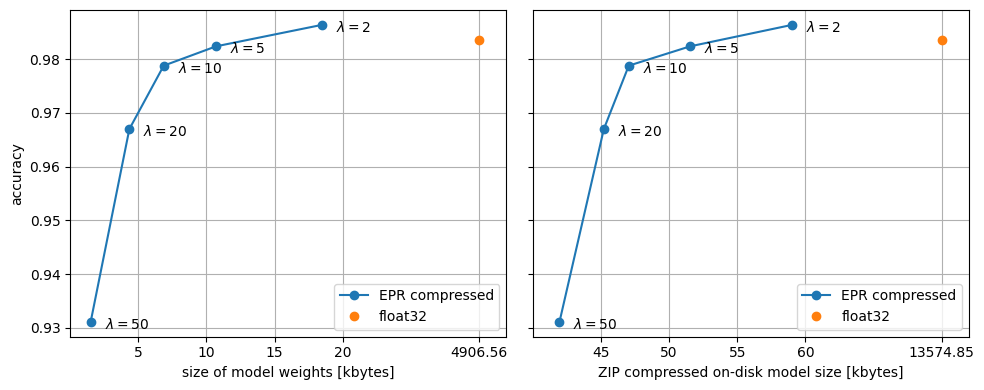

In [26]:
#@title

def plot_broken_xaxis(ax, compressed_sizes, original_size, original_accuracy):
  xticks = list(range(
      int(tf.math.floor(min(compressed_sizes) / 5) * 5),
      int(tf.math.ceil(max(compressed_sizes) / 5) * 5) + 1,
      5))
  xticks.append(xticks[-1] + 10)
  ax.set_xlim(xticks[0], xticks[-1] + 2)
  ax.set_xticks(xticks[1:])
  ax.set_xticklabels(xticks[1:-1] + [f"{original_size:0.2f}"])
  ax.plot(xticks[-1], original_accuracy, "o", label="float32")

sizes, zip_sizes, accuracies = tf.transpose(metrics)
sizes /= 1024
zip_sizes /= 1024

fig, (axl, axr) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axl.plot(sizes, accuracies, "o-", label="EPR compressed")
axr.plot(zip_sizes, accuracies, "o-", label="EPR compressed")
plot_broken_xaxis(axl, sizes, original_size/1024, classifier_accuracy)
plot_broken_xaxis(axr, zip_sizes, original_zip_size/1024, classifier_accuracy)

axl.set_xlabel("size of model weights [kbytes]")
axr.set_xlabel("ZIP compressed on-disk model size [kbytes]")
axl.set_ylabel("accuracy")
axl.legend(loc="lower right")
axr.legend(loc="lower right")
axl.grid()
axr.grid()
for i in range(len(lambdas)):
  axl.annotate(f"$\lambda = {lambdas[i]:0.0f}$", (sizes[i], accuracies[i]),
               xytext=(10, -5), xycoords="data", textcoords="offset points")
  axr.annotate(f"$\lambda = {lambdas[i]:0.0f}$", (zip_sizes[i], accuracies[i]),
               xytext=(10, -5), xycoords="data", textcoords="offset points")
plt.tight_layout()


理想情况下，该图应显示肘形大小-准确率权衡，但准确率指标有些噪声也正常。根据初始化的不同，曲线可能会出现一些曲折。

由于正则化效应，对于较小的 $\lambda$ 值，EPR 压缩模型在测试集上比原始模型更准确。即使我们比较附加 ZIP 压缩后的大小，EPR 压缩模型也要小很多倍。

## 解压缩分类器

`CompressedDense` 和 `CompressedConv2D` 在每次前向传递时会解压缩它们的权重。这使得它们非常适合内存有限的设备，但解压缩的计算成本可能很高，尤其是对于小批次。

要将模型解压缩一次，并将其用于进一步的训练或推断，我们可以使用常规层或可压缩层将其转换回模型。这在模型部署或联合学习场景中很有用。

首先，转换回普通模型，我们可以进行推断，和/或继续进行常规训练，而不会有压缩惩罚：

In [27]:
def decompress_layer(layer):
  if isinstance(layer, CompressedDense):
    return CustomDense.copy(layer)
  if isinstance(layer, CompressedConv2D):
    return CustomConv2D.copy(layer)
  return type(layer).from_config(layer.get_config())

decompressed_classifier = tf.keras.models.clone_model(
    compressed_classifier, clone_function=decompress_layer)


In [28]:
decompressed_accuracy = train_model(
    decompressed_classifier, training_dataset, validation_dataset, epochs=1)

print(f"Accuracy of the compressed classifier: {compressed_accuracy:0.4f}")
print(f"Accuracy of the decompressed classifier after one more epoch of training: {decompressed_accuracy:0.4f}")


  1/469 [..............................] - ETA: 6:37 - loss: 0.0125 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 52s - loss: 0.3250 - sparse_categorical_accuracy: 0.9453 

  3/469 [..............................] - ETA: 51s - loss: 0.2370 - sparse_categorical_accuracy: 0.9531

  4/469 [..............................] - ETA: 51s - loss: 0.3931 - sparse_categorical_accuracy: 0.9258

  5/469 [..............................] - ETA: 51s - loss: 0.4032 - sparse_categorical_accuracy: 0.9203

  6/469 [..............................] - ETA: 50s - loss: 0.3721 - sparse_categorical_accuracy: 0.9232

  7/469 [..............................] - ETA: 51s - loss: 0.3395 - sparse_categorical_accuracy: 0.9297

  8/469 [..............................] - ETA: 50s - loss: 0.3281 - sparse_categorical_accuracy: 0.9297

  9/469 [..............................] - ETA: 50s - loss: 0.3266 - sparse_categorical_accuracy: 0.9297

 10/469 [..............................] - ETA: 50s - loss: 0.3365 - sparse_categorical_accuracy: 0.9281

 11/469 [..............................] - ETA: 50s - loss: 0.3161 - sparse_categorical_accuracy: 0.9304

 12/469 [..............................] - ETA: 50s - loss: 0.3001 - sparse_categorical_accuracy: 0.9323

 13/469 [..............................] - ETA: 50s - loss: 0.2882 - sparse_categorical_accuracy: 0.9351

 14/469 [..............................] - ETA: 50s - loss: 0.2921 - sparse_categorical_accuracy: 0.9336

 15/469 [..............................] - ETA: 50s - loss: 0.2862 - sparse_categorical_accuracy: 0.9339

 16/469 [>.............................] - ETA: 49s - loss: 0.2811 - sparse_categorical_accuracy: 0.9355

 17/469 [>.............................] - ETA: 49s - loss: 0.2696 - sparse_categorical_accuracy: 0.9380

 18/469 [>.............................] - ETA: 49s - loss: 0.2725 - sparse_categorical_accuracy: 0.9371

 19/469 [>.............................] - ETA: 49s - loss: 0.2720 - sparse_categorical_accuracy: 0.9375

 20/469 [>.............................] - ETA: 49s - loss: 0.2604 - sparse_categorical_accuracy: 0.9395

 21/469 [>.............................] - ETA: 49s - loss: 0.2627 - sparse_categorical_accuracy: 0.9397

 22/469 [>.............................] - ETA: 49s - loss: 0.2661 - sparse_categorical_accuracy: 0.9389

 23/469 [>.............................] - ETA: 49s - loss: 0.2594 - sparse_categorical_accuracy: 0.9399

 24/469 [>.............................] - ETA: 49s - loss: 0.2613 - sparse_categorical_accuracy: 0.9398

 25/469 [>.............................] - ETA: 48s - loss: 0.2623 - sparse_categorical_accuracy: 0.9388

 26/469 [>.............................] - ETA: 48s - loss: 0.2597 - sparse_categorical_accuracy: 0.9396

 27/469 [>.............................] - ETA: 48s - loss: 0.2620 - sparse_categorical_accuracy: 0.9395

 28/469 [>.............................] - ETA: 48s - loss: 0.2559 - sparse_categorical_accuracy: 0.9408

 29/469 [>.............................] - ETA: 48s - loss: 0.2544 - sparse_categorical_accuracy: 0.9413

 30/469 [>.............................] - ETA: 48s - loss: 0.2521 - sparse_categorical_accuracy: 0.9417

 31/469 [>.............................] - ETA: 48s - loss: 0.2470 - sparse_categorical_accuracy: 0.9418

 32/469 [=>............................] - ETA: 48s - loss: 0.2442 - sparse_categorical_accuracy: 0.9421

 33/469 [=>............................] - ETA: 48s - loss: 0.2407 - sparse_categorical_accuracy: 0.9429

 34/469 [=>............................] - ETA: 47s - loss: 0.2393 - sparse_categorical_accuracy: 0.9428

 35/469 [=>............................] - ETA: 47s - loss: 0.2356 - sparse_categorical_accuracy: 0.9433

 36/469 [=>............................] - ETA: 47s - loss: 0.2312 - sparse_categorical_accuracy: 0.9440

 37/469 [=>............................] - ETA: 47s - loss: 0.2265 - sparse_categorical_accuracy: 0.9451

 38/469 [=>............................] - ETA: 47s - loss: 0.2245 - sparse_categorical_accuracy: 0.9451

 39/469 [=>............................] - ETA: 47s - loss: 0.2216 - sparse_categorical_accuracy: 0.9455

 40/469 [=>............................] - ETA: 47s - loss: 0.2187 - sparse_categorical_accuracy: 0.9463

 41/469 [=>............................] - ETA: 47s - loss: 0.2152 - sparse_categorical_accuracy: 0.9474

 42/469 [=>............................] - ETA: 47s - loss: 0.2125 - sparse_categorical_accuracy: 0.9479

 43/469 [=>............................] - ETA: 47s - loss: 0.2124 - sparse_categorical_accuracy: 0.9486

 44/469 [=>............................] - ETA: 47s - loss: 0.2102 - sparse_categorical_accuracy: 0.9489

 45/469 [=>............................] - ETA: 46s - loss: 0.2063 - sparse_categorical_accuracy: 0.9498

 46/469 [=>............................] - ETA: 46s - loss: 0.2055 - sparse_categorical_accuracy: 0.9502

 47/469 [==>...........................] - ETA: 46s - loss: 0.2016 - sparse_categorical_accuracy: 0.9511

 48/469 [==>...........................] - ETA: 46s - loss: 0.1985 - sparse_categorical_accuracy: 0.9518

 49/469 [==>...........................] - ETA: 46s - loss: 0.1992 - sparse_categorical_accuracy: 0.9517

 50/469 [==>...........................] - ETA: 46s - loss: 0.1971 - sparse_categorical_accuracy: 0.9519

 51/469 [==>...........................] - ETA: 46s - loss: 0.1951 - sparse_categorical_accuracy: 0.9522

 52/469 [==>...........................] - ETA: 46s - loss: 0.1936 - sparse_categorical_accuracy: 0.9528

 53/469 [==>...........................] - ETA: 46s - loss: 0.1913 - sparse_categorical_accuracy: 0.9536

 54/469 [==>...........................] - ETA: 45s - loss: 0.1888 - sparse_categorical_accuracy: 0.9541

 55/469 [==>...........................] - ETA: 45s - loss: 0.1873 - sparse_categorical_accuracy: 0.9541

 56/469 [==>...........................] - ETA: 45s - loss: 0.1845 - sparse_categorical_accuracy: 0.9547

 57/469 [==>...........................] - ETA: 45s - loss: 0.1830 - sparse_categorical_accuracy: 0.9550

 58/469 [==>...........................] - ETA: 45s - loss: 0.1812 - sparse_categorical_accuracy: 0.9551

 59/469 [==>...........................] - ETA: 45s - loss: 0.1794 - sparse_categorical_accuracy: 0.9555

 60/469 [==>...........................] - ETA: 45s - loss: 0.1780 - sparse_categorical_accuracy: 0.9557

 61/469 [==>...........................] - ETA: 45s - loss: 0.1777 - sparse_categorical_accuracy: 0.9557

 62/469 [==>...........................] - ETA: 45s - loss: 0.1777 - sparse_categorical_accuracy: 0.9558

 63/469 [===>..........................] - ETA: 44s - loss: 0.1761 - sparse_categorical_accuracy: 0.9561

 64/469 [===>..........................] - ETA: 44s - loss: 0.1746 - sparse_categorical_accuracy: 0.9564

 65/469 [===>..........................] - ETA: 44s - loss: 0.1735 - sparse_categorical_accuracy: 0.9565

 66/469 [===>..........................] - ETA: 44s - loss: 0.1714 - sparse_categorical_accuracy: 0.9570

 67/469 [===>..........................] - ETA: 44s - loss: 0.1698 - sparse_categorical_accuracy: 0.9573

 68/469 [===>..........................] - ETA: 44s - loss: 0.1681 - sparse_categorical_accuracy: 0.9576

 69/469 [===>..........................] - ETA: 44s - loss: 0.1672 - sparse_categorical_accuracy: 0.9580

 70/469 [===>..........................] - ETA: 44s - loss: 0.1653 - sparse_categorical_accuracy: 0.9586

 71/469 [===>..........................] - ETA: 44s - loss: 0.1639 - sparse_categorical_accuracy: 0.9587

 72/469 [===>..........................] - ETA: 43s - loss: 0.1629 - sparse_categorical_accuracy: 0.9590

 73/469 [===>..........................] - ETA: 43s - loss: 0.1616 - sparse_categorical_accuracy: 0.9592

 74/469 [===>..........................] - ETA: 43s - loss: 0.1601 - sparse_categorical_accuracy: 0.9596

 75/469 [===>..........................] - ETA: 43s - loss: 0.1593 - sparse_categorical_accuracy: 0.9595

 76/469 [===>..........................] - ETA: 43s - loss: 0.1580 - sparse_categorical_accuracy: 0.9596

 77/469 [===>..........................] - ETA: 43s - loss: 0.1579 - sparse_categorical_accuracy: 0.9597

 78/469 [===>..........................] - ETA: 43s - loss: 0.1567 - sparse_categorical_accuracy: 0.9600

 79/469 [====>.........................] - ETA: 43s - loss: 0.1551 - sparse_categorical_accuracy: 0.9604

 80/469 [====>.........................] - ETA: 43s - loss: 0.1543 - sparse_categorical_accuracy: 0.9605

 81/469 [====>.........................] - ETA: 42s - loss: 0.1533 - sparse_categorical_accuracy: 0.9607

 82/469 [====>.........................] - ETA: 42s - loss: 0.1526 - sparse_categorical_accuracy: 0.9609

 83/469 [====>.........................] - ETA: 42s - loss: 0.1518 - sparse_categorical_accuracy: 0.9610

 84/469 [====>.........................] - ETA: 42s - loss: 0.1512 - sparse_categorical_accuracy: 0.9611

 85/469 [====>.........................] - ETA: 42s - loss: 0.1501 - sparse_categorical_accuracy: 0.9614

 86/469 [====>.........................] - ETA: 42s - loss: 0.1496 - sparse_categorical_accuracy: 0.9613

 87/469 [====>.........................] - ETA: 42s - loss: 0.1489 - sparse_categorical_accuracy: 0.9615

 88/469 [====>.........................] - ETA: 42s - loss: 0.1480 - sparse_categorical_accuracy: 0.9616

 89/469 [====>.........................] - ETA: 42s - loss: 0.1474 - sparse_categorical_accuracy: 0.9616

 90/469 [====>.........................] - ETA: 41s - loss: 0.1461 - sparse_categorical_accuracy: 0.9619

 91/469 [====>.........................] - ETA: 41s - loss: 0.1450 - sparse_categorical_accuracy: 0.9621

 92/469 [====>.........................] - ETA: 41s - loss: 0.1440 - sparse_categorical_accuracy: 0.9623

 93/469 [====>.........................] - ETA: 41s - loss: 0.1443 - sparse_categorical_accuracy: 0.9621

 94/469 [=====>........................] - ETA: 41s - loss: 0.1435 - sparse_categorical_accuracy: 0.9621

 95/469 [=====>........................] - ETA: 41s - loss: 0.1426 - sparse_categorical_accuracy: 0.9623

 96/469 [=====>........................] - ETA: 41s - loss: 0.1428 - sparse_categorical_accuracy: 0.9622

 97/469 [=====>........................] - ETA: 41s - loss: 0.1417 - sparse_categorical_accuracy: 0.9625

 98/469 [=====>........................] - ETA: 40s - loss: 0.1407 - sparse_categorical_accuracy: 0.9627

 99/469 [=====>........................] - ETA: 40s - loss: 0.1399 - sparse_categorical_accuracy: 0.9629

100/469 [=====>........................] - ETA: 40s - loss: 0.1392 - sparse_categorical_accuracy: 0.9631

101/469 [=====>........................] - ETA: 40s - loss: 0.1382 - sparse_categorical_accuracy: 0.9633

102/469 [=====>........................] - ETA: 40s - loss: 0.1377 - sparse_categorical_accuracy: 0.9633

103/469 [=====>........................] - ETA: 40s - loss: 0.1372 - sparse_categorical_accuracy: 0.9633

104/469 [=====>........................] - ETA: 40s - loss: 0.1363 - sparse_categorical_accuracy: 0.9636

105/469 [=====>........................] - ETA: 40s - loss: 0.1353 - sparse_categorical_accuracy: 0.9638

106/469 [=====>........................] - ETA: 40s - loss: 0.1352 - sparse_categorical_accuracy: 0.9638

107/469 [=====>........................] - ETA: 39s - loss: 0.1341 - sparse_categorical_accuracy: 0.9642

108/469 [=====>........................] - ETA: 39s - loss: 0.1339 - sparse_categorical_accuracy: 0.9641

109/469 [=====>........................] - ETA: 39s - loss: 0.1335 - sparse_categorical_accuracy: 0.9642

110/469 [======>.......................] - ETA: 39s - loss: 0.1334 - sparse_categorical_accuracy: 0.9642

111/469 [======>.......................] - ETA: 39s - loss: 0.1324 - sparse_categorical_accuracy: 0.9645

112/469 [======>.......................] - ETA: 39s - loss: 0.1325 - sparse_categorical_accuracy: 0.9645

113/469 [======>.......................] - ETA: 39s - loss: 0.1323 - sparse_categorical_accuracy: 0.9645

114/469 [======>.......................] - ETA: 39s - loss: 0.1315 - sparse_categorical_accuracy: 0.9647

115/469 [======>.......................] - ETA: 39s - loss: 0.1317 - sparse_categorical_accuracy: 0.9647

116/469 [======>.......................] - ETA: 39s - loss: 0.1308 - sparse_categorical_accuracy: 0.9649

117/469 [======>.......................] - ETA: 38s - loss: 0.1305 - sparse_categorical_accuracy: 0.9649

118/469 [======>.......................] - ETA: 38s - loss: 0.1304 - sparse_categorical_accuracy: 0.9648

119/469 [======>.......................] - ETA: 38s - loss: 0.1297 - sparse_categorical_accuracy: 0.9650

120/469 [======>.......................] - ETA: 38s - loss: 0.1296 - sparse_categorical_accuracy: 0.9650

121/469 [======>.......................] - ETA: 38s - loss: 0.1299 - sparse_categorical_accuracy: 0.9650

122/469 [======>.......................] - ETA: 38s - loss: 0.1296 - sparse_categorical_accuracy: 0.9650

123/469 [======>.......................] - ETA: 38s - loss: 0.1289 - sparse_categorical_accuracy: 0.9651

124/469 [======>.......................] - ETA: 38s - loss: 0.1284 - sparse_categorical_accuracy: 0.9651

125/469 [======>.......................] - ETA: 37s - loss: 0.1279 - sparse_categorical_accuracy: 0.9653

126/469 [=======>......................] - ETA: 37s - loss: 0.1274 - sparse_categorical_accuracy: 0.9653

127/469 [=======>......................] - ETA: 37s - loss: 0.1268 - sparse_categorical_accuracy: 0.9655

128/469 [=======>......................] - ETA: 37s - loss: 0.1263 - sparse_categorical_accuracy: 0.9656

129/469 [=======>......................] - ETA: 37s - loss: 0.1265 - sparse_categorical_accuracy: 0.9657

130/469 [=======>......................] - ETA: 37s - loss: 0.1261 - sparse_categorical_accuracy: 0.9657

131/469 [=======>......................] - ETA: 37s - loss: 0.1253 - sparse_categorical_accuracy: 0.9659

132/469 [=======>......................] - ETA: 37s - loss: 0.1254 - sparse_categorical_accuracy: 0.9659

133/469 [=======>......................] - ETA: 37s - loss: 0.1253 - sparse_categorical_accuracy: 0.9659

134/469 [=======>......................] - ETA: 36s - loss: 0.1254 - sparse_categorical_accuracy: 0.9658

135/469 [=======>......................] - ETA: 36s - loss: 0.1252 - sparse_categorical_accuracy: 0.9658

136/469 [=======>......................] - ETA: 36s - loss: 0.1250 - sparse_categorical_accuracy: 0.9658

137/469 [=======>......................] - ETA: 36s - loss: 0.1253 - sparse_categorical_accuracy: 0.9657

138/469 [=======>......................] - ETA: 36s - loss: 0.1249 - sparse_categorical_accuracy: 0.9657

139/469 [=======>......................] - ETA: 36s - loss: 0.1245 - sparse_categorical_accuracy: 0.9658

140/469 [=======>......................] - ETA: 36s - loss: 0.1240 - sparse_categorical_accuracy: 0.9658

141/469 [========>.....................] - ETA: 36s - loss: 0.1235 - sparse_categorical_accuracy: 0.9658

142/469 [========>.....................] - ETA: 36s - loss: 0.1231 - sparse_categorical_accuracy: 0.9658

143/469 [========>.....................] - ETA: 35s - loss: 0.1226 - sparse_categorical_accuracy: 0.9660

144/469 [========>.....................] - ETA: 35s - loss: 0.1224 - sparse_categorical_accuracy: 0.9660

145/469 [========>.....................] - ETA: 35s - loss: 0.1220 - sparse_categorical_accuracy: 0.9662

146/469 [========>.....................] - ETA: 35s - loss: 0.1213 - sparse_categorical_accuracy: 0.9663

147/469 [========>.....................] - ETA: 35s - loss: 0.1205 - sparse_categorical_accuracy: 0.9665

148/469 [========>.....................] - ETA: 35s - loss: 0.1206 - sparse_categorical_accuracy: 0.9664

149/469 [========>.....................] - ETA: 35s - loss: 0.1201 - sparse_categorical_accuracy: 0.9665

150/469 [========>.....................] - ETA: 35s - loss: 0.1197 - sparse_categorical_accuracy: 0.9665

151/469 [========>.....................] - ETA: 35s - loss: 0.1195 - sparse_categorical_accuracy: 0.9666

152/469 [========>.....................] - ETA: 34s - loss: 0.1190 - sparse_categorical_accuracy: 0.9666

153/469 [========>.....................] - ETA: 34s - loss: 0.1184 - sparse_categorical_accuracy: 0.9668

154/469 [========>.....................] - ETA: 34s - loss: 0.1182 - sparse_categorical_accuracy: 0.9668

155/469 [========>.....................] - ETA: 34s - loss: 0.1177 - sparse_categorical_accuracy: 0.9669

156/469 [========>.....................] - ETA: 34s - loss: 0.1173 - sparse_categorical_accuracy: 0.9669

157/469 [=========>....................] - ETA: 34s - loss: 0.1171 - sparse_categorical_accuracy: 0.9670

158/469 [=========>....................] - ETA: 34s - loss: 0.1167 - sparse_categorical_accuracy: 0.9670

159/469 [=========>....................] - ETA: 34s - loss: 0.1162 - sparse_categorical_accuracy: 0.9671

160/469 [=========>....................] - ETA: 34s - loss: 0.1157 - sparse_categorical_accuracy: 0.9672

161/469 [=========>....................] - ETA: 33s - loss: 0.1155 - sparse_categorical_accuracy: 0.9672

162/469 [=========>....................] - ETA: 33s - loss: 0.1152 - sparse_categorical_accuracy: 0.9673

163/469 [=========>....................] - ETA: 33s - loss: 0.1150 - sparse_categorical_accuracy: 0.9674

164/469 [=========>....................] - ETA: 33s - loss: 0.1153 - sparse_categorical_accuracy: 0.9673

165/469 [=========>....................] - ETA: 33s - loss: 0.1149 - sparse_categorical_accuracy: 0.9673

166/469 [=========>....................] - ETA: 33s - loss: 0.1152 - sparse_categorical_accuracy: 0.9672

167/469 [=========>....................] - ETA: 33s - loss: 0.1147 - sparse_categorical_accuracy: 0.9673

168/469 [=========>....................] - ETA: 33s - loss: 0.1145 - sparse_categorical_accuracy: 0.9674

169/469 [=========>....................] - ETA: 33s - loss: 0.1140 - sparse_categorical_accuracy: 0.9675

170/469 [=========>....................] - ETA: 32s - loss: 0.1135 - sparse_categorical_accuracy: 0.9676

171/469 [=========>....................] - ETA: 32s - loss: 0.1134 - sparse_categorical_accuracy: 0.9677

172/469 [==========>...................] - ETA: 32s - loss: 0.1131 - sparse_categorical_accuracy: 0.9678

173/469 [==========>...................] - ETA: 32s - loss: 0.1126 - sparse_categorical_accuracy: 0.9679

174/469 [==========>...................] - ETA: 32s - loss: 0.1127 - sparse_categorical_accuracy: 0.9679

175/469 [==========>...................] - ETA: 32s - loss: 0.1126 - sparse_categorical_accuracy: 0.9678

176/469 [==========>...................] - ETA: 32s - loss: 0.1123 - sparse_categorical_accuracy: 0.9679

177/469 [==========>...................] - ETA: 32s - loss: 0.1125 - sparse_categorical_accuracy: 0.9679

178/469 [==========>...................] - ETA: 32s - loss: 0.1126 - sparse_categorical_accuracy: 0.9678

179/469 [==========>...................] - ETA: 31s - loss: 0.1126 - sparse_categorical_accuracy: 0.9678

180/469 [==========>...................] - ETA: 31s - loss: 0.1126 - sparse_categorical_accuracy: 0.9678

181/469 [==========>...................] - ETA: 31s - loss: 0.1121 - sparse_categorical_accuracy: 0.9679

182/469 [==========>...................] - ETA: 31s - loss: 0.1119 - sparse_categorical_accuracy: 0.9680

183/469 [==========>...................] - ETA: 31s - loss: 0.1115 - sparse_categorical_accuracy: 0.9681

184/469 [==========>...................] - ETA: 31s - loss: 0.1111 - sparse_categorical_accuracy: 0.9682

185/469 [==========>...................] - ETA: 31s - loss: 0.1110 - sparse_categorical_accuracy: 0.9682

186/469 [==========>...................] - ETA: 31s - loss: 0.1107 - sparse_categorical_accuracy: 0.9682

187/469 [==========>...................] - ETA: 31s - loss: 0.1105 - sparse_categorical_accuracy: 0.9682

188/469 [===========>..................] - ETA: 30s - loss: 0.1105 - sparse_categorical_accuracy: 0.9683

189/469 [===========>..................] - ETA: 30s - loss: 0.1101 - sparse_categorical_accuracy: 0.9684

190/469 [===========>..................] - ETA: 30s - loss: 0.1098 - sparse_categorical_accuracy: 0.9685

191/469 [===========>..................] - ETA: 30s - loss: 0.1098 - sparse_categorical_accuracy: 0.9685

192/469 [===========>..................] - ETA: 30s - loss: 0.1093 - sparse_categorical_accuracy: 0.9686

193/469 [===========>..................] - ETA: 30s - loss: 0.1090 - sparse_categorical_accuracy: 0.9687

194/469 [===========>..................] - ETA: 30s - loss: 0.1090 - sparse_categorical_accuracy: 0.9688

195/469 [===========>..................] - ETA: 30s - loss: 0.1087 - sparse_categorical_accuracy: 0.9689

196/469 [===========>..................] - ETA: 30s - loss: 0.1083 - sparse_categorical_accuracy: 0.9691

197/469 [===========>..................] - ETA: 29s - loss: 0.1085 - sparse_categorical_accuracy: 0.9690

198/469 [===========>..................] - ETA: 29s - loss: 0.1083 - sparse_categorical_accuracy: 0.9691

199/469 [===========>..................] - ETA: 29s - loss: 0.1083 - sparse_categorical_accuracy: 0.9691

200/469 [===========>..................] - ETA: 29s - loss: 0.1079 - sparse_categorical_accuracy: 0.9692

201/469 [===========>..................] - ETA: 29s - loss: 0.1076 - sparse_categorical_accuracy: 0.9692

202/469 [===========>..................] - ETA: 29s - loss: 0.1074 - sparse_categorical_accuracy: 0.9693

203/469 [===========>..................] - ETA: 29s - loss: 0.1073 - sparse_categorical_accuracy: 0.9693

204/469 [============>.................] - ETA: 29s - loss: 0.1068 - sparse_categorical_accuracy: 0.9695

205/469 [============>.................] - ETA: 29s - loss: 0.1064 - sparse_categorical_accuracy: 0.9696

206/469 [============>.................] - ETA: 28s - loss: 0.1059 - sparse_categorical_accuracy: 0.9697

207/469 [============>.................] - ETA: 28s - loss: 0.1060 - sparse_categorical_accuracy: 0.9697

208/469 [============>.................] - ETA: 28s - loss: 0.1057 - sparse_categorical_accuracy: 0.9698

209/469 [============>.................] - ETA: 28s - loss: 0.1055 - sparse_categorical_accuracy: 0.9698

210/469 [============>.................] - ETA: 28s - loss: 0.1053 - sparse_categorical_accuracy: 0.9698

211/469 [============>.................] - ETA: 28s - loss: 0.1051 - sparse_categorical_accuracy: 0.9698

212/469 [============>.................] - ETA: 28s - loss: 0.1049 - sparse_categorical_accuracy: 0.9699

213/469 [============>.................] - ETA: 28s - loss: 0.1048 - sparse_categorical_accuracy: 0.9699

214/469 [============>.................] - ETA: 27s - loss: 0.1047 - sparse_categorical_accuracy: 0.9699

215/469 [============>.................] - ETA: 27s - loss: 0.1047 - sparse_categorical_accuracy: 0.9699

216/469 [============>.................] - ETA: 27s - loss: 0.1048 - sparse_categorical_accuracy: 0.9698

217/469 [============>.................] - ETA: 27s - loss: 0.1046 - sparse_categorical_accuracy: 0.9698

218/469 [============>.................] - ETA: 27s - loss: 0.1043 - sparse_categorical_accuracy: 0.9699

219/469 [=============>................] - ETA: 27s - loss: 0.1042 - sparse_categorical_accuracy: 0.9699

220/469 [=============>................] - ETA: 27s - loss: 0.1039 - sparse_categorical_accuracy: 0.9699

221/469 [=============>................] - ETA: 27s - loss: 0.1039 - sparse_categorical_accuracy: 0.9699

222/469 [=============>................] - ETA: 27s - loss: 0.1036 - sparse_categorical_accuracy: 0.9699

223/469 [=============>................] - ETA: 26s - loss: 0.1033 - sparse_categorical_accuracy: 0.9700

224/469 [=============>................] - ETA: 26s - loss: 0.1030 - sparse_categorical_accuracy: 0.9701

225/469 [=============>................] - ETA: 26s - loss: 0.1027 - sparse_categorical_accuracy: 0.9702

226/469 [=============>................] - ETA: 26s - loss: 0.1025 - sparse_categorical_accuracy: 0.9702

227/469 [=============>................] - ETA: 26s - loss: 0.1025 - sparse_categorical_accuracy: 0.9701

228/469 [=============>................] - ETA: 26s - loss: 0.1024 - sparse_categorical_accuracy: 0.9701

229/469 [=============>................] - ETA: 26s - loss: 0.1024 - sparse_categorical_accuracy: 0.9700

230/469 [=============>................] - ETA: 26s - loss: 0.1024 - sparse_categorical_accuracy: 0.9700

231/469 [=============>................] - ETA: 26s - loss: 0.1021 - sparse_categorical_accuracy: 0.9701

232/469 [=============>................] - ETA: 26s - loss: 0.1018 - sparse_categorical_accuracy: 0.9702

233/469 [=============>................] - ETA: 25s - loss: 0.1015 - sparse_categorical_accuracy: 0.9702

234/469 [=============>................] - ETA: 25s - loss: 0.1012 - sparse_categorical_accuracy: 0.9702

235/469 [==============>...............] - ETA: 25s - loss: 0.1015 - sparse_categorical_accuracy: 0.9700

236/469 [==============>...............] - ETA: 25s - loss: 0.1013 - sparse_categorical_accuracy: 0.9701

237/469 [==============>...............] - ETA: 25s - loss: 0.1012 - sparse_categorical_accuracy: 0.9701

238/469 [==============>...............] - ETA: 25s - loss: 0.1009 - sparse_categorical_accuracy: 0.9702

239/469 [==============>...............] - ETA: 25s - loss: 0.1008 - sparse_categorical_accuracy: 0.9702

240/469 [==============>...............] - ETA: 25s - loss: 0.1004 - sparse_categorical_accuracy: 0.9703

241/469 [==============>...............] - ETA: 25s - loss: 0.1004 - sparse_categorical_accuracy: 0.9702

242/469 [==============>...............] - ETA: 24s - loss: 0.1004 - sparse_categorical_accuracy: 0.9702

243/469 [==============>...............] - ETA: 24s - loss: 0.1007 - sparse_categorical_accuracy: 0.9702

244/469 [==============>...............] - ETA: 24s - loss: 0.1007 - sparse_categorical_accuracy: 0.9702

245/469 [==============>...............] - ETA: 24s - loss: 0.1008 - sparse_categorical_accuracy: 0.9702

246/469 [==============>...............] - ETA: 24s - loss: 0.1005 - sparse_categorical_accuracy: 0.9702

247/469 [==============>...............] - ETA: 24s - loss: 0.1002 - sparse_categorical_accuracy: 0.9703

248/469 [==============>...............] - ETA: 24s - loss: 0.0999 - sparse_categorical_accuracy: 0.9704

249/469 [==============>...............] - ETA: 24s - loss: 0.1001 - sparse_categorical_accuracy: 0.9704

250/469 [==============>...............] - ETA: 24s - loss: 0.0999 - sparse_categorical_accuracy: 0.9704

251/469 [===============>..............] - ETA: 23s - loss: 0.0997 - sparse_categorical_accuracy: 0.9705

252/469 [===============>..............] - ETA: 23s - loss: 0.0996 - sparse_categorical_accuracy: 0.9705

253/469 [===============>..............] - ETA: 23s - loss: 0.0992 - sparse_categorical_accuracy: 0.9706

254/469 [===============>..............] - ETA: 23s - loss: 0.0990 - sparse_categorical_accuracy: 0.9707

255/469 [===============>..............] - ETA: 23s - loss: 0.0988 - sparse_categorical_accuracy: 0.9707

256/469 [===============>..............] - ETA: 23s - loss: 0.0985 - sparse_categorical_accuracy: 0.9708

257/469 [===============>..............] - ETA: 23s - loss: 0.0983 - sparse_categorical_accuracy: 0.9709

258/469 [===============>..............] - ETA: 23s - loss: 0.0981 - sparse_categorical_accuracy: 0.9709

259/469 [===============>..............] - ETA: 23s - loss: 0.0979 - sparse_categorical_accuracy: 0.9710

260/469 [===============>..............] - ETA: 22s - loss: 0.0977 - sparse_categorical_accuracy: 0.9710

261/469 [===============>..............] - ETA: 22s - loss: 0.0975 - sparse_categorical_accuracy: 0.9711

262/469 [===============>..............] - ETA: 22s - loss: 0.0978 - sparse_categorical_accuracy: 0.9711

263/469 [===============>..............] - ETA: 22s - loss: 0.0978 - sparse_categorical_accuracy: 0.9712

264/469 [===============>..............] - ETA: 22s - loss: 0.0981 - sparse_categorical_accuracy: 0.9711

265/469 [===============>..............] - ETA: 22s - loss: 0.0982 - sparse_categorical_accuracy: 0.9710

266/469 [================>.............] - ETA: 22s - loss: 0.0979 - sparse_categorical_accuracy: 0.9711

267/469 [================>.............] - ETA: 22s - loss: 0.0978 - sparse_categorical_accuracy: 0.9711

268/469 [================>.............] - ETA: 22s - loss: 0.0976 - sparse_categorical_accuracy: 0.9712

269/469 [================>.............] - ETA: 21s - loss: 0.0975 - sparse_categorical_accuracy: 0.9712

270/469 [================>.............] - ETA: 21s - loss: 0.0972 - sparse_categorical_accuracy: 0.9713

271/469 [================>.............] - ETA: 21s - loss: 0.0971 - sparse_categorical_accuracy: 0.9713

272/469 [================>.............] - ETA: 21s - loss: 0.0969 - sparse_categorical_accuracy: 0.9714

273/469 [================>.............] - ETA: 21s - loss: 0.0969 - sparse_categorical_accuracy: 0.9714

274/469 [================>.............] - ETA: 21s - loss: 0.0969 - sparse_categorical_accuracy: 0.9714

275/469 [================>.............] - ETA: 21s - loss: 0.0967 - sparse_categorical_accuracy: 0.9714

276/469 [================>.............] - ETA: 21s - loss: 0.0964 - sparse_categorical_accuracy: 0.9715

277/469 [================>.............] - ETA: 21s - loss: 0.0962 - sparse_categorical_accuracy: 0.9716

278/469 [================>.............] - ETA: 20s - loss: 0.0963 - sparse_categorical_accuracy: 0.9716

279/469 [================>.............] - ETA: 20s - loss: 0.0963 - sparse_categorical_accuracy: 0.9716

280/469 [================>.............] - ETA: 20s - loss: 0.0960 - sparse_categorical_accuracy: 0.9717

281/469 [================>.............] - ETA: 20s - loss: 0.0961 - sparse_categorical_accuracy: 0.9716

282/469 [=================>............] - ETA: 20s - loss: 0.0958 - sparse_categorical_accuracy: 0.9717

283/469 [=================>............] - ETA: 20s - loss: 0.0956 - sparse_categorical_accuracy: 0.9718

284/469 [=================>............] - ETA: 20s - loss: 0.0958 - sparse_categorical_accuracy: 0.9717

285/469 [=================>............] - ETA: 20s - loss: 0.0959 - sparse_categorical_accuracy: 0.9717

286/469 [=================>............] - ETA: 20s - loss: 0.0957 - sparse_categorical_accuracy: 0.9718

287/469 [=================>............] - ETA: 19s - loss: 0.0956 - sparse_categorical_accuracy: 0.9719

288/469 [=================>............] - ETA: 19s - loss: 0.0955 - sparse_categorical_accuracy: 0.9718

289/469 [=================>............] - ETA: 19s - loss: 0.0953 - sparse_categorical_accuracy: 0.9719

290/469 [=================>............] - ETA: 19s - loss: 0.0954 - sparse_categorical_accuracy: 0.9719

291/469 [=================>............] - ETA: 19s - loss: 0.0954 - sparse_categorical_accuracy: 0.9719

292/469 [=================>............] - ETA: 19s - loss: 0.0952 - sparse_categorical_accuracy: 0.9719

293/469 [=================>............] - ETA: 19s - loss: 0.0953 - sparse_categorical_accuracy: 0.9719

294/469 [=================>............] - ETA: 19s - loss: 0.0952 - sparse_categorical_accuracy: 0.9719

295/469 [=================>............] - ETA: 19s - loss: 0.0951 - sparse_categorical_accuracy: 0.9720

296/469 [=================>............] - ETA: 18s - loss: 0.0952 - sparse_categorical_accuracy: 0.9720

297/469 [=================>............] - ETA: 18s - loss: 0.0951 - sparse_categorical_accuracy: 0.9720

298/469 [==================>...........] - ETA: 18s - loss: 0.0950 - sparse_categorical_accuracy: 0.9720

299/469 [==================>...........] - ETA: 18s - loss: 0.0950 - sparse_categorical_accuracy: 0.9720

300/469 [==================>...........] - ETA: 18s - loss: 0.0947 - sparse_categorical_accuracy: 0.9721

301/469 [==================>...........] - ETA: 18s - loss: 0.0948 - sparse_categorical_accuracy: 0.9721

302/469 [==================>...........] - ETA: 18s - loss: 0.0946 - sparse_categorical_accuracy: 0.9721

303/469 [==================>...........] - ETA: 18s - loss: 0.0945 - sparse_categorical_accuracy: 0.9722

304/469 [==================>...........] - ETA: 18s - loss: 0.0943 - sparse_categorical_accuracy: 0.9722

305/469 [==================>...........] - ETA: 17s - loss: 0.0943 - sparse_categorical_accuracy: 0.9722

306/469 [==================>...........] - ETA: 17s - loss: 0.0941 - sparse_categorical_accuracy: 0.9722

307/469 [==================>...........] - ETA: 17s - loss: 0.0939 - sparse_categorical_accuracy: 0.9722

308/469 [==================>...........] - ETA: 17s - loss: 0.0941 - sparse_categorical_accuracy: 0.9722

309/469 [==================>...........] - ETA: 17s - loss: 0.0939 - sparse_categorical_accuracy: 0.9722

310/469 [==================>...........] - ETA: 17s - loss: 0.0939 - sparse_categorical_accuracy: 0.9723

311/469 [==================>...........] - ETA: 17s - loss: 0.0939 - sparse_categorical_accuracy: 0.9722

312/469 [==================>...........] - ETA: 17s - loss: 0.0938 - sparse_categorical_accuracy: 0.9723

313/469 [===================>..........] - ETA: 17s - loss: 0.0938 - sparse_categorical_accuracy: 0.9722

314/469 [===================>..........] - ETA: 16s - loss: 0.0938 - sparse_categorical_accuracy: 0.9721

315/469 [===================>..........] - ETA: 16s - loss: 0.0936 - sparse_categorical_accuracy: 0.9721

316/469 [===================>..........] - ETA: 16s - loss: 0.0934 - sparse_categorical_accuracy: 0.9722

317/469 [===================>..........] - ETA: 16s - loss: 0.0933 - sparse_categorical_accuracy: 0.9722

318/469 [===================>..........] - ETA: 16s - loss: 0.0931 - sparse_categorical_accuracy: 0.9723

319/469 [===================>..........] - ETA: 16s - loss: 0.0929 - sparse_categorical_accuracy: 0.9724

320/469 [===================>..........] - ETA: 16s - loss: 0.0928 - sparse_categorical_accuracy: 0.9724

321/469 [===================>..........] - ETA: 16s - loss: 0.0926 - sparse_categorical_accuracy: 0.9724

322/469 [===================>..........] - ETA: 16s - loss: 0.0930 - sparse_categorical_accuracy: 0.9723

323/469 [===================>..........] - ETA: 15s - loss: 0.0929 - sparse_categorical_accuracy: 0.9724

324/469 [===================>..........] - ETA: 15s - loss: 0.0929 - sparse_categorical_accuracy: 0.9723

325/469 [===================>..........] - ETA: 15s - loss: 0.0929 - sparse_categorical_accuracy: 0.9723

326/469 [===================>..........] - ETA: 15s - loss: 0.0930 - sparse_categorical_accuracy: 0.9723

327/469 [===================>..........] - ETA: 15s - loss: 0.0929 - sparse_categorical_accuracy: 0.9723

328/469 [===================>..........] - ETA: 15s - loss: 0.0927 - sparse_categorical_accuracy: 0.9724

329/469 [====================>.........] - ETA: 15s - loss: 0.0926 - sparse_categorical_accuracy: 0.9724

330/469 [====================>.........] - ETA: 15s - loss: 0.0925 - sparse_categorical_accuracy: 0.9724

331/469 [====================>.........] - ETA: 15s - loss: 0.0923 - sparse_categorical_accuracy: 0.9725

332/469 [====================>.........] - ETA: 15s - loss: 0.0923 - sparse_categorical_accuracy: 0.9724

333/469 [====================>.........] - ETA: 14s - loss: 0.0921 - sparse_categorical_accuracy: 0.9725

334/469 [====================>.........] - ETA: 14s - loss: 0.0921 - sparse_categorical_accuracy: 0.9726

335/469 [====================>.........] - ETA: 14s - loss: 0.0920 - sparse_categorical_accuracy: 0.9726

336/469 [====================>.........] - ETA: 14s - loss: 0.0919 - sparse_categorical_accuracy: 0.9726

337/469 [====================>.........] - ETA: 14s - loss: 0.0918 - sparse_categorical_accuracy: 0.9726

338/469 [====================>.........] - ETA: 14s - loss: 0.0917 - sparse_categorical_accuracy: 0.9726

339/469 [====================>.........] - ETA: 14s - loss: 0.0915 - sparse_categorical_accuracy: 0.9727

340/469 [====================>.........] - ETA: 14s - loss: 0.0913 - sparse_categorical_accuracy: 0.9727

341/469 [====================>.........] - ETA: 14s - loss: 0.0911 - sparse_categorical_accuracy: 0.9728

342/469 [====================>.........] - ETA: 13s - loss: 0.0909 - sparse_categorical_accuracy: 0.9729

343/469 [====================>.........] - ETA: 13s - loss: 0.0908 - sparse_categorical_accuracy: 0.9728

344/469 [=====================>........] - ETA: 13s - loss: 0.0906 - sparse_categorical_accuracy: 0.9729

345/469 [=====================>........] - ETA: 13s - loss: 0.0908 - sparse_categorical_accuracy: 0.9729

346/469 [=====================>........] - ETA: 13s - loss: 0.0907 - sparse_categorical_accuracy: 0.9729

347/469 [=====================>........] - ETA: 13s - loss: 0.0907 - sparse_categorical_accuracy: 0.9729

348/469 [=====================>........] - ETA: 13s - loss: 0.0905 - sparse_categorical_accuracy: 0.9730

349/469 [=====================>........] - ETA: 13s - loss: 0.0904 - sparse_categorical_accuracy: 0.9730

350/469 [=====================>........] - ETA: 13s - loss: 0.0902 - sparse_categorical_accuracy: 0.9730

351/469 [=====================>........] - ETA: 12s - loss: 0.0900 - sparse_categorical_accuracy: 0.9731

352/469 [=====================>........] - ETA: 12s - loss: 0.0899 - sparse_categorical_accuracy: 0.9731

353/469 [=====================>........] - ETA: 12s - loss: 0.0900 - sparse_categorical_accuracy: 0.9731

354/469 [=====================>........] - ETA: 12s - loss: 0.0901 - sparse_categorical_accuracy: 0.9731

355/469 [=====================>........] - ETA: 12s - loss: 0.0900 - sparse_categorical_accuracy: 0.9731

356/469 [=====================>........] - ETA: 12s - loss: 0.0900 - sparse_categorical_accuracy: 0.9731

357/469 [=====================>........] - ETA: 12s - loss: 0.0902 - sparse_categorical_accuracy: 0.9731

358/469 [=====================>........] - ETA: 12s - loss: 0.0901 - sparse_categorical_accuracy: 0.9731

359/469 [=====================>........] - ETA: 12s - loss: 0.0900 - sparse_categorical_accuracy: 0.9732

360/469 [======================>.......] - ETA: 11s - loss: 0.0898 - sparse_categorical_accuracy: 0.9732

361/469 [======================>.......] - ETA: 11s - loss: 0.0897 - sparse_categorical_accuracy: 0.9733

362/469 [======================>.......] - ETA: 11s - loss: 0.0898 - sparse_categorical_accuracy: 0.9733

363/469 [======================>.......] - ETA: 11s - loss: 0.0898 - sparse_categorical_accuracy: 0.9733

364/469 [======================>.......] - ETA: 11s - loss: 0.0897 - sparse_categorical_accuracy: 0.9733

365/469 [======================>.......] - ETA: 11s - loss: 0.0897 - sparse_categorical_accuracy: 0.9734

366/469 [======================>.......] - ETA: 11s - loss: 0.0896 - sparse_categorical_accuracy: 0.9734

367/469 [======================>.......] - ETA: 11s - loss: 0.0894 - sparse_categorical_accuracy: 0.9735

368/469 [======================>.......] - ETA: 11s - loss: 0.0894 - sparse_categorical_accuracy: 0.9734

369/469 [======================>.......] - ETA: 10s - loss: 0.0893 - sparse_categorical_accuracy: 0.9735

370/469 [======================>.......] - ETA: 10s - loss: 0.0895 - sparse_categorical_accuracy: 0.9735

371/469 [======================>.......] - ETA: 10s - loss: 0.0895 - sparse_categorical_accuracy: 0.9734

372/469 [======================>.......] - ETA: 10s - loss: 0.0894 - sparse_categorical_accuracy: 0.9734

373/469 [======================>.......] - ETA: 10s - loss: 0.0893 - sparse_categorical_accuracy: 0.9734

374/469 [======================>.......] - ETA: 10s - loss: 0.0893 - sparse_categorical_accuracy: 0.9734

375/469 [======================>.......] - ETA: 10s - loss: 0.0892 - sparse_categorical_accuracy: 0.9734

376/469 [=======================>......] - ETA: 10s - loss: 0.0890 - sparse_categorical_accuracy: 0.9735

377/469 [=======================>......] - ETA: 10s - loss: 0.0889 - sparse_categorical_accuracy: 0.9735

378/469 [=======================>......] - ETA: 9s - loss: 0.0888 - sparse_categorical_accuracy: 0.9735 

379/469 [=======================>......] - ETA: 9s - loss: 0.0886 - sparse_categorical_accuracy: 0.9736

380/469 [=======================>......] - ETA: 9s - loss: 0.0886 - sparse_categorical_accuracy: 0.9736

381/469 [=======================>......] - ETA: 9s - loss: 0.0885 - sparse_categorical_accuracy: 0.9736

382/469 [=======================>......] - ETA: 9s - loss: 0.0884 - sparse_categorical_accuracy: 0.9737

383/469 [=======================>......] - ETA: 9s - loss: 0.0883 - sparse_categorical_accuracy: 0.9737

384/469 [=======================>......] - ETA: 9s - loss: 0.0881 - sparse_categorical_accuracy: 0.9738

385/469 [=======================>......] - ETA: 9s - loss: 0.0879 - sparse_categorical_accuracy: 0.9738

386/469 [=======================>......] - ETA: 9s - loss: 0.0879 - sparse_categorical_accuracy: 0.9738

387/469 [=======================>......] - ETA: 8s - loss: 0.0879 - sparse_categorical_accuracy: 0.9738

388/469 [=======================>......] - ETA: 8s - loss: 0.0877 - sparse_categorical_accuracy: 0.9739

389/469 [=======================>......] - ETA: 8s - loss: 0.0876 - sparse_categorical_accuracy: 0.9739

390/469 [=======================>......] - ETA: 8s - loss: 0.0874 - sparse_categorical_accuracy: 0.9740

391/469 [========================>.....] - ETA: 8s - loss: 0.0873 - sparse_categorical_accuracy: 0.9740

392/469 [========================>.....] - ETA: 8s - loss: 0.0872 - sparse_categorical_accuracy: 0.9740

393/469 [========================>.....] - ETA: 8s - loss: 0.0871 - sparse_categorical_accuracy: 0.9741

394/469 [========================>.....] - ETA: 8s - loss: 0.0870 - sparse_categorical_accuracy: 0.9741

395/469 [========================>.....] - ETA: 8s - loss: 0.0869 - sparse_categorical_accuracy: 0.9741

396/469 [========================>.....] - ETA: 8s - loss: 0.0867 - sparse_categorical_accuracy: 0.9742

397/469 [========================>.....] - ETA: 7s - loss: 0.0866 - sparse_categorical_accuracy: 0.9742

398/469 [========================>.....] - ETA: 7s - loss: 0.0865 - sparse_categorical_accuracy: 0.9742

399/469 [========================>.....] - ETA: 7s - loss: 0.0865 - sparse_categorical_accuracy: 0.9743

400/469 [========================>.....] - ETA: 7s - loss: 0.0865 - sparse_categorical_accuracy: 0.9743

401/469 [========================>.....] - ETA: 7s - loss: 0.0865 - sparse_categorical_accuracy: 0.9742

402/469 [========================>.....] - ETA: 7s - loss: 0.0863 - sparse_categorical_accuracy: 0.9742

403/469 [========================>.....] - ETA: 7s - loss: 0.0862 - sparse_categorical_accuracy: 0.9743

404/469 [========================>.....] - ETA: 7s - loss: 0.0862 - sparse_categorical_accuracy: 0.9743

405/469 [========================>.....] - ETA: 7s - loss: 0.0861 - sparse_categorical_accuracy: 0.9743

406/469 [========================>.....] - ETA: 6s - loss: 0.0860 - sparse_categorical_accuracy: 0.9743

407/469 [=========================>....] - ETA: 6s - loss: 0.0858 - sparse_categorical_accuracy: 0.9744

408/469 [=========================>....] - ETA: 6s - loss: 0.0858 - sparse_categorical_accuracy: 0.9744

409/469 [=========================>....] - ETA: 6s - loss: 0.0858 - sparse_categorical_accuracy: 0.9743

410/469 [=========================>....] - ETA: 6s - loss: 0.0859 - sparse_categorical_accuracy: 0.9744

411/469 [=========================>....] - ETA: 6s - loss: 0.0859 - sparse_categorical_accuracy: 0.9744

412/469 [=========================>....] - ETA: 6s - loss: 0.0858 - sparse_categorical_accuracy: 0.9744

413/469 [=========================>....] - ETA: 6s - loss: 0.0859 - sparse_categorical_accuracy: 0.9744

414/469 [=========================>....] - ETA: 6s - loss: 0.0858 - sparse_categorical_accuracy: 0.9744

415/469 [=========================>....] - ETA: 5s - loss: 0.0858 - sparse_categorical_accuracy: 0.9744

416/469 [=========================>....] - ETA: 5s - loss: 0.0858 - sparse_categorical_accuracy: 0.9744

417/469 [=========================>....] - ETA: 5s - loss: 0.0858 - sparse_categorical_accuracy: 0.9744

418/469 [=========================>....] - ETA: 5s - loss: 0.0857 - sparse_categorical_accuracy: 0.9744

419/469 [=========================>....] - ETA: 5s - loss: 0.0855 - sparse_categorical_accuracy: 0.9744

420/469 [=========================>....] - ETA: 5s - loss: 0.0854 - sparse_categorical_accuracy: 0.9744

421/469 [=========================>....] - ETA: 5s - loss: 0.0853 - sparse_categorical_accuracy: 0.9745

422/469 [=========================>....] - ETA: 5s - loss: 0.0853 - sparse_categorical_accuracy: 0.9744

423/469 [==========================>...] - ETA: 5s - loss: 0.0852 - sparse_categorical_accuracy: 0.9745

424/469 [==========================>...] - ETA: 4s - loss: 0.0851 - sparse_categorical_accuracy: 0.9745

425/469 [==========================>...] - ETA: 4s - loss: 0.0849 - sparse_categorical_accuracy: 0.9745

426/469 [==========================>...] - ETA: 4s - loss: 0.0849 - sparse_categorical_accuracy: 0.9745

427/469 [==========================>...] - ETA: 4s - loss: 0.0850 - sparse_categorical_accuracy: 0.9745

428/469 [==========================>...] - ETA: 4s - loss: 0.0849 - sparse_categorical_accuracy: 0.9746

429/469 [==========================>...] - ETA: 4s - loss: 0.0849 - sparse_categorical_accuracy: 0.9746

430/469 [==========================>...] - ETA: 4s - loss: 0.0848 - sparse_categorical_accuracy: 0.9746

431/469 [==========================>...] - ETA: 4s - loss: 0.0847 - sparse_categorical_accuracy: 0.9746

432/469 [==========================>...] - ETA: 4s - loss: 0.0846 - sparse_categorical_accuracy: 0.9746

433/469 [==========================>...] - ETA: 3s - loss: 0.0845 - sparse_categorical_accuracy: 0.9747

434/469 [==========================>...] - ETA: 3s - loss: 0.0843 - sparse_categorical_accuracy: 0.9747

435/469 [==========================>...] - ETA: 3s - loss: 0.0842 - sparse_categorical_accuracy: 0.9748

436/469 [==========================>...] - ETA: 3s - loss: 0.0841 - sparse_categorical_accuracy: 0.9748

437/469 [==========================>...] - ETA: 3s - loss: 0.0840 - sparse_categorical_accuracy: 0.9748

438/469 [===========================>..] - ETA: 3s - loss: 0.0839 - sparse_categorical_accuracy: 0.9748

439/469 [===========================>..] - ETA: 3s - loss: 0.0839 - sparse_categorical_accuracy: 0.9748

440/469 [===========================>..] - ETA: 3s - loss: 0.0838 - sparse_categorical_accuracy: 0.9748

441/469 [===========================>..] - ETA: 3s - loss: 0.0837 - sparse_categorical_accuracy: 0.9748

442/469 [===========================>..] - ETA: 2s - loss: 0.0836 - sparse_categorical_accuracy: 0.9749

443/469 [===========================>..] - ETA: 2s - loss: 0.0836 - sparse_categorical_accuracy: 0.9749

444/469 [===========================>..] - ETA: 2s - loss: 0.0835 - sparse_categorical_accuracy: 0.9749

445/469 [===========================>..] - ETA: 2s - loss: 0.0834 - sparse_categorical_accuracy: 0.9749

446/469 [===========================>..] - ETA: 2s - loss: 0.0833 - sparse_categorical_accuracy: 0.9749

447/469 [===========================>..] - ETA: 2s - loss: 0.0832 - sparse_categorical_accuracy: 0.9749

448/469 [===========================>..] - ETA: 2s - loss: 0.0831 - sparse_categorical_accuracy: 0.9750

449/469 [===========================>..] - ETA: 2s - loss: 0.0833 - sparse_categorical_accuracy: 0.9749

450/469 [===========================>..] - ETA: 2s - loss: 0.0833 - sparse_categorical_accuracy: 0.9749

451/469 [===========================>..] - ETA: 1s - loss: 0.0832 - sparse_categorical_accuracy: 0.9750

452/469 [===========================>..] - ETA: 1s - loss: 0.0831 - sparse_categorical_accuracy: 0.9750

453/469 [===========================>..] - ETA: 1s - loss: 0.0832 - sparse_categorical_accuracy: 0.9750

454/469 [============================>.] - ETA: 1s - loss: 0.0833 - sparse_categorical_accuracy: 0.9749

455/469 [============================>.] - ETA: 1s - loss: 0.0833 - sparse_categorical_accuracy: 0.9749

456/469 [============================>.] - ETA: 1s - loss: 0.0833 - sparse_categorical_accuracy: 0.9749

457/469 [============================>.] - ETA: 1s - loss: 0.0832 - sparse_categorical_accuracy: 0.9749

458/469 [============================>.] - ETA: 1s - loss: 0.0831 - sparse_categorical_accuracy: 0.9749

459/469 [============================>.] - ETA: 1s - loss: 0.0832 - sparse_categorical_accuracy: 0.9749

460/469 [============================>.] - ETA: 0s - loss: 0.0831 - sparse_categorical_accuracy: 0.9749

461/469 [============================>.] - ETA: 0s - loss: 0.0831 - sparse_categorical_accuracy: 0.9750

462/469 [============================>.] - ETA: 0s - loss: 0.0830 - sparse_categorical_accuracy: 0.9750

463/469 [============================>.] - ETA: 0s - loss: 0.0830 - sparse_categorical_accuracy: 0.9750

464/469 [============================>.] - ETA: 0s - loss: 0.0829 - sparse_categorical_accuracy: 0.9750

465/469 [============================>.] - ETA: 0s - loss: 0.0829 - sparse_categorical_accuracy: 0.9750

466/469 [============================>.] - ETA: 0s - loss: 0.0828 - sparse_categorical_accuracy: 0.9750

467/469 [============================>.] - ETA: 0s - loss: 0.0829 - sparse_categorical_accuracy: 0.9750

468/469 [============================>.] - ETA: 0s - loss: 0.0829 - sparse_categorical_accuracy: 0.9750

469/469 [==============================] - ETA: 0s - loss: 0.0828 - sparse_categorical_accuracy: 0.9750

469/469 [==============================] - 53s 111ms/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.0665 - val_sparse_categorical_accuracy: 0.9792


Accuracy of the compressed classifier: 0.9837
Accuracy of the decompressed classifier after one more epoch of training: 0.9792


请注意，在训练额外的周期后验证准确率会下降，因为训练是在没有正则化的情况下完成的。

或者，我们可以将模型转换回“可压缩”模型，以进行推断和/或进一步训练，并带有压缩惩罚：

In [29]:
def decompress_layer_with_penalty(layer):
  if isinstance(layer, CompressedDense):
    return CompressibleDense.copy(layer, regularizer=regularizer)
  if isinstance(layer, CompressedConv2D):
    return CompressibleConv2D.copy(layer, regularizer=regularizer)
  return type(layer).from_config(layer.get_config())

decompressed_classifier = tf.keras.models.clone_model(
    compressed_classifier, clone_function=decompress_layer_with_penalty)


In [30]:
decompressed_accuracy = train_model(
    decompressed_classifier, training_dataset, validation_dataset, epochs=1)

print(f"Accuracy of the compressed classifier: {compressed_accuracy:0.4f}")
print(f"Accuracy of the decompressed classifier after one more epoch of training: {decompressed_accuracy:0.4f}")


  1/469 [..............................] - ETA: 19:17 - loss: 0.1293 - sparse_categorical_accuracy: 0.9922

  2/469 [..............................] - ETA: 54s - loss: 0.7377 - sparse_categorical_accuracy: 0.9844  

  3/469 [..............................] - ETA: 55s - loss: 0.7702 - sparse_categorical_accuracy: 0.9896

  4/469 [..............................] - ETA: 54s - loss: 0.8345 - sparse_categorical_accuracy: 0.9922

  5/469 [..............................] - ETA: 54s - loss: 0.9099 - sparse_categorical_accuracy: 0.9891

  6/469 [..............................] - ETA: 54s - loss: 0.9587 - sparse_categorical_accuracy: 0.9883

  7/469 [..............................] - ETA: 54s - loss: 0.9788 - sparse_categorical_accuracy: 0.9900

  8/469 [..............................] - ETA: 53s - loss: 0.9907 - sparse_categorical_accuracy: 0.9883

  9/469 [..............................] - ETA: 53s - loss: 0.9930 - sparse_categorical_accuracy: 0.9878

 10/469 [..............................] - ETA: 53s - loss: 0.9932 - sparse_categorical_accuracy: 0.9891

 11/469 [..............................] - ETA: 53s - loss: 1.0005 - sparse_categorical_accuracy: 0.9886

 12/469 [..............................] - ETA: 53s - loss: 1.0045 - sparse_categorical_accuracy: 0.9889

 13/469 [..............................] - ETA: 53s - loss: 1.0076 - sparse_categorical_accuracy: 0.9892

 14/469 [..............................] - ETA: 53s - loss: 1.0098 - sparse_categorical_accuracy: 0.9883

 15/469 [..............................] - ETA: 52s - loss: 1.0089 - sparse_categorical_accuracy: 0.9885

 16/469 [>.............................] - ETA: 52s - loss: 1.0091 - sparse_categorical_accuracy: 0.9883

 17/469 [>.............................] - ETA: 52s - loss: 1.0074 - sparse_categorical_accuracy: 0.9876

 18/469 [>.............................] - ETA: 52s - loss: 1.0090 - sparse_categorical_accuracy: 0.9865

 19/469 [>.............................] - ETA: 52s - loss: 1.0088 - sparse_categorical_accuracy: 0.9856

 20/469 [>.............................] - ETA: 52s - loss: 1.0078 - sparse_categorical_accuracy: 0.9855

 21/469 [>.............................] - ETA: 52s - loss: 1.0104 - sparse_categorical_accuracy: 0.9851

 22/469 [>.............................] - ETA: 51s - loss: 1.0108 - sparse_categorical_accuracy: 0.9844

 23/469 [>.............................] - ETA: 51s - loss: 1.0090 - sparse_categorical_accuracy: 0.9851

 24/469 [>.............................] - ETA: 51s - loss: 1.0118 - sparse_categorical_accuracy: 0.9844

 25/469 [>.............................] - ETA: 51s - loss: 1.0103 - sparse_categorical_accuracy: 0.9850

 26/469 [>.............................] - ETA: 51s - loss: 1.0100 - sparse_categorical_accuracy: 0.9850

 27/469 [>.............................] - ETA: 51s - loss: 1.0101 - sparse_categorical_accuracy: 0.9844

 28/469 [>.............................] - ETA: 51s - loss: 1.0084 - sparse_categorical_accuracy: 0.9849

 29/469 [>.............................] - ETA: 51s - loss: 1.0067 - sparse_categorical_accuracy: 0.9852

 30/469 [>.............................] - ETA: 50s - loss: 1.0062 - sparse_categorical_accuracy: 0.9849

 31/469 [>.............................] - ETA: 50s - loss: 1.0044 - sparse_categorical_accuracy: 0.9854

 32/469 [=>............................] - ETA: 50s - loss: 1.0038 - sparse_categorical_accuracy: 0.9854

 33/469 [=>............................] - ETA: 50s - loss: 1.0032 - sparse_categorical_accuracy: 0.9851

 34/469 [=>............................] - ETA: 50s - loss: 1.0031 - sparse_categorical_accuracy: 0.9851

 35/469 [=>............................] - ETA: 50s - loss: 1.0016 - sparse_categorical_accuracy: 0.9853

 36/469 [=>............................] - ETA: 50s - loss: 0.9998 - sparse_categorical_accuracy: 0.9855

 37/469 [=>............................] - ETA: 49s - loss: 0.9979 - sparse_categorical_accuracy: 0.9859

 38/469 [=>............................] - ETA: 49s - loss: 0.9975 - sparse_categorical_accuracy: 0.9856

 39/469 [=>............................] - ETA: 49s - loss: 0.9961 - sparse_categorical_accuracy: 0.9858

 40/469 [=>............................] - ETA: 49s - loss: 0.9945 - sparse_categorical_accuracy: 0.9859

 41/469 [=>............................] - ETA: 49s - loss: 0.9929 - sparse_categorical_accuracy: 0.9859

 42/469 [=>............................] - ETA: 49s - loss: 0.9921 - sparse_categorical_accuracy: 0.9860

 43/469 [=>............................] - ETA: 49s - loss: 0.9932 - sparse_categorical_accuracy: 0.9858

 44/469 [=>............................] - ETA: 49s - loss: 0.9917 - sparse_categorical_accuracy: 0.9860

 45/469 [=>............................] - ETA: 49s - loss: 0.9899 - sparse_categorical_accuracy: 0.9863

 46/469 [=>............................] - ETA: 48s - loss: 0.9888 - sparse_categorical_accuracy: 0.9861

 47/469 [==>...........................] - ETA: 48s - loss: 0.9869 - sparse_categorical_accuracy: 0.9864

 48/469 [==>...........................] - ETA: 48s - loss: 0.9853 - sparse_categorical_accuracy: 0.9867

 49/469 [==>...........................] - ETA: 48s - loss: 0.9852 - sparse_categorical_accuracy: 0.9868

 50/469 [==>...........................] - ETA: 48s - loss: 0.9836 - sparse_categorical_accuracy: 0.9870

 51/469 [==>...........................] - ETA: 48s - loss: 0.9832 - sparse_categorical_accuracy: 0.9867

 52/469 [==>...........................] - ETA: 48s - loss: 0.9826 - sparse_categorical_accuracy: 0.9866

 53/469 [==>...........................] - ETA: 48s - loss: 0.9817 - sparse_categorical_accuracy: 0.9866

 54/469 [==>...........................] - ETA: 48s - loss: 0.9801 - sparse_categorical_accuracy: 0.9867

 55/469 [==>...........................] - ETA: 47s - loss: 0.9788 - sparse_categorical_accuracy: 0.9866

 56/469 [==>...........................] - ETA: 47s - loss: 0.9773 - sparse_categorical_accuracy: 0.9866

 57/469 [==>...........................] - ETA: 47s - loss: 0.9766 - sparse_categorical_accuracy: 0.9863

 58/469 [==>...........................] - ETA: 47s - loss: 0.9750 - sparse_categorical_accuracy: 0.9865

 59/469 [==>...........................] - ETA: 47s - loss: 0.9738 - sparse_categorical_accuracy: 0.9865

 60/469 [==>...........................] - ETA: 47s - loss: 0.9729 - sparse_categorical_accuracy: 0.9865

 61/469 [==>...........................] - ETA: 47s - loss: 0.9723 - sparse_categorical_accuracy: 0.9863

 62/469 [==>...........................] - ETA: 47s - loss: 0.9720 - sparse_categorical_accuracy: 0.9861

 63/469 [===>..........................] - ETA: 46s - loss: 0.9710 - sparse_categorical_accuracy: 0.9861

 64/469 [===>..........................] - ETA: 46s - loss: 0.9699 - sparse_categorical_accuracy: 0.9863

 65/469 [===>..........................] - ETA: 46s - loss: 0.9689 - sparse_categorical_accuracy: 0.9865

 66/469 [===>..........................] - ETA: 46s - loss: 0.9682 - sparse_categorical_accuracy: 0.9864

 67/469 [===>..........................] - ETA: 46s - loss: 0.9674 - sparse_categorical_accuracy: 0.9862

 68/469 [===>..........................] - ETA: 46s - loss: 0.9663 - sparse_categorical_accuracy: 0.9864

 69/469 [===>..........................] - ETA: 46s - loss: 0.9655 - sparse_categorical_accuracy: 0.9864

 70/469 [===>..........................] - ETA: 46s - loss: 0.9644 - sparse_categorical_accuracy: 0.9866

 71/469 [===>..........................] - ETA: 46s - loss: 0.9642 - sparse_categorical_accuracy: 0.9866

 72/469 [===>..........................] - ETA: 45s - loss: 0.9633 - sparse_categorical_accuracy: 0.9867

 73/469 [===>..........................] - ETA: 45s - loss: 0.9622 - sparse_categorical_accuracy: 0.9868

 74/469 [===>..........................] - ETA: 45s - loss: 0.9612 - sparse_categorical_accuracy: 0.9870

 75/469 [===>..........................] - ETA: 45s - loss: 0.9603 - sparse_categorical_accuracy: 0.9870

 76/469 [===>..........................] - ETA: 45s - loss: 0.9593 - sparse_categorical_accuracy: 0.9870

 77/469 [===>..........................] - ETA: 45s - loss: 0.9591 - sparse_categorical_accuracy: 0.9870

 78/469 [===>..........................] - ETA: 45s - loss: 0.9581 - sparse_categorical_accuracy: 0.9871

 79/469 [====>.........................] - ETA: 45s - loss: 0.9572 - sparse_categorical_accuracy: 0.9872

 80/469 [====>.........................] - ETA: 44s - loss: 0.9561 - sparse_categorical_accuracy: 0.9874

 81/469 [====>.........................] - ETA: 44s - loss: 0.9555 - sparse_categorical_accuracy: 0.9873

 82/469 [====>.........................] - ETA: 44s - loss: 0.9547 - sparse_categorical_accuracy: 0.9873

 83/469 [====>.........................] - ETA: 44s - loss: 0.9538 - sparse_categorical_accuracy: 0.9873

 84/469 [====>.........................] - ETA: 44s - loss: 0.9534 - sparse_categorical_accuracy: 0.9872

 85/469 [====>.........................] - ETA: 44s - loss: 0.9525 - sparse_categorical_accuracy: 0.9872

 86/469 [====>.........................] - ETA: 44s - loss: 0.9516 - sparse_categorical_accuracy: 0.9873

 87/469 [====>.........................] - ETA: 44s - loss: 0.9508 - sparse_categorical_accuracy: 0.9872

 88/469 [====>.........................] - ETA: 44s - loss: 0.9498 - sparse_categorical_accuracy: 0.9874

 89/469 [====>.........................] - ETA: 43s - loss: 0.9488 - sparse_categorical_accuracy: 0.9874

 90/469 [====>.........................] - ETA: 43s - loss: 0.9478 - sparse_categorical_accuracy: 0.9875

 91/469 [====>.........................] - ETA: 43s - loss: 0.9474 - sparse_categorical_accuracy: 0.9875

 92/469 [====>.........................] - ETA: 43s - loss: 0.9464 - sparse_categorical_accuracy: 0.9876

 93/469 [====>.........................] - ETA: 43s - loss: 0.9467 - sparse_categorical_accuracy: 0.9872

 94/469 [=====>........................] - ETA: 43s - loss: 0.9458 - sparse_categorical_accuracy: 0.9873

 95/469 [=====>........................] - ETA: 43s - loss: 0.9452 - sparse_categorical_accuracy: 0.9873

 96/469 [=====>........................] - ETA: 43s - loss: 0.9451 - sparse_categorical_accuracy: 0.9871

 97/469 [=====>........................] - ETA: 43s - loss: 0.9444 - sparse_categorical_accuracy: 0.9871

 98/469 [=====>........................] - ETA: 42s - loss: 0.9437 - sparse_categorical_accuracy: 0.9872

 99/469 [=====>........................] - ETA: 42s - loss: 0.9431 - sparse_categorical_accuracy: 0.9873

100/469 [=====>........................] - ETA: 42s - loss: 0.9424 - sparse_categorical_accuracy: 0.9874

101/469 [=====>........................] - ETA: 42s - loss: 0.9415 - sparse_categorical_accuracy: 0.9875

102/469 [=====>........................] - ETA: 42s - loss: 0.9410 - sparse_categorical_accuracy: 0.9875

103/469 [=====>........................] - ETA: 42s - loss: 0.9404 - sparse_categorical_accuracy: 0.9874

104/469 [=====>........................] - ETA: 42s - loss: 0.9395 - sparse_categorical_accuracy: 0.9875

105/469 [=====>........................] - ETA: 42s - loss: 0.9386 - sparse_categorical_accuracy: 0.9876

106/469 [=====>........................] - ETA: 41s - loss: 0.9379 - sparse_categorical_accuracy: 0.9877

107/469 [=====>........................] - ETA: 41s - loss: 0.9369 - sparse_categorical_accuracy: 0.9878

108/469 [=====>........................] - ETA: 41s - loss: 0.9362 - sparse_categorical_accuracy: 0.9877

109/469 [=====>........................] - ETA: 41s - loss: 0.9354 - sparse_categorical_accuracy: 0.9877

110/469 [======>.......................] - ETA: 41s - loss: 0.9345 - sparse_categorical_accuracy: 0.9878

111/469 [======>.......................] - ETA: 41s - loss: 0.9335 - sparse_categorical_accuracy: 0.9879

112/469 [======>.......................] - ETA: 41s - loss: 0.9332 - sparse_categorical_accuracy: 0.9878

113/469 [======>.......................] - ETA: 41s - loss: 0.9327 - sparse_categorical_accuracy: 0.9877

114/469 [======>.......................] - ETA: 41s - loss: 0.9316 - sparse_categorical_accuracy: 0.9878

115/469 [======>.......................] - ETA: 40s - loss: 0.9314 - sparse_categorical_accuracy: 0.9876

116/469 [======>.......................] - ETA: 40s - loss: 0.9305 - sparse_categorical_accuracy: 0.9877

117/469 [======>.......................] - ETA: 40s - loss: 0.9300 - sparse_categorical_accuracy: 0.9878

118/469 [======>.......................] - ETA: 40s - loss: 0.9293 - sparse_categorical_accuracy: 0.9878

119/469 [======>.......................] - ETA: 40s - loss: 0.9285 - sparse_categorical_accuracy: 0.9879

120/469 [======>.......................] - ETA: 40s - loss: 0.9279 - sparse_categorical_accuracy: 0.9879

121/469 [======>.......................] - ETA: 40s - loss: 0.9275 - sparse_categorical_accuracy: 0.9878

122/469 [======>.......................] - ETA: 40s - loss: 0.9270 - sparse_categorical_accuracy: 0.9878

123/469 [======>.......................] - ETA: 40s - loss: 0.9263 - sparse_categorical_accuracy: 0.9879

124/469 [======>.......................] - ETA: 39s - loss: 0.9260 - sparse_categorical_accuracy: 0.9878

125/469 [======>.......................] - ETA: 39s - loss: 0.9253 - sparse_categorical_accuracy: 0.9879

126/469 [=======>......................] - ETA: 39s - loss: 0.9251 - sparse_categorical_accuracy: 0.9878

127/469 [=======>......................] - ETA: 39s - loss: 0.9246 - sparse_categorical_accuracy: 0.9879

128/469 [=======>......................] - ETA: 39s - loss: 0.9241 - sparse_categorical_accuracy: 0.9879

129/469 [=======>......................] - ETA: 39s - loss: 0.9238 - sparse_categorical_accuracy: 0.9878

130/469 [=======>......................] - ETA: 39s - loss: 0.9234 - sparse_categorical_accuracy: 0.9878

131/469 [=======>......................] - ETA: 39s - loss: 0.9228 - sparse_categorical_accuracy: 0.9879

132/469 [=======>......................] - ETA: 38s - loss: 0.9224 - sparse_categorical_accuracy: 0.9878

133/469 [=======>......................] - ETA: 38s - loss: 0.9222 - sparse_categorical_accuracy: 0.9878

134/469 [=======>......................] - ETA: 38s - loss: 0.9222 - sparse_categorical_accuracy: 0.9877

135/469 [=======>......................] - ETA: 38s - loss: 0.9218 - sparse_categorical_accuracy: 0.9876

136/469 [=======>......................] - ETA: 38s - loss: 0.9215 - sparse_categorical_accuracy: 0.9876

137/469 [=======>......................] - ETA: 38s - loss: 0.9215 - sparse_categorical_accuracy: 0.9876

138/469 [=======>......................] - ETA: 38s - loss: 0.9212 - sparse_categorical_accuracy: 0.9877

139/469 [=======>......................] - ETA: 38s - loss: 0.9208 - sparse_categorical_accuracy: 0.9877

140/469 [=======>......................] - ETA: 38s - loss: 0.9203 - sparse_categorical_accuracy: 0.9878

141/469 [========>.....................] - ETA: 37s - loss: 0.9199 - sparse_categorical_accuracy: 0.9879

142/469 [========>.....................] - ETA: 37s - loss: 0.9196 - sparse_categorical_accuracy: 0.9879

143/469 [========>.....................] - ETA: 37s - loss: 0.9191 - sparse_categorical_accuracy: 0.9879

144/469 [========>.....................] - ETA: 37s - loss: 0.9186 - sparse_categorical_accuracy: 0.9879

145/469 [========>.....................] - ETA: 37s - loss: 0.9180 - sparse_categorical_accuracy: 0.9880

146/469 [========>.....................] - ETA: 37s - loss: 0.9173 - sparse_categorical_accuracy: 0.9881

147/469 [========>.....................] - ETA: 37s - loss: 0.9166 - sparse_categorical_accuracy: 0.9881

148/469 [========>.....................] - ETA: 37s - loss: 0.9161 - sparse_categorical_accuracy: 0.9881

149/469 [========>.....................] - ETA: 37s - loss: 0.9154 - sparse_categorical_accuracy: 0.9882

150/469 [========>.....................] - ETA: 36s - loss: 0.9146 - sparse_categorical_accuracy: 0.9883

151/469 [========>.....................] - ETA: 36s - loss: 0.9138 - sparse_categorical_accuracy: 0.9884

152/469 [========>.....................] - ETA: 36s - loss: 0.9132 - sparse_categorical_accuracy: 0.9883

153/469 [========>.....................] - ETA: 36s - loss: 0.9123 - sparse_categorical_accuracy: 0.9884

154/469 [========>.....................] - ETA: 36s - loss: 0.9116 - sparse_categorical_accuracy: 0.9884

155/469 [========>.....................] - ETA: 36s - loss: 0.9107 - sparse_categorical_accuracy: 0.9885

156/469 [========>.....................] - ETA: 36s - loss: 0.9098 - sparse_categorical_accuracy: 0.9885

157/469 [=========>....................] - ETA: 36s - loss: 0.9089 - sparse_categorical_accuracy: 0.9886

158/469 [=========>....................] - ETA: 35s - loss: 0.9082 - sparse_categorical_accuracy: 0.9885

159/469 [=========>....................] - ETA: 35s - loss: 0.9073 - sparse_categorical_accuracy: 0.9885

160/469 [=========>....................] - ETA: 35s - loss: 0.9066 - sparse_categorical_accuracy: 0.9885

161/469 [=========>....................] - ETA: 35s - loss: 0.9059 - sparse_categorical_accuracy: 0.9885

162/469 [=========>....................] - ETA: 35s - loss: 0.9051 - sparse_categorical_accuracy: 0.9885

163/469 [=========>....................] - ETA: 35s - loss: 0.9043 - sparse_categorical_accuracy: 0.9885

164/469 [=========>....................] - ETA: 35s - loss: 0.9038 - sparse_categorical_accuracy: 0.9886

165/469 [=========>....................] - ETA: 35s - loss: 0.9030 - sparse_categorical_accuracy: 0.9886

166/469 [=========>....................] - ETA: 35s - loss: 0.9027 - sparse_categorical_accuracy: 0.9885

167/469 [=========>....................] - ETA: 34s - loss: 0.9019 - sparse_categorical_accuracy: 0.9886

168/469 [=========>....................] - ETA: 34s - loss: 0.9011 - sparse_categorical_accuracy: 0.9886

169/469 [=========>....................] - ETA: 34s - loss: 0.9003 - sparse_categorical_accuracy: 0.9887

170/469 [=========>....................] - ETA: 34s - loss: 0.8995 - sparse_categorical_accuracy: 0.9887

171/469 [=========>....................] - ETA: 34s - loss: 0.8988 - sparse_categorical_accuracy: 0.9887

172/469 [==========>...................] - ETA: 34s - loss: 0.8979 - sparse_categorical_accuracy: 0.9887

173/469 [==========>...................] - ETA: 34s - loss: 0.8971 - sparse_categorical_accuracy: 0.9888

174/469 [==========>...................] - ETA: 34s - loss: 0.8965 - sparse_categorical_accuracy: 0.9886

175/469 [==========>...................] - ETA: 34s - loss: 0.8958 - sparse_categorical_accuracy: 0.9886

176/469 [==========>...................] - ETA: 33s - loss: 0.8951 - sparse_categorical_accuracy: 0.9886

177/469 [==========>...................] - ETA: 33s - loss: 0.8946 - sparse_categorical_accuracy: 0.9887

178/469 [==========>...................] - ETA: 33s - loss: 0.8941 - sparse_categorical_accuracy: 0.9886

179/469 [==========>...................] - ETA: 33s - loss: 0.8936 - sparse_categorical_accuracy: 0.9887

180/469 [==========>...................] - ETA: 33s - loss: 0.8930 - sparse_categorical_accuracy: 0.9887

181/469 [==========>...................] - ETA: 33s - loss: 0.8923 - sparse_categorical_accuracy: 0.9887

182/469 [==========>...................] - ETA: 33s - loss: 0.8919 - sparse_categorical_accuracy: 0.9886

183/469 [==========>...................] - ETA: 33s - loss: 0.8913 - sparse_categorical_accuracy: 0.9887

184/469 [==========>...................] - ETA: 32s - loss: 0.8906 - sparse_categorical_accuracy: 0.9887

185/469 [==========>...................] - ETA: 32s - loss: 0.8900 - sparse_categorical_accuracy: 0.9888

186/469 [==========>...................] - ETA: 32s - loss: 0.8894 - sparse_categorical_accuracy: 0.9888

187/469 [==========>...................] - ETA: 32s - loss: 0.8890 - sparse_categorical_accuracy: 0.9888

188/469 [===========>..................] - ETA: 32s - loss: 0.8884 - sparse_categorical_accuracy: 0.9888

189/469 [===========>..................] - ETA: 32s - loss: 0.8880 - sparse_categorical_accuracy: 0.9888

190/469 [===========>..................] - ETA: 32s - loss: 0.8873 - sparse_categorical_accuracy: 0.9888

191/469 [===========>..................] - ETA: 32s - loss: 0.8872 - sparse_categorical_accuracy: 0.9887

192/469 [===========>..................] - ETA: 32s - loss: 0.8867 - sparse_categorical_accuracy: 0.9887

193/469 [===========>..................] - ETA: 31s - loss: 0.8863 - sparse_categorical_accuracy: 0.9887

194/469 [===========>..................] - ETA: 31s - loss: 0.8860 - sparse_categorical_accuracy: 0.9887

195/469 [===========>..................] - ETA: 31s - loss: 0.8855 - sparse_categorical_accuracy: 0.9888

196/469 [===========>..................] - ETA: 31s - loss: 0.8850 - sparse_categorical_accuracy: 0.9888

197/469 [===========>..................] - ETA: 31s - loss: 0.8845 - sparse_categorical_accuracy: 0.9889

198/469 [===========>..................] - ETA: 31s - loss: 0.8841 - sparse_categorical_accuracy: 0.9888

199/469 [===========>..................] - ETA: 31s - loss: 0.8837 - sparse_categorical_accuracy: 0.9888

200/469 [===========>..................] - ETA: 31s - loss: 0.8832 - sparse_categorical_accuracy: 0.9889

201/469 [===========>..................] - ETA: 30s - loss: 0.8827 - sparse_categorical_accuracy: 0.9889

202/469 [===========>..................] - ETA: 30s - loss: 0.8824 - sparse_categorical_accuracy: 0.9889

203/469 [===========>..................] - ETA: 30s - loss: 0.8820 - sparse_categorical_accuracy: 0.9889

204/469 [============>.................] - ETA: 30s - loss: 0.8814 - sparse_categorical_accuracy: 0.9889

205/469 [============>.................] - ETA: 30s - loss: 0.8809 - sparse_categorical_accuracy: 0.9889

206/469 [============>.................] - ETA: 30s - loss: 0.8803 - sparse_categorical_accuracy: 0.9890

207/469 [============>.................] - ETA: 30s - loss: 0.8797 - sparse_categorical_accuracy: 0.9890

208/469 [============>.................] - ETA: 30s - loss: 0.8790 - sparse_categorical_accuracy: 0.9891

209/469 [============>.................] - ETA: 30s - loss: 0.8783 - sparse_categorical_accuracy: 0.9891

210/469 [============>.................] - ETA: 29s - loss: 0.8778 - sparse_categorical_accuracy: 0.9891

211/469 [============>.................] - ETA: 29s - loss: 0.8771 - sparse_categorical_accuracy: 0.9892

212/469 [============>.................] - ETA: 29s - loss: 0.8766 - sparse_categorical_accuracy: 0.9892

213/469 [============>.................] - ETA: 29s - loss: 0.8759 - sparse_categorical_accuracy: 0.9892

214/469 [============>.................] - ETA: 29s - loss: 0.8756 - sparse_categorical_accuracy: 0.9890

215/469 [============>.................] - ETA: 29s - loss: 0.8751 - sparse_categorical_accuracy: 0.9890

216/469 [============>.................] - ETA: 29s - loss: 0.8745 - sparse_categorical_accuracy: 0.9890

217/469 [============>.................] - ETA: 29s - loss: 0.8739 - sparse_categorical_accuracy: 0.9891

218/469 [============>.................] - ETA: 29s - loss: 0.8731 - sparse_categorical_accuracy: 0.9891

219/469 [=============>................] - ETA: 28s - loss: 0.8726 - sparse_categorical_accuracy: 0.9891

220/469 [=============>................] - ETA: 28s - loss: 0.8719 - sparse_categorical_accuracy: 0.9891

221/469 [=============>................] - ETA: 28s - loss: 0.8716 - sparse_categorical_accuracy: 0.9891

222/469 [=============>................] - ETA: 28s - loss: 0.8709 - sparse_categorical_accuracy: 0.9891

223/469 [=============>................] - ETA: 28s - loss: 0.8704 - sparse_categorical_accuracy: 0.9891

224/469 [=============>................] - ETA: 28s - loss: 0.8698 - sparse_categorical_accuracy: 0.9891

225/469 [=============>................] - ETA: 28s - loss: 0.8693 - sparse_categorical_accuracy: 0.9891

226/469 [=============>................] - ETA: 28s - loss: 0.8687 - sparse_categorical_accuracy: 0.9891

227/469 [=============>................] - ETA: 27s - loss: 0.8681 - sparse_categorical_accuracy: 0.9892

228/469 [=============>................] - ETA: 27s - loss: 0.8675 - sparse_categorical_accuracy: 0.9891

229/469 [=============>................] - ETA: 27s - loss: 0.8669 - sparse_categorical_accuracy: 0.9891

230/469 [=============>................] - ETA: 27s - loss: 0.8664 - sparse_categorical_accuracy: 0.9891

231/469 [=============>................] - ETA: 27s - loss: 0.8658 - sparse_categorical_accuracy: 0.9892

232/469 [=============>................] - ETA: 27s - loss: 0.8652 - sparse_categorical_accuracy: 0.9892

233/469 [=============>................] - ETA: 27s - loss: 0.8646 - sparse_categorical_accuracy: 0.9892

234/469 [=============>................] - ETA: 27s - loss: 0.8640 - sparse_categorical_accuracy: 0.9892

235/469 [==============>...............] - ETA: 27s - loss: 0.8638 - sparse_categorical_accuracy: 0.9891

236/469 [==============>...............] - ETA: 26s - loss: 0.8633 - sparse_categorical_accuracy: 0.9890

237/469 [==============>...............] - ETA: 26s - loss: 0.8629 - sparse_categorical_accuracy: 0.9890

238/469 [==============>...............] - ETA: 26s - loss: 0.8623 - sparse_categorical_accuracy: 0.9890

239/469 [==============>...............] - ETA: 26s - loss: 0.8619 - sparse_categorical_accuracy: 0.9890

240/469 [==============>...............] - ETA: 26s - loss: 0.8614 - sparse_categorical_accuracy: 0.9891

241/469 [==============>...............] - ETA: 26s - loss: 0.8609 - sparse_categorical_accuracy: 0.9891

242/469 [==============>...............] - ETA: 26s - loss: 0.8605 - sparse_categorical_accuracy: 0.9891

243/469 [==============>...............] - ETA: 26s - loss: 0.8600 - sparse_categorical_accuracy: 0.9891

244/469 [==============>...............] - ETA: 26s - loss: 0.8595 - sparse_categorical_accuracy: 0.9891

245/469 [==============>...............] - ETA: 25s - loss: 0.8590 - sparse_categorical_accuracy: 0.9891

246/469 [==============>...............] - ETA: 25s - loss: 0.8585 - sparse_categorical_accuracy: 0.9891

247/469 [==============>...............] - ETA: 25s - loss: 0.8580 - sparse_categorical_accuracy: 0.9891

248/469 [==============>...............] - ETA: 25s - loss: 0.8574 - sparse_categorical_accuracy: 0.9891

249/469 [==============>...............] - ETA: 25s - loss: 0.8571 - sparse_categorical_accuracy: 0.9891

250/469 [==============>...............] - ETA: 25s - loss: 0.8566 - sparse_categorical_accuracy: 0.9892

251/469 [===============>..............] - ETA: 25s - loss: 0.8560 - sparse_categorical_accuracy: 0.9892

252/469 [===============>..............] - ETA: 25s - loss: 0.8555 - sparse_categorical_accuracy: 0.9891

253/469 [===============>..............] - ETA: 24s - loss: 0.8548 - sparse_categorical_accuracy: 0.9892

254/469 [===============>..............] - ETA: 24s - loss: 0.8542 - sparse_categorical_accuracy: 0.9892

255/469 [===============>..............] - ETA: 24s - loss: 0.8536 - sparse_categorical_accuracy: 0.9892

256/469 [===============>..............] - ETA: 24s - loss: 0.8529 - sparse_categorical_accuracy: 0.9893

257/469 [===============>..............] - ETA: 24s - loss: 0.8525 - sparse_categorical_accuracy: 0.9893

258/469 [===============>..............] - ETA: 24s - loss: 0.8518 - sparse_categorical_accuracy: 0.9893

259/469 [===============>..............] - ETA: 24s - loss: 0.8512 - sparse_categorical_accuracy: 0.9893

260/469 [===============>..............] - ETA: 24s - loss: 0.8506 - sparse_categorical_accuracy: 0.9893

261/469 [===============>..............] - ETA: 24s - loss: 0.8500 - sparse_categorical_accuracy: 0.9893

262/469 [===============>..............] - ETA: 23s - loss: 0.8497 - sparse_categorical_accuracy: 0.9892

263/469 [===============>..............] - ETA: 23s - loss: 0.8491 - sparse_categorical_accuracy: 0.9892

264/469 [===============>..............] - ETA: 23s - loss: 0.8488 - sparse_categorical_accuracy: 0.9892

265/469 [===============>..............] - ETA: 23s - loss: 0.8483 - sparse_categorical_accuracy: 0.9892

266/469 [================>.............] - ETA: 23s - loss: 0.8477 - sparse_categorical_accuracy: 0.9892

267/469 [================>.............] - ETA: 23s - loss: 0.8472 - sparse_categorical_accuracy: 0.9892

268/469 [================>.............] - ETA: 23s - loss: 0.8468 - sparse_categorical_accuracy: 0.9892

269/469 [================>.............] - ETA: 23s - loss: 0.8463 - sparse_categorical_accuracy: 0.9892

270/469 [================>.............] - ETA: 23s - loss: 0.8458 - sparse_categorical_accuracy: 0.9892

271/469 [================>.............] - ETA: 22s - loss: 0.8454 - sparse_categorical_accuracy: 0.9892

272/469 [================>.............] - ETA: 22s - loss: 0.8449 - sparse_categorical_accuracy: 0.9892

273/469 [================>.............] - ETA: 22s - loss: 0.8443 - sparse_categorical_accuracy: 0.9892

274/469 [================>.............] - ETA: 22s - loss: 0.8439 - sparse_categorical_accuracy: 0.9892

275/469 [================>.............] - ETA: 22s - loss: 0.8433 - sparse_categorical_accuracy: 0.9892

276/469 [================>.............] - ETA: 22s - loss: 0.8428 - sparse_categorical_accuracy: 0.9892

277/469 [================>.............] - ETA: 22s - loss: 0.8423 - sparse_categorical_accuracy: 0.9893

278/469 [================>.............] - ETA: 22s - loss: 0.8418 - sparse_categorical_accuracy: 0.9892

279/469 [================>.............] - ETA: 21s - loss: 0.8413 - sparse_categorical_accuracy: 0.9892

280/469 [================>.............] - ETA: 21s - loss: 0.8409 - sparse_categorical_accuracy: 0.9892

281/469 [================>.............] - ETA: 21s - loss: 0.8405 - sparse_categorical_accuracy: 0.9892

282/469 [=================>............] - ETA: 21s - loss: 0.8401 - sparse_categorical_accuracy: 0.9892

283/469 [=================>............] - ETA: 21s - loss: 0.8396 - sparse_categorical_accuracy: 0.9892

284/469 [=================>............] - ETA: 21s - loss: 0.8393 - sparse_categorical_accuracy: 0.9892

285/469 [=================>............] - ETA: 21s - loss: 0.8391 - sparse_categorical_accuracy: 0.9891

286/469 [=================>............] - ETA: 21s - loss: 0.8386 - sparse_categorical_accuracy: 0.9892

287/469 [=================>............] - ETA: 21s - loss: 0.8383 - sparse_categorical_accuracy: 0.9892

288/469 [=================>............] - ETA: 20s - loss: 0.8378 - sparse_categorical_accuracy: 0.9892

289/469 [=================>............] - ETA: 20s - loss: 0.8374 - sparse_categorical_accuracy: 0.9892

290/469 [=================>............] - ETA: 20s - loss: 0.8370 - sparse_categorical_accuracy: 0.9892

291/469 [=================>............] - ETA: 20s - loss: 0.8369 - sparse_categorical_accuracy: 0.9892

292/469 [=================>............] - ETA: 20s - loss: 0.8365 - sparse_categorical_accuracy: 0.9892

293/469 [=================>............] - ETA: 20s - loss: 0.8362 - sparse_categorical_accuracy: 0.9891

294/469 [=================>............] - ETA: 20s - loss: 0.8358 - sparse_categorical_accuracy: 0.9892

295/469 [=================>............] - ETA: 20s - loss: 0.8356 - sparse_categorical_accuracy: 0.9892

296/469 [=================>............] - ETA: 20s - loss: 0.8353 - sparse_categorical_accuracy: 0.9892

297/469 [=================>............] - ETA: 19s - loss: 0.8351 - sparse_categorical_accuracy: 0.9891

298/469 [==================>...........] - ETA: 19s - loss: 0.8348 - sparse_categorical_accuracy: 0.9892

299/469 [==================>...........] - ETA: 19s - loss: 0.8346 - sparse_categorical_accuracy: 0.9892

300/469 [==================>...........] - ETA: 19s - loss: 0.8342 - sparse_categorical_accuracy: 0.9892

301/469 [==================>...........] - ETA: 19s - loss: 0.8341 - sparse_categorical_accuracy: 0.9892

302/469 [==================>...........] - ETA: 19s - loss: 0.8338 - sparse_categorical_accuracy: 0.9892

303/469 [==================>...........] - ETA: 19s - loss: 0.8334 - sparse_categorical_accuracy: 0.9892

304/469 [==================>...........] - ETA: 19s - loss: 0.8331 - sparse_categorical_accuracy: 0.9893

305/469 [==================>...........] - ETA: 18s - loss: 0.8327 - sparse_categorical_accuracy: 0.9893

306/469 [==================>...........] - ETA: 18s - loss: 0.8324 - sparse_categorical_accuracy: 0.9893

307/469 [==================>...........] - ETA: 18s - loss: 0.8321 - sparse_categorical_accuracy: 0.9893

308/469 [==================>...........] - ETA: 18s - loss: 0.8320 - sparse_categorical_accuracy: 0.9893

309/469 [==================>...........] - ETA: 18s - loss: 0.8317 - sparse_categorical_accuracy: 0.9893

310/469 [==================>...........] - ETA: 18s - loss: 0.8315 - sparse_categorical_accuracy: 0.9892

311/469 [==================>...........] - ETA: 18s - loss: 0.8312 - sparse_categorical_accuracy: 0.9892

312/469 [==================>...........] - ETA: 18s - loss: 0.8309 - sparse_categorical_accuracy: 0.9892

313/469 [===================>..........] - ETA: 18s - loss: 0.8307 - sparse_categorical_accuracy: 0.9892

314/469 [===================>..........] - ETA: 17s - loss: 0.8305 - sparse_categorical_accuracy: 0.9892

315/469 [===================>..........] - ETA: 17s - loss: 0.8302 - sparse_categorical_accuracy: 0.9892

316/469 [===================>..........] - ETA: 17s - loss: 0.8300 - sparse_categorical_accuracy: 0.9892

317/469 [===================>..........] - ETA: 17s - loss: 0.8297 - sparse_categorical_accuracy: 0.9892

318/469 [===================>..........] - ETA: 17s - loss: 0.8294 - sparse_categorical_accuracy: 0.9892

319/469 [===================>..........] - ETA: 17s - loss: 0.8291 - sparse_categorical_accuracy: 0.9892

320/469 [===================>..........] - ETA: 17s - loss: 0.8287 - sparse_categorical_accuracy: 0.9893

321/469 [===================>..........] - ETA: 17s - loss: 0.8284 - sparse_categorical_accuracy: 0.9893

322/469 [===================>..........] - ETA: 17s - loss: 0.8281 - sparse_categorical_accuracy: 0.9893

323/469 [===================>..........] - ETA: 16s - loss: 0.8278 - sparse_categorical_accuracy: 0.9893

324/469 [===================>..........] - ETA: 16s - loss: 0.8276 - sparse_categorical_accuracy: 0.9892

325/469 [===================>..........] - ETA: 16s - loss: 0.8272 - sparse_categorical_accuracy: 0.9893

326/469 [===================>..........] - ETA: 16s - loss: 0.8269 - sparse_categorical_accuracy: 0.9893

327/469 [===================>..........] - ETA: 16s - loss: 0.8265 - sparse_categorical_accuracy: 0.9893

328/469 [===================>..........] - ETA: 16s - loss: 0.8261 - sparse_categorical_accuracy: 0.9893

329/469 [====================>.........] - ETA: 16s - loss: 0.8258 - sparse_categorical_accuracy: 0.9893

330/469 [====================>.........] - ETA: 16s - loss: 0.8256 - sparse_categorical_accuracy: 0.9893

331/469 [====================>.........] - ETA: 15s - loss: 0.8252 - sparse_categorical_accuracy: 0.9893

332/469 [====================>.........] - ETA: 15s - loss: 0.8250 - sparse_categorical_accuracy: 0.9893

333/469 [====================>.........] - ETA: 15s - loss: 0.8246 - sparse_categorical_accuracy: 0.9893

334/469 [====================>.........] - ETA: 15s - loss: 0.8244 - sparse_categorical_accuracy: 0.9893

335/469 [====================>.........] - ETA: 15s - loss: 0.8241 - sparse_categorical_accuracy: 0.9893

336/469 [====================>.........] - ETA: 15s - loss: 0.8238 - sparse_categorical_accuracy: 0.9893

337/469 [====================>.........] - ETA: 15s - loss: 0.8234 - sparse_categorical_accuracy: 0.9893

338/469 [====================>.........] - ETA: 15s - loss: 0.8231 - sparse_categorical_accuracy: 0.9893

339/469 [====================>.........] - ETA: 15s - loss: 0.8227 - sparse_categorical_accuracy: 0.9893

340/469 [====================>.........] - ETA: 14s - loss: 0.8223 - sparse_categorical_accuracy: 0.9893

341/469 [====================>.........] - ETA: 14s - loss: 0.8218 - sparse_categorical_accuracy: 0.9893

342/469 [====================>.........] - ETA: 14s - loss: 0.8214 - sparse_categorical_accuracy: 0.9894

343/469 [====================>.........] - ETA: 14s - loss: 0.8210 - sparse_categorical_accuracy: 0.9894

344/469 [=====================>........] - ETA: 14s - loss: 0.8205 - sparse_categorical_accuracy: 0.9894

345/469 [=====================>........] - ETA: 14s - loss: 0.8202 - sparse_categorical_accuracy: 0.9894

346/469 [=====================>........] - ETA: 14s - loss: 0.8199 - sparse_categorical_accuracy: 0.9893

347/469 [=====================>........] - ETA: 14s - loss: 0.8194 - sparse_categorical_accuracy: 0.9894

348/469 [=====================>........] - ETA: 14s - loss: 0.8189 - sparse_categorical_accuracy: 0.9894

349/469 [=====================>........] - ETA: 13s - loss: 0.8185 - sparse_categorical_accuracy: 0.9894

350/469 [=====================>........] - ETA: 13s - loss: 0.8180 - sparse_categorical_accuracy: 0.9894

351/469 [=====================>........] - ETA: 13s - loss: 0.8176 - sparse_categorical_accuracy: 0.9894

352/469 [=====================>........] - ETA: 13s - loss: 0.8172 - sparse_categorical_accuracy: 0.9894

353/469 [=====================>........] - ETA: 13s - loss: 0.8170 - sparse_categorical_accuracy: 0.9894

354/469 [=====================>........] - ETA: 13s - loss: 0.8167 - sparse_categorical_accuracy: 0.9894

355/469 [=====================>........] - ETA: 13s - loss: 0.8163 - sparse_categorical_accuracy: 0.9894

356/469 [=====================>........] - ETA: 13s - loss: 0.8159 - sparse_categorical_accuracy: 0.9894

357/469 [=====================>........] - ETA: 12s - loss: 0.8157 - sparse_categorical_accuracy: 0.9894

358/469 [=====================>........] - ETA: 12s - loss: 0.8153 - sparse_categorical_accuracy: 0.9894

359/469 [=====================>........] - ETA: 12s - loss: 0.8150 - sparse_categorical_accuracy: 0.9894

360/469 [======================>.......] - ETA: 12s - loss: 0.8145 - sparse_categorical_accuracy: 0.9894

361/469 [======================>.......] - ETA: 12s - loss: 0.8141 - sparse_categorical_accuracy: 0.9894

362/469 [======================>.......] - ETA: 12s - loss: 0.8138 - sparse_categorical_accuracy: 0.9894

363/469 [======================>.......] - ETA: 12s - loss: 0.8134 - sparse_categorical_accuracy: 0.9894

364/469 [======================>.......] - ETA: 12s - loss: 0.8129 - sparse_categorical_accuracy: 0.9894

365/469 [======================>.......] - ETA: 12s - loss: 0.8125 - sparse_categorical_accuracy: 0.9894

366/469 [======================>.......] - ETA: 11s - loss: 0.8122 - sparse_categorical_accuracy: 0.9894

367/469 [======================>.......] - ETA: 11s - loss: 0.8118 - sparse_categorical_accuracy: 0.9894

368/469 [======================>.......] - ETA: 11s - loss: 0.8113 - sparse_categorical_accuracy: 0.9894

369/469 [======================>.......] - ETA: 11s - loss: 0.8110 - sparse_categorical_accuracy: 0.9894

370/469 [======================>.......] - ETA: 11s - loss: 0.8108 - sparse_categorical_accuracy: 0.9894

371/469 [======================>.......] - ETA: 11s - loss: 0.8104 - sparse_categorical_accuracy: 0.9894

372/469 [======================>.......] - ETA: 11s - loss: 0.8100 - sparse_categorical_accuracy: 0.9894

373/469 [======================>.......] - ETA: 11s - loss: 0.8097 - sparse_categorical_accuracy: 0.9894

374/469 [======================>.......] - ETA: 11s - loss: 0.8095 - sparse_categorical_accuracy: 0.9894

375/469 [======================>.......] - ETA: 10s - loss: 0.8092 - sparse_categorical_accuracy: 0.9894

376/469 [=======================>......] - ETA: 10s - loss: 0.8089 - sparse_categorical_accuracy: 0.9894

377/469 [=======================>......] - ETA: 10s - loss: 0.8086 - sparse_categorical_accuracy: 0.9894

378/469 [=======================>......] - ETA: 10s - loss: 0.8083 - sparse_categorical_accuracy: 0.9894

379/469 [=======================>......] - ETA: 10s - loss: 0.8079 - sparse_categorical_accuracy: 0.9894

380/469 [=======================>......] - ETA: 10s - loss: 0.8076 - sparse_categorical_accuracy: 0.9894

381/469 [=======================>......] - ETA: 10s - loss: 0.8073 - sparse_categorical_accuracy: 0.9895

382/469 [=======================>......] - ETA: 10s - loss: 0.8069 - sparse_categorical_accuracy: 0.9895

383/469 [=======================>......] - ETA: 9s - loss: 0.8065 - sparse_categorical_accuracy: 0.9895 

384/469 [=======================>......] - ETA: 9s - loss: 0.8061 - sparse_categorical_accuracy: 0.9895

385/469 [=======================>......] - ETA: 9s - loss: 0.8057 - sparse_categorical_accuracy: 0.9895

386/469 [=======================>......] - ETA: 9s - loss: 0.8054 - sparse_categorical_accuracy: 0.9895

387/469 [=======================>......] - ETA: 9s - loss: 0.8050 - sparse_categorical_accuracy: 0.9896

388/469 [=======================>......] - ETA: 9s - loss: 0.8046 - sparse_categorical_accuracy: 0.9896

389/469 [=======================>......] - ETA: 9s - loss: 0.8041 - sparse_categorical_accuracy: 0.9896

390/469 [=======================>......] - ETA: 9s - loss: 0.8037 - sparse_categorical_accuracy: 0.9896

391/469 [========================>.....] - ETA: 9s - loss: 0.8033 - sparse_categorical_accuracy: 0.9896

392/469 [========================>.....] - ETA: 8s - loss: 0.8028 - sparse_categorical_accuracy: 0.9897

393/469 [========================>.....] - ETA: 8s - loss: 0.8024 - sparse_categorical_accuracy: 0.9897

394/469 [========================>.....] - ETA: 8s - loss: 0.8019 - sparse_categorical_accuracy: 0.9897

395/469 [========================>.....] - ETA: 8s - loss: 0.8015 - sparse_categorical_accuracy: 0.9897

396/469 [========================>.....] - ETA: 8s - loss: 0.8011 - sparse_categorical_accuracy: 0.9897

397/469 [========================>.....] - ETA: 8s - loss: 0.8007 - sparse_categorical_accuracy: 0.9897

398/469 [========================>.....] - ETA: 8s - loss: 0.8003 - sparse_categorical_accuracy: 0.9897

399/469 [========================>.....] - ETA: 8s - loss: 0.7999 - sparse_categorical_accuracy: 0.9897

400/469 [========================>.....] - ETA: 7s - loss: 0.7996 - sparse_categorical_accuracy: 0.9897

401/469 [========================>.....] - ETA: 7s - loss: 0.7992 - sparse_categorical_accuracy: 0.9897

402/469 [========================>.....] - ETA: 7s - loss: 0.7988 - sparse_categorical_accuracy: 0.9897

403/469 [========================>.....] - ETA: 7s - loss: 0.7984 - sparse_categorical_accuracy: 0.9897

404/469 [========================>.....] - ETA: 7s - loss: 0.7982 - sparse_categorical_accuracy: 0.9897

405/469 [========================>.....] - ETA: 7s - loss: 0.7981 - sparse_categorical_accuracy: 0.9897

406/469 [========================>.....] - ETA: 7s - loss: 0.7978 - sparse_categorical_accuracy: 0.9897

407/469 [=========================>....] - ETA: 7s - loss: 0.7974 - sparse_categorical_accuracy: 0.9897

408/469 [=========================>....] - ETA: 7s - loss: 0.7971 - sparse_categorical_accuracy: 0.9897

409/469 [=========================>....] - ETA: 6s - loss: 0.7968 - sparse_categorical_accuracy: 0.9898

410/469 [=========================>....] - ETA: 6s - loss: 0.7965 - sparse_categorical_accuracy: 0.9897

411/469 [=========================>....] - ETA: 6s - loss: 0.7962 - sparse_categorical_accuracy: 0.9898

412/469 [=========================>....] - ETA: 6s - loss: 0.7959 - sparse_categorical_accuracy: 0.9898

413/469 [=========================>....] - ETA: 6s - loss: 0.7958 - sparse_categorical_accuracy: 0.9897

414/469 [=========================>....] - ETA: 6s - loss: 0.7955 - sparse_categorical_accuracy: 0.9897

415/469 [=========================>....] - ETA: 6s - loss: 0.7953 - sparse_categorical_accuracy: 0.9897

416/469 [=========================>....] - ETA: 6s - loss: 0.7951 - sparse_categorical_accuracy: 0.9897

417/469 [=========================>....] - ETA: 6s - loss: 0.7948 - sparse_categorical_accuracy: 0.9897

418/469 [=========================>....] - ETA: 5s - loss: 0.7946 - sparse_categorical_accuracy: 0.9897

419/469 [=========================>....] - ETA: 5s - loss: 0.7944 - sparse_categorical_accuracy: 0.9897

420/469 [=========================>....] - ETA: 5s - loss: 0.7942 - sparse_categorical_accuracy: 0.9897

421/469 [=========================>....] - ETA: 5s - loss: 0.7940 - sparse_categorical_accuracy: 0.9897

422/469 [=========================>....] - ETA: 5s - loss: 0.7938 - sparse_categorical_accuracy: 0.9897

423/469 [==========================>...] - ETA: 5s - loss: 0.7936 - sparse_categorical_accuracy: 0.9897

424/469 [==========================>...] - ETA: 5s - loss: 0.7934 - sparse_categorical_accuracy: 0.9897

425/469 [==========================>...] - ETA: 5s - loss: 0.7932 - sparse_categorical_accuracy: 0.9897

426/469 [==========================>...] - ETA: 4s - loss: 0.7930 - sparse_categorical_accuracy: 0.9897

427/469 [==========================>...] - ETA: 4s - loss: 0.7930 - sparse_categorical_accuracy: 0.9897

428/469 [==========================>...] - ETA: 4s - loss: 0.7928 - sparse_categorical_accuracy: 0.9897

429/469 [==========================>...] - ETA: 4s - loss: 0.7927 - sparse_categorical_accuracy: 0.9897

430/469 [==========================>...] - ETA: 4s - loss: 0.7926 - sparse_categorical_accuracy: 0.9896

431/469 [==========================>...] - ETA: 4s - loss: 0.7924 - sparse_categorical_accuracy: 0.9896

432/469 [==========================>...] - ETA: 4s - loss: 0.7922 - sparse_categorical_accuracy: 0.9897

433/469 [==========================>...] - ETA: 4s - loss: 0.7920 - sparse_categorical_accuracy: 0.9897

434/469 [==========================>...] - ETA: 4s - loss: 0.7918 - sparse_categorical_accuracy: 0.9897

435/469 [==========================>...] - ETA: 3s - loss: 0.7916 - sparse_categorical_accuracy: 0.9897

436/469 [==========================>...] - ETA: 3s - loss: 0.7914 - sparse_categorical_accuracy: 0.9897

437/469 [==========================>...] - ETA: 3s - loss: 0.7913 - sparse_categorical_accuracy: 0.9897

438/469 [===========================>..] - ETA: 3s - loss: 0.7911 - sparse_categorical_accuracy: 0.9897

439/469 [===========================>..] - ETA: 3s - loss: 0.7909 - sparse_categorical_accuracy: 0.9897

440/469 [===========================>..] - ETA: 3s - loss: 0.7907 - sparse_categorical_accuracy: 0.9897

441/469 [===========================>..] - ETA: 3s - loss: 0.7905 - sparse_categorical_accuracy: 0.9897

442/469 [===========================>..] - ETA: 3s - loss: 0.7904 - sparse_categorical_accuracy: 0.9897

443/469 [===========================>..] - ETA: 3s - loss: 0.7902 - sparse_categorical_accuracy: 0.9897

444/469 [===========================>..] - ETA: 2s - loss: 0.7900 - sparse_categorical_accuracy: 0.9897

445/469 [===========================>..] - ETA: 2s - loss: 0.7898 - sparse_categorical_accuracy: 0.9897

446/469 [===========================>..] - ETA: 2s - loss: 0.7895 - sparse_categorical_accuracy: 0.9898

447/469 [===========================>..] - ETA: 2s - loss: 0.7893 - sparse_categorical_accuracy: 0.9898

448/469 [===========================>..] - ETA: 2s - loss: 0.7891 - sparse_categorical_accuracy: 0.9898

449/469 [===========================>..] - ETA: 2s - loss: 0.7889 - sparse_categorical_accuracy: 0.9898

450/469 [===========================>..] - ETA: 2s - loss: 0.7887 - sparse_categorical_accuracy: 0.9897

451/469 [===========================>..] - ETA: 2s - loss: 0.7885 - sparse_categorical_accuracy: 0.9897

452/469 [===========================>..] - ETA: 1s - loss: 0.7883 - sparse_categorical_accuracy: 0.9897

453/469 [===========================>..] - ETA: 1s - loss: 0.7880 - sparse_categorical_accuracy: 0.9897

454/469 [============================>.] - ETA: 1s - loss: 0.7880 - sparse_categorical_accuracy: 0.9897

455/469 [============================>.] - ETA: 1s - loss: 0.7878 - sparse_categorical_accuracy: 0.9897

456/469 [============================>.] - ETA: 1s - loss: 0.7877 - sparse_categorical_accuracy: 0.9897

457/469 [============================>.] - ETA: 1s - loss: 0.7875 - sparse_categorical_accuracy: 0.9897

458/469 [============================>.] - ETA: 1s - loss: 0.7873 - sparse_categorical_accuracy: 0.9897

459/469 [============================>.] - ETA: 1s - loss: 0.7873 - sparse_categorical_accuracy: 0.9897

460/469 [============================>.] - ETA: 1s - loss: 0.7871 - sparse_categorical_accuracy: 0.9897

461/469 [============================>.] - ETA: 0s - loss: 0.7870 - sparse_categorical_accuracy: 0.9897

462/469 [============================>.] - ETA: 0s - loss: 0.7868 - sparse_categorical_accuracy: 0.9897

463/469 [============================>.] - ETA: 0s - loss: 0.7866 - sparse_categorical_accuracy: 0.9897

464/469 [============================>.] - ETA: 0s - loss: 0.7865 - sparse_categorical_accuracy: 0.9897

465/469 [============================>.] - ETA: 0s - loss: 0.7864 - sparse_categorical_accuracy: 0.9897

466/469 [============================>.] - ETA: 0s - loss: 0.7863 - sparse_categorical_accuracy: 0.9897

467/469 [============================>.] - ETA: 0s - loss: 0.7863 - sparse_categorical_accuracy: 0.9897

468/469 [============================>.] - ETA: 0s - loss: 0.7862 - sparse_categorical_accuracy: 0.9897

469/469 [==============================] - ETA: 0s - loss: 0.7861 - sparse_categorical_accuracy: 0.9897

469/469 [==============================] - 58s 118ms/step - loss: 0.7861 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.7304 - val_sparse_categorical_accuracy: 0.9869


Accuracy of the compressed classifier: 0.9837
Accuracy of the decompressed classifier after one more epoch of training: 0.9869


在这里，在训练一个额外的周期后，准确率会提高。